In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_26193/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


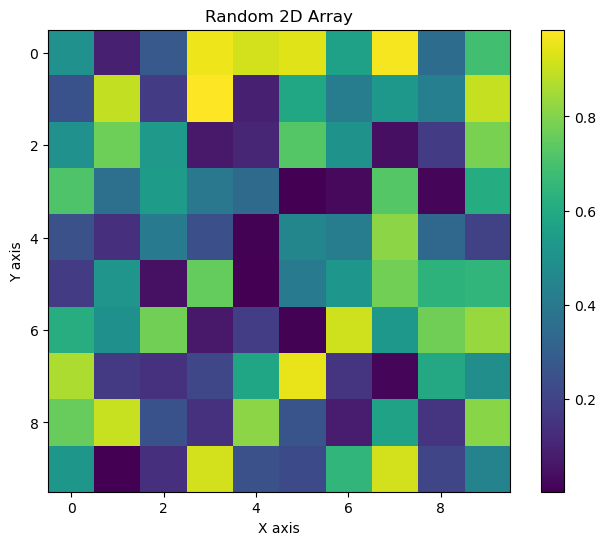

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if convTrue_fcFalse == False:
        assert OTTT_sWS_on == False
    if pre_trained == True:
        print("\nCaution! pre_trained is True\n")    
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)
    else:
        net = net.to(device)


    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################


            ## gradient 초기화 #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################

                        
                        
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
# ### my_snn control board ########################
# decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save


# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "4",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 8 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 34, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'NMNIST_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1,
#                 synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1,
#                 synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = 300,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 1, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 1_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.
                
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [6]:
# # dfa code from ASAP
# class feedback_receiver(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, input, weight_fb):
#         output = input.clone()
#         dummy = torch.Tensor(input.size()[0],weight_fb.size()[0]).zero_().to(input.device)
#         ctx.save_for_backward(weight_fb,)
#         ctx.shape = input.shape
#         return output, dummy
    
#     @staticmethod
#     def backward(ctx, grad_output, grad_dummy):
#         weight_fb, = ctx.saved_tensors
#         input_size = ctx.shape
#         grad_weight_fb = None
        
#         grad_input = torch.mm(grad_dummy.view(grad_dummy.size()[0],-1), weight_fb).view(input_size) # Batch_size, input
#         return grad_input, grad_weight_fb


# class Feedback_Receiver(nn.Module):
#     def __init__(self, connect_features):
#         super(Feedback_Receiver, self).__init__()
#         self.connect_features = connect_features
#         self.weight_fb = None
    
#     def forward(self, input):
#         if self.weight_fb is None:
#             self.weight_fb = nn.Parameter(torch.Tensor(self.connect_features, *input.size()[1:]).view(self.connect_features, -1)).to(input.device)
#             nn.init.normal_(self.weight_fb, std = math.sqrt(1./self.connect_features))
#         return feedback_receiver.apply(input, self.weight_fb)
   

In [7]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
run_name = 'main'
sweep_configuration = {
    'method': 'bayes',
    'name': 'my_snn_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
    'parameters': 
    {
        "learning_rate": {"min": 0.0001, "max": 0.01},
        "BATCH": {"values": [8,16,32,64,96,128]},
        "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
        "IMAGE_SIZE": {"values": [128]},
        "TIME": {"values": [5,6,7,8,9,10]},
        "epoch_num": {"values": [15]},
        "dvs_duration": {"values": [10_000, 100_000, 25_000, 50_000]},
        "dvs_clipping": {"values": [1,2,4]},
        "which_data": {"values": ['DVS_GESTURE_TONIC']},
        "OTTT_sWS_on": {"values": [False]},
        "const2": {"values": [True, False]},
        "surrogate": {"values": ['rectangle', 'sigmoid']},
        "cfg": {"values": [['M','M',200,200], ['M','M',200,200,200], ['M','M',200], ['M','M',512]]},
     }
}

def hyper_iter():
    ### my_snn control board ########################
    unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
    wandb.init(save_code = True)
    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.BATCH
    decay  =  wandb.config.decay
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    TIME  =  wandb.config.TIME
    epoch_num  =  wandb.config.epoch_num 
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    which_data  =  wandb.config.which_data
    OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
    const2  =  wandb.config.const2
    surrogate  =  wandb.config.surrogate
    cfg  =  wandb.config.cfg

    if const2 == True:
        const2 = decay
    else:
        const2 = 0.0

    my_snn_system(  devices = "2",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = which_data,
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = const2, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = const2, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',200,200], 
                cfg = cfg, 
                # cfg = [200,200],
                # cfg = [512], 
                # cfg = [64,128,'P',128,'P'], 
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = epoch_num,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.
                
                    ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


sweep_id = 'ntaj4stl'
print(sweep_id)
wandb.agent(sweep_id, project=f'my_snn {unique_name_hyper}', function=hyper_iter, count=10000)


ntaj4stl


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Agent Starting Run: t1qhfoij with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005704441233509585
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-11/12 iter:0.00%, lr=['0.005704441233509585'], iter_loss:2.397949695587158, tr:6.22%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [01:03<00:00,  5.27s/it] 

epoch_time: 63.39789700508118 seconds

EPOCH 1



1-11/12 iter:19.05%, lr=['0.005642113369796988'], iter_loss:2.3978726863861084, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]

epoch_time: 61.78316950798035 seconds

EPOCH 2



2-11/12 iter:4.76%, lr=['0.00545785380538571'], iter_loss:2.398444414138794, tr:7.89%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it] 

epoch_time: 57.055171251297 seconds

EPOCH 3



3-11/12 iter:9.52%, lr=['0.005159715567416013'], iter_loss:2.3978095054626465, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.71422028541565 seconds

EPOCH 4



4-11/12 iter:0.00%, lr=['0.004760728727513163'], iter_loss:2.3984830379486084, tr:9.29%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

epoch_time: 62.96944451332092 seconds

EPOCH 5



5-11/12 iter:14.29%, lr=['0.004278330925132188'], iter_loss:2.3979878425598145, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.80228352546692 seconds

EPOCH 6



6-11/12 iter:23.81%, lr=['0.003733605259038617'], iter_loss:2.4009153842926025, tr:9.38%, val:10.98%, val_best:10.98%: 100%|██████████| 12/12 [01:03<00:00,  5.26s/it]

epoch_time: 63.25011348724365 seconds

EPOCH 7



7-11/12 iter:4.76%, lr=['0.0031503588547244898'], iter_loss:2.3462345600128174, tr:8.82%, val:9.47%, val_best:10.98%: 100%|██████████| 12/12 [01:03<00:00,  5.25s/it]  

epoch_time: 63.18681049346924 seconds

EPOCH 8



8-11/12 iter:42.86%, lr=['0.002554082378785096'], iter_loss:2.2117342948913574, tr:17.36%, val:27.27%, val_best:27.27%: 100%|██████████| 12/12 [00:50<00:00,  4.24s/it]

epoch_time: 51.07163643836975 seconds

EPOCH 9



9-11/12 iter:42.86%, lr=['0.001970835974470968'], iter_loss:1.966471552848816, tr:33.43%, val:33.33%, val_best:33.33%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it] 

epoch_time: 62.31495499610901 seconds

EPOCH 10



10-11/12 iter:28.57%, lr=['0.001426110308377397'], iter_loss:1.8355326652526855, tr:42.06%, val:37.50%, val_best:37.50%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 62.98838472366333 seconds

EPOCH 11



11-11/12 iter:71.43%, lr=['0.0009437125059964225'], iter_loss:1.7368953227996826, tr:49.30%, val:41.29%, val_best:41.29%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.8448600769043 seconds

EPOCH 12



12-11/12 iter:80.95%, lr=['0.0005447256660935716'], iter_loss:1.6475868225097656, tr:56.36%, val:45.83%, val_best:45.83%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.57049107551575 seconds

EPOCH 13



13-11/12 iter:57.14%, lr=['0.00024658742812387396'], iter_loss:1.642855167388916, tr:59.24%, val:46.21%, val_best:46.21%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it] 

epoch_time: 62.540180683135986 seconds

EPOCH 14



14-11/12 iter:57.14%, lr=['6.232786371259671e-05'], iter_loss:1.5564846992492676, tr:61.28%, val:47.35%, val_best:47.35%: 100%|██████████| 12/12 [01:03<00:00,  5.28s/it]


epoch_time: 63.53283500671387 seconds



wandb: Agent Starting Run: njlzn5bi with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0024310678333098173
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:0.00%, lr=['0.0024310678333098173'], iter_loss:2.3976988792419434, tr:7.15%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it] 

epoch_time: 53.46722483634949 seconds

EPOCH 1



1-8/9 iter:7.55%, lr=['0.0024045055008414733'], iter_loss:2.397815465927124, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]  

epoch_time: 58.399208545684814 seconds

EPOCH 2



2-8/9 iter:5.66%, lr=['0.00232597940482552'], iter_loss:2.3976781368255615, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.88612079620361 seconds

EPOCH 3



3-8/9 iter:3.77%, lr=['0.0021989215124678706'], iter_loss:2.3976564407348633, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it] 

epoch_time: 57.97112989425659 seconds

EPOCH 4



4-8/9 iter:5.66%, lr=['0.002028884863355965'], iter_loss:2.3983373641967773, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it] 

epoch_time: 56.9011504650116 seconds

EPOCH 5



5-8/9 iter:5.66%, lr=['0.0018233008749823627'], iter_loss:2.3982064723968506, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:52<00:00,  5.86s/it] 

epoch_time: 52.84154176712036 seconds

EPOCH 6



6-8/9 iter:11.32%, lr=['0.0015911545541404163'], iter_loss:2.3987271785736084, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.3780312538147 seconds

EPOCH 7



7-8/9 iter:5.66%, lr=['0.0013425918090125583'], iter_loss:2.3990724086761475, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:57<00:00,  6.39s/it] 

epoch_time: 57.65329718589783 seconds

EPOCH 8



8-8/9 iter:13.21%, lr=['0.0010884760242972594'], iter_loss:2.398770809173584, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it] 

epoch_time: 57.59089517593384 seconds

EPOCH 9



9-8/9 iter:9.43%, lr=['0.0008399132791694012'], iter_loss:2.3987014293670654, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:48<00:00,  5.37s/it] 

epoch_time: 48.44164490699768 seconds

EPOCH 10



10-8/9 iter:5.66%, lr=['0.0006077669583274546'], iter_loss:2.3987460136413574, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:56<00:00,  6.25s/it] 

epoch_time: 56.4179151058197 seconds

EPOCH 11



11-8/9 iter:0.00%, lr=['0.0004021829699538522'], iter_loss:2.398801326751709, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:56<00:00,  6.29s/it]  

epoch_time: 56.73461985588074 seconds

EPOCH 12



12-8/9 iter:9.43%, lr=['0.0002321463208419467'], iter_loss:2.398789167404175, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]  

epoch_time: 54.4156494140625 seconds

EPOCH 13



13-8/9 iter:11.32%, lr=['0.00010508842848429693'], iter_loss:2.3987863063812256, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 57.01997685432434 seconds

EPOCH 14



14-8/9 iter:9.43%, lr=['2.6562332468344024e-05'], iter_loss:2.3987810611724854, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it] 


epoch_time: 53.14669728279114 seconds



wandb: Agent Starting Run: 36kptf0g with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006773000260824614
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-67/68 iter:0.00%, lr=['0.006773000260824614'], iter_loss:2.4099559783935547, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 

epoch_time: 55.08882284164429 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.006698997107859825'], iter_loss:2.3904435634613037, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.24it/s] 

epoch_time: 55.18283414840698 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.006480221941856545'], iter_loss:2.3979086875915527, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.88201975822449 seconds

EPOCH 3



3-67/68 iter:20.00%, lr=['0.00612623628736884'], iter_loss:2.408144950866699, tr:8.91%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 56.01601433753967 seconds

EPOCH 4



4-67/68 iter:0.00%, lr=['0.005652511016109447'], iter_loss:2.4259393215179443, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.23898935317993 seconds

EPOCH 5



5-67/68 iter:0.00%, lr=['0.005079750195618461'], iter_loss:2.3956053256988525, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 56.082433462142944 seconds

EPOCH 6



6-67/68 iter:0.00%, lr=['0.004432986222162686'], iter_loss:2.399167776107788, tr:7.61%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]  

epoch_time: 56.62897276878357 seconds

EPOCH 7



7-67/68 iter:20.00%, lr=['0.003740485784900014'], iter_loss:2.4066052436828613, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.900482177734375 seconds

EPOCH 8



8-67/68 iter:0.00%, lr=['0.0030325144759246014'], iter_loss:2.3980534076690674, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 56.08461833000183 seconds

EPOCH 9



9-67/68 iter:0.00%, lr=['0.002340014038661929'], iter_loss:2.4012184143066406, tr:6.87%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.736809730529785 seconds

EPOCH 10



10-67/68 iter:40.00%, lr=['0.0016932500652061546'], iter_loss:2.3985962867736816, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.286906480789185 seconds

EPOCH 11



11-67/68 iter:0.00%, lr=['0.0011204892447151688'], iter_loss:2.3998360633850098, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s] 

epoch_time: 50.405545473098755 seconds

EPOCH 12



12-67/68 iter:0.00%, lr=['0.0006467639734557753'], iter_loss:2.399353265762329, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]  

epoch_time: 55.57647371292114 seconds

EPOCH 13



13-67/68 iter:20.00%, lr=['0.00029277831896806815'], iter_loss:2.398792266845703, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 56.09347486495972 seconds

EPOCH 14



14-67/68 iter:0.00%, lr=['7.400315296478886e-05'], iter_loss:2.398747205734253, tr:7.89%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]  


epoch_time: 57.457998752593994 seconds



wandb: Agent Starting Run: jh8l3nca with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006146112301231346
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-8/9 iter:5.66%, lr=['0.006146112301231346'], iter_loss:2.3978700637817383, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it] 

epoch_time: 57.44436240196228 seconds

EPOCH 1



1-8/9 iter:5.66%, lr=['0.006078958651260658'], iter_loss:2.398021697998047, tr:6.69%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:56<00:00,  6.27s/it]  

epoch_time: 56.574530363082886 seconds

EPOCH 2



2-8/9 iter:11.32%, lr=['0.0058804326380912765'], iter_loss:2.3989317417144775, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:50<00:00,  5.62s/it]

epoch_time: 50.73867225646973 seconds

EPOCH 3



3-8/9 iter:9.43%, lr=['0.00555921080113221'], iter_loss:2.398120880126953, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:56<00:00,  6.27s/it]  

epoch_time: 56.526445627212524 seconds

EPOCH 4



4-8/9 iter:1.89%, lr=['0.005129332076051957'], iter_loss:2.39894437789917, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]   

epoch_time: 55.85624814033508 seconds

EPOCH 5



5-8/9 iter:11.32%, lr=['0.004609584225923509'], iter_loss:2.3994154930114746, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.47037100791931 seconds

EPOCH 6



6-8/9 iter:15.09%, lr=['0.004022682725824374'], iter_loss:2.3985354900360107, tr:8.91%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.71541881561279 seconds

EPOCH 7



7-8/9 iter:5.66%, lr=['0.0033942779875747405'], iter_loss:2.3997867107391357, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:57<00:00,  6.39s/it] 

epoch_time: 57.64511275291443 seconds

EPOCH 8



8-8/9 iter:9.43%, lr=['0.002751834313656607'], iter_loss:2.4002652168273926, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:52<00:00,  5.84s/it] 

epoch_time: 52.705326080322266 seconds

EPOCH 9



9-8/9 iter:9.43%, lr=['0.0021234295754069725'], iter_loss:2.4002280235290527, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:57<00:00,  6.33s/it] 

epoch_time: 57.13732600212097 seconds

EPOCH 10



10-8/9 iter:1.89%, lr=['0.0015365280753078373'], iter_loss:2.400975465774536, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it]  

epoch_time: 56.95885610580444 seconds

EPOCH 11



11-8/9 iter:9.43%, lr=['0.00101678022517939'], iter_loss:2.401088237762451, tr:7.61%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]  

epoch_time: 56.299081802368164 seconds

EPOCH 12



12-8/9 iter:1.89%, lr=['0.0005869015000991357'], iter_loss:2.4009952545166016, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it] 

epoch_time: 52.98011898994446 seconds

EPOCH 13



13-8/9 iter:3.77%, lr=['0.0002656796631400683'], iter_loss:2.400871992111206, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:07<00:00,  7.48s/it]  

epoch_time: 67.49726366996765 seconds

EPOCH 14



14-8/9 iter:18.87%, lr=['6.715364997068785e-05'], iter_loss:2.400869131088257, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:22<00:00,  9.21s/it] 


epoch_time: 83.02259707450867 seconds



wandb: Agent Starting Run: cpuck4d2 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00141662088390804
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:7.55%, lr=['0.00141662088390804'], iter_loss:2.3977057933807373, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:32<00:00, 10.24s/it]

epoch_time: 92.33413100242615 seconds

EPOCH 1



1-8/9 iter:7.55%, lr=['0.0014011426013260462'], iter_loss:2.3977041244506836, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:27<00:00,  9.77s/it] 

epoch_time: 88.07914137840271 seconds

EPOCH 2



2-8/9 iter:7.55%, lr=['0.001355384228801938'], iter_loss:2.3975236415863037, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:36<00:00, 10.74s/it] 

epoch_time: 96.8135917186737 seconds

EPOCH 3



3-8/9 iter:11.32%, lr=['0.001281345626788052'], iter_loss:2.3980770111083984, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:29<00:00,  9.90s/it]

epoch_time: 89.26687479019165 seconds

EPOCH 4



4-8/9 iter:9.43%, lr=['0.0011822626374690243'], iter_loss:2.3980469703674316, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:27<00:00,  9.75s/it] 

epoch_time: 87.92743849754333 seconds

EPOCH 5



5-8/9 iter:7.55%, lr=['0.00106246566293103'], iter_loss:2.398138999938965, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:31<00:00, 10.14s/it]  

epoch_time: 91.4106171131134 seconds

EPOCH 6



6-8/9 iter:7.55%, lr=['0.000927190405811042'], iter_loss:2.398024082183838, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:30<00:00, 10.10s/it]  

epoch_time: 91.08304381370544 seconds

EPOCH 7



7-8/9 iter:13.21%, lr=['0.0007823490439679064'], iter_loss:2.398322343826294, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:32<00:00, 10.30s/it] 

epoch_time: 92.85265827178955 seconds

EPOCH 8



8-8/9 iter:9.43%, lr=['0.0006342718399401341'], iter_loss:2.3982086181640625, tr:8.73%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:26<00:00,  9.66s/it] 

epoch_time: 87.09906387329102 seconds

EPOCH 9



9-8/9 iter:9.43%, lr=['0.0004894304780969983'], iter_loss:2.3983688354492188, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:30<00:00, 10.05s/it]

epoch_time: 90.65926742553711 seconds

EPOCH 10



10-8/9 iter:13.21%, lr=['0.0003541552209770103'], iter_loss:2.398294448852539, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:23<00:00,  9.32s/it] 

epoch_time: 84.12902617454529 seconds

EPOCH 11



11-8/9 iter:5.66%, lr=['0.00023435824643901603'], iter_loss:2.3981568813323975, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:20<00:00,  8.89s/it] 

epoch_time: 80.24255657196045 seconds

EPOCH 12



12-8/9 iter:9.43%, lr=['0.00013527525711998816'], iter_loss:2.3981828689575195, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:30<00:00, 10.00s/it] 

epoch_time: 90.17033576965332 seconds

EPOCH 13



13-8/9 iter:3.77%, lr=['6.123665510610186e-05'], iter_loss:2.3981752395629883, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:32<00:00, 10.29s/it] 

epoch_time: 92.79418659210205 seconds

EPOCH 14



14-8/9 iter:7.55%, lr=['1.54782825819938e-05'], iter_loss:2.398176431655884, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:33<00:00, 10.35s/it]  


epoch_time: 93.3417763710022 seconds



wandb: Agent Starting Run: 9vees9wj with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004400577856111266
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:9.52%, lr=['0.004400577856111266'], iter_loss:2.397933006286621, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [01:15<00:00,  6.29s/it]  

epoch_time: 75.61992049217224 seconds

EPOCH 1



1-11/12 iter:9.52%, lr=['0.004352496263954408'], iter_loss:2.397258758544922, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it] 

epoch_time: 60.44477701187134 seconds

EPOCH 2



2-11/12 iter:14.29%, lr=['0.004210352883782164'], iter_loss:2.3975634574890137, tr:8.73%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:54<00:00,  4.50s/it]

epoch_time: 54.189419746398926 seconds

EPOCH 3



3-11/12 iter:9.52%, lr=['0.003980360063387677'], iter_loss:2.3975722789764404, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.96397542953491 seconds

EPOCH 4



4-11/12 iter:9.52%, lr=['0.003672569592650181'], iter_loss:2.3983335494995117, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.91535210609436 seconds

EPOCH 5



5-11/12 iter:0.00%, lr=['0.0033004333920834497'], iter_loss:2.3987505435943604, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:46<00:00,  3.87s/it]

epoch_time: 46.53208518028259 seconds

EPOCH 6



6-11/12 iter:4.76%, lr=['0.00288021559935986'], iter_loss:2.3980183601379395, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]

epoch_time: 59.06725716590881 seconds

EPOCH 7



7-11/12 iter:4.76%, lr=['0.0024302817484501216'], iter_loss:2.397723436355591, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]  

epoch_time: 57.04629182815552 seconds

EPOCH 8



8-11/12 iter:4.76%, lr=['0.001970296107661146'], iter_loss:2.3977162837982178, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it] 

epoch_time: 58.26560163497925 seconds

EPOCH 9



9-11/12 iter:4.76%, lr=['0.001520362256751407'], iter_loss:2.397669792175293, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.00786066055298 seconds

EPOCH 10



10-11/12 iter:14.29%, lr=['0.0011001444640278172'], iter_loss:2.3976199626922607, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.306771755218506 seconds

EPOCH 11



11-11/12 iter:4.76%, lr=['0.0007280082634610859'], iter_loss:2.397714376449585, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]  

epoch_time: 57.61502933502197 seconds

EPOCH 12



12-11/12 iter:9.52%, lr=['0.00042021779272359'], iter_loss:2.3977391719818115, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.484663009643555 seconds

EPOCH 13



13-11/12 iter:9.52%, lr=['0.00019022497232910182'], iter_loss:2.397775411605835, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:52<00:00,  4.34s/it] 

epoch_time: 52.19219088554382 seconds

EPOCH 14



14-11/12 iter:4.76%, lr=['4.808159215685839e-05'], iter_loss:2.397780179977417, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it] 


epoch_time: 59.59647488594055 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xr6vr16n with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0057593515387843915
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.0057593515387843915'], iter_loss:2.4310805797576904, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:11<00:00,  1.90it/s] 

epoch_time: 71.25192260742188 seconds

EPOCH 1



1-134/135 iter:0.00%, lr=['0.005696423714114448'], iter_loss:2.3864407539367676, tr:7.06%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:10<00:00,  1.91it/s] 

epoch_time: 70.85181951522827 seconds

EPOCH 2



2-134/135 iter:20.00%, lr=['0.005510390488003898'], iter_loss:2.405146360397339, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:11<00:00,  1.90it/s] 

epoch_time: 71.21634936332703 seconds

EPOCH 3



3-134/135 iter:0.00%, lr=['0.0052093824051202345'], iter_loss:2.412339210510254, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:12<00:00,  1.87it/s]  

epoch_time: 72.19381833076477 seconds

EPOCH 4



4-134/135 iter:0.00%, lr=['0.004806554963082507'], iter_loss:2.4287073612213135, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:06<00:00,  2.02it/s] 

epoch_time: 66.84754729270935 seconds

EPOCH 5



5-134/135 iter:0.00%, lr=['0.004319513654088294'], iter_loss:2.3963022232055664, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:10<00:00,  1.91it/s] 

epoch_time: 70.88424110412598 seconds

EPOCH 6



6-134/135 iter:0.00%, lr=['0.0037695445204241366'], iter_loss:2.4164280891418457, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:11<00:00,  1.89it/s] 

epoch_time: 71.44139671325684 seconds

EPOCH 7



7-134/135 iter:20.00%, lr=['0.0031806838522758603'], iter_loss:2.4103057384490967, tr:7.15%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:10<00:00,  1.93it/s]

epoch_time: 70.27697515487671 seconds

EPOCH 8



8-134/135 iter:20.00%, lr=['0.002578667686508533'], iter_loss:2.401974678039551, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:06<00:00,  2.04it/s] 

epoch_time: 66.46913123130798 seconds

EPOCH 9



9-134/135 iter:0.00%, lr=['0.001989807018360256'], iter_loss:2.397946834564209, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:11<00:00,  1.89it/s]  

epoch_time: 71.450838804245 seconds

EPOCH 10



10-134/135 iter:0.00%, lr=['0.001439837884696099'], iter_loss:2.3939554691314697, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:10<00:00,  1.93it/s] 

epoch_time: 70.26028203964233 seconds

EPOCH 11



11-134/135 iter:0.00%, lr=['0.0009527965757018854'], iter_loss:2.3969902992248535, tr:7.06%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:09<00:00,  1.95it/s] 

epoch_time: 69.28083157539368 seconds

EPOCH 12



12-134/135 iter:20.00%, lr=['0.0005499691336641576'], iter_loss:2.397634506225586, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:12<00:00,  1.86it/s] 

epoch_time: 72.86339163780212 seconds

EPOCH 13



13-134/135 iter:0.00%, lr=['0.00024896105078049327'], iter_loss:2.397305727005005, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:09<00:00,  1.94it/s]  

epoch_time: 69.75211477279663 seconds

EPOCH 14



14-134/135 iter:20.00%, lr=['6.292782466994358e-05'], iter_loss:2.3973209857940674, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [01:10<00:00,  1.92it/s]


epoch_time: 70.31951761245728 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l0eqfytt with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00027965192261441196
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:0.00%, lr=['0.00027965192261441196'], iter_loss:2.3977575302124023, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s] 

epoch_time: 51.871007442474365 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0002765963898801475'], iter_loss:2.3981525897979736, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.29911255836487 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.00026756333311991404'], iter_loss:2.398019552230835, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s] 

epoch_time: 52.08542537689209 seconds

EPOCH 3



3-67/68 iter:0.00%, lr=['0.00025294754025954945'], iter_loss:2.3975884914398193, tr:6.69%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s] 

epoch_time: 51.700180530548096 seconds

EPOCH 4



4-67/68 iter:20.00%, lr=['0.00023338779158140694'], iter_loss:2.3990745544433594, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.84483361244202 seconds

EPOCH 5



5-67/68 iter:0.00%, lr=['0.00020973894196080894'], iter_loss:2.3987128734588623, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:49<00:00,  1.37it/s] 

epoch_time: 49.8176486492157 seconds

EPOCH 6



6-67/68 iter:20.00%, lr=['0.00018303455960594646'], iter_loss:2.399367094039917, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s] 

epoch_time: 50.56867814064026 seconds

EPOCH 7



7-67/68 iter:0.00%, lr=['0.0001544417541675706'], iter_loss:2.399340867996216, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]  

epoch_time: 51.82661724090576 seconds

EPOCH 8



8-67/68 iter:0.00%, lr=['0.00012521016844684138'], iter_loss:2.3992276191711426, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s] 

epoch_time: 50.74099087715149 seconds

EPOCH 9



9-67/68 iter:0.00%, lr=['9.66173630084655e-05'], iter_loss:2.398911476135254, tr:7.89%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s]  

epoch_time: 50.95002746582031 seconds

EPOCH 10



10-67/68 iter:0.00%, lr=['6.991298065360302e-05'], iter_loss:2.3991501331329346, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s] 

epoch_time: 51.60141181945801 seconds

EPOCH 11



11-67/68 iter:20.00%, lr=['4.626413103300503e-05'], iter_loss:2.3990535736083984, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]

epoch_time: 51.625566720962524 seconds

EPOCH 12



12-67/68 iter:20.00%, lr=['2.670438235486251e-05'], iter_loss:2.3990328311920166, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.396453857421875 seconds

EPOCH 13



13-67/68 iter:0.00%, lr=['1.2088589494497875e-05'], iter_loss:2.399052143096924, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]  

epoch_time: 51.283772230148315 seconds

EPOCH 14



14-67/68 iter:20.00%, lr=['3.055532734264502e-06'], iter_loss:2.3990418910980225, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]


epoch_time: 51.165040493011475 seconds



wandb: Agent Starting Run: fk2znb84 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004207251507908913
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:49.06%, lr=['0.004207251507908913'], iter_loss:1.7616963386535645, tr:28.32%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.459779262542725 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.004161282238026851'], iter_loss:1.812192440032959, tr:53.30%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it] 

epoch_time: 57.83984041213989 seconds

EPOCH 2



2-16/17 iter:45.28%, lr=['0.004025383506059542'], iter_loss:1.4574252367019653, tr:60.54%, val:49.62%, val_best:50.00%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.01957964897156 seconds

EPOCH 3



3-16/17 iter:75.47%, lr=['0.0038054947387084243'], iter_loss:1.4769234657287598, tr:67.69%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.12210178375244 seconds

EPOCH 4



4-16/17 iter:83.02%, lr=['0.003511226130250113'], iter_loss:1.2334613800048828, tr:77.53%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 58.89951252937317 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.0031554386309316854'], iter_loss:1.3975419998168945, tr:83.01%, val:60.61%, val_best:63.26%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.069268465042114 seconds

EPOCH 6



6-16/17 iter:84.91%, lr=['0.002753681861731196'], iter_loss:1.1971572637557983, tr:87.74%, val:59.85%, val_best:63.26%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.83717370033264 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0023235145213055756'], iter_loss:1.1058390140533447, tr:90.90%, val:62.88%, val_best:63.26%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 58.95342183113098 seconds

EPOCH 8



8-16/17 iter:92.45%, lr=['0.0018837369866033392'], iter_loss:1.161940336227417, tr:93.41%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.564738273620605 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0014535696461777184'], iter_loss:0.9808983206748962, tr:95.08%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:59<00:00,  3.50s/it]

epoch_time: 59.67815804481506 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.001051812876977229'], iter_loss:0.9480541348457336, tr:96.47%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]

epoch_time: 59.51847195625305 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0006960253776588015'], iter_loss:1.1634852886199951, tr:97.21%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.56779456138611 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0004017567692004897'], iter_loss:1.2241647243499756, tr:97.40%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it] 

epoch_time: 59.36750602722168 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.00018186800184937107'], iter_loss:0.9753032922744751, tr:97.86%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it] 

epoch_time: 54.78558707237244 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['4.5969269882061835e-05'], iter_loss:0.9220231175422668, tr:97.86%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it] 


epoch_time: 57.81936240196228 seconds



wandb: Agent Starting Run: wma5q4do with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004238237890035899
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.004238237890035899'], iter_loss:1.6252715587615967, tr:38.63%, val:36.36%, val_best:36.36%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.920578718185425 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.00419193005675681'], iter_loss:1.4408133029937744, tr:52.92%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.19094514846802 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.0040550304314434776'], iter_loss:1.8758394718170166, tr:62.95%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.617835521698 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.003833522184639381'], iter_loss:1.5282968282699585, tr:72.24%, val:53.03%, val_best:53.03%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.974631786346436 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.003537086289644354'], iter_loss:1.6165146827697754, tr:82.73%, val:53.41%, val_best:53.41%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.982341051101685 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0031786784175269244'], iter_loss:1.979936122894287, tr:85.52%, val:60.23%, val_best:60.23%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]  

epoch_time: 55.11383533477783 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.002773962712130406'], iter_loss:1.2603235244750977, tr:94.71%, val:62.50%, val_best:62.50%: 100%|██████████| 68/68 [00:55<00:00,  1.24it/s]

epoch_time: 55.144437074661255 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.002340627191822047'], iter_loss:1.7461309432983398, tr:98.42%, val:60.98%, val_best:62.50%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.6160786151886 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0018976106982138527'], iter_loss:1.642664909362793, tr:99.54%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]  

epoch_time: 56.47132396697998 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0014642751779054936'], iter_loss:1.455895185470581, tr:100.00%, val:62.88%, val_best:66.29%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.183924198150635 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0010595594725089754'], iter_loss:1.5605018138885498, tr:100.00%, val:64.77%, val_best:66.29%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.49101734161377 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0007011516003915457'], iter_loss:1.8667457103729248, tr:100.00%, val:65.15%, val_best:66.29%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s] 

epoch_time: 57.10102987289429 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0004047157053965187'], iter_loss:1.7074720859527588, tr:100.00%, val:65.15%, val_best:66.29%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.82167387008667 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00018320745859242105'], iter_loss:1.6324392557144165, tr:100.00%, val:65.15%, val_best:66.29%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.970202922821045 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['4.6307833279088704e-05'], iter_loss:1.6583285331726074, tr:100.00%, val:65.15%, val_best:66.29%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 


epoch_time: 56.07475018501282 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hqnhce5r with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005894164991017686
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:33.33%, lr=['0.005894164991017686'], iter_loss:1.7048611640930176, tr:30.55%, val:37.12%, val_best:37.12%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.81198525428772 seconds

EPOCH 1



1-33/34 iter:38.10%, lr=['0.005829764167655414'], iter_loss:1.2257275581359863, tr:45.31%, val:45.08%, val_best:45.08%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]

epoch_time: 51.14543867111206 seconds

EPOCH 2



2-33/34 iter:42.86%, lr=['0.005639376322578967'], iter_loss:1.441462516784668, tr:53.39%, val:36.74%, val_best:45.08%: 100%|██████████| 34/34 [00:48<00:00,  1.44s/it] 

epoch_time: 49.077725410461426 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.005331322318200426'], iter_loss:1.4583849906921387, tr:59.33%, val:41.29%, val_best:45.08%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.5529568195343 seconds

EPOCH 4



4-33/34 iter:57.14%, lr=['0.0049190655927182515'], iter_loss:0.9368612170219421, tr:70.19%, val:47.73%, val_best:47.73%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.713175535202026 seconds

EPOCH 5



5-33/34 iter:66.67%, lr=['0.004420623743263264'], iter_loss:1.0158565044403076, tr:71.31%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]

epoch_time: 51.01967763900757 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0038577810704460047'], iter_loss:0.8120770454406738, tr:73.26%, val:57.95%, val_best:57.95%: 100%|██████████| 34/34 [00:50<00:00,  1.47s/it]

epoch_time: 50.272972106933594 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0032551364998873837'], iter_loss:0.8573911190032959, tr:83.84%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [00:48<00:00,  1.43s/it]

epoch_time: 48.618876934051514 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.002639028491130303'], iter_loss:0.8909531235694885, tr:87.84%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.36235785484314 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.002036383920571681'], iter_loss:0.8513166308403015, tr:92.29%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.45490765571594 seconds

EPOCH 10



10-33/34 iter:76.19%, lr=['0.001473541247754422'], iter_loss:0.9322710037231445, tr:94.89%, val:58.71%, val_best:62.50%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.63873338699341 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0009750993982994347'], iter_loss:0.8596135377883911, tr:96.29%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.46252107620239 seconds

EPOCH 12



12-33/34 iter:90.48%, lr=['0.0005628426728172595'], iter_loss:0.8183969259262085, tr:97.31%, val:60.61%, val_best:62.88%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.96306920051575 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0002547886684387185'], iter_loss:0.696792483329773, tr:97.59%, val:61.74%, val_best:62.88%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it] 

epoch_time: 50.892234563827515 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.440082336227154e-05'], iter_loss:0.8022810220718384, tr:97.86%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]


epoch_time: 51.992615938186646 seconds



wandb: Agent Starting Run: q87q3o71 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0014903245546058436
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:47.62%, lr=['0.0014903245546058436'], iter_loss:1.7682526111602783, tr:28.04%, val:38.64%, val_best:38.64%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.812087297439575 seconds

EPOCH 1



1-33/34 iter:38.10%, lr=['0.0014740409710041135'], iter_loss:1.7391607761383057, tr:53.20%, val:45.83%, val_best:45.83%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.427958965301514 seconds

EPOCH 2



2-33/34 iter:33.33%, lr=['0.001425901890939622'], iter_loss:1.4728825092315674, tr:61.47%, val:47.73%, val_best:47.73%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.57712960243225 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.0013480112232081226'], iter_loss:1.3455114364624023, tr:67.97%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.304352045059204 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0012437731637503734'], iter_loss:1.650437831878662, tr:76.04%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.80857801437378 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0011177434159543825'], iter_loss:1.148662805557251, tr:78.55%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.769368410110474 seconds

EPOCH 6



6-33/34 iter:80.95%, lr=['0.0009754300845566617'], iter_loss:1.319688320159912, tr:82.92%, val:60.23%, val_best:60.61%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.57316708564758 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0008230529450344213'], iter_loss:1.460186243057251, tr:88.39%, val:60.23%, val_best:60.61%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.675164222717285 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0006672716095714224'], iter_loss:1.3978161811828613, tr:89.79%, val:59.47%, val_best:60.61%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.27385711669922 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0005148944700491819'], iter_loss:1.5668787956237793, tr:92.48%, val:60.23%, val_best:60.61%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.88162040710449 seconds

EPOCH 10



10-33/34 iter:90.48%, lr=['0.00037258113865146106'], iter_loss:1.3535479307174683, tr:93.96%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 

epoch_time: 58.21878957748413 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0002465513908554703'], iter_loss:1.6344385147094727, tr:94.80%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.223076820373535 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.00014231333139772093'], iter_loss:1.480490803718567, tr:94.80%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]  

epoch_time: 56.97153973579407 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['6.442266366622136e-05'], iter_loss:1.4913724660873413, tr:95.45%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.656155824661255 seconds

EPOCH 14



14-33/34 iter:76.19%, lr=['1.628358360173005e-05'], iter_loss:1.5563817024230957, tr:95.73%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 


epoch_time: 57.23925280570984 seconds



wandb: Agent Starting Run: swjf9qr1 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0026247629416827293
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:14.29%, lr=['0.0026247629416827293'], iter_loss:2.0345661640167236, tr:17.55%, val:29.92%, val_best:29.92%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.642680406570435 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.0025960842577923485'], iter_loss:1.8678226470947266, tr:43.92%, val:36.74%, val_best:36.74%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.067068099975586 seconds

EPOCH 2



2-11/12 iter:47.62%, lr=['0.0025113016022228086'], iter_loss:1.6893764734268188, tr:52.37%, val:41.29%, val_best:41.29%: 100%|██████████| 12/12 [00:56<00:00,  4.67s/it]

epoch_time: 56.17809748649597 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.002374120383854818'], iter_loss:1.5974642038345337, tr:59.42%, val:50.76%, val_best:50.76%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 62.995046615600586 seconds

EPOCH 4



4-11/12 iter:66.67%, lr=['0.002190536080199577'], iter_loss:1.4627832174301147, tr:66.48%, val:53.41%, val_best:53.41%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.85527515411377 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0019685722062620465'], iter_loss:1.3900713920593262, tr:70.66%, val:54.17%, val_best:54.17%: 100%|██████████| 12/12 [00:48<00:00,  4.07s/it]

epoch_time: 48.9764461517334 seconds

EPOCH 6



6-11/12 iter:66.67%, lr=['0.0017179296484341356'], iter_loss:1.445372223854065, tr:72.42%, val:51.89%, val_best:54.17%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.82518124580383 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.0014495626892093551'], iter_loss:1.2701270580291748, tr:77.34%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [01:00<00:00,  5.00s/it]

epoch_time: 60.193586587905884 seconds

EPOCH 8



8-11/12 iter:76.19%, lr=['0.0011752002524733742'], iter_loss:1.304140329360962, tr:80.87%, val:57.95%, val_best:58.33%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.64377522468567 seconds

EPOCH 9



9-11/12 iter:85.71%, lr=['0.0009068332932485935'], iter_loss:1.3199028968811035, tr:83.75%, val:57.20%, val_best:58.33%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.35971236228943 seconds

EPOCH 10



10-11/12 iter:71.43%, lr=['0.0006561907354206825'], iter_loss:1.3259658813476562, tr:84.96%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]

epoch_time: 62.19724726676941 seconds

EPOCH 11



11-11/12 iter:85.71%, lr=['0.00043422686148315246'], iter_loss:1.2515814304351807, tr:85.52%, val:57.58%, val_best:58.33%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.05957007408142 seconds

EPOCH 12



12-11/12 iter:90.48%, lr=['0.00025064255782791117'], iter_loss:1.2865670919418335, tr:86.35%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.39836382865906 seconds

EPOCH 13



13-11/12 iter:80.95%, lr=['0.00011346133945992037'], iter_loss:1.296359658241272, tr:86.91%, val:58.33%, val_best:58.71%: 100%|██████████| 12/12 [00:53<00:00,  4.49s/it]

epoch_time: 54.008132219314575 seconds

EPOCH 14



14-11/12 iter:71.43%, lr=['2.8678683890380845e-05'], iter_loss:1.3009371757507324, tr:86.44%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]


epoch_time: 62.423147201538086 seconds



wandb: Agent Starting Run: kgjyqy6k with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0005855900171818564
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.0005855900171818564'], iter_loss:1.4728604555130005, tr:29.06%, val:41.67%, val_best:41.67%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.363760232925415 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.0005791917437509786'], iter_loss:1.1058483123779297, tr:50.14%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.85870838165283 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.0005602765587095969'], iter_loss:1.0381065607070923, tr:61.75%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.0818829536438 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0005296711464091478'], iter_loss:1.0703078508377075, tr:66.57%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.77821755409241 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.000488713110228223'], iter_loss:0.8460661172866821, tr:71.12%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.25787043571472 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.00043919251288639224'], iter_loss:0.9310722947120667, tr:77.25%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.06337785720825 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.00038327364211368373'], iter_loss:0.8803377747535706, tr:80.04%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.101152420043945 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.00032340042089137736'], iter_loss:0.8254232406616211, tr:81.34%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.04322838783264 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.00026218959629047914'], iter_loss:0.8577867150306702, tr:85.61%, val:70.08%, val_best:70.08%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.77562212944031 seconds

EPOCH 9



9-33/34 iter:80.95%, lr=['0.0002023163750681727'], iter_loss:0.8938817977905273, tr:87.47%, val:70.83%, val_best:70.83%: 100%|██████████| 34/34 [00:43<00:00,  1.29s/it]

epoch_time: 43.92707657814026 seconds

EPOCH 10



10-33/34 iter:90.48%, lr=['0.00014639750429546415'], iter_loss:0.9750449657440186, tr:90.34%, val:69.70%, val_best:70.83%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.417218923568726 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['9.68769069536334e-05'], iter_loss:0.915861189365387, tr:91.46%, val:71.97%, val_best:71.97%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it] 

epoch_time: 51.607598066329956 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['5.591887077270857e-05'], iter_loss:1.0371201038360596, tr:91.55%, val:69.70%, val_best:71.97%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.86844515800476 seconds

EPOCH 13



13-33/34 iter:90.48%, lr=['2.531345847225941e-05'], iter_loss:0.9744983315467834, tr:92.57%, val:70.45%, val_best:71.97%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.31552696228027 seconds

EPOCH 14



14-33/34 iter:80.95%, lr=['6.398273430877756e-06'], iter_loss:0.9414489269256592, tr:92.85%, val:69.32%, val_best:71.97%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


epoch_time: 51.34110498428345 seconds



wandb: Agent Starting Run: gs562599 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0004048549499662701
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0004048549499662701'], iter_loss:1.8105151653289795, tr:26.28%, val:32.58%, val_best:32.58%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.48922038078308 seconds

EPOCH 1



1-67/68 iter:40.00%, lr=['0.0004004314239604911'], iter_loss:1.4426801204681396, tr:50.79%, val:45.83%, val_best:45.83%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.8025062084198 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.0003873541752560393'], iter_loss:1.2345798015594482, tr:59.80%, val:48.11%, val_best:48.11%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.76069736480713 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.00036619474237290086'], iter_loss:1.5585932731628418, tr:66.48%, val:50.00%, val_best:50.00%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.17935252189636 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.00033787789406229283'], iter_loss:1.4549493789672852, tr:72.05%, val:55.30%, val_best:55.30%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.94409656524658 seconds

EPOCH 5



5-67/68 iter:60.00%, lr=['0.0003036412124747026'], iter_loss:1.5001448392868042, tr:75.30%, val:58.33%, val_best:58.33%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 53.92871069908142 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.00026498100488133336'], iter_loss:1.6277209520339966, tr:78.83%, val:56.44%, val_best:58.33%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.8723623752594 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0002235869078662736'], iter_loss:1.2573378086090088, tr:82.36%, val:59.09%, val_best:59.09%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.63028311729431 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.00018126804209999667'], iter_loss:1.2893773317337036, tr:83.66%, val:60.23%, val_best:60.23%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.469975233078 seconds

EPOCH 9



9-67/68 iter:80.00%, lr=['0.00013987394508493687'], iter_loss:1.3877090215682983, tr:85.79%, val:58.71%, val_best:60.23%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.27955102920532 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0001012137374915676'], iter_loss:1.5798025131225586, tr:87.74%, val:58.71%, val_best:60.23%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.28901290893555 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['6.697705590397738e-05'], iter_loss:1.3772015571594238, tr:88.58%, val:60.61%, val_best:60.61%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.50434970855713 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['3.86602075933693e-05'], iter_loss:1.4329884052276611, tr:88.67%, val:59.47%, val_best:60.61%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.63699960708618 seconds

EPOCH 13



13-67/68 iter:80.00%, lr=['1.7500774710230786e-05'], iter_loss:1.402874231338501, tr:88.95%, val:59.85%, val_best:60.61%: 100%|██████████| 68/68 [01:00<00:00,  1.13it/s]  

epoch_time: 60.51056981086731 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['4.423526005779029e-06'], iter_loss:1.3825953006744385, tr:89.14%, val:59.85%, val_best:60.61%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]


epoch_time: 56.98215699195862 seconds



wandb: Agent Starting Run: 0xiyorj4 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00372571622937072
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.00372571622937072'], iter_loss:1.4628357887268066, tr:33.24%, val:33.33%, val_best:33.33%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.65338110923767 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.0036850083100723454'], iter_loss:0.7651290893554688, tr:52.55%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]

epoch_time: 56.119816303253174 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.0035646636835888297'], iter_loss:0.823943018913269, tr:62.02%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.870153188705444 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.003369941987575091'], iter_loss:1.1861242055892944, tr:69.17%, val:52.27%, val_best:55.68%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it]

epoch_time: 55.082165002822876 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.0031093534945252944'], iter_loss:1.0247206687927246, tr:74.56%, val:54.92%, val_best:55.68%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it]

epoch_time: 55.13612079620361 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.00279428717202804'], iter_loss:0.7191941142082214, tr:82.92%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.33207297325134 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0024385129302324114'], iter_loss:0.9215861558914185, tr:90.25%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]

epoch_time: 56.06326866149902 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0020575798106990993'], iter_loss:0.913766622543335, tr:93.78%, val:62.50%, val_best:63.64%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]  

epoch_time: 55.49837374687195 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0016681364186716219'], iter_loss:0.5185166597366333, tr:96.47%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it] 

epoch_time: 59.31017994880676 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0012872032991383094'], iter_loss:0.7916810512542725, tr:98.51%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:45<00:00,  1.33s/it]

epoch_time: 45.30105233192444 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0009314290573426805'], iter_loss:0.9153540134429932, tr:98.89%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.110960483551025 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0006163627348454262'], iter_loss:0.7912186980247498, tr:99.44%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.45226573944092 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0003557742417956291'], iter_loss:0.8050671219825745, tr:99.63%, val:70.83%, val_best:70.83%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 55.004899740219116 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00016105254578188994'], iter_loss:0.7120325565338135, tr:99.81%, val:70.08%, val_best:70.83%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.3766872882843 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.070791929837448e-05'], iter_loss:0.7856252193450928, tr:99.81%, val:68.94%, val_best:70.83%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]


epoch_time: 53.6570611000061 seconds



wandb: Agent Starting Run: xbeycj4b with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0007868251704630156
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.0007868251704630156'], iter_loss:1.5358309745788574, tr:27.48%, val:37.88%, val_best:37.88%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.52883958816528 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0007782281615741909'], iter_loss:1.100900650024414, tr:49.58%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.69421052932739 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.0007528128654491843'], iter_loss:1.0350786447525024, tr:60.26%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.79720330238342 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.00071169005248478'], iter_loss:1.1250827312469482, tr:67.41%, val:54.92%, val_best:55.30%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]

epoch_time: 51.238327980041504 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.0006566569869366726'], iter_loss:0.8277640342712402, tr:72.05%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.381768465042114 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.0005901188778472617'], iter_loss:0.8027323484420776, tr:79.02%, val:59.47%, val_best:61.74%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.90964365005493 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.0005149837598690262'], iter_loss:0.9477987289428711, tr:81.52%, val:60.61%, val_best:61.74%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.2366259098053 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.0004345353981959121'], iter_loss:0.7030488848686218, tr:83.10%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]

epoch_time: 51.09798526763916 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.00035228977226710366'], iter_loss:0.8068208694458008, tr:87.00%, val:67.80%, val_best:68.18%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.16641402244568 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0002718414105939895'], iter_loss:0.6424494981765747, tr:88.49%, val:67.05%, val_best:68.18%: 100%|██████████| 34/34 [00:43<00:00,  1.28s/it]

epoch_time: 43.73424530029297 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.00019670629261575403'], iter_loss:0.8194080591201782, tr:90.90%, val:63.26%, val_best:68.18%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]

epoch_time: 50.71070647239685 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.00013016818352634313'], iter_loss:0.7166743278503418, tr:92.20%, val:67.80%, val_best:68.18%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.78860855102539 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['7.513511797823557e-05'], iter_loss:0.627234697341919, tr:93.13%, val:65.91%, val_best:68.18%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]  

epoch_time: 51.96496105194092 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['3.401230501383125e-05'], iter_loss:0.5503712296485901, tr:93.87%, val:67.05%, val_best:68.18%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.102211713790894 seconds

EPOCH 14



14-33/34 iter:80.95%, lr=['8.59700888882461e-06'], iter_loss:0.5636271238327026, tr:94.24%, val:65.91%, val_best:68.18%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it] 


epoch_time: 50.928852558135986 seconds



wandb: Agent Starting Run: spg1k55v with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00666623681271086
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:20.00%, lr=['0.00666623681271086'], iter_loss:2.169753074645996, tr:29.90%, val:25.76%, val_best:25.76%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.62024283409119 seconds

EPOCH 1



1-134/135 iter:0.00%, lr=['0.00659340017849368'], iter_loss:1.6030185222625732, tr:34.17%, val:37.88%, val_best:37.88%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s] 

epoch_time: 58.32642316818237 seconds

EPOCH 2



2-134/135 iter:40.00%, lr=['0.006378073586266378'], iter_loss:1.8988524675369263, tr:42.62%, val:39.39%, val_best:39.39%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s]

epoch_time: 59.0770788192749 seconds

EPOCH 3



3-134/135 iter:40.00%, lr=['0.006029667841360916'], iter_loss:0.9502273201942444, tr:49.86%, val:53.41%, val_best:53.41%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s]

epoch_time: 59.04753756523132 seconds

EPOCH 4



4-134/135 iter:40.00%, lr=['0.005563409946665911'], iter_loss:1.692069411277771, tr:54.32%, val:40.53%, val_best:53.41%: 100%|██████████| 135/135 [01:00<00:00,  2.24it/s] 

epoch_time: 60.38667273521423 seconds

EPOCH 5



5-134/135 iter:60.00%, lr=['0.004999677609533145'], iter_loss:1.9755663871765137, tr:58.03%, val:41.67%, val_best:53.41%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s]

epoch_time: 59.075045108795166 seconds

EPOCH 6



6-134/135 iter:80.00%, lr=['0.0043631086381832'], iter_loss:0.7689352035522461, tr:61.19%, val:54.92%, val_best:54.92%: 100%|██████████| 135/135 [00:59<00:00,  2.25it/s]

epoch_time: 60.01612973213196 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.003681524151260894'], iter_loss:1.0773353576660156, tr:68.15%, val:53.03%, val_best:54.92%: 100%|██████████| 135/135 [00:58<00:00,  2.30it/s]

epoch_time: 58.69505977630615 seconds

EPOCH 8



8-134/135 iter:40.00%, lr=['0.0029847126614499678'], iter_loss:0.8619375228881836, tr:69.92%, val:54.17%, val_best:54.92%: 100%|██████████| 135/135 [01:01<00:00,  2.18it/s]

epoch_time: 62.109314918518066 seconds

EPOCH 9



9-134/135 iter:80.00%, lr=['0.002303128174527661'], iter_loss:0.8551255464553833, tr:77.81%, val:49.24%, val_best:54.92%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s]

epoch_time: 56.48278737068176 seconds

EPOCH 10



10-134/135 iter:80.00%, lr=['0.001666559203177716'], iter_loss:0.8573210835456848, tr:85.14%, val:53.79%, val_best:54.92%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s] 

epoch_time: 57.80940055847168 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.0011028268660449511'], iter_loss:0.6355692744255066, tr:88.58%, val:57.20%, val_best:57.20%: 100%|██████████| 135/135 [00:57<00:00,  2.33it/s]

epoch_time: 58.06904339790344 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0006365689713499457'], iter_loss:0.8181598782539368, tr:90.99%, val:57.58%, val_best:57.58%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.47482419013977 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['0.0002881632264444819'], iter_loss:0.8391393423080444, tr:93.31%, val:56.44%, val_best:57.58%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s]

epoch_time: 58.39013147354126 seconds

EPOCH 14



14-134/135 iter:80.00%, lr=['7.283663421718018e-05'], iter_loss:0.6834666132926941, tr:93.96%, val:59.47%, val_best:59.47%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s] 


epoch_time: 57.32820510864258 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3c2a691m with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001202728000810496
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.001202728000810496'], iter_loss:1.568886399269104, tr:22.19%, val:37.12%, val_best:37.12%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it]

epoch_time: 72.189448595047 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.0011895867545693246'], iter_loss:1.4561384916305542, tr:51.25%, val:48.11%, val_best:48.11%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it]

epoch_time: 74.01882147789001 seconds

EPOCH 2



2-33/34 iter:33.33%, lr=['0.0011507373513652455'], iter_loss:1.2570576667785645, tr:59.24%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [01:01<00:00,  1.81s/it]

epoch_time: 61.5333251953125 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.0010878776965383965'], iter_loss:1.069163203239441, tr:68.25%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it] 

epoch_time: 73.90471649169922 seconds

EPOCH 4



4-33/34 iter:66.67%, lr=['0.0010037550586388003'], iter_loss:1.203134536743164, tr:76.04%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it] 

epoch_time: 72.57448554039001 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.000902046000607872'], iter_loss:1.241034984588623, tr:77.44%, val:61.74%, val_best:62.12%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it] 

epoch_time: 72.2208251953125 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0007871956963357724'], iter_loss:1.240424633026123, tr:81.99%, val:61.36%, val_best:62.12%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it] 

epoch_time: 72.71874332427979 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.0006642236552320972'], iter_loss:1.3516641855239868, tr:86.35%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 71.01008987426758 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.0005385043455783991'], iter_loss:1.1199345588684082, tr:87.47%, val:61.74%, val_best:64.39%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

epoch_time: 73.43422365188599 seconds

EPOCH 9



9-33/34 iter:90.48%, lr=['0.00041553230447472373'], iter_loss:1.3391271829605103, tr:89.79%, val:61.36%, val_best:64.39%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.4314284324646 seconds

EPOCH 10



10-33/34 iter:76.19%, lr=['0.0003006820002026242'], iter_loss:1.3094241619110107, tr:90.81%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

epoch_time: 73.531583070755 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00019897294217169597'], iter_loss:1.3542656898498535, tr:92.29%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 72.90185499191284 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00011485030427209966'], iter_loss:1.1861200332641602, tr:92.57%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it]

epoch_time: 73.30532121658325 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['5.199064944525045e-05'], iter_loss:1.2287664413452148, tr:92.85%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [01:14<00:00,  2.20s/it]

epoch_time: 75.05050873756409 seconds

EPOCH 14



14-33/34 iter:80.95%, lr=['1.3141246241171322e-05'], iter_loss:1.244394302368164, tr:92.76%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it]  


epoch_time: 74.01854157447815 seconds



wandb: Agent Starting Run: so8ori15 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0009029134827807746
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:38.10%, lr=['0.0009029134827807746'], iter_loss:1.8703080415725708, tr:25.81%, val:29.17%, val_best:29.17%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 72.83907723426819 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.0008930480698164969'], iter_loss:1.2131420373916626, tr:49.49%, val:46.21%, val_best:46.21%: 100%|██████████| 34/34 [01:14<00:00,  2.20s/it]

epoch_time: 74.98426604270935 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.000863882996809706'], iter_loss:1.0209202766418457, tr:59.80%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [01:14<00:00,  2.19s/it]

epoch_time: 74.73975372314453 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0008166929174003465'], iter_loss:1.1253583431243896, tr:67.22%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [01:15<00:00,  2.22s/it]

epoch_time: 75.77410888671875 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.0007535402645017315'], iter_loss:1.2673214673995972, tr:72.42%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [01:13<00:00,  2.18s/it]

epoch_time: 74.07925868034363 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0006771851120855811'], iter_loss:0.9810745716094971, tr:76.69%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it]

epoch_time: 72.19322085380554 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0005909645467051529'], iter_loss:1.1156504154205322, tr:79.94%, val:56.44%, val_best:63.26%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

epoch_time: 73.46156239509583 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0004986468207997471'], iter_loss:1.0845286846160889, tr:82.73%, val:61.74%, val_best:63.26%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.740234375 seconds

EPOCH 8



8-33/34 iter:71.43%, lr=['0.0004042666619810279'], iter_loss:1.1937263011932373, tr:84.68%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

epoch_time: 73.68694376945496 seconds

EPOCH 9



9-33/34 iter:85.71%, lr=['0.00031194893607562206'], iter_loss:1.1658927202224731, tr:87.00%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.97902822494507 seconds

EPOCH 10



10-33/34 iter:85.71%, lr=['0.00022572837069519382'], iter_loss:1.28511643409729, tr:88.21%, val:62.88%, val_best:64.02%: 100%|██████████| 34/34 [01:07<00:00,  1.98s/it]  

epoch_time: 67.58582425117493 seconds

EPOCH 11



11-33/34 iter:85.71%, lr=['0.0001493732182790434'], iter_loss:1.2052369117736816, tr:89.14%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.6845166683197 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['8.62205653804283e-05'], iter_loss:1.2904095649719238, tr:89.60%, val:63.64%, val_best:65.15%: 100%|██████████| 34/34 [01:11<00:00,  2.12s/it]

epoch_time: 72.06570219993591 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['3.903048597106859e-05'], iter_loss:1.2899863719940186, tr:90.06%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.75455141067505 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['9.865412964277779e-06'], iter_loss:1.3074108362197876, tr:90.16%, val:64.77%, val_best:65.15%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]


epoch_time: 72.75454068183899 seconds



wandb: Agent Starting Run: o535qxpu with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0018987995279648516
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:80.00%, lr=['0.0018987995279648516'], iter_loss:1.667820930480957, tr:36.21%, val:39.77%, val_best:39.77%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]

epoch_time: 54.77936816215515 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.001878052865259077'], iter_loss:1.401426911354065, tr:53.20%, val:57.20%, val_best:57.20%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s] 

epoch_time: 57.74023509025574 seconds

EPOCH 2



2-134/135 iter:60.00%, lr=['0.0018167196058555281'], iter_loss:1.5900449752807617, tr:68.25%, val:54.55%, val_best:57.20%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.50615620613098 seconds

EPOCH 3



3-134/135 iter:60.00%, lr=['0.0017174803074997724'], iter_loss:1.0692217350006104, tr:78.74%, val:61.74%, val_best:61.74%: 100%|██████████| 135/135 [00:58<00:00,  2.33it/s] 

epoch_time: 58.188209772109985 seconds

EPOCH 4



4-134/135 iter:100.00%, lr=['0.0015846722037329431'], iter_loss:1.7163832187652588, tr:87.00%, val:58.33%, val_best:61.74%: 100%|██████████| 135/135 [00:57<00:00,  2.33it/s]

epoch_time: 57.959585666656494 seconds

EPOCH 5



5-134/135 iter:100.00%, lr=['0.0014240996459736386'], iter_loss:1.8735857009887695, tr:94.52%, val:63.64%, val_best:63.64%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.90625548362732 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.0012427804255085596'], iter_loss:1.6278785467147827, tr:98.24%, val:67.05%, val_best:67.05%: 100%|██████████| 135/135 [00:57<00:00,  2.37it/s]

epoch_time: 57.16344952583313 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0010486390623381818'], iter_loss:1.6704262495040894, tr:99.81%, val:65.15%, val_best:67.05%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]

epoch_time: 56.236255168914795 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.0008501604656266702'], iter_loss:1.6991732120513916, tr:100.00%, val:66.29%, val_best:67.05%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]

epoch_time: 56.128201484680176 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0006560191024562923'], iter_loss:1.7675968408584595, tr:100.00%, val:65.53%, val_best:67.05%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s] 

epoch_time: 55.36071252822876 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.00047469988199121317'], iter_loss:1.8173466920852661, tr:100.00%, val:66.67%, val_best:67.05%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s] 

epoch_time: 57.570918560028076 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.00031412732423190867'], iter_loss:1.5125728845596313, tr:100.00%, val:67.42%, val_best:67.42%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s] 

epoch_time: 57.300578117370605 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0001813192204650793'], iter_loss:1.7442846298217773, tr:100.00%, val:66.29%, val_best:67.42%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s] 

epoch_time: 56.228495597839355 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['8.207992210932326e-05'], iter_loss:1.7435197830200195, tr:100.00%, val:66.67%, val_best:67.42%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s] 

epoch_time: 56.34764504432678 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['2.0746662705774616e-05'], iter_loss:1.7001583576202393, tr:100.00%, val:65.91%, val_best:67.42%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s] 


epoch_time: 55.44579291343689 seconds



wandb: Agent Starting Run: givw9cb0 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0020387825999505778
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.0020387825999505778'], iter_loss:1.771194338798523, tr:25.63%, val:34.09%, val_best:34.09%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.590184688568115 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.002016506454255033'], iter_loss:1.2540985345840454, tr:51.35%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.89214873313904 seconds

EPOCH 2



2-16/17 iter:77.36%, lr=['0.0019506515916280999'], iter_loss:1.1549652814865112, tr:61.65%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.238147497177124 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.0018440961855732676'], iter_loss:1.1862945556640625, tr:68.90%, val:55.30%, val_best:56.82%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.85957884788513 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.0017014972186446986'], iter_loss:1.182115077972412, tr:73.91%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 

epoch_time: 51.7510621547699 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.0015290869499629334'], iter_loss:1.0759304761886597, tr:79.39%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.725834608078 seconds

EPOCH 6



6-16/17 iter:84.91%, lr=['0.0013344005355856233'], iter_loss:1.1070964336395264, tr:83.47%, val:60.23%, val_best:61.36%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.640883445739746 seconds

EPOCH 7



7-16/17 iter:84.91%, lr=['0.0011259467060301216'], iter_loss:0.973148763179779, tr:82.92%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:51<00:00,  3.00s/it] 

epoch_time: 51.19683766365051 seconds

EPOCH 8



8-16/17 iter:90.57%, lr=['0.0009128358939204567'], iter_loss:1.1428778171539307, tr:88.49%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.90560507774353 seconds

EPOCH 9



9-16/17 iter:94.34%, lr=['0.0007043820643649549'], iter_loss:1.0858123302459717, tr:91.09%, val:63.64%, val_best:65.53%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.78514504432678 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.0005096956499876448'], iter_loss:0.9958828687667847, tr:91.83%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.61242628097534 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.00033728538130587944'], iter_loss:0.959365963935852, tr:93.13%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it] 

epoch_time: 52.46048831939697 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.00019468641437731034'], iter_loss:1.1431653499603271, tr:94.52%, val:65.91%, val_best:67.42%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.724937438964844 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['8.813100832247766e-05'], iter_loss:1.0213485956192017, tr:95.26%, val:66.67%, val_best:67.42%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.200623989105225 seconds

EPOCH 14



14-16/17 iter:86.79%, lr=['2.227614569554487e-05'], iter_loss:1.0411535501480103, tr:95.17%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]


epoch_time: 50.55487680435181 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hrd3k69b with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005964324829855786
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.005964324829855786'], iter_loss:1.9028303623199463, tr:34.82%, val:35.61%, val_best:35.61%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.66528677940369 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.005899157426088143'], iter_loss:1.2701715230941772, tr:52.65%, val:51.52%, val_best:51.52%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.19358801841736 seconds

EPOCH 2



2-33/34 iter:76.19%, lr=['0.005706503343037759'], iter_loss:1.4955816268920898, tr:64.90%, val:57.95%, val_best:57.95%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.97937870025635 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.005394782488590792'], iter_loss:1.6772363185882568, tr:75.95%, val:47.73%, val_best:57.95%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.13889503479004 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.004977618559889191'], iter_loss:1.4534592628479004, tr:84.12%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.963491439819336 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.0044732436223918395'], iter_loss:1.5312145948410034, tr:92.66%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.25429630279541 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0039037012811268456'], iter_loss:2.2531886100769043, tr:97.31%, val:64.02%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.82920265197754 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0032938832693748606'], iter_loss:1.74808931350708, tr:98.98%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]   

epoch_time: 55.34929084777832 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.002670441560480927'], iter_loss:1.7633116245269775, tr:99.54%, val:67.80%, val_best:67.80%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.61133003234863 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0020606235487289413'], iter_loss:1.891219139099121, tr:99.91%, val:66.67%, val_best:67.80%: 100%|██████████| 34/34 [00:45<00:00,  1.35s/it] 

epoch_time: 46.14218068122864 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0014910812074639473'], iter_loss:1.9354612827301025, tr:100.00%, val:65.15%, val_best:67.80%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.618863105773926 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.000986706269966596'], iter_loss:1.7153187990188599, tr:100.00%, val:66.67%, val_best:67.80%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.126636028289795 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0005695423412649944'], iter_loss:1.6860368251800537, tr:100.00%, val:66.67%, val_best:67.80%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 55.95180344581604 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0002578214868180269'], iter_loss:1.713124394416809, tr:100.00%, val:66.67%, val_best:67.80%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]  

epoch_time: 55.92715620994568 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.516740376764255e-05'], iter_loss:1.7717623710632324, tr:100.00%, val:67.05%, val_best:67.80%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 


epoch_time: 54.41653513908386 seconds



wandb: Agent Starting Run: izxitd29 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0022556053370282976
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:35.85%, lr=['0.0022556053370282976'], iter_loss:1.7565932273864746, tr:22.10%, val:37.12%, val_best:37.12%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.60523009300232 seconds

EPOCH 1



1-16/17 iter:47.17%, lr=['0.002230960142822447'], iter_loss:1.8261735439300537, tr:51.16%, val:42.80%, val_best:42.80%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]

epoch_time: 56.47229719161987 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.0021581016734524535'], iter_loss:1.6239798069000244, tr:56.92%, val:47.73%, val_best:47.73%: 100%|██████████| 17/17 [00:50<00:00,  2.94s/it]

epoch_time: 50.17445373535156 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.0020402141936435108'], iter_loss:1.9537124633789062, tr:63.79%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.56390833854675 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.0018824499519501598'], iter_loss:1.5154367685317993, tr:69.27%, val:54.55%, val_best:54.55%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.65638256072998 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.0016917040027712234'], iter_loss:1.5508933067321777, tr:77.16%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.816643714904785 seconds

EPOCH 6



6-16/17 iter:73.58%, lr=['0.0014763128593864364'], iter_loss:1.4845149517059326, tr:80.22%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.98387265205383 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.001245690148323092'], iter_loss:1.470630168914795, tr:82.73%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.888434648513794 seconds

EPOCH 8



8-16/17 iter:79.25%, lr=['0.0010099151887052065'], iter_loss:1.0790802240371704, tr:85.42%, val:57.95%, val_best:59.09%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.57636761665344 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0007792924776418617'], iter_loss:1.5271044969558716, tr:88.02%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.856226682662964 seconds

EPOCH 10



10-16/17 iter:86.79%, lr=['0.0005639013342570748'], iter_loss:1.3788927793502808, tr:90.06%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.323882818222046 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0003731553850781385'], iter_loss:1.5231027603149414, tr:90.16%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.89078116416931 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.00021539114338478711'], iter_loss:1.61702299118042, tr:91.27%, val:61.36%, val_best:62.88%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]  

epoch_time: 58.65859913825989 seconds

EPOCH 13



13-16/17 iter:86.79%, lr=['9.750366357584415e-05'], iter_loss:1.509185552597046, tr:92.01%, val:61.36%, val_best:62.88%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it] 

epoch_time: 53.00463008880615 seconds

EPOCH 14



14-16/17 iter:83.02%, lr=['2.464519420585058e-05'], iter_loss:1.5592836141586304, tr:91.92%, val:61.74%, val_best:62.88%: 100%|██████████| 17/17 [00:57<00:00,  3.35s/it]


epoch_time: 57.17335486412048 seconds



wandb: Agent Starting Run: rxr4ya19 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003981766503766618
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.003981766503766618'], iter_loss:1.3274805545806885, tr:33.89%, val:40.53%, val_best:40.53%: 100%|██████████| 34/34 [01:09<00:00,  2.05s/it]

epoch_time: 69.9646348953247 seconds

EPOCH 1



1-33/34 iter:76.19%, lr=['0.003938260928054085'], iter_loss:0.7466901540756226, tr:56.82%, val:57.58%, val_best:57.58%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.42803525924683 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.0038096456033380357'], iter_loss:0.6562138199806213, tr:72.42%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.50409054756165 seconds

EPOCH 3



3-33/34 iter:80.95%, lr=['0.003601541636473365'], iter_loss:1.2822961807250977, tr:81.15%, val:56.06%, val_best:61.74%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it]

epoch_time: 72.33484864234924 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.003323044169405683'], iter_loss:1.207744836807251, tr:88.67%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it] 

epoch_time: 71.29477143287659 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.0029863248778249636'], iter_loss:1.197152853012085, tr:94.34%, val:61.74%, val_best:62.50%: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]  

epoch_time: 71.24100685119629 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0026061000105317106'], iter_loss:1.2926664352416992, tr:97.12%, val:62.12%, val_best:62.50%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.49493360519409 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.00219898721874798'], iter_loss:1.4629814624786377, tr:98.33%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.90037369728088 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0017827792850186384'], iter_loss:1.394687294960022, tr:98.98%, val:62.12%, val_best:62.50%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it] 

epoch_time: 71.62308120727539 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0013756664932349078'], iter_loss:1.3199646472930908, tr:99.54%, val:61.74%, val_best:62.50%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.99769330024719 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.000995441625941655'], iter_loss:1.3772735595703125, tr:99.54%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.91092729568481 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0006587223343609356'], iter_loss:1.3066580295562744, tr:99.91%, val:62.12%, val_best:62.50%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.57349252700806 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0003802248672932531'], iter_loss:1.1965916156768799, tr:100.00%, val:61.74%, val_best:62.50%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.78531098365784 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00017212090042858182'], iter_loss:1.3677809238433838, tr:99.91%, val:61.74%, val_best:62.50%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it] 

epoch_time: 73.25846743583679 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.350557571253336e-05'], iter_loss:1.344069004058838, tr:99.91%, val:62.12%, val_best:62.50%: 100%|██████████| 34/34 [01:09<00:00,  2.04s/it] 


epoch_time: 69.62713718414307 seconds



wandb: Agent Starting Run: d5adde3o with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0008302076355479678
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-134/135 iter:60.00%, lr=['0.0008302076355479678'], iter_loss:1.750780701637268, tr:36.68%, val:43.94%, val_best:43.94%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.38420867919922 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.0008211366211850491'], iter_loss:1.7073296308517456, tr:55.62%, val:42.42%, val_best:43.94%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s]

epoch_time: 59.07837414741516 seconds

EPOCH 2



2-134/135 iter:20.00%, lr=['0.0007943200249515088'], iter_loss:1.897276520729065, tr:67.78%, val:48.48%, val_best:48.48%: 100%|██████████| 135/135 [00:49<00:00,  2.72it/s]  

epoch_time: 49.689839601516724 seconds

EPOCH 3



3-134/135 iter:80.00%, lr=['0.0007509298607830582'], iter_loss:1.4459891319274902, tr:77.07%, val:54.17%, val_best:54.17%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s] 

epoch_time: 57.46913480758667 seconds

EPOCH 4



4-134/135 iter:100.00%, lr=['0.0006928624870629667'], iter_loss:1.1007106304168701, tr:82.36%, val:58.33%, val_best:58.33%: 100%|██████████| 135/135 [00:59<00:00,  2.27it/s]

epoch_time: 59.54945182800293 seconds

EPOCH 5



5-134/135 iter:100.00%, lr=['0.0006226557266609758'], iter_loss:2.2306361198425293, tr:88.49%, val:61.36%, val_best:61.36%: 100%|██████████| 135/135 [00:45<00:00,  2.99it/s]

epoch_time: 45.229512214660645 seconds

EPOCH 6



6-134/135 iter:60.00%, lr=['0.0005433779518960663'], iter_loss:0.908793032169342, tr:92.20%, val:60.61%, val_best:61.36%: 100%|██████████| 135/135 [00:59<00:00,  2.25it/s]  

epoch_time: 60.09106492996216 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0004584939819424345'], iter_loss:1.484774112701416, tr:95.82%, val:65.53%, val_best:65.53%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s] 

epoch_time: 57.7245078086853 seconds

EPOCH 8



8-134/135 iter:80.00%, lr=['0.0003717136536055334'], iter_loss:1.3812962770462036, tr:97.86%, val:63.26%, val_best:65.53%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s] 

epoch_time: 58.29908299446106 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0002868296836519016'], iter_loss:1.5815173387527466, tr:98.98%, val:64.39%, val_best:65.53%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s]

epoch_time: 59.113099575042725 seconds

EPOCH 10



10-134/135 iter:80.00%, lr=['0.00020755190888699205'], iter_loss:1.4018433094024658, tr:99.26%, val:62.88%, val_best:65.53%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s] 

epoch_time: 58.29813766479492 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.00013734514848500118'], iter_loss:1.2385892868041992, tr:99.35%, val:67.05%, val_best:67.05%: 100%|██████████| 135/135 [00:57<00:00,  2.37it/s]

epoch_time: 57.179519176483154 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['7.927777476490958e-05'], iter_loss:1.3565688133239746, tr:99.35%, val:65.15%, val_best:67.05%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s]

epoch_time: 58.56337642669678 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['3.588761059645893e-05'], iter_loss:1.1271034479141235, tr:99.35%, val:65.91%, val_best:67.05%: 100%|██████████| 135/135 [00:57<00:00,  2.37it/s]

epoch_time: 57.173851013183594 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['9.071014362918663e-06'], iter_loss:1.0481891632080078, tr:99.44%, val:65.91%, val_best:67.05%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s]


epoch_time: 58.55331349372864 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e00wykhp with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004997636923695537
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:35.85%, lr=['0.004997636923695537'], iter_loss:1.705018162727356, tr:26.56%, val:34.85%, val_best:34.85%: 100%|██████████| 17/17 [01:04<00:00,  3.77s/it]

epoch_time: 64.17182803153992 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.004943031744973503'], iter_loss:1.1661932468414307, tr:51.90%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [01:13<00:00,  4.33s/it]

epoch_time: 73.74232888221741 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.0047816027171422686'], iter_loss:0.9195022583007812, tr:65.55%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [01:07<00:00,  3.97s/it]

epoch_time: 67.68696188926697 seconds

EPOCH 3



3-16/17 iter:81.13%, lr=['0.00452040506334048'], iter_loss:0.9800310134887695, tr:78.09%, val:60.23%, val_best:62.12%: 100%|██████████| 17/17 [01:13<00:00,  4.33s/it]

epoch_time: 73.74109125137329 seconds

EPOCH 4



4-16/17 iter:81.13%, lr=['0.004170854374404676'], iter_loss:1.1330251693725586, tr:82.82%, val:61.74%, val_best:62.12%: 100%|██████████| 17/17 [01:13<00:00,  4.30s/it]

epoch_time: 73.2354257106781 seconds

EPOCH 5



5-16/17 iter:83.02%, lr=['0.0037482276927716537'], iter_loss:1.0718154907226562, tr:87.47%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [01:08<00:00,  4.06s/it]

epoch_time: 69.13769435882568 seconds

EPOCH 6



6-16/17 iter:100.00%, lr=['0.0032709958324165962'], iter_loss:1.1603679656982422, tr:90.99%, val:59.47%, val_best:64.02%: 100%|██████████| 17/17 [01:08<00:00,  4.04s/it]

epoch_time: 68.83210110664368 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0027600161156495586'], iter_loss:1.2193858623504639, tr:93.59%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [01:12<00:00,  4.24s/it]

epoch_time: 72.17904829978943 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.0022376208080459813'], iter_loss:1.4703824520111084, tr:95.45%, val:63.64%, val_best:65.15%: 100%|██████████| 17/17 [01:11<00:00,  4.20s/it]

epoch_time: 71.61274838447571 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.001726641091278943'], iter_loss:1.4141449928283691, tr:97.12%, val:62.50%, val_best:65.15%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it] 

epoch_time: 56.30129814147949 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.0012494092309238854'], iter_loss:1.1728013753890991, tr:98.05%, val:62.88%, val_best:65.15%: 100%|██████████| 17/17 [01:14<00:00,  4.36s/it] 

epoch_time: 74.33350133895874 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0008267825492908629'], iter_loss:1.3598320484161377, tr:98.33%, val:62.88%, val_best:65.15%: 100%|██████████| 17/17 [01:15<00:00,  4.43s/it] 

epoch_time: 75.50025653839111 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.000477231860355058'], iter_loss:1.4091224670410156, tr:98.51%, val:63.64%, val_best:65.15%: 100%|██████████| 17/17 [01:08<00:00,  4.02s/it]

epoch_time: 68.48242950439453 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00021603420655326867'], iter_loss:1.4195667505264282, tr:98.42%, val:63.64%, val_best:65.15%: 100%|██████████| 17/17 [01:07<00:00,  3.94s/it]

epoch_time: 67.20229721069336 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['5.4605178722035004e-05'], iter_loss:1.421762466430664, tr:98.79%, val:63.64%, val_best:65.15%: 100%|██████████| 17/17 [01:04<00:00,  3.77s/it] 


epoch_time: 64.16995573043823 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f70o5ayt with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007213037336986731
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:28.30%, lr=['0.007213037336986731'], iter_loss:2.1595420837402344, tr:22.10%, val:29.55%, val_best:29.55%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.06639099121094 seconds

EPOCH 1



1-8/9 iter:60.38%, lr=['0.007134226251081831'], iter_loss:1.8634142875671387, tr:48.28%, val:42.42%, val_best:42.42%: 100%|██████████| 9/9 [00:57<00:00,  6.34s/it]

epoch_time: 57.20935654640198 seconds

EPOCH 2



2-8/9 iter:56.60%, lr=['0.006901237415998721'], iter_loss:1.1416898965835571, tr:58.31%, val:51.52%, val_best:51.52%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 57.0080680847168 seconds

EPOCH 3



3-8/9 iter:75.47%, lr=['0.006524253561835006'], iter_loss:1.5068721771240234, tr:68.25%, val:48.86%, val_best:51.52%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]

epoch_time: 58.4589307308197 seconds

EPOCH 4



4-8/9 iter:81.13%, lr=['0.006019750691986874'], iter_loss:1.3758127689361572, tr:74.47%, val:55.30%, val_best:55.30%: 100%|██████████| 9/9 [00:58<00:00,  6.45s/it]

epoch_time: 58.19609236717224 seconds

EPOCH 5



5-8/9 iter:71.70%, lr=['0.005409778002740049'], iter_loss:1.2395035028457642, tr:81.34%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it]

epoch_time: 51.98500919342041 seconds

EPOCH 6



6-8/9 iter:90.57%, lr=['0.004720994227588324'], iter_loss:1.1918349266052246, tr:83.66%, val:61.36%, val_best:61.36%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.29726028442383 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.003983502522657082'], iter_loss:1.187101125717163, tr:86.35%, val:56.06%, val_best:61.36%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it] 

epoch_time: 57.44822287559509 seconds

EPOCH 8



8-8/9 iter:84.91%, lr=['0.0032295348143296524'], iter_loss:1.2290501594543457, tr:90.44%, val:61.36%, val_best:61.36%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.67137885093689 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.00249204310939841'], iter_loss:1.4331028461456299, tr:92.66%, val:57.20%, val_best:61.36%: 100%|██████████| 9/9 [00:49<00:00,  5.54s/it]

epoch_time: 50.026469707489014 seconds

EPOCH 10



10-8/9 iter:96.23%, lr=['0.0018032593342466843'], iter_loss:1.3123571872711182, tr:93.59%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.0778329372406 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0011932866449998595'], iter_loss:1.3905084133148193, tr:95.36%, val:61.36%, val_best:62.50%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.92034077644348 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0006887837751517261'], iter_loss:1.352188229560852, tr:95.26%, val:60.61%, val_best:62.50%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]

epoch_time: 55.807753562927246 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.0003117999209880101'], iter_loss:1.3313441276550293, tr:95.45%, val:61.36%, val_best:62.50%: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]

epoch_time: 58.09500455856323 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['7.881108590490054e-05'], iter_loss:1.2750482559204102, tr:95.73%, val:61.36%, val_best:62.50%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]


epoch_time: 53.15982270240784 seconds



wandb: Agent Starting Run: cggqhg9x with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004957573054194011
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.004957573054194011'], iter_loss:1.8138442039489746, tr:29.71%, val:32.58%, val_best:32.58%: 100%|██████████| 12/12 [00:53<00:00,  4.44s/it]

epoch_time: 53.46681451797485 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.004903405621308224'], iter_loss:1.433250904083252, tr:51.16%, val:52.65%, val_best:52.65%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]

epoch_time: 58.82733154296875 seconds

EPOCH 2



2-11/12 iter:80.95%, lr=['0.004743270699392153'], iter_loss:1.302488088607788, tr:59.80%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it] 

epoch_time: 60.007465839385986 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.004484166952946139'], iter_loss:1.342236042022705, tr:68.15%, val:53.41%, val_best:58.71%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.63087058067322 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.004137418459007593'], iter_loss:1.092137098312378, tr:74.93%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.9045889377594 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.003718179790645508'], iter_loss:1.1114757061004639, tr:82.08%, val:60.23%, val_best:65.53%: 100%|██████████| 12/12 [00:48<00:00,  4.04s/it]

epoch_time: 48.61081123352051 seconds

EPOCH 6



6-11/12 iter:80.95%, lr=['0.0032447736893976365'], iter_loss:1.1329325437545776, tr:84.59%, val:60.98%, val_best:65.53%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.014885663986206 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.0027378902735430196'], iter_loss:1.0558507442474365, tr:87.37%, val:63.64%, val_best:65.53%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.4664101600647 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.002219682780650993'], iter_loss:1.0766295194625854, tr:91.18%, val:64.39%, val_best:65.53%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.00669479370117 seconds

EPOCH 9



9-11/12 iter:85.71%, lr=['0.0017127993647963753'], iter_loss:1.0696043968200684, tr:92.66%, val:62.88%, val_best:65.53%: 100%|██████████| 12/12 [00:54<00:00,  4.50s/it]

epoch_time: 54.187870264053345 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0012393932635485034'], iter_loss:1.0287559032440186, tr:95.36%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]

epoch_time: 57.69056940078735 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0008201545951864187'], iter_loss:1.0376265048980713, tr:96.19%, val:71.21%, val_best:71.21%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.43909287452698 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0004734061012478722'], iter_loss:1.0105719566345215, tr:97.12%, val:66.67%, val_best:71.21%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.43032431602478 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0002143023548018581'], iter_loss:0.9771761298179626, tr:97.21%, val:67.42%, val_best:71.21%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.93052840232849 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['5.4167432885786954e-05'], iter_loss:0.9792976379394531, tr:97.59%, val:67.80%, val_best:71.21%: 100%|██████████| 12/12 [00:55<00:00,  4.64s/it]


epoch_time: 55.78866410255432 seconds



wandb: Agent Starting Run: th69ue1w with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0008583023234747731
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:28.57%, lr=['0.0008583023234747731'], iter_loss:2.106431484222412, tr:17.46%, val:33.33%, val_best:33.33%: 100%|██████████| 12/12 [00:52<00:00,  4.37s/it]

epoch_time: 52.61515974998474 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0008489243409429367'], iter_loss:1.7603753805160522, tr:44.66%, val:46.21%, val_best:46.21%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.34956645965576 seconds

EPOCH 2



2-11/12 iter:47.62%, lr=['0.0008212002561846212'], iter_loss:1.5489391088485718, tr:53.85%, val:50.00%, val_best:50.00%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.41575336456299 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.000776341744738684'], iter_loss:1.530139446258545, tr:58.59%, val:48.48%, val_best:50.00%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.014634132385254 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.0007163093388103325'], iter_loss:1.358304738998413, tr:64.53%, val:53.41%, val_best:53.41%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.062780141830444 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0006437267426060799'], iter_loss:1.2964497804641724, tr:70.19%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:48<00:00,  4.04s/it]

epoch_time: 48.68123197555542 seconds

EPOCH 6



6-11/12 iter:80.95%, lr=['0.0005617661638699908'], iter_loss:1.2889682054519653, tr:71.31%, val:64.02%, val_best:65.53%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.211790323257446 seconds

EPOCH 7



7-11/12 iter:80.95%, lr=['0.0004740096731833239'], iter_loss:1.2712693214416504, tr:71.77%, val:60.23%, val_best:65.53%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.7635543346405 seconds

EPOCH 8



8-11/12 iter:76.19%, lr=['0.00038429265029144954'], iter_loss:1.2376126050949097, tr:74.65%, val:60.23%, val_best:65.53%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.78728461265564 seconds

EPOCH 9



9-11/12 iter:71.43%, lr=['0.0002965361596047826'], iter_loss:1.2399795055389404, tr:75.58%, val:62.12%, val_best:65.53%: 100%|██████████| 12/12 [00:51<00:00,  4.27s/it]

epoch_time: 51.37584662437439 seconds

EPOCH 10



10-11/12 iter:76.19%, lr=['0.00021457558086869345'], iter_loss:1.2017549276351929, tr:77.72%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.55264759063721 seconds

EPOCH 11



11-11/12 iter:76.19%, lr=['0.00014199298466444082'], iter_loss:1.2382010221481323, tr:79.67%, val:66.67%, val_best:67.80%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.42543172836304 seconds

EPOCH 12



12-11/12 iter:90.48%, lr=['8.19605787360892e-05'], iter_loss:1.208005428314209, tr:81.06%, val:67.05%, val_best:67.80%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.10934090614319 seconds

EPOCH 13



13-11/12 iter:85.71%, lr=['3.7102067290151897e-05'], iter_loss:1.1843202114105225, tr:81.15%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.082372426986694 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['9.377982531836505e-06'], iter_loss:1.1760993003845215, tr:81.24%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [00:53<00:00,  4.46s/it]


epoch_time: 53.69178771972656 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sxxd76zh with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0061192035117180275
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:28.30%, lr=['0.0061192035117180275'], iter_loss:1.7722922563552856, tr:20.43%, val:35.61%, val_best:35.61%: 100%|██████████| 9/9 [00:56<00:00,  6.26s/it]

epoch_time: 56.446622371673584 seconds

EPOCH 1



1-8/9 iter:52.83%, lr=['0.006052343872553447'], iter_loss:1.9562935829162598, tr:49.58%, val:41.67%, val_best:41.67%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.30160093307495 seconds

EPOCH 2



2-8/9 iter:47.17%, lr=['0.005854687042119341'], iter_loss:1.9892410039901733, tr:52.37%, val:45.08%, val_best:45.08%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.335022926330566 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.005534871572368385'], iter_loss:1.5150619745254517, tr:59.89%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.550490856170654 seconds

EPOCH 4



4-8/9 iter:66.04%, lr=['0.0051068749339735825'], iter_loss:1.308140516281128, tr:65.83%, val:54.55%, val_best:54.55%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it] 

epoch_time: 57.008561849594116 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.00458940263378852'], iter_loss:1.3475923538208008, tr:75.49%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.63669538497925 seconds

EPOCH 6



6-8/9 iter:73.58%, lr=['0.004005070694438877'], iter_loss:1.3790483474731445, tr:79.39%, val:56.82%, val_best:59.85%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.31360673904419 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.0033794172256099704'], iter_loss:1.2878165245056152, tr:82.82%, val:61.36%, val_best:61.36%: 100%|██████████| 9/9 [00:58<00:00,  6.45s/it]

epoch_time: 58.14594006538391 seconds

EPOCH 8



8-8/9 iter:83.02%, lr=['0.002739786286108057'], iter_loss:1.3229563236236572, tr:86.26%, val:59.09%, val_best:61.36%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]

epoch_time: 58.7258574962616 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.0021141328172791496'], iter_loss:1.3868292570114136, tr:88.77%, val:60.23%, val_best:61.36%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]

epoch_time: 58.03134369850159 seconds

EPOCH 10



10-8/9 iter:79.25%, lr=['0.0015298008779295073'], iter_loss:1.1765406131744385, tr:90.34%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.264886140823364 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0010123285777444452'], iter_loss:1.2301511764526367, tr:91.46%, val:61.74%, val_best:62.12%: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]

epoch_time: 58.10302662849426 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.0005843319393496428'], iter_loss:1.28519868850708, tr:92.20%, val:61.74%, val_best:62.12%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]  

epoch_time: 57.96805262565613 seconds

EPOCH 13



13-8/9 iter:86.79%, lr=['0.0002645164695986854'], iter_loss:1.1226835250854492, tr:92.76%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.287773847579956 seconds

EPOCH 14



14-8/9 iter:86.79%, lr=['6.685963916458032e-05'], iter_loss:1.1598292589187622, tr:92.94%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:57<00:00,  6.39s/it]


epoch_time: 57.649412631988525 seconds



wandb: Agent Starting Run: hsl535i2 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005496797819250305
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:37.74%, lr=['0.005496797819250305'], iter_loss:1.881479024887085, tr:25.44%, val:32.95%, val_best:32.95%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.548431158065796 seconds

EPOCH 1



1-8/9 iter:66.04%, lr=['0.005436738708934403'], iter_loss:1.800999641418457, tr:51.44%, val:49.62%, val_best:49.62%: 100%|██████████| 9/9 [00:58<00:00,  6.55s/it] 

epoch_time: 59.01573395729065 seconds

EPOCH 2



2-8/9 iter:60.38%, lr=['0.005259186249303088'], iter_loss:1.234248399734497, tr:57.75%, val:54.55%, val_best:54.55%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it] 

epoch_time: 58.48899459838867 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.0049719003348334765'], iter_loss:1.553824543952942, tr:66.95%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it] 

epoch_time: 58.859761476516724 seconds

EPOCH 4



4-8/9 iter:83.02%, lr=['0.004587436738538656'], iter_loss:1.2771378755569458, tr:71.12%, val:54.17%, val_best:58.71%: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]

epoch_time: 58.94255089759827 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.004122598364437729'], iter_loss:1.185397744178772, tr:79.48%, val:61.36%, val_best:61.36%: 100%|██████████| 9/9 [00:54<00:00,  6.06s/it] 

epoch_time: 54.67870855331421 seconds

EPOCH 6



6-8/9 iter:94.34%, lr=['0.0035977008800209005'], iter_loss:1.1790869235992432, tr:83.57%, val:59.85%, val_best:61.36%: 100%|██████████| 9/9 [00:59<00:00,  6.64s/it]

epoch_time: 59.88511371612549 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.003035684824094765'], iter_loss:1.1342673301696777, tr:84.68%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:59<00:00,  6.56s/it]

epoch_time: 59.15350556373596 seconds

EPOCH 8



8-8/9 iter:92.45%, lr=['0.002461112995155542'], iter_loss:1.107109546661377, tr:90.53%, val:61.36%, val_best:63.26%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]

epoch_time: 58.46361017227173 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.0018990969392294057'], iter_loss:1.2410708665847778, tr:91.18%, val:61.74%, val_best:63.26%: 100%|██████████| 9/9 [00:51<00:00,  5.72s/it]

epoch_time: 51.65279793739319 seconds

EPOCH 10



10-8/9 iter:94.34%, lr=['0.0013741994548125771'], iter_loss:1.1176228523254395, tr:93.31%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]

epoch_time: 58.090755224227905 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0009093610807116504'], iter_loss:1.2373301982879639, tr:94.99%, val:62.50%, val_best:63.64%: 100%|██████████| 9/9 [01:00<00:00,  6.76s/it]

epoch_time: 60.990962505340576 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0005248974844168291'], iter_loss:1.1322873830795288, tr:94.43%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.842129707336426 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00023761156994721707'], iter_loss:1.1753069162368774, tr:95.45%, val:62.12%, val_best:63.64%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.810667991638184 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['6.0059110315901944e-05'], iter_loss:1.169586420059204, tr:95.54%, val:62.12%, val_best:63.64%: 100%|██████████| 9/9 [00:56<00:00,  6.25s/it] 


epoch_time: 56.40063548088074 seconds



wandb: Agent Starting Run: kjifypsm with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002553357293221938
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-33/34 iter:23.81%, lr=['0.002553357293221938'], iter_loss:2.1738951206207275, tr:17.64%, val:26.52%, val_best:26.52%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.70722723007202 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.0025254588017015705'], iter_loss:1.5664772987365723, tr:40.48%, val:39.77%, val_best:39.77%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.7526273727417 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.002442982625091723'], iter_loss:1.3642784357070923, tr:49.12%, val:48.86%, val_best:48.86%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.40298342704773 seconds

EPOCH 3



3-33/34 iter:52.38%, lr=['0.002309533368074851'], iter_loss:1.1216328144073486, tr:54.32%, val:53.79%, val_best:53.79%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.56052255630493 seconds

EPOCH 4



4-33/34 iter:57.14%, lr=['0.002130943403543173'], iter_loss:1.7740912437438965, tr:63.14%, val:49.24%, val_best:53.79%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.1087167263031 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0019150179699164533'], iter_loss:1.4769209623336792, tr:70.47%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.49824595451355 seconds

EPOCH 6



6-33/34 iter:52.38%, lr=['0.0016711940447693664'], iter_loss:1.3263282775878906, tr:77.44%, val:53.79%, val_best:54.92%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.6636438369751 seconds

EPOCH 7



7-33/34 iter:80.95%, lr=['0.0014101279036278413'], iter_loss:1.9021811485290527, tr:83.38%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it]

epoch_time: 59.82121419906616 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0011432293895940972'], iter_loss:0.8825727701187134, tr:86.91%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:45<00:00,  1.34s/it] 

epoch_time: 45.569382429122925 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0008821632484525719'], iter_loss:1.68451726436615, tr:91.64%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]  

epoch_time: 57.01801085472107 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0006383393233054848'], iter_loss:1.639843463897705, tr:95.64%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]  

epoch_time: 58.95893692970276 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00042241388967876524'], iter_loss:1.4819550514221191, tr:96.75%, val:62.12%, val_best:62.88%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.47907781600952 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00024382392514708727'], iter_loss:1.113835096359253, tr:97.59%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.8737154006958 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00011037466813021487'], iter_loss:1.7194852828979492, tr:98.42%, val:61.74%, val_best:63.26%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.55412530899048 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['2.7898491520367487e-05'], iter_loss:1.3387377262115479, tr:98.51%, val:62.88%, val_best:63.26%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 


epoch_time: 56.65750026702881 seconds



wandb: Agent Starting Run: 8t865ybs with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003879242055711196
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:33.33%, lr=['0.003879242055711196'], iter_loss:1.771280288696289, tr:31.85%, val:38.26%, val_best:38.26%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.94699549674988 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0038368566825853893'], iter_loss:1.220371961593628, tr:50.88%, val:46.97%, val_best:46.97%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.23673486709595 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.003711553007401152'], iter_loss:1.342146873474121, tr:62.21%, val:47.73%, val_best:47.73%: 100%|██████████| 34/34 [00:50<00:00,  1.47s/it] 

epoch_time: 50.20120549201965 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.0035088074020377803'], iter_loss:1.7761605978012085, tr:71.77%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.53381967544556 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0032374808223310063'], iter_loss:1.3181228637695312, tr:78.92%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.90130949020386 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0029094315417833973'], iter_loss:1.1362234354019165, tr:82.27%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.355716705322266 seconds

EPOCH 6



6-33/34 iter:80.95%, lr=['0.0025389968881099814'], iter_loss:1.660513997077942, tr:86.26%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.68677234649658 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0021423666332189705'], iter_loss:1.6681244373321533, tr:94.52%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.50963282585144 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0017368754224922265'], iter_loss:1.7821214199066162, tr:95.82%, val:62.88%, val_best:65.91%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.65489912033081 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0013402451676012153'], iter_loss:1.52876877784729, tr:97.96%, val:61.74%, val_best:65.91%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]   

epoch_time: 52.844080686569214 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0009698105139277996'], iter_loss:1.889744520187378, tr:98.70%, val:59.09%, val_best:65.91%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]  

epoch_time: 53.84499263763428 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0006417612333801905'], iter_loss:1.465644121170044, tr:99.26%, val:62.12%, val_best:65.91%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.6298406124115 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00037043465367341607'], iter_loss:1.63174569606781, tr:99.35%, val:63.64%, val_best:65.91%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]  

epoch_time: 53.89232110977173 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00016768904831004363'], iter_loss:1.814502477645874, tr:99.63%, val:61.74%, val_best:65.91%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it] 

epoch_time: 52.10614895820618 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.238537312580673e-05'], iter_loss:1.7023019790649414, tr:99.63%, val:61.36%, val_best:65.91%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]


epoch_time: 53.344125509262085 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p5yh6b66 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004242416436625066
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.004242416436625066'], iter_loss:1.6806640625, tr:29.06%, val:38.64%, val_best:38.64%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]   

epoch_time: 51.003357887268066 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.004196062947711768'], iter_loss:1.0515626668930054, tr:48.19%, val:50.76%, val_best:50.76%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.12233901023865 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.004059028350866102'], iter_loss:0.756480872631073, tr:61.10%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it] 

epoch_time: 54.8608341217041 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.0038373017155351762'], iter_loss:0.932335615158081, tr:69.17%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.474788665771484 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.003540573559645392'], iter_loss:0.6268258094787598, tr:73.17%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.03394627571106 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.0031818123274688'], iter_loss:0.8097460269927979, tr:81.80%, val:59.09%, val_best:66.67%: 100%|██████████| 17/17 [00:51<00:00,  3.00s/it]

epoch_time: 51.16576933860779 seconds

EPOCH 6



6-16/17 iter:86.79%, lr=['0.0027766976063789096'], iter_loss:0.8335594534873962, tr:84.40%, val:65.15%, val_best:66.67%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.21057152748108 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.00234293485364346'], iter_loss:0.6493080854415894, tr:88.02%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.96727180480957 seconds

EPOCH 8



8-16/17 iter:92.45%, lr=['0.0018994815829816076'], iter_loss:0.6928883790969849, tr:91.55%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.838531494140625 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0014657188302461574'], iter_loss:0.9110937714576721, tr:95.54%, val:70.45%, val_best:71.59%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.35630130767822 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0010606041091562673'], iter_loss:0.7088086009025574, tr:97.21%, val:74.24%, val_best:74.24%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.515456199645996 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0007018428769796753'], iter_loss:0.6507878303527832, tr:98.51%, val:74.62%, val_best:74.62%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it] 

epoch_time: 53.772175788879395 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0004051147210898905'], iter_loss:0.8836408257484436, tr:98.89%, val:72.35%, val_best:74.62%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it] 

epoch_time: 54.44109129905701 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.00018338808575896383'], iter_loss:0.6607651114463806, tr:99.16%, val:73.11%, val_best:74.62%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.32519483566284 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['4.635348891329815e-05'], iter_loss:0.6883988380432129, tr:99.16%, val:73.11%, val_best:74.62%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it] 


epoch_time: 52.13444781303406 seconds



wandb: Agent Starting Run: 5vjtki1v with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001029005882641501
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.001029005882641501'], iter_loss:1.3561922311782837, tr:34.45%, val:42.42%, val_best:42.42%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.39201045036316 seconds

EPOCH 1



1-67/68 iter:40.00%, lr=['0.0010177627589441286'], iter_loss:0.9998475313186646, tr:52.92%, val:50.76%, val_best:50.76%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.24173307418823 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.0009845247663080798'], iter_loss:1.0299465656280518, tr:64.25%, val:53.41%, val_best:53.41%: 100%|██████████| 68/68 [00:47<00:00,  1.43it/s]

epoch_time: 47.66621947288513 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.0009307445645051341'], iter_loss:1.1009703874588013, tr:71.96%, val:53.41%, val_best:53.41%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.87591314315796 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0008587726064201204'], iter_loss:0.6548596024513245, tr:76.88%, val:57.58%, val_best:57.58%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.775676012039185 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0007717544119811259'], iter_loss:0.6931994557380676, tr:81.99%, val:60.23%, val_best:60.23%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.68608093261719 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.000673493093844759'], iter_loss:0.648757815361023, tr:84.40%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s] 

epoch_time: 54.33533811569214 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.0005682831431236964'], iter_loss:0.6336250901222229, tr:90.44%, val:68.94%, val_best:68.94%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.69102334976196 seconds

EPOCH 8



8-67/68 iter:40.00%, lr=['0.000460722739517805'], iter_loss:0.5235071182250977, tr:93.50%, val:69.70%, val_best:69.70%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.2502019405365 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.00035551278879674244'], iter_loss:0.7845711708068848, tr:96.01%, val:67.42%, val_best:69.70%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.28555917739868 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0002572514706603755'], iter_loss:0.6901774406433105, tr:97.31%, val:67.05%, val_best:69.70%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.99461126327515 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0001702332762213809'], iter_loss:0.7847161889076233, tr:97.49%, val:71.59%, val_best:71.59%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.12564754486084 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['9.826131813636705e-05'], iter_loss:0.6514759063720703, tr:98.51%, val:70.45%, val_best:71.59%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.7594792842865 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['4.448111633342122e-05'], iter_loss:0.6427966952323914, tr:98.70%, val:70.08%, val_best:71.59%: 100%|██████████| 68/68 [00:55<00:00,  1.24it/s]

epoch_time: 55.16718888282776 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['1.1243123697372387e-05'], iter_loss:0.6200913190841675, tr:98.70%, val:71.21%, val_best:71.59%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]


epoch_time: 52.69791340827942 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4qbsmgtf with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0008368033210503606
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:47.62%, lr=['0.0008368033210503606'], iter_loss:2.058168649673462, tr:28.88%, val:38.26%, val_best:38.26%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.62818908691406 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0008276602409109257'], iter_loss:1.4372183084487915, tr:53.85%, val:49.62%, val_best:49.62%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.366272926330566 seconds

EPOCH 2



2-33/34 iter:76.19%, lr=['0.0008006305969680802'], iter_loss:1.417428970336914, tr:63.42%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.63613152503967 seconds

EPOCH 3



3-33/34 iter:47.62%, lr=['0.0007568957143647487'], iter_loss:1.6237823963165283, tr:68.06%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.227622509002686 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.0006983670173339473'], iter_loss:1.4732258319854736, tr:75.77%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.90755009651184 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.0006276024907877704'], iter_loss:1.4239765405654907, tr:80.32%, val:57.95%, val_best:59.85%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.317495822906494 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.0005476948841021586'], iter_loss:1.6426517963409424, tr:85.42%, val:58.71%, val_best:59.85%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.852489948272705 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0004621365431285119'], iter_loss:1.4177930355072021, tr:85.79%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.19535493850708 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.00037466677792184885'], iter_loss:1.4139786958694458, tr:89.14%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.65570878982544 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.00028910843694820206'], iter_loss:1.5314857959747314, tr:91.36%, val:61.36%, val_best:63.26%: 100%|██████████| 34/34 [00:44<00:00,  1.32s/it]

epoch_time: 44.85399293899536 seconds

EPOCH 10



10-33/34 iter:90.48%, lr=['0.00020920083026259025'], iter_loss:1.5377470254898071, tr:92.29%, val:62.88%, val_best:63.26%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.34826397895813 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.00013843630371641337'], iter_loss:1.5216553211212158, tr:93.13%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.70366454124451 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['7.990760668561187e-05'], iter_loss:1.4965183734893799, tr:93.78%, val:62.50%, val_best:63.26%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 

epoch_time: 54.13226652145386 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['3.6172724082280285e-05'], iter_loss:1.4726170301437378, tr:94.34%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.44014358520508 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['9.143080139434931e-06'], iter_loss:1.477027416229248, tr:94.15%, val:62.88%, val_best:63.26%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]  


epoch_time: 52.15593886375427 seconds



wandb: Agent Starting Run: bnrdmdqu with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0023279598569143716
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0023279598569143716'], iter_loss:1.335007905960083, tr:36.12%, val:34.47%, val_best:34.47%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.69012761116028 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.002302524102779889'], iter_loss:1.4594848155975342, tr:47.82%, val:41.67%, val_best:41.67%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s] 

epoch_time: 51.70878195762634 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.0022273285048864076'], iter_loss:1.370140790939331, tr:56.55%, val:46.21%, val_best:46.21%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.71470403671265 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.002105659471690385'], iter_loss:1.2483959197998047, tr:56.73%, val:48.86%, val_best:48.86%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]

epoch_time: 51.59979605674744 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0019428345237752832'], iter_loss:0.8785293698310852, tr:63.51%, val:56.82%, val_best:56.82%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.3934850692749 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.001745969892685779'], iter_loss:0.8600934743881226, tr:70.66%, val:51.52%, val_best:56.82%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.27188754081726 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.001523669507461792'], iter_loss:0.9385411739349365, tr:72.61%, val:65.53%, val_best:65.53%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.611690521240234 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.001285648961653209'], iter_loss:1.0316276550292969, tr:79.02%, val:62.50%, val_best:65.53%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.73694396018982 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0010423108952611634'], iter_loss:0.8683003783226013, tr:81.80%, val:61.36%, val_best:65.53%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s] 

epoch_time: 51.34037899971008 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0008042903494525803'], iter_loss:0.8218135237693787, tr:88.39%, val:65.91%, val_best:65.91%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]

epoch_time: 50.482349157333374 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0005819899642285933'], iter_loss:1.0425670146942139, tr:93.22%, val:69.70%, val_best:69.70%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s] 

epoch_time: 52.10723423957825 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0003851253331390891'], iter_loss:0.8269962072372437, tr:95.91%, val:70.83%, val_best:70.83%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.769612073898315 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00022230038522398713'], iter_loss:0.7635115385055542, tr:96.75%, val:72.35%, val_best:72.35%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.47688293457031 seconds

EPOCH 13



13-67/68 iter:60.00%, lr=['0.00010063135202796408'], iter_loss:0.7105409502983093, tr:98.89%, val:71.59%, val_best:72.35%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 

epoch_time: 52.56998252868652 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['2.5435754134482722e-05'], iter_loss:0.7292011976242065, tr:98.24%, val:71.59%, val_best:72.35%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]


epoch_time: 51.237396478652954 seconds



wandb: Agent Starting Run: ft5l3evs with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004777222168158439
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.004777222168158439'], iter_loss:1.9872082471847534, tr:22.47%, val:30.30%, val_best:30.30%: 100%|██████████| 12/12 [01:08<00:00,  5.74s/it]

epoch_time: 69.06757235527039 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.004725025285057483'], iter_loss:1.65676748752594, tr:49.30%, val:46.21%, val_best:46.21%: 100%|██████████| 12/12 [01:17<00:00,  6.46s/it]  

epoch_time: 77.6062912940979 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.004570715890014559'], iter_loss:1.358336091041565, tr:58.96%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [01:16<00:00,  6.41s/it]

epoch_time: 77.07247233390808 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.004321038044051675'], iter_loss:1.2616535425186157, tr:67.41%, val:55.68%, val_best:55.68%: 100%|██████████| 12/12 [01:18<00:00,  6.52s/it]

epoch_time: 78.42700052261353 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.003986903867124638'], iter_loss:1.1880370378494263, tr:75.67%, val:57.95%, val_best:57.95%: 100%|██████████| 12/12 [01:16<00:00,  6.40s/it]

epoch_time: 76.92899584770203 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.0035829166261188298'], iter_loss:1.1593154668807983, tr:80.97%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it]

epoch_time: 59.17165470123291 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.0031267325020120653'], iter_loss:1.172210693359375, tr:84.49%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [01:17<00:00,  6.49s/it]

epoch_time: 78.07352256774902 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.002638288930042105'], iter_loss:1.169257640838623, tr:88.02%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [01:17<00:00,  6.49s/it]

epoch_time: 78.02191376686096 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.0021389332381163357'], iter_loss:1.077854037284851, tr:90.34%, val:59.09%, val_best:62.88%: 100%|██████████| 12/12 [01:15<00:00,  6.29s/it] 

epoch_time: 75.5646619796753 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0016504896661463748'], iter_loss:1.1519131660461426, tr:91.27%, val:59.85%, val_best:62.88%: 100%|██████████| 12/12 [01:08<00:00,  5.70s/it]

epoch_time: 68.56679129600525 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0011943055420396106'], iter_loss:1.1051973104476929, tr:92.29%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [01:16<00:00,  6.39s/it]

epoch_time: 76.88633298873901 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0007903183010338026'], iter_loss:1.111013412475586, tr:95.08%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [01:18<00:00,  6.50s/it]

epoch_time: 78.1594078540802 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0004561841241067648'], iter_loss:1.060034990310669, tr:94.71%, val:62.88%, val_best:64.02%: 100%|██████████| 12/12 [01:17<00:00,  6.46s/it]

epoch_time: 77.63902306556702 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00020650627814387972'], iter_loss:1.0649385452270508, tr:95.26%, val:62.88%, val_best:64.02%: 100%|██████████| 12/12 [01:17<00:00,  6.49s/it]

epoch_time: 78.04175901412964 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['5.219688310095635e-05'], iter_loss:1.0674586296081543, tr:95.64%, val:62.88%, val_best:64.02%: 100%|██████████| 12/12 [01:11<00:00,  5.92s/it]


epoch_time: 71.24394154548645 seconds



wandb: Agent Starting Run: qbupq84j with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00662330161184212
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.00662330161184212'], iter_loss:2.005647897720337, tr:23.40%, val:33.33%, val_best:33.33%: 100%|██████████| 12/12 [00:54<00:00,  4.58s/it]

epoch_time: 55.09013605117798 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.006550934096200919'], iter_loss:1.7360947132110596, tr:49.68%, val:48.48%, val_best:48.48%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]

epoch_time: 61.777679443359375 seconds

EPOCH 2



2-11/12 iter:52.38%, lr=['0.006336994356968703'], iter_loss:1.3568028211593628, tr:60.72%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 63.04550313949585 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.005990832587346689'], iter_loss:1.280316948890686, tr:67.97%, val:53.79%, val_best:54.92%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.37501549720764 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.005527577717735821'], iter_loss:1.2321850061416626, tr:77.90%, val:55.68%, val_best:55.68%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.04980731010437 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.004967476208881591'], iter_loss:1.2892552614212036, tr:84.87%, val:56.44%, val_best:56.44%: 100%|██████████| 12/12 [00:52<00:00,  4.38s/it]

epoch_time: 52.74837255477905 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.004335007184386159'], iter_loss:1.2367172241210938, tr:88.30%, val:54.92%, val_best:56.44%: 100%|██████████| 12/12 [01:03<00:00,  5.26s/it]

epoch_time: 63.3387553691864 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0036578125755430757'], iter_loss:1.140977382659912, tr:90.71%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 62.065483808517456 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.002965489036299047'], iter_loss:1.2504369020462036, tr:94.15%, val:57.20%, val_best:62.50%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.31181502342224 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0022882944274559627'], iter_loss:1.2238126993179321, tr:94.80%, val:58.71%, val_best:62.50%: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it]

epoch_time: 57.138495683670044 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0016558254029605311'], iter_loss:1.1715503931045532, tr:96.75%, val:62.12%, val_best:62.50%: 100%|██████████| 12/12 [01:01<00:00,  5.08s/it]

epoch_time: 61.13804793357849 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0010957238941063008'], iter_loss:1.217687964439392, tr:97.49%, val:60.61%, val_best:62.50%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it] 

epoch_time: 62.00189709663391 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.000632469024495432'], iter_loss:1.2221112251281738, tr:97.86%, val:61.74%, val_best:62.50%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.72328209877014 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00028630725487341694'], iter_loss:1.2307578325271606, tr:98.05%, val:62.12%, val_best:62.50%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]

epoch_time: 61.695181369781494 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['7.236751564120119e-05'], iter_loss:1.2283364534378052, tr:98.14%, val:62.12%, val_best:62.50%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]


epoch_time: 57.2141854763031 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jp3le36p with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002411434317238215
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.002411434317238215'], iter_loss:1.7983348369598389, tr:20.15%, val:30.68%, val_best:30.68%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]

epoch_time: 59.44091010093689 seconds

EPOCH 1



1-16/17 iter:41.51%, lr=['0.002385086504485969'], iter_loss:1.8959773778915405, tr:48.38%, val:42.80%, val_best:42.80%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 58.94725227355957 seconds

EPOCH 2



2-16/17 iter:39.62%, lr=['0.002307194592077336'], iter_loss:1.6000052690505981, tr:57.01%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.8259551525116 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.0021811628303514395'], iter_loss:1.5844591856002808, tr:63.14%, val:50.76%, val_best:50.76%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.43083095550537 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.0020124994120631905'], iter_loss:1.4794567823410034, tr:68.62%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.78946590423584 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.0018085757379286613'], iter_loss:1.3293497562408447, tr:75.67%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.8128764629364 seconds

EPOCH 6



6-16/17 iter:71.70%, lr=['0.001578304251041886'], iter_loss:1.288116216659546, tr:79.11%, val:56.82%, val_best:57.20%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]

epoch_time: 59.340365409851074 seconds

EPOCH 7



7-16/17 iter:84.91%, lr=['0.0013317489203450046'], iter_loss:1.415999174118042, tr:82.82%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it] 

epoch_time: 58.997440576553345 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.001079685396893211'], iter_loss:1.3122751712799072, tr:85.33%, val:57.58%, val_best:59.85%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 59.00001096725464 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0008331300661963294'], iter_loss:1.309077501296997, tr:87.93%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it] 

epoch_time: 59.47635316848755 seconds

EPOCH 10



10-16/17 iter:81.13%, lr=['0.0006028585793095541'], iter_loss:1.130513310432434, tr:89.69%, val:59.47%, val_best:60.61%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]

epoch_time: 59.54190158843994 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0003989349051750248'], iter_loss:1.1822543144226074, tr:90.34%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.740744829177856 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0002302714868867755'], iter_loss:1.1793864965438843, tr:90.99%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:59<00:00,  3.50s/it]

epoch_time: 59.619667053222656 seconds

EPOCH 13



13-16/17 iter:86.79%, lr=['0.00010423972516087842'], iter_loss:1.2595847845077515, tr:91.64%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.86234903335571 seconds

EPOCH 14



14-16/17 iter:83.02%, lr=['2.6347812752246076e-05'], iter_loss:1.243945837020874, tr:91.83%, val:59.85%, val_best:60.61%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it] 


epoch_time: 56.76544499397278 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0ug0z8d0 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004095319421091402
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.004095319421091402'], iter_loss:1.7800443172454834, tr:38.25%, val:39.39%, val_best:39.39%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.79836297035217 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0040505731435352575'], iter_loss:1.322103500366211, tr:52.00%, val:49.24%, val_best:49.24%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s] 

epoch_time: 58.18735933303833 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.003918289937912489'], iter_loss:1.5161131620407104, tr:62.58%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s]

epoch_time: 59.258681774139404 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.0037042512150740592'], iter_loss:1.3443882465362549, tr:68.52%, val:51.89%, val_best:52.27%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]

epoch_time: 58.16741967201233 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.00341781149427975'], iter_loss:1.2428619861602783, tr:74.00%, val:56.44%, val_best:56.44%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]

epoch_time: 58.34316563606262 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0030714895658185515'], iter_loss:1.3175288438796997, tr:84.40%, val:57.58%, val_best:57.58%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.618730783462524 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0026804213598012085'], iter_loss:1.1993993520736694, tr:89.32%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.784329414367676 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0022616984333841315'], iter_loss:1.2264752388000488, tr:95.54%, val:60.23%, val_best:62.88%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]

epoch_time: 58.721272706985474 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0018336209877072712'], iter_loss:1.099173903465271, tr:98.33%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [00:57<00:00,  1.17it/s] 

epoch_time: 58.03262805938721 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.001414898061290194'], iter_loss:1.2782983779907227, tr:99.16%, val:62.88%, val_best:64.77%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.153985261917114 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.001023829855272851'], iter_loss:1.1836159229278564, tr:99.81%, val:63.26%, val_best:64.77%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.86020803451538 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0006775079268116526'], iter_loss:1.2635351419448853, tr:100.00%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [01:00<00:00,  1.12it/s]

epoch_time: 60.6628360748291 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00039106820601734327'], iter_loss:1.128283977508545, tr:99.91%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [00:59<00:00,  1.13it/s]   

epoch_time: 60.120622396469116 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00017702948317891272'], iter_loss:1.308699131011963, tr:100.00%, val:64.39%, val_best:64.77%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s] 

epoch_time: 57.1227707862854 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['4.474627755614453e-05'], iter_loss:1.2349765300750732, tr:100.00%, val:64.39%, val_best:64.77%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]


epoch_time: 56.44151711463928 seconds



wandb: Agent Starting Run: 3k5xmcdh with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0012998939757388477
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:28.57%, lr=['0.0012998939757388477'], iter_loss:2.15464186668396, tr:11.70%, val:28.79%, val_best:28.79%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.761266469955444 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0012856910746580647'], iter_loss:1.8888238668441772, tr:40.02%, val:41.29%, val_best:41.29%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 57.934035539627075 seconds

EPOCH 2



2-11/12 iter:38.10%, lr=['0.0012437031063460265'], iter_loss:1.7031474113464355, tr:48.28%, val:45.83%, val_best:45.83%: 100%|██████████| 12/12 [00:52<00:00,  4.34s/it]

epoch_time: 52.156155586242676 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.0011757651464985954'], iter_loss:1.6168774366378784, tr:56.82%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.717543840408325 seconds

EPOCH 4



4-11/12 iter:61.90%, lr=['0.0010848464099636047'], iter_loss:1.4830701351165771, tr:59.61%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.712727785110474 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0009749204818041356'], iter_loss:1.4322631359100342, tr:64.53%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]

epoch_time: 45.345709800720215 seconds

EPOCH 6



6-11/12 iter:47.62%, lr=['0.0008507916525638835'], iter_loss:1.4225164651870728, tr:68.71%, val:56.06%, val_best:56.82%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.079285860061646 seconds

EPOCH 7



7-11/12 iter:80.95%, lr=['0.0007178849477168549'], iter_loss:1.3539098501205444, tr:71.22%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 55.98469662666321 seconds

EPOCH 8



8-11/12 iter:76.19%, lr=['0.0005820090280219928'], iter_loss:1.3522452116012573, tr:76.60%, val:60.23%, val_best:62.50%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.892210483551025 seconds

EPOCH 9



9-11/12 iter:76.19%, lr=['0.0004491023231749641'], iter_loss:1.2776583433151245, tr:76.97%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.394012451171875 seconds

EPOCH 10



10-11/12 iter:57.14%, lr=['0.000324973493934712'], iter_loss:1.3055930137634277, tr:77.81%, val:63.64%, val_best:64.39%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]

epoch_time: 56.282493114471436 seconds

EPOCH 11



11-11/12 iter:80.95%, lr=['0.00021504756577524296'], iter_loss:1.2836302518844604, tr:80.04%, val:61.74%, val_best:64.39%: 100%|██████████| 12/12 [00:55<00:00,  4.60s/it]

epoch_time: 55.372596740722656 seconds

EPOCH 12



12-11/12 iter:71.43%, lr=['0.00012412882924025216'], iter_loss:1.273781657218933, tr:80.78%, val:64.02%, val_best:64.39%: 100%|██████████| 12/12 [00:55<00:00,  4.62s/it]

epoch_time: 55.70331883430481 seconds

EPOCH 13



13-11/12 iter:85.71%, lr=['5.6190869392820995e-05'], iter_loss:1.2703648805618286, tr:81.15%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it]

epoch_time: 49.9075129032135 seconds

EPOCH 14



14-11/12 iter:85.71%, lr=['1.4202901080782998e-05'], iter_loss:1.2746332883834839, tr:81.06%, val:63.64%, val_best:64.39%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]


epoch_time: 56.901307106018066 seconds



wandb: Agent Starting Run: 839b2zkw with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004692984991440568
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:20.00%, lr=['0.004692984991440568'], iter_loss:1.9951403141021729, tr:29.16%, val:27.27%, val_best:27.27%: 100%|██████████| 135/135 [00:52<00:00,  2.56it/s]

epoch_time: 52.95210552215576 seconds

EPOCH 1



1-134/135 iter:60.00%, lr=['0.00464170850054896'], iter_loss:2.082244873046875, tr:31.57%, val:38.26%, val_best:38.26%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s] 

epoch_time: 55.324422121047974 seconds

EPOCH 2



2-134/135 iter:40.00%, lr=['0.004490120056578'], iter_loss:1.8594043254852295, tr:35.28%, val:33.71%, val_best:38.26%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]

epoch_time: 54.93875527381897 seconds

EPOCH 3



3-134/135 iter:40.00%, lr=['0.0042448448019312785'], iter_loss:1.6095085144042969, tr:41.04%, val:43.56%, val_best:43.56%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]

epoch_time: 54.765554666519165 seconds

EPOCH 4



4-134/135 iter:20.00%, lr=['0.003916602442198109'], iter_loss:1.6089107990264893, tr:44.10%, val:40.91%, val_best:43.56%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]

epoch_time: 56.208937644958496 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.0035197387435804265'], iter_loss:1.863613486289978, tr:48.65%, val:40.15%, val_best:43.56%: 100%|██████████| 135/135 [00:53<00:00,  2.50it/s] 

epoch_time: 54.040321826934814 seconds

EPOCH 6



6-134/135 iter:40.00%, lr=['0.003071598554071136'], iter_loss:1.212973952293396, tr:51.72%, val:48.86%, val_best:48.86%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s] 

epoch_time: 55.265907526016235 seconds

EPOCH 7



7-134/135 iter:60.00%, lr=['0.002591767750367007'], iter_loss:1.6177300214767456, tr:55.71%, val:51.52%, val_best:51.52%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]

epoch_time: 55.08350324630737 seconds

EPOCH 8



8-134/135 iter:80.00%, lr=['0.002101217241073563'], iter_loss:1.2221698760986328, tr:61.28%, val:55.68%, val_best:55.68%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]

epoch_time: 54.91703987121582 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0016213864373694335'], iter_loss:0.9501482844352722, tr:66.02%, val:51.14%, val_best:55.68%: 100%|██████████| 135/135 [00:53<00:00,  2.53it/s]

epoch_time: 53.48918294906616 seconds

EPOCH 10



10-134/135 iter:80.00%, lr=['0.001173246247860143'], iter_loss:1.2577378749847412, tr:70.75%, val:57.95%, val_best:57.95%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]

epoch_time: 54.378342151641846 seconds

EPOCH 11



11-134/135 iter:80.00%, lr=['0.0007763825492424608'], iter_loss:1.2045902013778687, tr:75.30%, val:54.55%, val_best:57.95%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s] 

epoch_time: 54.64580941200256 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.00044814018950929094'], iter_loss:1.0396170616149902, tr:80.41%, val:58.33%, val_best:58.33%: 100%|██████████| 135/135 [00:53<00:00,  2.53it/s]

epoch_time: 53.40025281906128 seconds

EPOCH 13



13-134/135 iter:60.00%, lr=['0.0002028649348625683'], iter_loss:1.1414591073989868, tr:84.12%, val:58.33%, val_best:58.33%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 

epoch_time: 55.08222794532776 seconds

EPOCH 14



14-134/135 iter:40.00%, lr=['5.127649089160841e-05'], iter_loss:1.0936059951782227, tr:83.94%, val:58.71%, val_best:58.71%: 100%|██████████| 135/135 [00:53<00:00,  2.54it/s] 


epoch_time: 53.17388558387756 seconds



wandb: Agent Starting Run: d8edufva with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001736464905920274
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.001736464905920274'], iter_loss:1.5805078744888306, tr:28.41%, val:33.71%, val_best:33.71%: 100%|██████████| 34/34 [01:10<00:00,  2.06s/it]

epoch_time: 70.28715372085571 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.0017174919437023218'], iter_loss:0.9799099564552307, tr:52.74%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.90232300758362 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.001661402266539763'], iter_loss:0.9193856120109558, tr:65.83%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.38117480278015 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0015706472624727348'], iter_loss:0.9367926120758057, tr:74.65%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it]

epoch_time: 70.68261694908142 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.001449193360669792'], iter_loss:1.1213302612304688, tr:80.78%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]

epoch_time: 71.27077865600586 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0013023486794402053'], iter_loss:0.9795304536819458, tr:85.24%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [01:09<00:00,  2.05s/it]

epoch_time: 69.81456089019775 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0011365310359926664'], iter_loss:0.9941183924674988, tr:89.23%, val:55.68%, val_best:62.88%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.58095812797546 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0009589874570271654'], iter_loss:1.008430004119873, tr:91.27%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [01:10<00:00,  2.06s/it] 

epoch_time: 70.2837610244751 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.0007774774488931088'], iter_loss:1.0249667167663574, tr:93.78%, val:62.88%, val_best:63.26%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it] 

epoch_time: 73.43070578575134 seconds

EPOCH 9



9-33/34 iter:90.48%, lr=['0.0005999338699276077'], iter_loss:1.078639030456543, tr:95.08%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.90015149116516 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0004341162264800687'], iter_loss:1.0473086833953857, tr:95.82%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it] 

epoch_time: 70.51103973388672 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.00028727154525048194'], iter_loss:1.1118762493133545, tr:96.29%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it] 

epoch_time: 71.82377886772156 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00016581764344753908'], iter_loss:1.0868194103240967, tr:96.29%, val:64.77%, val_best:65.15%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.63826107978821 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['7.506263938051061e-05'], iter_loss:1.0981528759002686, tr:96.94%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.95367670059204 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['1.8972962217952184e-05'], iter_loss:1.1213617324829102, tr:96.84%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it]


epoch_time: 72.20834398269653 seconds



wandb: Agent Starting Run: 1ntq7wkg with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0017815440593213431
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.0017815440593213431'], iter_loss:1.4910740852355957, tr:32.59%, val:38.26%, val_best:38.26%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.06730127334595 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.00176207855327404'], iter_loss:0.9318627119064331, tr:51.07%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.50100874900818 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.001704532771152258'], iter_loss:0.7337714433670044, tr:60.07%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.2214081287384 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.0016114217397700196'], iter_loss:0.9948951005935669, tr:65.00%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.13112020492554 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.0014868148579950276'], iter_loss:0.7894182801246643, tr:72.89%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.00524306297302 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0013361580444910075'], iter_loss:0.7852036952972412, tr:79.02%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.79688835144043 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.001166035724939684'], iter_loss:0.8543708324432373, tr:86.82%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.945988178253174 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0009838830610429104'], iter_loss:0.9612574577331543, tr:90.34%, val:57.95%, val_best:68.56%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.8019323348999 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0007976609982784332'], iter_loss:0.5857839584350586, tr:92.85%, val:70.08%, val_best:70.08%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.64532494544983 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0006155083343816595'], iter_loss:0.7527250051498413, tr:93.96%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:44<00:00,  1.31s/it]

epoch_time: 44.73281812667847 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.000445386014830336'], iter_loss:0.6666567325592041, tr:96.56%, val:73.11%, val_best:73.11%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.62583017349243 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00029472920132631584'], iter_loss:0.6923361420631409, tr:98.14%, val:74.62%, val_best:74.62%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.53065609931946 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0001701223195513236'], iter_loss:0.8146310448646545, tr:98.14%, val:72.35%, val_best:74.62%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it] 

epoch_time: 53.1285924911499 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['7.701128816908482e-05'], iter_loss:0.7538593411445618, tr:98.79%, val:73.11%, val_best:74.62%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.89916777610779 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['1.9465506047303278e-05'], iter_loss:0.7435600757598877, tr:98.70%, val:73.86%, val_best:74.62%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it] 


epoch_time: 51.243677854537964 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ioxbx192 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0034320860449963274
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:39.62%, lr=['0.0034320860449963274'], iter_loss:1.6488443613052368, tr:25.63%, val:29.92%, val_best:29.92%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.91634559631348 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.0033945863877107305'], iter_loss:1.3541009426116943, tr:52.65%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.3390839099884 seconds

EPOCH 2



2-16/17 iter:60.38%, lr=['0.0032837263308206402'], iter_loss:1.2877548933029175, tr:62.77%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.46288585662842 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.003104350990777728'], iter_loss:1.2680200338363647, tr:75.58%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.425495624542236 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.0028642999306802476'], iter_loss:1.3138328790664673, tr:79.67%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]

epoch_time: 59.518739461898804 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.0025740645337472452'], iter_loss:1.4918389320373535, tr:86.72%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.73263192176819 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.0022463294795286464'], iter_loss:1.650815486907959, tr:89.32%, val:61.36%, val_best:65.91%: 100%|██████████| 17/17 [00:57<00:00,  3.35s/it] 

epoch_time: 57.154078245162964 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.001895418362541076'], iter_loss:1.390833854675293, tr:91.55%, val:63.26%, val_best:65.91%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it] 

epoch_time: 56.76330542564392 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.0015366676824552516'], iter_loss:1.6392961740493774, tr:94.52%, val:62.88%, val_best:65.91%: 100%|██████████| 17/17 [00:59<00:00,  3.47s/it]

epoch_time: 59.214436054229736 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.001185756565467681'], iter_loss:1.5899240970611572, tr:96.10%, val:63.64%, val_best:65.91%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.76210165023804 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0008580215112490822'], iter_loss:1.7107962369918823, tr:96.94%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.325539112091064 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0005677861143160801'], iter_loss:1.7642180919647217, tr:97.40%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it] 

epoch_time: 58.09330463409424 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.00032773505421859907'], iter_loss:1.7204608917236328, tr:97.68%, val:64.39%, val_best:65.91%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.99558115005493 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0001483597141756865'], iter_loss:1.8073105812072754, tr:97.86%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.080018520355225 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['3.749965728559673e-05'], iter_loss:1.7870523929595947, tr:97.96%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]


epoch_time: 55.60742807388306 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jpges2up with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004511903778051841
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.004511903778051841'], iter_loss:1.6156718730926514, tr:26.74%, val:35.23%, val_best:35.23%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.2058629989624 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.004462605816647521'], iter_loss:1.2154171466827393, tr:49.68%, val:48.11%, val_best:48.11%: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it]

epoch_time: 53.10316610336304 seconds

EPOCH 2



2-16/17 iter:69.81%, lr=['0.004316866489905795'], iter_loss:0.9063233733177185, tr:60.26%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.46170973777771 seconds

EPOCH 3



3-16/17 iter:75.47%, lr=['0.0040810553057401555'], iter_loss:1.1732008457183838, tr:71.49%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.893247842788696 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.0037654783444462463'], iter_loss:0.9128100275993347, tr:77.90%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.537970542907715 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.003383927833538881'], iter_loss:0.7846284508705139, tr:86.17%, val:61.36%, val_best:63.64%: 100%|██████████| 17/17 [00:49<00:00,  2.94s/it]

epoch_time: 50.210411071777344 seconds

EPOCH 6



6-16/17 iter:88.68%, lr=['0.0029530793612271957'], iter_loss:1.0368281602859497, tr:89.79%, val:59.09%, val_best:63.64%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.38994765281677 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.00249176307319156'], iter_loss:0.6498659253120422, tr:90.81%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.01859927177429 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.002020140704860282'], iter_loss:0.9799790382385254, tr:94.71%, val:64.02%, val_best:64.39%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.47086191177368 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.001558824416824646'], iter_loss:0.9835307002067566, tr:97.86%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.75219130516052 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.001127975944512961'], iter_loss:1.014963150024414, tr:98.42%, val:61.74%, val_best:65.53%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it] 

epoch_time: 51.249305725097656 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0007464254336055954'], iter_loss:0.9376310706138611, tr:99.16%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it] 

epoch_time: 52.51284408569336 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00043084847231168554'], iter_loss:0.8819246292114258, tr:98.79%, val:65.15%, val_best:67.80%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 

epoch_time: 51.89859104156494 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0001950372881460458'], iter_loss:0.9187002182006836, tr:99.16%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.23868751525879 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['4.9297961404319706e-05'], iter_loss:0.9317044615745544, tr:99.26%, val:65.91%, val_best:67.80%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it] 


epoch_time: 50.77988791465759 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f9428mj9 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0008065128166049188
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:22.64%, lr=['0.0008065128166049188'], iter_loss:2.200040340423584, tr:14.76%, val:25.00%, val_best:25.00%: 100%|██████████| 9/9 [00:49<00:00,  5.51s/it]

epoch_time: 49.74476742744446 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.0007977006965640419'], iter_loss:1.9924383163452148, tr:39.18%, val:37.50%, val_best:37.50%: 100%|██████████| 9/9 [00:52<00:00,  5.89s/it]

epoch_time: 53.13159227371216 seconds

EPOCH 2



2-8/9 iter:45.28%, lr=['0.0007716494683724411'], iter_loss:1.6832408905029297, tr:48.65%, val:43.56%, val_best:43.56%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it]

epoch_time: 52.48605251312256 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.0007294976957097517'], iter_loss:1.4794875383377075, tr:56.82%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:52<00:00,  5.89s/it]

epoch_time: 53.11289644241333 seconds

EPOCH 4



4-8/9 iter:60.38%, lr=['0.0006730876133079793'], iter_loss:1.4574412107467651, tr:62.12%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.29188323020935 seconds

EPOCH 5



5-8/9 iter:54.72%, lr=['0.0006048846124536891'], iter_loss:1.4182926416397095, tr:63.88%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:48<00:00,  5.41s/it]

epoch_time: 48.79238438606262 seconds

EPOCH 6



6-8/9 iter:66.04%, lr=['0.000527869491558522'], iter_loss:1.459216833114624, tr:66.39%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it] 

epoch_time: 53.24471664428711 seconds

EPOCH 7



7-8/9 iter:75.47%, lr=['0.00044540818096514896'], iter_loss:1.298185110092163, tr:68.90%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:52<00:00,  5.86s/it] 

epoch_time: 52.837104082107544 seconds

EPOCH 8



8-8/9 iter:75.47%, lr=['0.00036110463563977'], iter_loss:1.3155803680419922, tr:69.36%, val:57.58%, val_best:60.23%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.14854717254639 seconds

EPOCH 9



9-8/9 iter:67.92%, lr=['0.0002786433250463969'], iter_loss:1.3424270153045654, tr:71.77%, val:59.09%, val_best:60.23%: 100%|██████████| 9/9 [00:45<00:00,  5.10s/it]

epoch_time: 46.04952073097229 seconds

EPOCH 10



10-8/9 iter:69.81%, lr=['0.0002016282041512298'], iter_loss:1.2443819046020508, tr:73.72%, val:59.47%, val_best:60.23%: 100%|██████████| 9/9 [00:52<00:00,  5.79s/it]

epoch_time: 52.26710748672485 seconds

EPOCH 11



11-8/9 iter:73.58%, lr=['0.00013342520329693956'], iter_loss:1.2850526571273804, tr:73.07%, val:59.09%, val_best:60.23%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.22970223426819 seconds

EPOCH 12



12-8/9 iter:75.47%, lr=['7.701512089516713e-05'], iter_loss:1.2788383960723877, tr:73.82%, val:59.85%, val_best:60.23%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 52.973931074142456 seconds

EPOCH 13



13-8/9 iter:71.70%, lr=['3.486334823247757e-05'], iter_loss:1.2733303308486938, tr:74.65%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:55<00:00,  6.15s/it]

epoch_time: 55.4837703704834 seconds

EPOCH 14



14-8/9 iter:69.81%, lr=['8.812120040876819e-06'], iter_loss:1.2472484111785889, tr:75.21%, val:61.36%, val_best:61.74%: 100%|██████████| 9/9 [00:51<00:00,  5.67s/it]


epoch_time: 51.17943096160889 seconds



wandb: Agent Starting Run: hikq0njk with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007224785663045873
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:37.74%, lr=['0.007224785663045873'], iter_loss:1.884768009185791, tr:29.43%, val:38.26%, val_best:38.26%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.59637522697449 seconds

EPOCH 1



1-16/17 iter:69.81%, lr=['0.007145846212585095'], iter_loss:0.971970796585083, tr:45.50%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.51728367805481 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.006912477893981407'], iter_loss:0.8086212277412415, tr:60.26%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.17584419250488 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.006534880022583228'], iter_loss:1.1341893672943115, tr:65.37%, val:56.44%, val_best:62.12%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.429325580596924 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.006029555437286271'], iter_loss:0.7397210597991943, tr:69.17%, val:59.85%, val_best:62.12%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.00988435745239 seconds

EPOCH 5



5-16/17 iter:64.15%, lr=['0.0054185892472844045'], iter_loss:0.7581910490989685, tr:73.44%, val:57.95%, val_best:62.12%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.65101480484009 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.00472868360682176'], iter_loss:0.9440872073173523, tr:79.76%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.9600043296814 seconds

EPOCH 7



7-16/17 iter:84.91%, lr=['0.003989990702921117'], iter_loss:0.6489332318305969, tr:85.05%, val:63.26%, val_best:64.77%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.66567277908325 seconds

EPOCH 8



8-16/17 iter:92.45%, lr=['0.0032347949601247575'], iter_loss:0.5967767834663391, tr:88.02%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.12417411804199 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.0024961020562241135'], iter_loss:0.64781254529953, tr:92.01%, val:68.18%, val_best:68.56%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it] 

epoch_time: 46.07103729248047 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0018061964157614692'], iter_loss:0.8881992101669312, tr:94.99%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.21889281272888 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0011952302257596025'], iter_loss:0.6652504801750183, tr:96.66%, val:73.48%, val_best:73.48%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it] 

epoch_time: 53.400731563568115 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0006899056404626448'], iter_loss:0.834132194519043, tr:98.05%, val:73.11%, val_best:73.48%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]  

epoch_time: 53.45977210998535 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003123077690644643'], iter_loss:0.9654042720794678, tr:98.61%, val:72.73%, val_best:73.48%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.67712688446045 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['7.893945046077741e-05'], iter_loss:0.8309757709503174, tr:98.51%, val:73.11%, val_best:73.48%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]


epoch_time: 51.599414348602295 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tkbdcsjs with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0011415272037545627
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:100.00%, lr=['0.0011415272037545627'], iter_loss:0.9675031304359436, tr:36.03%, val:40.53%, val_best:40.53%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.23204445838928 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0011290546496397292'], iter_loss:0.6293931603431702, tr:56.92%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.99830889701843 seconds

EPOCH 2



2-67/68 iter:100.00%, lr=['0.0010921820977600016'], iter_loss:0.6484441757202148, tr:66.95%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.94390559196472 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.0010325210555666587'], iter_loss:0.8670673370361328, tr:74.65%, val:56.06%, val_best:62.12%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.48902416229248 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0009526789968889927'], iter_loss:0.9965952634811401, tr:79.48%, val:56.06%, val_best:62.12%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.76991558074951 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.0008561454028159221'], iter_loss:0.6701520681381226, tr:86.26%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.394713163375854 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.0007471392546280181'], iter_loss:0.8212133646011353, tr:92.29%, val:64.77%, val_best:67.42%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.966036796569824 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0006304246440706245'], iter_loss:1.0936576128005981, tr:97.21%, val:63.64%, val_best:67.42%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.013649702072144 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0005111025596839386'], iter_loss:0.7230425477027893, tr:97.96%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.93138408660889 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0003943879491265449'], iter_loss:0.7738403081893921, tr:99.35%, val:67.80%, val_best:67.80%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

epoch_time: 51.96139216423035 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00028538180093864085'], iter_loss:0.7798166275024414, tr:99.35%, val:68.94%, val_best:68.94%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.7759907245636 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.00018884820686557033'], iter_loss:0.7323630452156067, tr:99.72%, val:70.08%, val_best:70.08%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.06289887428284 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00010900614818790415'], iter_loss:0.6985284090042114, tr:99.81%, val:71.97%, val_best:71.97%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.748480796813965 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['4.934510599456106e-05'], iter_loss:0.7349758148193359, tr:99.91%, val:73.48%, val_best:73.48%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.321317195892334 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['1.2472554114833528e-05'], iter_loss:0.7041281461715698, tr:99.91%, val:71.97%, val_best:73.48%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]


epoch_time: 53.87338066101074 seconds



wandb: Agent Starting Run: 8nzcr5z9 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002353764182451652
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.002353764182451652'], iter_loss:1.6802277565002441, tr:35.19%, val:36.74%, val_best:36.74%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

epoch_time: 51.883901834487915 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0023280464851049513'], iter_loss:0.9409958124160767, tr:54.13%, val:44.70%, val_best:44.70%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 53.91982841491699 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.002252017379846104'], iter_loss:1.4157450199127197, tr:64.35%, val:57.20%, val_best:57.20%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.37139844894409 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.0021289997034030462'], iter_loss:1.33638334274292, tr:74.00%, val:50.00%, val_best:57.20%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]  

epoch_time: 52.5645055770874 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.001964369918540644'], iter_loss:1.4291805028915405, tr:80.69%, val:54.92%, val_best:57.20%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.63823747634888 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0017653231368387388'], iter_loss:1.7212474346160889, tr:88.95%, val:59.85%, val_best:59.85%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.41607451438904 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0015405586577901334'], iter_loss:1.467955470085144, tr:95.45%, val:65.53%, val_best:65.53%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 

epoch_time: 52.48461961746216 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.001299899767668884'], iter_loss:1.7583062648773193, tr:98.51%, val:59.85%, val_best:65.53%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.23591160774231 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0010538644147827683'], iter_loss:1.3199968338012695, tr:99.35%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.31112599372864 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0008132055246615188'], iter_loss:1.7328261137008667, tr:99.81%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.37406849861145 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0005884410456129133'], iter_loss:1.7629302740097046, tr:99.91%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:52<00:00,  1.28it/s]

epoch_time: 53.09964346885681 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.00038939426391100833'], iter_loss:1.7007747888565063, tr:100.00%, val:68.94%, val_best:68.94%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.09143352508545 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00022476447904860565'], iter_loss:1.6262619495391846, tr:100.00%, val:68.18%, val_best:68.94%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s] 

epoch_time: 54.757652044296265 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00010174680260554752'], iter_loss:1.7220808267593384, tr:100.00%, val:69.32%, val_best:69.32%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.17512631416321 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['2.571769734670047e-05'], iter_loss:1.6374759674072266, tr:100.00%, val:67.42%, val_best:69.32%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 


epoch_time: 52.33290719985962 seconds



wandb: Agent Starting Run: djudck4v with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0004312524052474696
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:19.05%, lr=['0.0004312524052474696'], iter_loss:2.3952929973602295, tr:13.28%, val:21.59%, val_best:21.59%: 100%|██████████| 12/12 [01:11<00:00,  5.96s/it]

epoch_time: 71.7350823879242 seconds

EPOCH 1



1-11/12 iter:28.57%, lr=['0.00042654045537548243'], iter_loss:2.3385372161865234, tr:27.30%, val:21.59%, val_best:21.59%: 100%|██████████| 12/12 [01:17<00:00,  6.46s/it]

epoch_time: 77.61265778541565 seconds

EPOCH 2



2-11/12 iter:33.33%, lr=['0.00041261054057937076'], iter_loss:2.2445387840270996, tr:34.35%, val:27.65%, val_best:27.65%: 100%|██████████| 12/12 [01:19<00:00,  6.65s/it]

epoch_time: 80.01683163642883 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.0003900714649788721'], iter_loss:2.1046857833862305, tr:41.13%, val:32.20%, val_best:32.20%: 100%|██████████| 12/12 [01:19<00:00,  6.64s/it]

epoch_time: 79.85648155212402 seconds

EPOCH 4



4-11/12 iter:52.38%, lr=['0.00035990829433221245'], iter_loss:2.0081396102905273, tr:45.13%, val:34.47%, val_best:34.47%: 100%|██████████| 12/12 [01:18<00:00,  6.54s/it]

epoch_time: 78.65033721923828 seconds

EPOCH 5



5-11/12 iter:57.14%, lr=['0.0003234393039356022'], iter_loss:2.0639379024505615, tr:49.95%, val:33.33%, val_best:34.47%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.03531050682068 seconds

EPOCH 6



6-11/12 iter:57.14%, lr=['0.00028225836366700473'], iter_loss:1.95856773853302, tr:50.79%, val:36.74%, val_best:36.74%: 100%|██████████| 12/12 [01:18<00:00,  6.58s/it]  

epoch_time: 79.14763402938843 seconds

EPOCH 7



7-11/12 iter:76.19%, lr=['0.00023816527822423348'], iter_loss:1.9053560495376587, tr:53.76%, val:39.02%, val_best:39.02%: 100%|██████████| 12/12 [01:17<00:00,  6.45s/it]

epoch_time: 77.5478003025055 seconds

EPOCH 8



8-11/12 iter:52.38%, lr=['0.00019308712702323618'], iter_loss:1.8300166130065918, tr:54.22%, val:39.77%, val_best:39.77%: 100%|██████████| 12/12 [01:16<00:00,  6.39s/it]

epoch_time: 76.78756356239319 seconds

EPOCH 9



9-11/12 iter:66.67%, lr=['0.0001489940415804649'], iter_loss:1.7951074838638306, tr:55.80%, val:41.67%, val_best:41.67%: 100%|██████████| 12/12 [01:11<00:00,  5.93s/it]

epoch_time: 71.34107947349548 seconds

EPOCH 10



10-11/12 iter:52.38%, lr=['0.00010781310131186746'], iter_loss:1.8454689979553223, tr:57.01%, val:42.05%, val_best:42.05%: 100%|██████████| 12/12 [01:17<00:00,  6.47s/it]

epoch_time: 77.83020186424255 seconds

EPOCH 11



11-11/12 iter:71.43%, lr=['7.134411091525718e-05'], iter_loss:1.8270926475524902, tr:58.50%, val:42.80%, val_best:42.80%: 100%|██████████| 12/12 [01:17<00:00,  6.46s/it]

epoch_time: 77.6647891998291 seconds

EPOCH 12



12-11/12 iter:71.43%, lr=['4.118094026859748e-05'], iter_loss:1.813589096069336, tr:58.40%, val:42.42%, val_best:42.80%: 100%|██████████| 12/12 [01:18<00:00,  6.55s/it] 

epoch_time: 78.70561957359314 seconds

EPOCH 13



13-11/12 iter:52.38%, lr=['1.8641864668098782e-05'], iter_loss:1.82673180103302, tr:58.40%, val:42.80%, val_best:42.80%: 100%|██████████| 12/12 [01:17<00:00,  6.46s/it]  

epoch_time: 77.67977929115295 seconds

EPOCH 14



14-11/12 iter:76.19%, lr=['4.711949871987168e-06'], iter_loss:1.825103998184204, tr:58.68%, val:42.42%, val_best:42.80%: 100%|██████████| 12/12 [01:12<00:00,  6.07s/it] 


epoch_time: 73.02338290214539 seconds



wandb: Agent Starting Run: 037ioi7l with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0022430759120042132
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.0022430759120042132'], iter_loss:2.042980670928955, tr:24.70%, val:34.85%, val_best:34.85%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 55.90489745140076 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0022185676167974636'], iter_loss:1.791003704071045, tr:49.68%, val:48.86%, val_best:48.86%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it] 

epoch_time: 61.68836307525635 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.002146113861281598'], iter_loss:1.6031280755996704, tr:57.10%, val:51.89%, val_best:51.89%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 61.96023631095886 seconds

EPOCH 3



3-11/12 iter:71.43%, lr=['0.002028881222244353'], iter_loss:1.5239230394363403, tr:64.90%, val:51.52%, val_best:51.89%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.50555467605591 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.0018719933285562705'], iter_loss:1.4880015850067139, tr:70.75%, val:51.14%, val_best:51.89%: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

epoch_time: 62.90812158584595 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.0016823069340031597'], iter_loss:1.451891541481018, tr:75.67%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [00:50<00:00,  4.23s/it]

epoch_time: 50.93149280548096 seconds

EPOCH 6



6-11/12 iter:95.24%, lr=['0.0014681122442432996'], iter_loss:1.4505295753479004, tr:79.48%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.396353006362915 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.001238770595039352'], iter_loss:1.353083610534668, tr:81.06%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.0547890663147 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.0010043053169648613'], iter_loss:1.3622562885284424, tr:85.98%, val:60.98%, val_best:60.98%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.654690980911255 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0007749636677609137'], iter_loss:1.3402034044265747, tr:85.33%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]

epoch_time: 55.676915645599365 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.0005607689780010535'], iter_loss:1.3865389823913574, tr:87.37%, val:60.98%, val_best:61.74%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.19624185562134 seconds

EPOCH 11



11-11/12 iter:85.71%, lr=['0.00037108258344794285'], iter_loss:1.4170268774032593, tr:89.97%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]

epoch_time: 61.78703761100769 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00021419468975986033'], iter_loss:1.36078941822052, tr:90.81%, val:59.85%, val_best:62.12%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it] 

epoch_time: 62.04797959327698 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['9.696205072261483e-05'], iter_loss:1.298533320426941, tr:90.99%, val:60.23%, val_best:62.12%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.32193183898926 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['2.45082952067495e-05'], iter_loss:1.3042829036712646, tr:90.99%, val:60.23%, val_best:62.12%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]


epoch_time: 57.93020701408386 seconds



wandb: Agent Starting Run: c1iaqkc8 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0012858820869639867
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0012858820869639867'], iter_loss:1.5689131021499634, tr:33.70%, val:41.29%, val_best:41.29%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.40887522697449 seconds

EPOCH 1



1-67/68 iter:40.00%, lr=['0.0012718322825771946'], iter_loss:1.2751166820526123, tr:51.62%, val:48.11%, val_best:48.11%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 53.913631439208984 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.0012302969132869622'], iter_loss:1.2017236948013306, tr:63.14%, val:53.03%, val_best:53.03%: 100%|██████████| 68/68 [00:46<00:00,  1.45it/s]

epoch_time: 46.88989233970642 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.001163091274040088'], iter_loss:1.1107468605041504, tr:68.62%, val:52.27%, val_best:53.03%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.2690155506134 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0010731525737600965'], iter_loss:0.8998847603797913, tr:74.74%, val:55.30%, val_best:55.30%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.186887979507446 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.0009644115652229899'], iter_loss:0.9632084369659424, tr:82.17%, val:60.98%, val_best:60.98%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.301576137542725 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.0008416207522990912'], iter_loss:0.6926560997962952, tr:84.49%, val:65.15%, val_best:65.15%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s] 

epoch_time: 54.602893590927124 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.0007101466827288677'], iter_loss:0.9097766280174255, tr:91.09%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.211700677871704 seconds

EPOCH 8



8-67/68 iter:40.00%, lr=['0.0005757354042351192'], iter_loss:0.9392508864402771, tr:93.50%, val:67.05%, val_best:67.05%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s] 

epoch_time: 58.20513343811035 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0004442613346648955'], iter_loss:1.0785539150238037, tr:96.56%, val:65.53%, val_best:67.05%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.5077269077301 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00032147052174099684'], iter_loss:0.9668816328048706, tr:97.77%, val:63.26%, val_best:67.05%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.189371824264526 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.00021272951320389032'], iter_loss:0.7305277585983276, tr:97.86%, val:69.32%, val_best:69.32%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.89537811279297 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00012279081292389875'], iter_loss:0.8324779272079468, tr:98.42%, val:69.32%, val_best:69.32%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.88915395736694 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['5.558517367702432e-05'], iter_loss:0.9278735518455505, tr:98.89%, val:68.18%, val_best:69.32%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.214664936065674 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['1.4049804386792117e-05'], iter_loss:0.9566203355789185, tr:98.89%, val:68.18%, val_best:69.32%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]


epoch_time: 53.32915163040161 seconds



wandb: Agent Starting Run: zgxrht90 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008876574656877176
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.008876574656877176'], iter_loss:1.9089598655700684, tr:25.35%, val:30.68%, val_best:30.68%: 100%|██████████| 12/12 [00:51<00:00,  4.32s/it]

epoch_time: 52.039817571640015 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.008779587430118046'], iter_loss:1.573318600654602, tr:44.66%, val:46.59%, val_best:46.59%: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it]

epoch_time: 57.180625200271606 seconds

EPOCH 2



2-11/12 iter:66.67%, lr=['0.008492864557046374'], iter_loss:1.2970393896102905, tr:56.36%, val:49.24%, val_best:49.24%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.019129037857056 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.00802893720306439'], iter_loss:1.2237862348556519, tr:66.76%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.634602069854736 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.0074080812197115375'], iter_loss:1.1398873329162598, tr:73.17%, val:57.95%, val_best:57.95%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 57.950504302978516 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.006657430992657883'], iter_loss:1.0933279991149902, tr:80.78%, val:57.20%, val_best:57.95%: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it]

epoch_time: 46.968916177749634 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.005809793538845097'], iter_loss:1.1347692012786865, tr:83.66%, val:57.95%, val_best:57.95%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]

epoch_time: 56.94964122772217 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.004902214682420574'], iter_loss:1.0651239156723022, tr:88.39%, val:60.98%, val_best:60.98%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]

epoch_time: 56.26814651489258 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.003974359974456605'], iter_loss:1.093173861503601, tr:90.62%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:54<00:00,  4.58s/it]

epoch_time: 55.075167417526245 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0030667811180320817'], iter_loss:1.0250306129455566, tr:92.66%, val:62.88%, val_best:63.26%: 100%|██████████| 12/12 [00:50<00:00,  4.23s/it]

epoch_time: 50.88084602355957 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0022191436642192957'], iter_loss:0.9865508675575256, tr:96.01%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]

epoch_time: 55.773154973983765 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0014684934371656405'], iter_loss:0.9383227825164795, tr:97.49%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it] 

epoch_time: 56.48193883895874 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.000847637453812787'], iter_loss:0.96505206823349, tr:97.77%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]  

epoch_time: 56.42791986465454 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00038371009983080134'], iter_loss:0.9843890070915222, tr:97.68%, val:64.39%, val_best:64.77%: 100%|██████████| 12/12 [00:55<00:00,  4.62s/it]

epoch_time: 55.607473373413086 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['9.698722675913093e-05'], iter_loss:0.9580479860305786, tr:98.14%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]


epoch_time: 51.881511926651 seconds



wandb: Agent Starting Run: igbkbwc9 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0019462726694940496
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0019462726694940496'], iter_loss:1.6577261686325073, tr:35.47%, val:39.77%, val_best:39.77%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.97709774971008 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0019250073057667167'], iter_loss:1.2166192531585693, tr:56.45%, val:53.79%, val_best:53.79%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.86315131187439 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0018621406130221387'], iter_loss:1.3704675436019897, tr:70.47%, val:58.33%, val_best:58.33%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.90810179710388 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.0017604201674011155'], iter_loss:1.313913345336914, tr:79.67%, val:57.20%, val_best:58.33%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.71631741523743 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0016242916404861382'], iter_loss:1.4646798372268677, tr:86.35%, val:53.41%, val_best:58.33%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.4087598323822 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0014597045021205372'], iter_loss:1.241500735282898, tr:91.64%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]  

epoch_time: 55.45291018486023 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0012738520000276032'], iter_loss:1.512653112411499, tr:97.40%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.25618577003479 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0010748567803680483'], iter_loss:1.617569923400879, tr:98.89%, val:63.64%, val_best:64.02%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s] 

epoch_time: 57.085169553756714 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0008714158891260018'], iter_loss:1.4260601997375488, tr:99.63%, val:68.56%, val_best:68.56%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.469149589538574 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0006724206694664468'], iter_loss:1.522019386291504, tr:99.63%, val:67.80%, val_best:68.56%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 

epoch_time: 55.065518617630005 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0004865681673735127'], iter_loss:1.4910757541656494, tr:99.91%, val:66.67%, val_best:68.56%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s]

epoch_time: 57.04375410079956 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0003219810290079116'], iter_loss:1.5517001152038574, tr:100.00%, val:69.32%, val_best:69.32%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]

epoch_time: 58.23297071456909 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00018585250209293417'], iter_loss:1.7819066047668457, tr:100.00%, val:67.05%, val_best:69.32%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.71026611328125 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['8.41320564719107e-05'], iter_loss:1.7007882595062256, tr:100.00%, val:67.80%, val_best:69.32%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.63127374649048 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['2.126536372733291e-05'], iter_loss:1.7121477127075195, tr:100.00%, val:68.56%, val_best:69.32%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]


epoch_time: 55.11330580711365 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e0dtje5l with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005005834198081787
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:35.85%, lr=['0.005005834198081787'], iter_loss:1.7606847286224365, tr:28.04%, val:42.05%, val_best:42.05%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.803399324417114 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.004951139454303361'], iter_loss:1.3329145908355713, tr:49.21%, val:47.73%, val_best:47.73%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.82016396522522 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.0047894456457256976'], iter_loss:0.9203357100486755, tr:57.20%, val:50.38%, val_best:50.38%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.76776146888733 seconds

EPOCH 3



3-16/17 iter:56.60%, lr=['0.00452781956767662'], iter_loss:1.1864397525787354, tr:65.37%, val:48.11%, val_best:50.38%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it]

epoch_time: 51.073822259902954 seconds

EPOCH 4



4-16/17 iter:79.25%, lr=['0.004177695535188081'], iter_loss:0.7665960192680359, tr:70.19%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.22924184799194 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.0037543756485613404'], iter_loss:1.0446100234985352, tr:74.93%, val:59.09%, val_best:61.36%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 48.895934104919434 seconds

EPOCH 6



6-16/17 iter:86.79%, lr=['0.0032763610181561734'], iter_loss:0.8526393175125122, tr:81.24%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.051791191101074 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.002764543177089972'], iter_loss:0.7666773200035095, tr:87.28%, val:65.15%, val_best:65.53%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.72197341918945 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.0022412910209918166'], iter_loss:0.7813860177993774, tr:90.25%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.37901759147644 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.0017294731799256146'], iter_loss:0.7174451947212219, tr:93.13%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.44755434989929 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.0012514585495204476'], iter_loss:0.8127143979072571, tr:94.71%, val:65.15%, val_best:67.05%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.85969400405884 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.000828138662893707'], iter_loss:0.794177770614624, tr:95.64%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it] 

epoch_time: 55.87772583961487 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0004780146304051675'], iter_loss:0.6918094158172607, tr:96.01%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.93105506896973 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.00021638855235608926'], iter_loss:0.6850478649139404, tr:96.94%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.24200987815857 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['5.469474377842643e-05'], iter_loss:0.7199280261993408, tr:97.12%, val:70.83%, val_best:70.83%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]


epoch_time: 53.651830434799194 seconds



wandb: Agent Starting Run: j0wiz104 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0059877994159350575
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.0059877994159350575'], iter_loss:1.7403210401535034, tr:31.85%, val:34.85%, val_best:34.85%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.12152576446533 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.005922375524153608'], iter_loss:1.2552317380905151, tr:54.87%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.12930393218994 seconds

EPOCH 2



2-16/17 iter:60.38%, lr=['0.005728963186818773'], iter_loss:1.0479087829589844, tr:65.46%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]

epoch_time: 59.26831126213074 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.005416015451167451'], iter_loss:1.5070693492889404, tr:77.07%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:59<00:00,  3.51s/it]

epoch_time: 59.79624915122986 seconds

EPOCH 4



4-16/17 iter:79.25%, lr=['0.00499720963493745'], iter_loss:1.3848135471343994, tr:84.03%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:58<00:00,  3.41s/it]

epoch_time: 58.11784815788269 seconds

EPOCH 5



5-16/17 iter:88.68%, lr=['0.0044908495619512935'], iter_loss:0.9467047452926636, tr:90.16%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.211270809173584 seconds

EPOCH 6



6-16/17 iter:98.11%, lr=['0.003919065597183688'], iter_loss:1.8667248487472534, tr:95.17%, val:61.36%, val_best:63.26%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.02044129371643 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.003306847443618852'], iter_loss:1.2334449291229248, tr:96.84%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it] 

epoch_time: 56.451629877090454 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0026809519723162076'], iter_loss:1.4643628597259521, tr:98.24%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.87842082977295 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.002068733818751371'], iter_loss:1.2870762348175049, tr:99.07%, val:64.39%, val_best:65.53%: 100%|██████████| 17/17 [00:48<00:00,  2.82s/it]

epoch_time: 48.153637409210205 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0014969498539837655'], iter_loss:1.4768421649932861, tr:99.35%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.708712577819824 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0009905897809976089'], iter_loss:1.3842294216156006, tr:99.44%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.04396653175354 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005717839647676062'], iter_loss:1.36382257938385, tr:99.44%, val:65.53%, val_best:66.67%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]  

epoch_time: 57.59024405479431 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002588362291162833'], iter_loss:1.4193191528320312, tr:99.44%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.269651889801025 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.5423891781449e-05'], iter_loss:1.2898330688476562, tr:99.54%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]


epoch_time: 54.65818452835083 seconds



wandb: Agent Starting Run: dz8cpw46 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008013908675590193
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:45.28%, lr=['0.008013908675590193'], iter_loss:1.1762045621871948, tr:30.08%, val:42.80%, val_best:42.80%: 100%|██████████| 17/17 [01:08<00:00,  4.03s/it]

epoch_time: 68.68800187110901 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.007926347109559286'], iter_loss:1.0636107921600342, tr:53.57%, val:54.55%, val_best:54.55%: 100%|██████████| 17/17 [01:15<00:00,  4.42s/it]

epoch_time: 75.30208230018616 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.007667489272069123'], iter_loss:0.5484236478805542, tr:67.69%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [01:15<00:00,  4.43s/it]

epoch_time: 75.49158143997192 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.007248648492755744'], iter_loss:0.933533787727356, tr:79.85%, val:59.47%, val_best:60.61%: 100%|██████████| 17/17 [01:10<00:00,  4.13s/it] 

epoch_time: 70.3034360408783 seconds

EPOCH 4



4-16/17 iter:83.02%, lr=['0.006688130123496188'], iter_loss:1.438621997833252, tr:87.09%, val:59.47%, val_best:60.61%: 100%|██████████| 17/17 [01:13<00:00,  4.31s/it]

epoch_time: 73.48658514022827 seconds

EPOCH 5



5-16/17 iter:88.68%, lr=['0.006010431506692645'], iter_loss:1.0826035737991333, tr:92.01%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [01:10<00:00,  4.13s/it]

epoch_time: 70.2828516960144 seconds

EPOCH 6



6-16/17 iter:100.00%, lr=['0.005245171323858196'], iter_loss:1.5095429420471191, tr:96.19%, val:58.33%, val_best:63.64%: 100%|██████████| 17/17 [01:13<00:00,  4.33s/it]

epoch_time: 73.8038969039917 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.004425795117108477'], iter_loss:1.4228103160858154, tr:97.12%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [01:12<00:00,  4.28s/it]

epoch_time: 72.87317419052124 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0035881135584817187'], iter_loss:1.3906253576278687, tr:98.89%, val:64.39%, val_best:65.53%: 100%|██████████| 17/17 [01:16<00:00,  4.53s/it]

epoch_time: 77.09935259819031 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0027687373517319993'], iter_loss:1.1736677885055542, tr:99.35%, val:64.02%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.163269996643066 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0020034771688975496'], iter_loss:1.1695711612701416, tr:99.54%, val:62.88%, val_best:65.53%: 100%|██████████| 17/17 [01:13<00:00,  4.34s/it]

epoch_time: 74.00063681602478 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0013257785520940078'], iter_loss:1.3674849271774292, tr:99.63%, val:64.77%, val_best:65.53%: 100%|██████████| 17/17 [01:14<00:00,  4.36s/it] 

epoch_time: 74.3256950378418 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0007652601828344501'], iter_loss:1.347961187362671, tr:99.63%, val:64.02%, val_best:65.53%: 100%|██████████| 17/17 [01:09<00:00,  4.12s/it] 

epoch_time: 70.1169695854187 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00034641940352106996'], iter_loss:1.3798727989196777, tr:99.63%, val:64.77%, val_best:65.53%: 100%|██████████| 17/17 [01:13<00:00,  4.30s/it]

epoch_time: 73.24180364608765 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['8.75615660309077e-05'], iter_loss:1.398716688156128, tr:99.63%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [01:07<00:00,  3.99s/it] 


epoch_time: 67.98630952835083 seconds



wandb: Agent Starting Run: dp5fe398 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003736612402249326
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.003736612402249326'], iter_loss:1.593508243560791, tr:35.28%, val:42.05%, val_best:42.05%: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]

epoch_time: 71.27728295326233 seconds

EPOCH 1



1-33/34 iter:76.19%, lr=['0.003695785429190843'], iter_loss:0.8305277228355408, tr:56.27%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [01:05<00:00,  1.92s/it]

epoch_time: 65.36145806312561 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.003575088844647602'], iter_loss:0.8826325535774231, tr:72.14%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [01:10<00:00,  2.09s/it]

epoch_time: 71.1330132484436 seconds

EPOCH 3



3-33/34 iter:80.95%, lr=['0.003379797668530614'], iter_loss:1.324620008468628, tr:80.59%, val:58.71%, val_best:64.39%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it] 

epoch_time: 70.98657751083374 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.0031184470623472236'], iter_loss:1.1860125064849854, tr:87.84%, val:63.64%, val_best:64.39%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.81290531158447 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0028024593016869946'], iter_loss:1.3322832584381104, tr:94.15%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [01:09<00:00,  2.05s/it] 

epoch_time: 69.77416968345642 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0024456445679682825'], iter_loss:1.3178739547729492, tr:97.31%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.87715768814087 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.002063597377241652'], iter_loss:1.1470897197723389, tr:98.24%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [01:07<00:00,  1.99s/it] 

epoch_time: 67.77325344085693 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.001673015025007675'], iter_loss:1.33707594871521, tr:99.16%, val:64.02%, val_best:66.29%: 100%|██████████| 34/34 [01:10<00:00,  2.09s/it]  

epoch_time: 71.11600065231323 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001290967834281044'], iter_loss:1.1285839080810547, tr:99.54%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.55650615692139 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0009341531005623321'], iter_loss:1.460782527923584, tr:99.63%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it] 

epoch_time: 70.85480642318726 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0006181653399021029'], iter_loss:1.2297642230987549, tr:99.81%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.77971744537354 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00035681473371871225'], iter_loss:1.3005344867706299, tr:99.81%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [01:05<00:00,  1.94s/it]

epoch_time: 66.07704019546509 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00016152355760172343'], iter_loss:1.2991634607315063, tr:99.81%, val:65.15%, val_best:66.29%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.5715229511261 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.082697305848287e-05'], iter_loss:1.2869107723236084, tr:99.81%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [01:08<00:00,  2.01s/it]


epoch_time: 68.57262706756592 seconds



wandb: Agent Starting Run: dj2mdvrj with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0017717279612132172
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.0017717279612132172'], iter_loss:1.4328471422195435, tr:36.95%, val:40.91%, val_best:40.91%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.29963946342468 seconds

EPOCH 1



1-33/34 iter:61.90%, lr=['0.0017523697078134614'], iter_loss:0.8168542981147766, tr:54.04%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.58461332321167 seconds

EPOCH 2



2-33/34 iter:80.95%, lr=['0.0016951409961789689'], iter_loss:0.7311973571777344, tr:68.34%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.11585712432861 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.001602542995621994'], iter_loss:1.1567105054855347, tr:74.37%, val:56.44%, val_best:63.26%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.45224380493164 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0014786226831013805'], iter_loss:0.8971986770629883, tr:80.59%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.13592028617859 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.001328795970909913'], iter_loss:0.7629289031028748, tr:86.44%, val:61.74%, val_best:63.64%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.14843463897705 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0011596110053186898'], iter_loss:1.0547404289245605, tr:92.29%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.362399101257324 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.000978461981163584'], iter_loss:1.0492128133773804, tr:94.34%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.71160817146301 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0007932659800496338'], iter_loss:0.6620650291442871, tr:96.56%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.210365533828735 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0006121169558945279'], iter_loss:0.894923985004425, tr:97.86%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:45<00:00,  1.34s/it] 

epoch_time: 45.82482600212097 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.00044293199030330456'], iter_loss:0.7400573492050171, tr:98.61%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.61575531959534 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.00029310527811183705'], iter_loss:0.7370691895484924, tr:98.89%, val:70.83%, val_best:70.83%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 54.01434803009033 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00016918496559122345'], iter_loss:0.8049107789993286, tr:99.16%, val:70.45%, val_best:70.83%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.183000326156616 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['7.658696503424814e-05'], iter_loss:0.9419411420822144, tr:99.44%, val:70.45%, val_best:70.83%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.031148195266724 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['1.9358253399755826e-05'], iter_loss:0.9545788168907166, tr:99.35%, val:70.45%, val_best:70.83%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]


epoch_time: 52.70756816864014 seconds



wandb: Agent Starting Run: agsclm3v with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004307171306249134
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.004307171306249134'], iter_loss:1.673467755317688, tr:30.18%, val:37.50%, val_best:37.50%: 100%|██████████| 34/34 [01:15<00:00,  2.21s/it]

epoch_time: 75.2693772315979 seconds

EPOCH 1



1-33/34 iter:61.90%, lr=['0.004260110292703108'], iter_loss:1.4580152034759521, tr:53.95%, val:48.48%, val_best:48.48%: 100%|██████████| 34/34 [01:14<00:00,  2.20s/it]

epoch_time: 75.01419997215271 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.0041209840441807895'], iter_loss:1.226499319076538, tr:70.10%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [01:00<00:00,  1.79s/it] 

epoch_time: 61.08355498313904 seconds

EPOCH 3



3-33/34 iter:80.95%, lr=['0.003895873045344413'], iter_loss:1.5784562826156616, tr:79.48%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [01:14<00:00,  2.20s/it]

epoch_time: 74.77694797515869 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.003594615727045547'], iter_loss:1.3762192726135254, tr:88.30%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.63735628128052 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.003230378479686851'], iter_loss:1.2382045984268188, tr:92.57%, val:61.36%, val_best:61.74%: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it] 

epoch_time: 70.48761320114136 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0028190802187821294'], iter_loss:1.2755802869796753, tr:95.73%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.92562913894653 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0023786966519609445'], iter_loss:1.6703085899353027, tr:97.96%, val:62.12%, val_best:63.64%: 100%|██████████| 34/34 [01:09<00:00,  2.05s/it]

epoch_time: 69.68445158004761 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.001928474654288191'], iter_loss:1.2862058877944946, tr:98.61%, val:63.26%, val_best:63.64%: 100%|██████████| 34/34 [01:11<00:00,  2.12s/it]

epoch_time: 72.04000186920166 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0014880910874670058'], iter_loss:1.4689185619354248, tr:99.26%, val:61.74%, val_best:63.64%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it]

epoch_time: 72.20953607559204 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0010767928265622841'], iter_loss:1.5997834205627441, tr:99.54%, val:62.50%, val_best:63.64%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.76940655708313 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0007125555792035885'], iter_loss:1.440737247467041, tr:99.81%, val:62.12%, val_best:63.64%: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it] 

epoch_time: 70.63822150230408 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0004112982609047219'], iter_loss:1.3837980031967163, tr:99.91%, val:62.88%, val_best:63.64%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it]

epoch_time: 73.76439213752747 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00018618726206834474'], iter_loss:1.564798355102539, tr:99.81%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it] 

epoch_time: 72.78070378303528 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.7061013546025896e-05'], iter_loss:1.5589879751205444, tr:99.81%, val:63.64%, val_best:64.02%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it]


epoch_time: 73.30330157279968 seconds



wandb: Agent Starting Run: 54sgbox5 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007078579809061481
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.007078579809061481'], iter_loss:1.996447205543518, tr:23.68%, val:32.58%, val_best:32.58%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.38429021835327 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.007001237832948864'], iter_loss:1.6541273593902588, tr:49.68%, val:51.52%, val_best:51.52%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.80663275718689 seconds

EPOCH 2



2-11/12 iter:52.38%, lr=['0.006772592120095112'], iter_loss:1.4023253917694092, tr:60.91%, val:55.30%, val_best:55.30%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]

epoch_time: 62.18169021606445 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.006402635585315794'], iter_loss:1.4028006792068481, tr:72.05%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.29249048233032 seconds

EPOCH 4



4-11/12 iter:90.48%, lr=['0.00590753710442918'], iter_loss:1.3402870893478394, tr:80.22%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [01:13<00:00,  6.13s/it]

epoch_time: 73.69905352592468 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.00530893485679611'], iter_loss:1.336408019065857, tr:87.00%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [01:09<00:00,  5.78s/it]

epoch_time: 69.63572096824646 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.004632990633050425'], iter_loss:1.3927313089370728, tr:90.81%, val:59.85%, val_best:64.39%: 100%|██████████| 12/12 [01:14<00:00,  6.21s/it]

epoch_time: 74.68721175193787 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.003909246439310059'], iter_loss:1.2493631839752197, tr:92.76%, val:63.26%, val_best:64.39%: 100%|██████████| 12/12 [01:24<00:00,  7.03s/it]

epoch_time: 84.56902122497559 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.003169333369751423'], iter_loss:1.294669270515442, tr:95.73%, val:61.74%, val_best:64.39%: 100%|██████████| 12/12 [01:20<00:00,  6.71s/it]

epoch_time: 80.72980260848999 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.002445589176011057'], iter_loss:1.3098944425582886, tr:96.56%, val:61.74%, val_best:64.39%: 100%|██████████| 12/12 [00:56<00:00,  4.67s/it]

epoch_time: 56.17380094528198 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.001769644952265371'], iter_loss:1.3276265859603882, tr:97.96%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.772053480148315 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0011710427046323017'], iter_loss:1.347854733467102, tr:98.14%, val:64.39%, val_best:65.15%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it] 

epoch_time: 61.9709529876709 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0006759442237456864'], iter_loss:1.3394615650177002, tr:98.70%, val:63.64%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.29145550727844 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00030598768896636765'], iter_loss:1.314802646636963, tr:98.51%, val:63.26%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.4424204826355 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['7.734197611261649e-05'], iter_loss:1.3293782472610474, tr:98.61%, val:63.64%, val_best:65.15%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]


epoch_time: 57.50096297264099 seconds



wandb: Agent Starting Run: 8ejm8khx with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0005707426246744272
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.0005707426246744272'], iter_loss:1.9457485675811768, tr:28.88%, val:37.50%, val_best:37.50%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.83051419258118 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.0005645065768181165'], iter_loss:1.481260895729065, tr:52.27%, val:47.73%, val_best:47.73%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 

epoch_time: 54.08748912811279 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.0005460709784643829'], iter_loss:1.2832400798797607, tr:60.54%, val:57.58%, val_best:57.58%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.36074185371399 seconds

EPOCH 3



3-33/34 iter:42.86%, lr=['0.0005162415537251005'], iter_loss:1.2145158052444458, tr:65.55%, val:54.17%, val_best:57.58%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.75465512275696 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.0004763219915988364'], iter_loss:1.1693776845932007, tr:72.52%, val:54.55%, val_best:57.58%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.8428156375885 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.00042805696850582037'], iter_loss:1.3887962102890015, tr:76.23%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.03982090950012 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.00037355589755649367'], iter_loss:1.1852571964263916, tr:79.76%, val:58.33%, val_best:58.71%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.009716749191284 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0003152007370764961'], iter_loss:1.1931326389312744, tr:80.22%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.55445623397827 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.00025554188759793116'], iter_loss:1.0574162006378174, tr:83.75%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.68581533432007 seconds

EPOCH 9



9-33/34 iter:80.95%, lr=['0.00019718672711793354'], iter_loss:0.9763293266296387, tr:86.35%, val:61.36%, val_best:62.50%: 100%|██████████| 34/34 [00:45<00:00,  1.32s/it]

epoch_time: 45.14767289161682 seconds

EPOCH 10



10-33/34 iter:90.48%, lr=['0.00014268565616860687'], iter_loss:1.0166418552398682, tr:87.84%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.874534368515015 seconds

EPOCH 11



11-33/34 iter:85.71%, lr=['9.442063307559083e-05'], iter_loss:0.9854831695556641, tr:88.77%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.89459443092346 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['5.4501070949326714e-05'], iter_loss:0.9536014795303345, tr:89.32%, val:64.02%, val_best:64.39%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.27492570877075 seconds

EPOCH 13



13-33/34 iter:85.71%, lr=['2.4671646210044176e-05'], iter_loss:0.9753128290176392, tr:89.88%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.32069158554077 seconds

EPOCH 14



14-33/34 iter:80.95%, lr=['6.236047856310634e-06'], iter_loss:0.9483109712600708, tr:90.16%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]


epoch_time: 52.057584285736084 seconds



wandb: Agent Starting Run: 9py2cnfb with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003753011167494868
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.003753011167494868'], iter_loss:1.949116587638855, tr:26.93%, val:37.12%, val_best:37.12%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 55.92897081375122 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.003712005018253576'], iter_loss:1.7647547721862793, tr:51.90%, val:52.65%, val_best:52.65%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.22435545921326 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.0035907787360208794'], iter_loss:1.5073200464248657, tr:58.77%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.41021513938904 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.0033946304910385896'], iter_loss:1.485993504524231, tr:67.60%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it] 

epoch_time: 62.33646869659424 seconds

EPOCH 4



4-11/12 iter:90.48%, lr=['0.003132132902836138'], iter_loss:1.4037306308746338, tr:74.74%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.2943332195282 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0028147583756211515'], iter_loss:1.4043809175491333, tr:81.99%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]

epoch_time: 51.84097909927368 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.0024563776991648727'], iter_loss:1.4335092306137085, tr:85.42%, val:60.98%, val_best:62.12%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.73619866371155 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.002072653828729725'], iter_loss:1.287396788597107, tr:85.05%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.56444716453552 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.0016803573387651446'], iter_loss:1.3282899856567383, tr:89.97%, val:62.12%, val_best:62.88%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.67675995826721 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0012966334683299965'], iter_loss:1.314029574394226, tr:90.90%, val:61.74%, val_best:62.88%: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]

epoch_time: 56.11671805381775 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.0009382527918737177'], iter_loss:1.3374296426773071, tr:93.22%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]

epoch_time: 60.90041923522949 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0006208782646587311'], iter_loss:1.351404070854187, tr:94.15%, val:62.88%, val_best:65.15%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 61.97625923156738 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.000358380676456279'], iter_loss:1.2875443696975708, tr:95.08%, val:64.39%, val_best:65.15%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.80138444900513 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00016223243147398838'], iter_loss:1.3159717321395874, tr:95.73%, val:64.77%, val_best:65.15%: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

epoch_time: 62.87292146682739 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['4.100614924129197e-05'], iter_loss:1.3024061918258667, tr:96.01%, val:63.64%, val_best:65.15%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]


epoch_time: 58.154804706573486 seconds



wandb: Agent Starting Run: ml2m6x0n with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004743403909293533
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:35.85%, lr=['0.004743403909293533'], iter_loss:1.6807057857513428, tr:25.91%, val:34.09%, val_best:34.09%: 100%|██████████| 9/9 [00:55<00:00,  6.21s/it]

epoch_time: 56.022796630859375 seconds

EPOCH 1



1-8/9 iter:64.15%, lr=['0.004691576531240179'], iter_loss:1.4703552722930908, tr:51.25%, val:50.76%, val_best:50.76%: 100%|██████████| 9/9 [00:59<00:00,  6.62s/it]

epoch_time: 59.729034662246704 seconds

EPOCH 2



2-8/9 iter:62.26%, lr=['0.004538359502196398'], iter_loss:1.3111637830734253, tr:58.12%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]

epoch_time: 58.77955889701843 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.004290449141548282'], iter_loss:1.3823237419128418, tr:66.30%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:58<00:00,  6.50s/it]

epoch_time: 58.635268688201904 seconds

EPOCH 4



4-8/9 iter:83.02%, lr=['0.003958680321662047'], iter_loss:1.2215564250946045, tr:70.29%, val:53.03%, val_best:57.20%: 100%|██████████| 9/9 [00:59<00:00,  6.61s/it]

epoch_time: 59.67213010787964 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.00355755293197015'], iter_loss:1.4167064428329468, tr:77.72%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.19942617416382 seconds

EPOCH 6



6-8/9 iter:94.34%, lr=['0.003104598164224899'], iter_loss:1.2929614782333374, tr:82.17%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:59<00:00,  6.62s/it]

epoch_time: 59.73042297363281 seconds

EPOCH 7



7-8/9 iter:83.02%, lr=['0.002619612315294884'], iter_loss:0.9675675630569458, tr:83.94%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]

epoch_time: 58.944939851760864 seconds

EPOCH 8



8-8/9 iter:90.57%, lr=['0.002123791593998651'], iter_loss:1.1895490884780884, tr:89.97%, val:60.61%, val_best:62.50%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it]

epoch_time: 58.58557462692261 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.0016388057450686354'], iter_loss:1.1792718172073364, tr:90.53%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:50<00:00,  5.64s/it]

epoch_time: 50.9278085231781 seconds

EPOCH 10



10-8/9 iter:94.34%, lr=['0.001185850977323384'], iter_loss:1.2025762796401978, tr:92.29%, val:62.50%, val_best:63.26%: 100%|██████████| 9/9 [00:59<00:00,  6.59s/it]

epoch_time: 59.41775941848755 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0007847235876314872'], iter_loss:1.1597319841384888, tr:94.06%, val:62.50%, val_best:63.26%: 100%|██████████| 9/9 [00:59<00:00,  6.65s/it]

epoch_time: 59.94858121871948 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0004529547677452518'], iter_loss:1.1246455907821655, tr:93.69%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.87310218811035 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00020504440709713496'], iter_loss:1.2036391496658325, tr:94.61%, val:62.12%, val_best:63.26%: 100%|██████████| 9/9 [00:59<00:00,  6.58s/it]

epoch_time: 59.366708755493164 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['5.182737805335462e-05'], iter_loss:1.2115379571914673, tr:94.71%, val:62.12%, val_best:63.26%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]


epoch_time: 54.03277635574341 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 95rih8qy with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0006989527952078144
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:40.00%, lr=['0.0006989527952078144'], iter_loss:1.863735318183899, tr:30.83%, val:38.64%, val_best:38.64%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.87962532043457 seconds

EPOCH 1



1-67/68 iter:40.00%, lr=['0.0006913158974332625'], iter_loss:1.411125659942627, tr:52.18%, val:47.35%, val_best:47.35%: 100%|██████████| 68/68 [00:55<00:00,  1.24it/s] 

epoch_time: 55.13054847717285 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.0006687389731882561'], iter_loss:1.704928994178772, tr:65.00%, val:46.59%, val_best:47.35%: 100%|██████████| 68/68 [00:47<00:00,  1.42it/s] 

epoch_time: 47.9220814704895 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.0006322087423984042'], iter_loss:1.4302443265914917, tr:69.92%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.45728063583374 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.000583321751440719'], iter_loss:1.5465397834777832, tr:76.69%, val:58.71%, val_best:58.71%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.809232234954834 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.0005242145964058608'], iter_loss:1.5349031686782837, tr:79.39%, val:57.20%, val_best:58.71%: 100%|██████████| 68/68 [00:55<00:00,  1.24it/s]

epoch_time: 55.15107822418213 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.00045747054359645075'], iter_loss:1.3588030338287354, tr:85.79%, val:60.23%, val_best:60.23%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 

epoch_time: 54.99477791786194 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.00038600662839375916'], iter_loss:1.5090248584747314, tr:89.42%, val:62.50%, val_best:62.50%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.184446573257446 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.00031294616681405544'], iter_loss:1.3585127592086792, tr:91.92%, val:59.47%, val_best:62.50%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.91439390182495 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0002414822516113638'], iter_loss:1.4459514617919922, tr:93.50%, val:61.36%, val_best:62.50%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.26673364639282 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0001747381988019537'], iter_loss:1.4709676504135132, tr:95.08%, val:59.85%, val_best:62.50%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 

epoch_time: 55.095141649246216 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.00011563104376709548'], iter_loss:1.4776374101638794, tr:95.54%, val:61.74%, val_best:62.50%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.62445139884949 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['6.674405280941015e-05'], iter_loss:1.5814659595489502, tr:95.73%, val:59.85%, val_best:62.50%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 56.04444408416748 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['3.021382201955822e-05'], iter_loss:1.5994962453842163, tr:96.10%, val:62.12%, val_best:62.50%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 56.084765672683716 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['7.636897774551855e-06'], iter_loss:1.571873426437378, tr:96.19%, val:62.12%, val_best:62.50%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 


epoch_time: 54.89119625091553 seconds



wandb: Agent Starting Run: thxkgx8c with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007698982879209547
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:37.74%, lr=['0.007698982879209547'], iter_loss:2.0681374073028564, tr:26.56%, val:35.23%, val_best:35.23%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.33289980888367 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.007614862255299506'], iter_loss:1.1244752407073975, tr:45.96%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.90459060668945 seconds

EPOCH 2



2-16/17 iter:52.83%, lr=['0.00736617685848979'], iter_loss:0.7194020748138428, tr:55.71%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.47998881340027 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.006963795433945917'], iter_loss:1.4213862419128418, tr:64.16%, val:58.33%, val_best:59.85%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.3207745552063 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.006425303980760749'], iter_loss:0.8644236326217651, tr:68.90%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.42845392227173 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00577423715940716'], iter_loss:0.7631037831306458, tr:72.89%, val:54.55%, val_best:59.85%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.76643133163452 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.00503904971414353'], iter_loss:0.8379940390586853, tr:77.16%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.069539308547974 seconds

EPOCH 7



7-16/17 iter:75.47%, lr=['0.004251872864148648'], iter_loss:0.8108280897140503, tr:81.99%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 53.98144745826721 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.0034471100150609'], iter_loss:0.5777727961540222, tr:86.07%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.834681034088135 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0026599331650660175'], iter_loss:0.889532208442688, tr:88.39%, val:67.80%, val_best:69.32%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it] 

epoch_time: 46.02543306350708 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0019247457198023877'], iter_loss:0.8472742438316345, tr:92.94%, val:67.80%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.67448163032532 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0012736788984487985'], iter_loss:0.8154383301734924, tr:94.99%, val:72.73%, val_best:72.73%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.13163161277771 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0007351874452636304'], iter_loss:0.7216460108757019, tr:96.66%, val:73.11%, val_best:73.11%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.71841263771057 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003328060207197558'], iter_loss:1.1057546138763428, tr:97.12%, val:73.11%, val_best:73.11%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 53.955867290496826 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['8.412062391004064e-05'], iter_loss:0.9792548418045044, tr:97.03%, val:73.11%, val_best:73.11%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]


epoch_time: 52.994590759277344 seconds



wandb: Agent Starting Run: bilqxy55 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007060833214445438
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:38.10%, lr=['0.007060833214445438'], iter_loss:1.7892180681228638, tr:34.35%, val:40.53%, val_best:40.53%: 100%|██████████| 34/34 [00:59<00:00,  1.76s/it]

epoch_time: 59.991668701171875 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.006983685141168404'], iter_loss:1.4009596109390259, tr:53.02%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.49865198135376 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.006755612662337036'], iter_loss:1.5495498180389404, tr:67.13%, val:51.52%, val_best:52.65%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.37171721458435 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.006386583639689443'], iter_loss:1.7503727674484253, tr:74.93%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]

epoch_time: 56.103262424468994 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0058927264123130405'], iter_loss:1.1471046209335327, tr:83.66%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.23572397232056 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.005295624910834079'], iter_loss:1.2750844955444336, tr:86.72%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.47789001464844 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.004621375336078083'], iter_loss:1.2822213172912598, tr:91.74%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.543335914611816 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0038994456298703135'], iter_loss:1.5664665699005127, tr:97.40%, val:59.09%, val_best:60.98%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.95997619628906 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0031613875845751265'], iter_loss:1.6717166900634766, tr:98.98%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.93938946723938 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0024394578783673558'], iter_loss:1.823652744293213, tr:99.54%, val:62.12%, val_best:63.26%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.32537245750427 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0017652083036113605'], iter_loss:1.8879956007003784, tr:100.00%, val:60.23%, val_best:63.26%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.513938188552856 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0011681068021323993'], iter_loss:1.7524447441101074, tr:99.91%, val:61.36%, val_best:63.26%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.63254380226135 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0006742495747559959'], iter_loss:1.9932708740234375, tr:100.00%, val:61.36%, val_best:63.26%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.3779981136322 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0003052205521084015'], iter_loss:1.9643745422363281, tr:100.00%, val:60.98%, val_best:63.26%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.36868143081665 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['7.714807327703396e-05'], iter_loss:1.9785680770874023, tr:100.00%, val:61.74%, val_best:63.26%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it] 


epoch_time: 58.564366579055786 seconds



wandb: Agent Starting Run: xhfhi566 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0029433044615812414
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:35.85%, lr=['0.0029433044615812414'], iter_loss:1.6970024108886719, tr:25.35%, val:33.33%, val_best:33.33%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.742451190948486 seconds

EPOCH 1



1-16/17 iter:67.92%, lr=['0.002911145329453019'], iter_loss:1.4456661939620972, tr:51.53%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.14787745475769 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.0028160734414589923'], iter_loss:1.1281611919403076, tr:61.00%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.09226131439209 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.0026622438953100348'], iter_loss:1.2987314462661743, tr:71.59%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.725581407547 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.0024563797803289146'], iter_loss:1.2220399379730225, tr:75.67%, val:55.68%, val_best:56.82%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.878880977630615 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.0022074783461859307'], iter_loss:1.3618323802947998, tr:83.19%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.13861441612244 seconds

EPOCH 6



6-16/17 iter:90.57%, lr=['0.0019264177799147245'], iter_loss:1.5606920719146729, tr:85.33%, val:59.09%, val_best:61.74%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.94533610343933 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0016254817769395782'], iter_loss:1.4770220518112183, tr:87.19%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.910582304000854 seconds

EPOCH 8



8-16/17 iter:88.68%, lr=['0.0013178226846416632'], iter_loss:1.4379894733428955, tr:91.09%, val:59.47%, val_best:62.12%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.04514241218567 seconds

EPOCH 9



9-16/17 iter:94.34%, lr=['0.0010168866816665167'], iter_loss:1.3907486200332642, tr:93.69%, val:59.47%, val_best:62.12%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.318535566329956 seconds

EPOCH 10



10-16/17 iter:96.23%, lr=['0.0007358261153953106'], iter_loss:1.4585390090942383, tr:94.89%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.86077260971069 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0004869246812523267'], iter_loss:1.1362367868423462, tr:95.45%, val:62.50%, val_best:63.26%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.70329689979553 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0002810605662712063'], iter_loss:1.2222434282302856, tr:95.64%, val:62.12%, val_best:63.26%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.37552571296692 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.00012723102012224846'], iter_loss:1.2210769653320312, tr:96.01%, val:62.50%, val_best:63.26%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.94410181045532 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['3.2159132128222177e-05'], iter_loss:1.2274068593978882, tr:95.82%, val:62.50%, val_best:63.26%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]


epoch_time: 54.99030017852783 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y3uu7t21 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007193969756807519
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.007193969756807519'], iter_loss:1.5417941808700562, tr:31.75%, val:31.82%, val_best:31.82%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.10646629333496 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.007115367007090177'], iter_loss:1.2687928676605225, tr:43.92%, val:40.15%, val_best:40.15%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.39940595626831 seconds

EPOCH 2



2-33/34 iter:80.95%, lr=['0.0068829940752786365'], iter_loss:1.0494385957717896, tr:51.16%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 51.99224328994751 seconds

EPOCH 3



3-33/34 iter:52.38%, lr=['0.006507006773542105'], iter_loss:1.441638469696045, tr:52.27%, val:45.08%, val_best:52.65%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.70751929283142 seconds

EPOCH 4



4-33/34 iter:52.38%, lr=['0.006003837551153711'], iter_loss:1.7546169757843018, tr:55.15%, val:41.67%, val_best:52.65%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.98890137672424 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.005395477317605639'], iter_loss:1.0215528011322021, tr:60.35%, val:45.08%, val_best:52.65%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.77084445953369 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.004708514334340225'], iter_loss:1.2389471530914307, tr:68.71%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.42558693885803 seconds

EPOCH 7



7-33/34 iter:80.95%, lr=['0.003972972180140292'], iter_loss:1.4107648134231567, tr:73.82%, val:51.89%, val_best:56.06%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]

epoch_time: 50.94553279876709 seconds

EPOCH 8



8-33/34 iter:76.19%, lr=['0.003220997576667228'], iter_loss:0.6555612087249756, tr:80.13%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.51394772529602 seconds

EPOCH 9



9-33/34 iter:90.48%, lr=['0.002485455422467295'], iter_loss:1.044102668762207, tr:83.29%, val:55.68%, val_best:62.12%: 100%|██████████| 34/34 [00:43<00:00,  1.27s/it] 

epoch_time: 43.29484415054321 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0017984924392018809'], iter_loss:1.0807502269744873, tr:90.06%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it] 

epoch_time: 50.74576497077942 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.0011901322056538093'], iter_loss:0.8895742893218994, tr:93.59%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.932538747787476 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0006869629832654146'], iter_loss:0.9547891020774841, tr:94.06%, val:66.67%, val_best:67.05%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.680434703826904 seconds

EPOCH 13



13-33/34 iter:90.48%, lr=['0.0003109756815288816'], iter_loss:0.9185637831687927, tr:96.19%, val:65.91%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.88499569892883 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['7.860274971734236e-05'], iter_loss:0.9375878572463989, tr:95.73%, val:66.67%, val_best:67.05%: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it] 


epoch_time: 51.06757068634033 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cs1jxt1t with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003650569382211055
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.003650569382211055'], iter_loss:1.7629550695419312, tr:34.35%, val:41.67%, val_best:41.67%: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]

epoch_time: 71.36304497718811 seconds

EPOCH 1



1-33/34 iter:80.95%, lr=['0.003610682532366545'], iter_loss:0.7532009482383728, tr:56.08%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.63988637924194 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.00349276522956956'], iter_loss:0.7664588689804077, tr:72.79%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it]

epoch_time: 72.21759605407715 seconds

EPOCH 3



3-33/34 iter:85.71%, lr=['0.0033019710257823263'], iter_loss:1.2341030836105347, tr:80.78%, val:58.33%, val_best:64.77%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.41836261749268 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.003046638543242511'], iter_loss:1.182754635810852, tr:88.49%, val:63.64%, val_best:64.77%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it] 

epoch_time: 73.50248670578003 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.0027379270366582917'], iter_loss:1.1330227851867676, tr:94.80%, val:64.39%, val_best:64.77%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it] 

epoch_time: 72.30389976501465 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0023893286802295624'], iter_loss:1.3441977500915527, tr:97.49%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [01:12<00:00,  2.15s/it]

epoch_time: 73.12682938575745 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0020160788948927625'], iter_loss:1.3112223148345947, tr:99.07%, val:66.67%, val_best:67.05%: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it]

epoch_time: 70.46227312088013 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.001634490487318294'], iter_loss:1.3907361030578613, tr:99.35%, val:65.15%, val_best:67.05%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.71770429611206 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0012612407019814936'], iter_loss:1.7207767963409424, tr:99.54%, val:66.67%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.1284236907959 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0009126423455527644'], iter_loss:1.4979839324951172, tr:99.81%, val:65.53%, val_best:67.05%: 100%|██████████| 34/34 [01:10<00:00,  2.09s/it]

epoch_time: 71.04134511947632 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0006039308389685454'], iter_loss:1.5911345481872559, tr:99.81%, val:66.29%, val_best:67.05%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it]

epoch_time: 72.16884422302246 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0003485983564287295'], iter_loss:1.6112580299377441, tr:99.81%, val:65.91%, val_best:67.05%: 100%|██████████| 34/34 [01:06<00:00,  1.94s/it]

epoch_time: 66.27477931976318 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00015780415264149484'], iter_loss:1.5489838123321533, tr:99.81%, val:65.53%, val_best:67.05%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

epoch_time: 73.7043571472168 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['3.988684984451015e-05'], iter_loss:1.5177005529403687, tr:99.91%, val:65.53%, val_best:67.05%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


epoch_time: 71.48855566978455 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o8lxe3e9 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004068558005918121
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:35.85%, lr=['0.004068558005918121'], iter_loss:1.6478067636489868, tr:19.50%, val:36.36%, val_best:36.36%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.6642279624939 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.004024104128926624'], iter_loss:1.2860113382339478, tr:49.30%, val:43.94%, val_best:43.94%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.67320537567139 seconds

EPOCH 2



2-8/9 iter:60.38%, lr=['0.0038926853456900294'], iter_loss:1.1323935985565186, tr:51.90%, val:46.97%, val_best:46.97%: 100%|██████████| 9/9 [00:51<00:00,  5.73s/it]

epoch_time: 51.71532320976257 seconds

EPOCH 3



3-8/9 iter:52.83%, lr=['0.003680045287653065'], iter_loss:1.0270053148269653, tr:57.85%, val:55.30%, val_best:55.30%: 100%|██████████| 9/9 [00:55<00:00,  6.11s/it]

epoch_time: 55.17011213302612 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.0033954773457121504'], iter_loss:0.7312420606613159, tr:63.05%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]

epoch_time: 54.02086639404297 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.003051418504438591'], iter_loss:0.8660455942153931, tr:71.22%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:50<00:00,  5.64s/it]

epoch_time: 50.930113554000854 seconds

EPOCH 6



6-8/9 iter:73.58%, lr=['0.0026629057861735344'], iter_loss:0.771611213684082, tr:75.95%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:55<00:00,  6.22s/it]

epoch_time: 56.10452365875244 seconds

EPOCH 7



7-8/9 iter:84.91%, lr=['0.002246919060996026'], iter_loss:0.9066674709320068, tr:79.29%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]

epoch_time: 55.78423833847046 seconds

EPOCH 8



8-8/9 iter:73.58%, lr=['0.0018216389449220965'], iter_loss:0.7476774454116821, tr:82.27%, val:58.33%, val_best:62.88%: 100%|██████████| 9/9 [00:55<00:00,  6.16s/it]

epoch_time: 55.63105368614197 seconds

EPOCH 9



9-8/9 iter:86.79%, lr=['0.0014056522197445874'], iter_loss:0.8782849311828613, tr:83.75%, val:66.29%, val_best:66.29%: 100%|██████████| 9/9 [00:55<00:00,  6.21s/it]

epoch_time: 56.03626275062561 seconds

EPOCH 10



10-8/9 iter:75.47%, lr=['0.0010171395014795309'], iter_loss:0.8329192996025085, tr:85.42%, val:61.74%, val_best:66.29%: 100%|██████████| 9/9 [00:54<00:00,  6.08s/it]

epoch_time: 54.841638803482056 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.0006730806602059715'], iter_loss:0.9767562747001648, tr:87.47%, val:64.02%, val_best:66.29%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.57695913314819 seconds

EPOCH 12



12-8/9 iter:86.79%, lr=['0.0003885127182650568'], iter_loss:0.8129947781562805, tr:88.86%, val:64.77%, val_best:66.29%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.94629120826721 seconds

EPOCH 13



13-8/9 iter:86.79%, lr=['0.00017587266022809156'], iter_loss:0.8276221752166748, tr:89.42%, val:66.67%, val_best:66.67%: 100%|██████████| 9/9 [00:49<00:00,  5.50s/it]

epoch_time: 49.65441942214966 seconds

EPOCH 14



14-8/9 iter:88.68%, lr=['4.445387699149708e-05'], iter_loss:0.8651056289672852, tr:89.23%, val:65.53%, val_best:66.67%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]


epoch_time: 54.55736684799194 seconds



wandb: Agent Starting Run: yssmhpee with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003562898834672116
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:37.74%, lr=['0.003562898834672116'], iter_loss:1.7591785192489624, tr:24.23%, val:33.33%, val_best:33.33%: 100%|██████████| 9/9 [00:49<00:00,  5.53s/it]

epoch_time: 49.883575677871704 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.003523969890731959'], iter_loss:1.0942636728286743, tr:49.49%, val:47.73%, val_best:47.73%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.41409730911255 seconds

EPOCH 2



2-8/9 iter:64.15%, lr=['0.0034088844405634716'], iter_loss:0.8783754110336304, tr:55.99%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [00:52<00:00,  5.78s/it]

epoch_time: 52.18024945259094 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.003222672270580277'], iter_loss:0.9157232046127319, tr:66.39%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.6267774105072 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.002973471746155769'], iter_loss:0.8120999336242676, tr:70.19%, val:59.85%, val_best:60.23%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]

epoch_time: 54.05480194091797 seconds

EPOCH 5



5-8/9 iter:83.02%, lr=['0.002672174126004087'], iter_loss:0.8191953301429749, tr:76.23%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:48<00:00,  5.42s/it]

epoch_time: 48.920063972473145 seconds

EPOCH 6



6-8/9 iter:88.68%, lr=['0.0023319475619122485'], iter_loss:0.614554762840271, tr:80.32%, val:61.36%, val_best:63.26%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it] 

epoch_time: 53.858033895492554 seconds

EPOCH 7



7-8/9 iter:79.25%, lr=['0.0019676615873192535'], iter_loss:0.5240267515182495, tr:78.55%, val:65.53%, val_best:65.53%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 52.9733350276947 seconds

EPOCH 8



8-8/9 iter:92.45%, lr=['0.0015952372473528639'], iter_loss:0.6596238017082214, tr:86.54%, val:63.26%, val_best:65.53%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]

epoch_time: 54.26067090034485 seconds

EPOCH 9



9-8/9 iter:90.57%, lr=['0.0012309512727598686'], iter_loss:0.7384023070335388, tr:87.93%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [00:47<00:00,  5.24s/it]

epoch_time: 47.2776153087616 seconds

EPOCH 10



10-8/9 iter:92.45%, lr=['0.0008907247086680297'], iter_loss:0.7722480893135071, tr:89.69%, val:68.18%, val_best:68.18%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.38621997833252 seconds

EPOCH 11



11-8/9 iter:92.45%, lr=['0.0005894270885163476'], iter_loss:0.6727544665336609, tr:92.20%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.549843072891235 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.0003402265640918392'], iter_loss:0.6196802854537964, tr:92.85%, val:70.83%, val_best:70.83%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.34537172317505 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.00015401439410864408'], iter_loss:0.6123338937759399, tr:93.69%, val:70.08%, val_best:70.83%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.20474028587341 seconds

EPOCH 14



14-8/9 iter:86.79%, lr=['3.892894394015677e-05'], iter_loss:0.6482294797897339, tr:94.24%, val:70.08%, val_best:70.83%: 100%|██████████| 9/9 [00:50<00:00,  5.56s/it]


epoch_time: 50.17225909233093 seconds



wandb: Agent Starting Run: v6unk2xg with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0030674277730408446
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.0030674277730408446'], iter_loss:1.5991525650024414, tr:37.33%, val:46.59%, val_best:46.59%: 100%|██████████| 68/68 [01:10<00:00,  1.04s/it]

epoch_time: 70.7530586719513 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.003033912444832494'], iter_loss:0.961968183517456, tr:58.77%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it] 

epoch_time: 72.89755034446716 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0029348312408745336'], iter_loss:0.988243579864502, tr:74.28%, val:56.06%, val_best:57.95%: 100%|██████████| 68/68 [01:13<00:00,  1.09s/it] 

epoch_time: 74.11288785934448 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.002774514485224294'], iter_loss:1.1926257610321045, tr:84.03%, val:56.06%, val_best:57.95%: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it]

epoch_time: 72.7220847606659 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.002559968789388834'], iter_loss:1.2257823944091797, tr:90.16%, val:60.61%, val_best:60.61%: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it]

epoch_time: 73.6985855102539 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.002300570829780634'], iter_loss:1.1953154802322388, tr:95.36%, val:63.26%, val_best:63.26%: 100%|██████████| 68/68 [01:10<00:00,  1.04s/it]

epoch_time: 70.81161260604858 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.002007657541964083'], iter_loss:1.2015762329101562, tr:99.35%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [01:11<00:00,  1.06s/it]

epoch_time: 71.93165445327759 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0016940306421706628'], iter_loss:1.2181072235107422, tr:100.00%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it]

epoch_time: 73.02764010429382 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.001373397130870183'], iter_loss:0.9131141901016235, tr:99.91%, val:64.77%, val_best:66.67%: 100%|██████████| 68/68 [01:12<00:00,  1.06s/it] 

epoch_time: 72.31466364860535 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0010597702310767626'], iter_loss:1.0332887172698975, tr:100.00%, val:65.53%, val_best:66.67%: 100%|██████████| 68/68 [01:09<00:00,  1.03s/it]

epoch_time: 70.01708269119263 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0007668569432602116'], iter_loss:1.107435703277588, tr:100.00%, val:65.53%, val_best:66.67%: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it]  

epoch_time: 71.38097620010376 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0005074589836520115'], iter_loss:1.0495396852493286, tr:100.00%, val:65.15%, val_best:66.67%: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it] 

epoch_time: 72.73920130729675 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00029291328781655114'], iter_loss:1.176587700843811, tr:100.00%, val:65.53%, val_best:66.67%: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it]  

epoch_time: 71.3860673904419 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00013259653216631093'], iter_loss:1.2102183103561401, tr:100.00%, val:65.53%, val_best:66.67%: 100%|██████████| 68/68 [01:12<00:00,  1.06s/it] 

epoch_time: 72.36689305305481 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['3.3515328208350905e-05'], iter_loss:1.2264248132705688, tr:100.00%, val:65.53%, val_best:66.67%: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it] 


epoch_time: 69.82036137580872 seconds



wandb: Agent Starting Run: xfygrtg4 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006680830668247942
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.006680830668247942'], iter_loss:1.9318456649780273, tr:29.62%, val:34.09%, val_best:34.09%: 100%|██████████| 17/17 [00:50<00:00,  2.94s/it]

epoch_time: 50.17562007904053 seconds

EPOCH 1



1-16/17 iter:49.06%, lr=['0.006607834578651747'], iter_loss:1.0961803197860718, tr:47.73%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.775554895401 seconds

EPOCH 2



2-16/17 iter:52.83%, lr=['0.006392036589252615'], iter_loss:0.957446277141571, tr:60.17%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it] 

epoch_time: 51.98462772369385 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.006042868107700931'], iter_loss:1.3867357969284058, tr:69.73%, val:54.55%, val_best:54.55%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.7732994556427 seconds

EPOCH 4



4-16/17 iter:88.68%, lr=['0.005575589472136771'], iter_loss:1.3336687088012695, tr:74.84%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.30450701713562 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.005010623001185956'], iter_loss:1.0322269201278687, tr:84.59%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.4998574256897 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.004372660440638947'], iter_loss:1.0531902313232422, tr:89.79%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 51.894381284713745 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.0036895838156756557'], iter_loss:0.876384973526001, tr:93.13%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it] 

epoch_time: 51.3960702419281 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0029912468525722883'], iter_loss:0.906385600566864, tr:95.64%, val:64.39%, val_best:65.15%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]  

epoch_time: 54.325608253479004 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0023081702276089968'], iter_loss:1.1675381660461426, tr:97.31%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.73430252075195 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0016702076670619868'], iter_loss:0.9242708683013916, tr:98.14%, val:64.39%, val_best:65.15%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.628214836120605 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0011052411961111717'], iter_loss:1.2104721069335938, tr:99.07%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it] 

epoch_time: 52.0992431640625 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0006379625605470107'], iter_loss:0.9973328113555908, tr:99.26%, val:65.15%, val_best:67.05%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it] 

epoch_time: 52.573479413986206 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00028879407899532616'], iter_loss:1.0587472915649414, tr:99.54%, val:65.91%, val_best:67.05%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.243916511535645 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['7.299608959619493e-05'], iter_loss:1.0847502946853638, tr:99.54%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it] 


epoch_time: 50.58185791969299 seconds



wandb: Agent Starting Run: 8g3slxdc with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0023736481301283724
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:33.96%, lr=['0.0023736481301283724'], iter_loss:2.08711576461792, tr:19.68%, val:26.14%, val_best:26.14%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.30508232116699 seconds

EPOCH 1



1-8/9 iter:60.38%, lr=['0.002347713176799862'], iter_loss:1.808021068572998, tr:45.03%, val:42.80%, val_best:42.80%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it] 

epoch_time: 57.01808953285217 seconds

EPOCH 2



2-8/9 iter:47.17%, lr=['0.0022710417987245'], iter_loss:1.5735245943069458, tr:53.85%, val:42.42%, val_best:42.80%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]

epoch_time: 55.88152837753296 seconds

EPOCH 3



3-8/9 iter:62.26%, lr=['0.0021469849030342713'], iter_loss:1.7988324165344238, tr:58.77%, val:47.35%, val_best:47.35%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 56.967536211013794 seconds

EPOCH 4



4-8/9 iter:62.26%, lr=['0.00198096437136187'], iter_loss:1.4678999185562134, tr:66.11%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.247538566589355 seconds

EPOCH 5



5-8/9 iter:60.38%, lr=['0.0017802360975962793'], iter_loss:1.5442299842834473, tr:70.57%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 52.92027711868286 seconds

EPOCH 6



6-8/9 iter:77.36%, lr=['0.0015535728705021782'], iter_loss:1.377465009689331, tr:75.02%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.54205107688904 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.0013108809607544154'], iter_loss:1.6276811361312866, tr:76.60%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.5784215927124 seconds

EPOCH 8



8-8/9 iter:77.36%, lr=['0.0010627671693739576'], iter_loss:1.529719352722168, tr:78.46%, val:56.06%, val_best:57.58%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]

epoch_time: 58.023159980773926 seconds

EPOCH 9



9-8/9 iter:79.25%, lr=['0.0008200752596261946'], iter_loss:1.48158860206604, tr:80.69%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:50<00:00,  5.59s/it] 

epoch_time: 50.485002279281616 seconds

EPOCH 10



10-8/9 iter:84.91%, lr=['0.0005934120325320935'], iter_loss:1.3653677701950073, tr:82.36%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.441725969314575 seconds

EPOCH 11



11-8/9 iter:77.36%, lr=['0.00039268375876650276'], iter_loss:1.297050952911377, tr:82.64%, val:58.33%, val_best:58.71%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it] 

epoch_time: 58.71391296386719 seconds

EPOCH 12



12-8/9 iter:83.02%, lr=['0.00022666322709410139'], iter_loss:1.418172836303711, tr:84.22%, val:58.33%, val_best:58.71%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it] 

epoch_time: 55.852033615112305 seconds

EPOCH 13



13-8/9 iter:88.68%, lr=['0.00010260633140387221'], iter_loss:1.3511937856674194, tr:84.03%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:58<00:00,  6.50s/it]

epoch_time: 58.64392828941345 seconds

EPOCH 14



14-8/9 iter:86.79%, lr=['2.593495332851038e-05'], iter_loss:1.3800065517425537, tr:84.31%, val:58.33%, val_best:58.71%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it]


epoch_time: 54.184141635894775 seconds



wandb: Agent Starting Run: 3w4n8zkq with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008297561175029621
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.008297561175029621'], iter_loss:1.8359590768814087, tr:29.43%, val:29.92%, val_best:29.92%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 55.8826367855072 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.008206900365163411'], iter_loss:1.4445620775222778, tr:45.22%, val:48.11%, val_best:48.11%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 57.901615858078 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.007938880247994766'], iter_loss:1.2582895755767822, tr:57.20%, val:50.00%, val_best:50.00%: 100%|██████████| 12/12 [00:51<00:00,  4.29s/it]

epoch_time: 51.6939857006073 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.007505214588747171'], iter_loss:1.364920973777771, tr:61.37%, val:47.73%, val_best:50.00%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it] 

epoch_time: 57.84499478340149 seconds

EPOCH 4



4-11/12 iter:57.14%, lr=['0.006924856657688456'], iter_loss:1.1782106161117554, tr:62.86%, val:54.55%, val_best:54.55%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.4756965637207 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.006223170881272216'], iter_loss:1.1363279819488525, tr:66.95%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]

epoch_time: 45.40769863128662 seconds

EPOCH 6



6-11/12 iter:57.14%, lr=['0.005430824294989766'], iter_loss:1.139721155166626, tr:68.25%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.77756190299988 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.004582446246762407'], iter_loss:1.1824127435684204, tr:74.84%, val:60.98%, val_best:60.98%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.53612446784973 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.003715114928267216'], iter_loss:1.1161860227584839, tr:79.20%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.468422174453735 seconds

EPOCH 9



9-11/12 iter:85.71%, lr=['0.002866736880039856'], iter_loss:1.0773205757141113, tr:83.10%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.06178569793701 seconds

EPOCH 10



10-11/12 iter:80.95%, lr=['0.002074390293757406'], iter_loss:1.0637013912200928, tr:85.52%, val:64.02%, val_best:64.77%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.317052364349365 seconds

EPOCH 11



11-11/12 iter:85.71%, lr=['0.0013727045173411664'], iter_loss:0.9733825325965881, tr:86.72%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.26794075965881 seconds

EPOCH 12



12-11/12 iter:80.95%, lr=['0.0007923465862824502'], iter_loss:0.9598896503448486, tr:89.79%, val:65.91%, val_best:67.80%: 100%|██████████| 12/12 [00:56<00:00,  4.67s/it]

epoch_time: 56.22562837600708 seconds

EPOCH 13



13-11/12 iter:85.71%, lr=['0.00035868092703485394'], iter_loss:0.9548688530921936, tr:89.51%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [00:50<00:00,  4.23s/it]

epoch_time: 50.94825291633606 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['9.066080986620985e-05'], iter_loss:0.9551979899406433, tr:89.32%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]


epoch_time: 57.57691407203674 seconds



wandb: Agent Starting Run: b3yzbkh2 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0074723647185539555
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:43.40%, lr=['0.0074723647185539555'], iter_loss:1.9953304529190063, tr:21.08%, val:32.95%, val_best:32.95%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.313218116760254 seconds

EPOCH 1



1-8/9 iter:49.06%, lr=['0.007390720169907723'], iter_loss:1.4607436656951904, tr:47.45%, val:42.42%, val_best:42.42%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it]

epoch_time: 52.50324249267578 seconds

EPOCH 2



2-8/9 iter:45.28%, lr=['0.007149354782518876'], iter_loss:1.2711700201034546, tr:51.25%, val:43.94%, val_best:43.94%: 100%|██████████| 9/9 [00:49<00:00,  5.55s/it]

epoch_time: 50.03383016586304 seconds

EPOCH 3



3-8/9 iter:62.26%, lr=['0.006758817382015938'], iter_loss:1.223871111869812, tr:57.75%, val:51.14%, val_best:51.14%: 100%|██████████| 9/9 [00:52<00:00,  5.85s/it] 

epoch_time: 52.819331407547 seconds

EPOCH 4



4-8/9 iter:62.26%, lr=['0.006236176326807251'], iter_loss:0.851349413394928, tr:59.33%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [00:53<00:00,  5.93s/it] 

epoch_time: 53.47174119949341 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.005604273538915466'], iter_loss:1.2196598052978516, tr:69.08%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [00:49<00:00,  5.49s/it]

epoch_time: 49.51191329956055 seconds

EPOCH 6



6-8/9 iter:79.25%, lr=['0.004890726202377449'], iter_loss:0.7543519139289856, tr:72.70%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [00:55<00:00,  6.14s/it]

epoch_time: 55.41384720802307 seconds

EPOCH 7



7-8/9 iter:90.57%, lr=['0.004126719759779916'], iter_loss:0.6934913992881775, tr:77.16%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]

epoch_time: 54.10533356666565 seconds

EPOCH 8



8-8/9 iter:81.13%, lr=['0.00334564495877404'], iter_loss:0.7370858192443848, tr:81.71%, val:64.39%, val_best:65.91%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]

epoch_time: 53.992860078811646 seconds

EPOCH 9



9-8/9 iter:84.91%, lr=['0.0025816385161765063'], iter_loss:0.6715158820152283, tr:84.77%, val:65.15%, val_best:65.91%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it]

epoch_time: 54.146610498428345 seconds

EPOCH 10



10-8/9 iter:79.25%, lr=['0.0018680911796384895'], iter_loss:0.7103654742240906, tr:87.84%, val:70.45%, val_best:70.45%: 100%|██████████| 9/9 [00:52<00:00,  5.84s/it]

epoch_time: 52.70075082778931 seconds

EPOCH 11



11-8/9 iter:88.68%, lr=['0.0012361883917467052'], iter_loss:0.765740156173706, tr:89.23%, val:68.94%, val_best:70.45%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it] 

epoch_time: 53.37658190727234 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.0007135473365380174'], iter_loss:0.7425289154052734, tr:91.74%, val:69.32%, val_best:70.45%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.17611312866211 seconds

EPOCH 13



13-8/9 iter:86.79%, lr=['0.00032300993603507846'], iter_loss:0.7567093968391418, tr:92.39%, val:68.94%, val_best:70.45%: 100%|██████████| 9/9 [00:47<00:00,  5.33s/it]

epoch_time: 48.12777638435364 seconds

EPOCH 14



14-8/9 iter:92.45%, lr=['8.164454864623236e-05'], iter_loss:0.7524662613868713, tr:92.57%, val:68.94%, val_best:70.45%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]


epoch_time: 53.30616760253906 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r903vguo with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004322475358254742
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:35.85%, lr=['0.004322475358254742'], iter_loss:1.8485238552093506, tr:25.07%, val:37.88%, val_best:37.88%: 100%|██████████| 9/9 [00:50<00:00,  5.65s/it]

epoch_time: 51.01987266540527 seconds

EPOCH 1



1-8/9 iter:60.38%, lr=['0.004275247129581308'], iter_loss:1.0460840463638306, tr:51.62%, val:50.00%, val_best:50.00%: 100%|██████████| 9/9 [00:53<00:00,  6.00s/it]

epoch_time: 54.09685826301575 seconds

EPOCH 2



2-8/9 iter:58.49%, lr=['0.004135626543780218'], iter_loss:1.0033252239227295, tr:56.92%, val:54.17%, val_best:54.17%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]

epoch_time: 53.88333225250244 seconds

EPOCH 3



3-8/9 iter:71.70%, lr=['0.003909715690424884'], iter_loss:1.1183158159255981, tr:66.67%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 55.07679772377014 seconds

EPOCH 4



4-8/9 iter:79.25%, lr=['0.0036073879578474807'], iter_loss:1.0269317626953125, tr:71.49%, val:55.68%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 54.99393033981323 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.003241856518691057'], iter_loss:0.9211369752883911, tr:77.90%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:49<00:00,  5.54s/it]

epoch_time: 49.9763457775116 seconds

EPOCH 6



6-8/9 iter:88.68%, lr=['0.002829096850861199'], iter_loss:0.9822527766227722, tr:83.47%, val:60.23%, val_best:60.98%: 100%|██████████| 9/9 [00:54<00:00,  6.08s/it]

epoch_time: 54.83043313026428 seconds

EPOCH 7



7-8/9 iter:81.13%, lr=['0.002387148532482706'], iter_loss:0.84657222032547, tr:82.64%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it] 

epoch_time: 54.536810636520386 seconds

EPOCH 8



8-8/9 iter:92.45%, lr=['0.001935326825772038'], iter_loss:0.8666561245918274, tr:89.23%, val:64.77%, val_best:67.80%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]

epoch_time: 54.31248497962952 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.0014933785073935446'], iter_loss:0.9414420127868652, tr:91.09%, val:65.53%, val_best:67.80%: 100%|██████████| 9/9 [00:48<00:00,  5.44s/it]

epoch_time: 49.0993709564209 seconds

EPOCH 10



10-8/9 iter:92.45%, lr=['0.0010806188395636864'], iter_loss:0.8834545612335205, tr:92.94%, val:70.08%, val_best:70.08%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.28347063064575 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0007150874004072627'], iter_loss:0.8176315426826477, tr:94.06%, val:68.94%, val_best:70.08%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.16121816635132 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.00041275966782985854'], iter_loss:0.8618183732032776, tr:94.71%, val:68.56%, val_best:70.08%: 100%|██████████| 9/9 [00:54<00:00,  6.06s/it]

epoch_time: 54.75002336502075 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.0001868488144745241'], iter_loss:0.8417229652404785, tr:95.54%, val:68.94%, val_best:70.08%: 100%|██████████| 9/9 [00:55<00:00,  6.22s/it]

epoch_time: 56.1167209148407 seconds

EPOCH 14



14-8/9 iter:90.57%, lr=['4.722822867343447e-05'], iter_loss:0.8249634504318237, tr:95.36%, val:70.45%, val_best:70.45%: 100%|██████████| 9/9 [00:52<00:00,  5.79s/it]


epoch_time: 52.2293016910553 seconds



wandb: Agent Starting Run: poz3qe5y with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00867845838524631
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.00867845838524631'], iter_loss:1.6704237461090088, tr:31.94%, val:38.64%, val_best:38.64%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.38352990150452 seconds

EPOCH 1



1-16/17 iter:69.81%, lr=['0.008583635816421584'], iter_loss:1.3325212001800537, tr:55.25%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 58.94140648841858 seconds

EPOCH 2



2-16/17 iter:58.49%, lr=['0.008303312311214209'], iter_loss:1.3914003372192383, tr:68.15%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.286587953567505 seconds

EPOCH 3



3-16/17 iter:81.13%, lr=['0.00784973935194317'], iter_loss:1.5790666341781616, tr:80.97%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]

epoch_time: 59.292750120162964 seconds

EPOCH 4



4-16/17 iter:96.23%, lr=['0.0072427402534131465'], iter_loss:1.6915550231933594, tr:87.56%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.67316007614136 seconds

EPOCH 5



5-16/17 iter:90.57%, lr=['0.006508843788934734'], iter_loss:1.4316518306732178, tr:94.43%, val:60.98%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.64124011993408 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.005680124755631594'], iter_loss:2.132014274597168, tr:96.56%, val:60.98%, val_best:65.91%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it] 

epoch_time: 56.58682036399841 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.004792802151894196'], iter_loss:1.9756171703338623, tr:97.77%, val:61.74%, val_best:65.91%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it] 

epoch_time: 55.893484115600586 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.003885656233352118'], iter_loss:1.784680962562561, tr:99.35%, val:63.64%, val_best:65.91%: 100%|██████████| 17/17 [01:00<00:00,  3.57s/it] 

epoch_time: 60.90263056755066 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0029983336296147195'], iter_loss:1.7922435998916626, tr:99.54%, val:64.39%, val_best:65.91%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it]

epoch_time: 48.78981971740723 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0021696145963115794'], iter_loss:2.2365429401397705, tr:99.81%, val:64.39%, val_best:65.91%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.94668221473694 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0014357181318331665'], iter_loss:1.9466067552566528, tr:99.91%, val:65.53%, val_best:65.91%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.06313371658325 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.000828719033303141'], iter_loss:2.10093355178833, tr:99.91%, val:64.02%, val_best:65.91%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]  

epoch_time: 57.654186487197876 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00037514607403210106'], iter_loss:2.1650471687316895, tr:99.91%, val:64.02%, val_best:65.91%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.937705993652344 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.482256882472721e-05'], iter_loss:2.2162113189697266, tr:99.91%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]


epoch_time: 54.62766361236572 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lfwct6mm with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00974061419655356
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.00974061419655356'], iter_loss:2.207538604736328, tr:35.84%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.14359736442566 seconds

EPOCH 1



1-16/17 iter:67.92%, lr=['0.009634186301293035'], iter_loss:1.5575450658798218, tr:50.88%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.82458186149597 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.009319554025232048'], iter_loss:0.9838130474090576, tr:67.69%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.72015309333801 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.008810468308607633'], iter_loss:1.7910284996032715, tr:74.19%, val:55.68%, val_best:58.33%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.29690074920654 seconds

EPOCH 4



4-16/17 iter:81.13%, lr=['0.008129178640100574'], iter_loss:1.210942029953003, tr:80.04%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.33315086364746 seconds

EPOCH 5



5-16/17 iter:88.68%, lr=['0.007305460647415171'], iter_loss:1.4545453786849976, tr:86.35%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.19198250770569 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.0063753147594692436'], iter_loss:1.5593154430389404, tr:93.78%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.80422043800354 seconds

EPOCH 7



7-16/17 iter:94.34%, lr=['0.005379392814901198'], iter_loss:1.114274263381958, tr:97.31%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it] 

epoch_time: 56.0590546131134 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.004361221381652365'], iter_loss:1.4621601104736328, tr:98.51%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [01:00<00:00,  3.54s/it] 

epoch_time: 60.36132550239563 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.003365299437084319'], iter_loss:1.182472825050354, tr:99.44%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it] 

epoch_time: 48.765273332595825 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0024351535491383912'], iter_loss:1.435291051864624, tr:99.35%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it] 

epoch_time: 58.874924421310425 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0016114355564529885'], iter_loss:1.1543523073196411, tr:99.72%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]

epoch_time: 58.6686589717865 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0009301458879459281'], iter_loss:1.2062028646469116, tr:99.91%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.22598481178284 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00042106017132151097'], iter_loss:1.1254794597625732, tr:99.91%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.91852283477783 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['0.00010642789526052445'], iter_loss:1.183556079864502, tr:99.91%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 


epoch_time: 55.18949770927429 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b08uziof with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003952673537955231
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.003952673537955231'], iter_loss:1.8680944442749023, tr:36.77%, val:45.45%, val_best:45.45%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.36189532279968 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.003909485837795072'], iter_loss:1.1462620496749878, tr:55.34%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.27763533592224 seconds

EPOCH 2



2-33/34 iter:76.19%, lr=['0.00378181024704917'], iter_loss:1.051076889038086, tr:70.94%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.40312123298645 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.003575226801688581'], iter_loss:1.5080924034118652, tr:77.16%, val:53.03%, val_best:60.61%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.31562805175781 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.0032987641895729143'], iter_loss:1.253400444984436, tr:85.14%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.732279539108276 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0029645051534664237'], iter_loss:1.5951170921325684, tr:93.04%, val:62.88%, val_best:64.02%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.23216104507446 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0025870584171997736'], iter_loss:1.5349717140197754, tr:97.03%, val:63.64%, val_best:64.02%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.44315791130066 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0021829202143382057'], iter_loss:1.1714625358581543, tr:98.89%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.735018491744995 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0017697533236170266'], iter_loss:1.4035699367523193, tr:99.35%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.13859724998474 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0013656151207554585'], iter_loss:1.3307632207870483, tr:99.63%, val:67.80%, val_best:68.56%: 100%|██████████| 34/34 [00:47<00:00,  1.39s/it]

epoch_time: 47.27118444442749 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0009881683844888084'], iter_loss:1.6483469009399414, tr:99.81%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.88830542564392 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0006539093483823177'], iter_loss:1.506986379623413, tr:99.91%, val:67.80%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it] 

epoch_time: 57.431748390197754 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0003774467362666504'], iter_loss:1.5356229543685913, tr:99.91%, val:67.80%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.37549591064453 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0001708632909060604'], iter_loss:1.4997509717941284, tr:99.91%, val:68.18%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.77346348762512 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.3187700160159293e-05'], iter_loss:1.4756081104278564, tr:99.91%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]


epoch_time: 55.19648575782776 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0nivkhe7 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0037899071954928384
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.0037899071954928384'], iter_loss:1.6050018072128296, tr:33.05%, val:32.58%, val_best:32.58%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.37869477272034 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.0037484979128839723'], iter_loss:1.460798978805542, tr:41.88%, val:50.38%, val_best:50.38%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]  

epoch_time: 52.79683709144592 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0036260798494111646'], iter_loss:1.3460497856140137, tr:46.80%, val:42.05%, val_best:50.38%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.0655243396759 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.0034280032618752205'], iter_loss:1.3653877973556519, tr:49.86%, val:48.48%, val_best:50.38%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.548704385757446 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.0031629250476283804'], iter_loss:1.1274957656860352, tr:51.72%, val:48.48%, val_best:50.38%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

epoch_time: 51.99064111709595 seconds

EPOCH 5



5-67/68 iter:60.00%, lr=['0.0028424303966196286'], iter_loss:1.2860658168792725, tr:58.68%, val:43.56%, val_best:50.38%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s]

epoch_time: 50.98844337463379 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.0024805264630020107'], iter_loss:0.937070906162262, tr:59.89%, val:54.17%, val_best:54.17%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s] 

epoch_time: 50.7718608379364 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.0020930301852823637'], iter_loss:1.132430911064148, tr:65.55%, val:53.03%, val_best:54.17%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.41665506362915 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0016968770102104753'], iter_loss:1.1020175218582153, tr:66.76%, val:51.14%, val_best:54.17%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

epoch_time: 51.88536715507507 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.001309380732490828'], iter_loss:0.906863808631897, tr:75.86%, val:54.92%, val_best:54.92%: 100%|██████████| 68/68 [00:50<00:00,  1.36it/s]

epoch_time: 50.31472110748291 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0009474767988732101'], iter_loss:0.8048290014266968, tr:79.57%, val:58.71%, val_best:58.71%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s] 

epoch_time: 51.9925742149353 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0006269821478644584'], iter_loss:0.5372593402862549, tr:84.96%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

epoch_time: 52.00419902801514 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0003619039336176181'], iter_loss:0.5519469976425171, tr:87.37%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.47449707984924 seconds

EPOCH 13



13-67/68 iter:60.00%, lr=['0.00016382734608167345'], iter_loss:0.6185930967330933, tr:90.90%, val:62.12%, val_best:66.67%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.9410457611084 seconds

EPOCH 14



14-67/68 iter:80.00%, lr=['4.140928260886612e-05'], iter_loss:0.5979255437850952, tr:92.20%, val:64.39%, val_best:66.67%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s] 


epoch_time: 51.799808979034424 seconds



wandb: Agent Starting Run: jvohb2cr with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0024147211380924688
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:40.00%, lr=['0.0024147211380924688'], iter_loss:1.549661636352539, tr:33.43%, val:33.71%, val_best:33.71%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.86013603210449 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.0023883374128794107'], iter_loss:1.0778746604919434, tr:46.89%, val:43.18%, val_best:43.18%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s] 

epoch_time: 51.88644480705261 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.0023103393326352074'], iter_loss:1.2384556531906128, tr:56.27%, val:46.21%, val_best:46.21%: 100%|██████████| 68/68 [00:44<00:00,  1.52it/s]

epoch_time: 45.01036262512207 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.002184135787742845'], iter_loss:1.1619353294372559, tr:59.24%, val:42.05%, val_best:46.21%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.224520683288574 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0020152424787059173'], iter_loss:0.925194501876831, tr:64.53%, val:51.89%, val_best:51.89%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 

epoch_time: 52.50002598762512 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0018110408535693516'], iter_loss:0.9067501425743103, tr:68.25%, val:50.76%, val_best:51.89%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s]

epoch_time: 51.04022240638733 seconds

EPOCH 6



6-67/68 iter:20.00%, lr=['0.001580455503219728'], iter_loss:0.7746424674987793, tr:68.43%, val:58.71%, val_best:58.71%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.39173173904419 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.001333564113938597'], iter_loss:0.9269957542419434, tr:74.19%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.1291446685791 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0010811570241538722'], iter_loss:0.7277455925941467, tr:81.52%, val:60.61%, val_best:66.67%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.425994873046875 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.000834265634872741'], iter_loss:0.6637994050979614, tr:85.79%, val:64.39%, val_best:66.67%: 100%|██████████| 68/68 [00:52<00:00,  1.31it/s]

epoch_time: 52.143911600112915 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0006036802845231175'], iter_loss:0.742783784866333, tr:89.88%, val:65.15%, val_best:66.67%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.92599534988403 seconds

EPOCH 11



11-67/68 iter:80.00%, lr=['0.00039947865938655186'], iter_loss:0.6031225323677063, tr:92.48%, val:70.83%, val_best:70.83%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s] 

epoch_time: 51.25172805786133 seconds

EPOCH 12



12-67/68 iter:80.00%, lr=['0.00023058535034962374'], iter_loss:0.5871917605400085, tr:93.78%, val:69.32%, val_best:70.83%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.35204029083252 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00010438180545726106'], iter_loss:0.5512706637382507, tr:95.54%, val:68.56%, val_best:70.83%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.66890621185303 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['2.638372521305788e-05'], iter_loss:0.6146372556686401, tr:95.17%, val:67.80%, val_best:70.83%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]


epoch_time: 52.52829313278198 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k8ukmeqw with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005906071261947574
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:43.40%, lr=['0.005906071261947574'], iter_loss:1.3798729181289673, tr:27.02%, val:32.95%, val_best:32.95%: 100%|██████████| 9/9 [00:50<00:00,  5.57s/it]

epoch_time: 50.25442886352539 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.005841540348292236'], iter_loss:1.0459721088409424, tr:48.65%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.731892824172974 seconds

EPOCH 2



2-8/9 iter:64.15%, lr=['0.0056507679179066414'], iter_loss:0.9390597343444824, tr:58.22%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.442527532577515 seconds

EPOCH 3



3-8/9 iter:56.60%, lr=['0.005342091641426326'], iter_loss:1.112473487854004, tr:62.49%, val:53.79%, val_best:56.44%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it] 

epoch_time: 54.16905450820923 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.00492900215332659'], iter_loss:0.7695314884185791, tr:70.47%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.957552433013916 seconds

EPOCH 5



5-8/9 iter:64.15%, lr=['0.00442955344646068'], iter_loss:0.8906313180923462, tr:74.28%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [00:49<00:00,  5.51s/it]

epoch_time: 49.73031401634216 seconds

EPOCH 6



6-8/9 iter:81.13%, lr=['0.003865573825939433'], iter_loss:0.9741640686988831, tr:77.44%, val:61.74%, val_best:62.88%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.29056739807129 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.0032617119074541024'], iter_loss:0.8672510981559753, tr:78.64%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.56991910934448 seconds

EPOCH 8



8-8/9 iter:84.91%, lr=['0.002644359354493472'], iter_loss:0.8204200863838196, tr:85.70%, val:64.39%, val_best:65.91%: 100%|██████████| 9/9 [00:54<00:00,  6.06s/it]

epoch_time: 54.64600896835327 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.002040497436008141'], iter_loss:0.7949380278587341, tr:87.84%, val:64.39%, val_best:65.91%: 100%|██████████| 9/9 [00:47<00:00,  5.31s/it]

epoch_time: 47.93951463699341 seconds

EPOCH 10



10-8/9 iter:96.23%, lr=['0.001476517815486894'], iter_loss:0.6713287830352783, tr:90.71%, val:70.83%, val_best:70.83%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.23826003074646 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.0009770691086209843'], iter_loss:0.5862200856208801, tr:93.41%, val:70.45%, val_best:70.83%: 100%|██████████| 9/9 [00:55<00:00,  6.11s/it]

epoch_time: 55.17225360870361 seconds

EPOCH 12



12-8/9 iter:92.45%, lr=['0.0005639796205212476'], iter_loss:0.7263609170913696, tr:93.59%, val:69.32%, val_best:70.83%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.33935332298279 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.0002553033440409318'], iter_loss:0.6477906107902527, tr:94.43%, val:69.70%, val_best:70.83%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 54.99168419837952 seconds

EPOCH 14



14-8/9 iter:88.68%, lr=['6.453091365533724e-05'], iter_loss:0.685157299041748, tr:94.89%, val:70.83%, val_best:70.83%: 100%|██████████| 9/9 [00:51<00:00,  5.67s/it] 


epoch_time: 51.207812547683716 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0sqx4lbe with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004426956992142775
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:38.10%, lr=['0.004426956992142775'], iter_loss:1.95915687084198, tr:33.61%, val:40.15%, val_best:40.15%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 58.81475019454956 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.004378587176279488'], iter_loss:1.2272566556930542, tr:51.53%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

epoch_time: 57.11927771568298 seconds

EPOCH 2



2-33/34 iter:42.86%, lr=['0.004235591721746979'], iter_loss:1.2748421430587769, tr:65.74%, val:48.86%, val_best:52.27%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.48923921585083 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.004004220216076641'], iter_loss:1.6147502660751343, tr:74.37%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.23411703109741 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0036945847043099293'], iter_loss:1.048295021057129, tr:82.82%, val:53.03%, val_best:54.55%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it] 

epoch_time: 60.45664596557617 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.003320217744107082'], iter_loss:1.165346384048462, tr:84.49%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.38753819465637 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0028974809680409473'], iter_loss:0.8253252506256104, tr:90.99%, val:60.61%, val_best:62.12%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it] 

epoch_time: 57.471256494522095 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.002444850001741727'], iter_loss:1.1578900814056396, tr:96.75%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.163926124572754 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0019821069904010498'], iter_loss:1.2345318794250488, tr:97.86%, val:62.88%, val_best:65.53%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 


epoch_time: 58.36890983581543 seconds

EPOCH 9


9-33/34 iter:100.00%, lr=['0.0015294760241018294'], iter_loss:1.0473195314407349, tr:98.70%, val:62.88%, val_best:65.53%: 100%|██████████| 34/34 [01:01<00:00,  1.80s/it]

epoch_time: 61.439924478530884 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0011067392480356947'], iter_loss:1.1982111930847168, tr:99.35%, val:62.12%, val_best:65.53%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it] 

epoch_time: 58.9363317489624 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0007323722878328473'], iter_loss:1.4293220043182373, tr:99.26%, val:64.39%, val_best:65.53%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]

epoch_time: 59.14649939537048 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00042273677606613497'], iter_loss:1.6591588258743286, tr:99.54%, val:64.02%, val_best:65.53%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.63187313079834 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0001913652703957957'], iter_loss:1.2365103960037231, tr:99.54%, val:63.64%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.97236132621765 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['4.8369815863287286e-05'], iter_loss:1.3231576681137085, tr:99.54%, val:63.64%, val_best:65.53%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it] 


epoch_time: 59.12430191040039 seconds



wandb: Agent Starting Run: ljtiloch with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009562680432770752
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.009562680432770752'], iter_loss:1.9041246175765991, tr:27.21%, val:37.50%, val_best:37.50%: 100%|██████████| 12/12 [01:09<00:00,  5.83s/it]

epoch_time: 70.10160541534424 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.009458196677334788'], iter_loss:1.396812915802002, tr:50.70%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [01:17<00:00,  6.47s/it] 

epoch_time: 77.81811451911926 seconds

EPOCH 2



2-11/12 iter:52.38%, lr=['0.009149311852508127'], iter_loss:1.2048689126968384, tr:63.51%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [01:18<00:00,  6.52s/it]

epoch_time: 78.44025349617004 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.008649525707329535'], iter_loss:1.151032567024231, tr:73.82%, val:56.82%, val_best:59.47%: 100%|██████████| 12/12 [01:18<00:00,  6.51s/it]

epoch_time: 78.32142758369446 seconds

EPOCH 4



4-11/12 iter:90.48%, lr=['0.007980681294583318'], iter_loss:1.124099612236023, tr:84.12%, val:60.98%, val_best:60.98%: 100%|██████████| 12/12 [01:18<00:00,  6.56s/it]

epoch_time: 78.90115976333618 seconds

EPOCH 5



5-11/12 iter:90.48%, lr=['0.0071720103245780644'], iter_loss:1.0859088897705078, tr:88.21%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.196773052215576 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.006258855599136847'], iter_loss:1.2147858142852783, tr:91.09%, val:56.82%, val_best:64.02%: 100%|██████████| 12/12 [01:18<00:00,  6.58s/it]

epoch_time: 79.09939670562744 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.00528112636156397'], iter_loss:1.1049491167068481, tr:94.06%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [01:15<00:00,  6.31s/it]

epoch_time: 75.82064819335938 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.004281554071206784'], iter_loss:1.2265070676803589, tr:95.73%, val:57.20%, val_best:64.77%: 100%|██████████| 12/12 [01:15<00:00,  6.31s/it]

epoch_time: 75.84321308135986 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0033038248336339075'], iter_loss:1.1525682210922241, tr:97.49%, val:62.50%, val_best:64.77%: 100%|██████████| 12/12 [01:10<00:00,  5.88s/it]

epoch_time: 70.73350429534912 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0023906701081926893'], iter_loss:1.1945722103118896, tr:98.42%, val:63.26%, val_best:64.77%: 100%|██████████| 12/12 [01:17<00:00,  6.43s/it]

epoch_time: 77.28778409957886 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0015819991381874365'], iter_loss:1.146697759628296, tr:98.89%, val:62.12%, val_best:64.77%: 100%|██████████| 12/12 [01:19<00:00,  6.66s/it]

epoch_time: 80.09121179580688 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0009131547254412187'], iter_loss:1.1438699960708618, tr:98.79%, val:63.64%, val_best:64.77%: 100%|██████████| 12/12 [01:18<00:00,  6.52s/it]

epoch_time: 78.37616753578186 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0004133685802626249'], iter_loss:1.1747583150863647, tr:98.79%, val:64.02%, val_best:64.77%: 100%|██████████| 12/12 [01:18<00:00,  6.56s/it]

epoch_time: 78.86537170410156 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['0.00010448375543596515'], iter_loss:1.1786503791809082, tr:98.79%, val:64.39%, val_best:64.77%: 100%|██████████| 12/12 [01:12<00:00,  6.03s/it]


epoch_time: 72.54037404060364 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tz9y2cto with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0038124957686868416
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.0038124957686868416'], iter_loss:1.6282784938812256, tr:32.13%, val:32.95%, val_best:32.95%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.0548210144043 seconds

EPOCH 1



1-33/34 iter:61.90%, lr=['0.0037708396788178307'], iter_loss:1.0694255828857422, tr:47.82%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.59803867340088 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.0036476919802261704'], iter_loss:0.9593627452850342, tr:53.57%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.36526823043823 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.0034484348182685374'], iter_loss:1.2000192403793335, tr:58.87%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.678120374679565 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.0031817766870644243'], iter_loss:1.1428691148757935, tr:63.42%, val:46.97%, val_best:54.92%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.13727641105652 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.002859371826515131'], iter_loss:1.00661301612854, tr:67.32%, val:53.41%, val_best:54.92%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]  

epoch_time: 51.5376136302948 seconds

EPOCH 6



6-33/34 iter:80.95%, lr=['0.002495310876096827'], iter_loss:1.0248156785964966, tr:77.07%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.88525652885437 seconds

EPOCH 7



7-33/34 iter:80.95%, lr=['0.0021055050463010543'], iter_loss:0.8978428840637207, tr:79.39%, val:59.09%, val_best:62.88%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.30042243003845 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.0017069907223857877'], iter_loss:0.5706651210784912, tr:85.61%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.02394342422485 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0013171848925900148'], iter_loss:0.7940136194229126, tr:86.26%, val:62.12%, val_best:64.02%: 100%|██████████| 34/34 [00:44<00:00,  1.30s/it]

epoch_time: 44.24912977218628 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0009531239421717108'], iter_loss:0.9193798899650574, tr:92.76%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.671794176101685 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0006307190816224176'], iter_loss:0.8215019702911377, tr:94.89%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it] 

epoch_time: 51.43245053291321 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0003640609504183042'], iter_loss:0.8617470264434814, tr:95.36%, val:71.97%, val_best:71.97%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it] 

epoch_time: 53.04689598083496 seconds

EPOCH 13



13-33/34 iter:90.48%, lr=['0.00016480378846067052'], iter_loss:0.9029512405395508, tr:97.31%, val:70.83%, val_best:71.97%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it] 

epoch_time: 52.30983209609985 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['4.1656089869010626e-05'], iter_loss:0.8441162109375, tr:97.03%, val:70.08%, val_best:71.97%: 100%|██████████| 34/34 [00:50<00:00,  1.48s/it]    


epoch_time: 50.56546592712402 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rsoon21p with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006334477382265386
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.006334477382265386'], iter_loss:1.9758714437484741, tr:33.05%, val:35.61%, val_best:35.61%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.28383135795593 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.006265265617815416'], iter_loss:1.3418242931365967, tr:54.13%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.981528759002686 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.006060655210686861'], iter_loss:1.150299310684204, tr:67.22%, val:58.71%, val_best:59.09%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]

epoch_time: 58.59279918670654 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.005729588617500907'], iter_loss:1.2903302907943726, tr:78.55%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.11537837982178 seconds

EPOCH 4



4-16/17 iter:86.79%, lr=['0.005286535037013549'], iter_loss:1.3196321725845337, tr:83.47%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.85936737060547 seconds

EPOCH 5



5-16/17 iter:90.57%, lr=['0.00475085803669904'], iter_loss:1.0198661088943481, tr:91.36%, val:62.50%, val_best:62.88%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.196218490600586 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.004145969271934561'], iter_loss:1.5085688829421997, tr:95.08%, val:60.23%, val_best:62.88%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.45762324333191 seconds

EPOCH 7



7-16/17 iter:94.34%, lr=['0.0034983052843186487'], iter_loss:0.8738670349121094, tr:96.84%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it] 

epoch_time: 56.07778477668762 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0028361720979467398'], iter_loss:1.288701057434082, tr:98.51%, val:66.67%, val_best:68.56%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]  

epoch_time: 58.83708143234253 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0021885081103308265'], iter_loss:1.1315895318984985, tr:99.26%, val:65.53%, val_best:68.56%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.37738871574402 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0015836193455663475'], iter_loss:1.5284680128097534, tr:99.35%, val:65.91%, val_best:68.56%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.65754795074463 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.001047942345251839'], iter_loss:1.226292371749878, tr:99.63%, val:67.42%, val_best:68.56%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it] 

epoch_time: 58.0510196685791 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0006048887647644796'], iter_loss:1.4214907884597778, tr:99.35%, val:66.67%, val_best:68.56%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.24160552024841 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002738221715785245'], iter_loss:1.3995471000671387, tr:99.72%, val:67.05%, val_best:68.56%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 58.032013177871704 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.921176444997031e-05'], iter_loss:1.4478189945220947, tr:99.72%, val:66.29%, val_best:68.56%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]


epoch_time: 54.575690269470215 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mx4zeqjy with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0012695027059238864
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.0012695027059238864'], iter_loss:1.7039128541946411, tr:33.15%, val:35.98%, val_best:35.98%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.93127799034119 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.001255631865924205'], iter_loss:1.311120867729187, tr:54.41%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it] 

epoch_time: 58.92088079452515 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.0012146255681928218'], iter_loss:1.24883234500885, tr:66.48%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]  

epoch_time: 57.30140161514282 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.0011482759847106462'], iter_loss:1.503699779510498, tr:75.30%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.7923424243927 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.001059482910656474'], iter_loss:1.1358567476272583, tr:80.04%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.036638259887695 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.000952127029442915'], iter_loss:1.4150571823120117, tr:84.96%, val:58.71%, val_best:60.23%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

epoch_time: 57.11054491996765 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0008309003082296745'], iter_loss:1.5251153707504272, tr:89.04%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.792012453079224 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0007011009364441193'], iter_loss:1.0229833126068115, tr:90.81%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.55769968032837 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0005684017694797677'], iter_loss:1.2121987342834473, tr:93.13%, val:64.77%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.07930397987366 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0004386023976942124'], iter_loss:0.8916909098625183, tr:95.73%, val:63.64%, val_best:65.53%: 100%|██████████| 34/34 [00:47<00:00,  1.39s/it]

epoch_time: 47.35357308387756 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0003173756764809719'], iter_loss:0.9793543815612793, tr:95.82%, val:62.12%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.157177686691284 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0002100197952674128'], iter_loss:1.0966105461120605, tr:96.10%, val:64.77%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.3783802986145 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00012122672121324063'], iter_loss:1.192119836807251, tr:96.84%, val:61.74%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.59316539764404 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['5.4877137731064675e-05'], iter_loss:1.1280977725982666, tr:96.75%, val:64.39%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.882529735565186 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['1.387083999968142e-05'], iter_loss:1.0374810695648193, tr:96.94%, val:63.64%, val_best:65.53%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]


epoch_time: 56.06424045562744 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v27t2br0 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004454602203941101
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.004454602203941101'], iter_loss:1.5803744792938232, tr:29.34%, val:35.23%, val_best:35.23%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.334718465805054 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.004405930330974806'], iter_loss:1.5531914234161377, tr:53.76%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.4030659198761 seconds

EPOCH 2



2-16/17 iter:71.70%, lr=['0.004262041906478106'], iter_loss:1.4565014839172363, tr:63.51%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.8892035484314 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.004029225545054774'], iter_loss:1.6965945959091187, tr:74.74%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.827852964401245 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.003717656438875858'], iter_loss:1.578557014465332, tr:81.34%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.3416383266449 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.0033409516529558257'], iter_loss:1.4924066066741943, tr:87.84%, val:57.20%, val_best:59.47%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.963921785354614 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.0029155749940694984'], iter_loss:2.0540971755981445, tr:91.64%, val:55.68%, val_best:59.47%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.38004159927368 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.0024601174633938835'], iter_loss:1.6421115398406982, tr:93.59%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.42691493034363 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.001994484740547218'], iter_loss:1.8089638948440552, tr:96.47%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it] 

epoch_time: 57.07730197906494 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0015390272098716028'], iter_loss:1.5995268821716309, tr:97.49%, val:62.88%, val_best:65.91%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.79004096984863 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0011136505509852757'], iter_loss:1.7635846138000488, tr:98.42%, val:64.02%, val_best:65.91%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.24828791618347 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0007369457650652436'], iter_loss:1.690563440322876, tr:98.89%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]  

epoch_time: 54.85247230529785 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0004253766588863276'], iter_loss:1.8915379047393799, tr:99.07%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.95505976676941 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00019256029746299446'], iter_loss:1.810283899307251, tr:99.07%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it] 

epoch_time: 56.498311281204224 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['4.867187296629504e-05'], iter_loss:1.8467916250228882, tr:99.16%, val:65.53%, val_best:65.91%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]


epoch_time: 52.48646306991577 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gi7l7l61 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006802806255019942
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.006802806255019942'], iter_loss:1.2391067743301392, tr:28.60%, val:42.05%, val_best:42.05%: 100%|██████████| 17/17 [01:07<00:00,  3.95s/it]

epoch_time: 67.36198306083679 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.006728477435812312'], iter_loss:1.086655855178833, tr:54.32%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [01:13<00:00,  4.31s/it] 

epoch_time: 73.43549728393555 seconds

EPOCH 2



2-16/17 iter:69.81%, lr=['0.00650873950425804'], iter_loss:0.6737738847732544, tr:67.50%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [01:13<00:00,  4.30s/it]

epoch_time: 73.13228583335876 seconds

EPOCH 3



3-16/17 iter:75.47%, lr=['0.006153196062385634'], iter_loss:1.1984632015228271, tr:80.50%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [01:13<00:00,  4.31s/it]

epoch_time: 73.3755578994751 seconds

EPOCH 4



4-16/17 iter:84.91%, lr=['0.005677386064691634'], iter_loss:1.0233348608016968, tr:86.72%, val:61.36%, val_best:62.50%: 100%|██████████| 17/17 [01:07<00:00,  3.95s/it]

epoch_time: 67.34905910491943 seconds

EPOCH 5



5-16/17 iter:90.57%, lr=['0.005102104691264956'], iter_loss:1.1579957008361816, tr:91.74%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [01:07<00:00,  3.98s/it]

epoch_time: 67.73870778083801 seconds

EPOCH 6



6-16/17 iter:100.00%, lr=['0.0044524944986306485'], iter_loss:1.3195617198944092, tr:95.45%, val:58.33%, val_best:63.64%: 100%|██████████| 17/17 [01:11<00:00,  4.21s/it]

epoch_time: 71.68808174133301 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.003756946569382379'], iter_loss:1.279675006866455, tr:96.66%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [01:08<00:00,  4.01s/it] 

epoch_time: 68.34618020057678 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0030458596856375642'], iter_loss:1.031813621520996, tr:98.61%, val:62.88%, val_best:64.02%: 100%|██████████| 17/17 [01:12<00:00,  4.28s/it] 

epoch_time: 72.94916486740112 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0023503117563892944'], iter_loss:1.387565016746521, tr:99.07%, val:62.88%, val_best:64.02%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]  

epoch_time: 55.862876892089844 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0017007015637549865'], iter_loss:1.1880837678909302, tr:99.16%, val:62.50%, val_best:64.02%: 100%|██████████| 17/17 [01:10<00:00,  4.16s/it]

epoch_time: 70.8030321598053 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0011254201903283085'], iter_loss:1.1019909381866455, tr:99.54%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [01:13<00:00,  4.30s/it] 

epoch_time: 73.30488228797913 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0006496101926343085'], iter_loss:1.1481986045837402, tr:99.54%, val:63.64%, val_best:64.02%: 100%|██████████| 17/17 [01:13<00:00,  4.32s/it]

epoch_time: 73.48063254356384 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002940667507619003'], iter_loss:1.1755573749542236, tr:99.54%, val:62.50%, val_best:64.02%: 100%|██████████| 17/17 [01:10<00:00,  4.13s/it]

epoch_time: 70.29995703697205 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['7.432881920762994e-05'], iter_loss:1.1338222026824951, tr:99.54%, val:62.50%, val_best:64.02%: 100%|██████████| 17/17 [01:08<00:00,  4.03s/it]


epoch_time: 68.64711499214172 seconds



wandb: Agent Starting Run: ix30jaev with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004046231520301302
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.004046231520301302'], iter_loss:1.825770616531372, tr:30.73%, val:30.68%, val_best:30.68%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.64174962043762 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.00400202158694876'], iter_loss:1.676633596420288, tr:38.07%, val:32.20%, val_best:32.20%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]  

epoch_time: 52.87506365776062 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.003871323973121436'], iter_loss:1.681396484375, tr:42.99%, val:41.29%, val_best:41.29%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]    

epoch_time: 52.96225547790527 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.0036598507917003182'], iter_loss:1.386138916015625, tr:46.33%, val:43.56%, val_best:43.56%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s] 

epoch_time: 52.01501107215881 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.003376844435474419'], iter_loss:1.2949557304382324, tr:49.68%, val:42.42%, val_best:43.56%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.209370374679565 seconds

EPOCH 5



5-67/68 iter:20.00%, lr=['0.003034673640225977'], iter_loss:1.5598355531692505, tr:54.87%, val:38.64%, val_best:43.56%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.19829821586609 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.002648292911624993'], iter_loss:1.1598758697509766, tr:52.83%, val:44.70%, val_best:44.70%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.27941370010376 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.00223458894157177'], iter_loss:1.3797271251678467, tr:58.40%, val:45.45%, val_best:45.45%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.52957582473755 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0018116425787295337'], iter_loss:1.0696020126342773, tr:62.30%, val:52.65%, val_best:52.65%: 100%|██████████| 68/68 [00:52<00:00,  1.31it/s]

epoch_time: 52.15714955329895 seconds

EPOCH 9



9-67/68 iter:80.00%, lr=['0.0013979386086763104'], iter_loss:0.8958625793457031, tr:69.82%, val:51.14%, val_best:52.65%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s]

epoch_time: 50.8553729057312 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0010115578800753262'], iter_loss:0.749656617641449, tr:71.12%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s] 

epoch_time: 51.242703676223755 seconds

EPOCH 11



11-67/68 iter:80.00%, lr=['0.0006693870848268843'], iter_loss:0.5575806498527527, tr:77.99%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.64367079734802 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0003863807286009845'], iter_loss:0.7049425840377808, tr:84.31%, val:65.15%, val_best:65.15%: 100%|██████████| 68/68 [00:52<00:00,  1.31it/s]

epoch_time: 52.14854621887207 seconds

EPOCH 13



13-67/68 iter:60.00%, lr=['0.000174907547179866'], iter_loss:0.6268504858016968, tr:86.26%, val:65.91%, val_best:65.91%: 100%|██████████| 68/68 [00:52<00:00,  1.31it/s] 

epoch_time: 52.20315599441528 seconds

EPOCH 14



14-67/68 iter:80.00%, lr=['4.420993335254224e-05'], iter_loss:0.6254246830940247, tr:87.84%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s] 


epoch_time: 51.55443835258484 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ufqde1a with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0034433508387664248
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:33.33%, lr=['0.0034433508387664248'], iter_loss:1.6568009853363037, tr:31.85%, val:35.98%, val_best:35.98%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.51222825050354 seconds

EPOCH 1



1-33/34 iter:38.10%, lr=['0.0034057281000952704'], iter_loss:0.9733121991157532, tr:46.24%, val:48.48%, val_best:48.48%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.6743950843811 seconds

EPOCH 2



2-33/34 iter:42.86%, lr=['0.0032945041782956657'], iter_loss:1.2110649347305298, tr:60.82%, val:45.45%, val_best:48.48%: 100%|██████████| 34/34 [00:48<00:00,  1.44s/it]

epoch_time: 49.05457425117493 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.003114540092461846'], iter_loss:0.9335304498672485, tr:62.21%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.42444944381714 seconds

EPOCH 4



4-33/34 iter:61.90%, lr=['0.002873701136708243'], iter_loss:0.8100149631500244, tr:70.94%, val:53.03%, val_best:53.03%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.52566361427307 seconds

EPOCH 5



5-33/34 iter:66.67%, lr=['0.002582513129074819'], iter_loss:0.755118191242218, tr:70.84%, val:52.27%, val_best:53.03%: 100%|██████████| 34/34 [00:50<00:00,  1.48s/it] 

epoch_time: 50.52693271636963 seconds

EPOCH 6



6-33/34 iter:71.43%, lr=['0.00225370238277024'], iter_loss:0.7989740967750549, tr:67.97%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.491066217422485 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0019016395052170328'], iter_loss:0.650621771812439, tr:79.48%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [00:49<00:00,  1.47s/it] 

epoch_time: 49.971909284591675 seconds

EPOCH 8



8-33/34 iter:76.19%, lr=['0.001541711333549393'], iter_loss:0.5170042514801025, tr:80.87%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.83076190948486 seconds

EPOCH 9



9-33/34 iter:85.71%, lr=['0.0011896484559961854'], iter_loss:0.6806432008743286, tr:84.59%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.19534921646118 seconds

EPOCH 10



10-33/34 iter:66.67%, lr=['0.0008608377096916067'], iter_loss:0.7330750226974487, tr:88.77%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.09332585334778 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.0005696497020581826'], iter_loss:0.5181920528411865, tr:91.55%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.24151253700256 seconds

EPOCH 12



12-33/34 iter:80.95%, lr=['0.00032881074630457897'], iter_loss:0.7032123804092407, tr:92.11%, val:67.80%, val_best:67.80%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.67756676673889 seconds

EPOCH 13



13-33/34 iter:80.95%, lr=['0.00014884666047075868'], iter_loss:0.6581097841262817, tr:93.69%, val:65.53%, val_best:67.80%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it] 

epoch_time: 50.91401696205139 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['3.76227386711545e-05'], iter_loss:0.5126618146896362, tr:93.50%, val:67.05%, val_best:67.80%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]


epoch_time: 52.397987842559814 seconds



wandb: Agent Starting Run: pxus5jqu with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003846252917365464
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.003846252917365464'], iter_loss:1.8294322490692139, tr:37.23%, val:39.77%, val_best:39.77%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.445990562438965 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.0038042279901509468'], iter_loss:1.34471595287323, tr:50.23%, val:49.62%, val_best:49.62%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]   

epoch_time: 56.71335697174072 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.003679989899484643'], iter_loss:1.6955339908599854, tr:61.47%, val:49.62%, val_best:49.62%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.25310778617859 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.003478968446089173'], iter_loss:1.1959195137023926, tr:66.39%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.93425917625427 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0032099492320858724'], iter_loss:1.763875961303711, tr:73.07%, val:54.92%, val_best:54.92%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.56479287147522 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0028846896880240984'], iter_loss:1.6982784271240234, tr:78.74%, val:54.55%, val_best:54.92%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.9357373714447 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0025174052167478067'], iter_loss:1.271170735359192, tr:86.17%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.501830101013184 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0021241479120782027'], iter_loss:1.2030980587005615, tr:94.15%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.685182332992554 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.001722105005287262'], iter_loss:0.8706676363945007, tr:96.84%, val:62.50%, val_best:62.88%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 56.03826069831848 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.001328847700617658'], iter_loss:1.042786955833435, tr:98.79%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s] 

epoch_time: 54.54538178443909 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0009615632293413666'], iter_loss:1.1446292400360107, tr:99.35%, val:65.15%, val_best:65.15%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.30340003967285 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0006363036852795925'], iter_loss:1.0959234237670898, tr:99.54%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.945032358169556 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0003672844712762918'], iter_loss:1.1722218990325928, tr:99.63%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 57.011590003967285 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00016626301788082105'], iter_loss:1.2412313222885132, tr:99.81%, val:66.67%, val_best:67.42%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.353238582611084 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['4.202492721451741e-05'], iter_loss:1.133328914642334, tr:99.81%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]  


epoch_time: 55.31237244606018 seconds



wandb: Agent Starting Run: ljzome3e with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003075492123432974
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.003075492123432974'], iter_loss:1.9913948774337769, tr:25.07%, val:34.09%, val_best:34.09%: 100%|██████████| 12/12 [00:54<00:00,  4.55s/it]

epoch_time: 54.783992767333984 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0030418886825223273'], iter_loss:1.8142950534820557, tr:50.23%, val:47.35%, val_best:47.35%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.18383193016052 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.002942546991405382'], iter_loss:1.5587986707687378, tr:58.50%, val:56.06%, val_best:56.06%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.3690984249115 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.002781808758678272'], iter_loss:1.6001735925674438, tr:65.37%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.38432574272156 seconds

EPOCH 4



4-11/12 iter:95.24%, lr=['0.0025666990164187864'], iter_loss:1.4498190879821777, tr:74.37%, val:53.41%, val_best:59.47%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]

epoch_time: 60.88905930519104 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0023066190925747306'], iter_loss:1.5004849433898926, tr:79.94%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [00:50<00:00,  4.25s/it]

epoch_time: 51.17433047294617 seconds

EPOCH 6



6-11/12 iter:95.24%, lr=['0.0020129357278200286'], iter_loss:1.4492253065109253, tr:82.45%, val:60.61%, val_best:60.61%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.47378396987915 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.001698484294443598'], iter_loss:1.3717433214187622, tr:83.38%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 61.030659675598145 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0013770078289893771'], iter_loss:1.4477849006652832, tr:88.86%, val:60.23%, val_best:62.88%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 60.93851351737976 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0010625563956129464'], iter_loss:1.4113436937332153, tr:89.42%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 55.88296175003052 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.0007688730308582441'], iter_loss:1.4296879768371582, tr:91.27%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.48060894012451 seconds

EPOCH 11



11-11/12 iter:85.71%, lr=['0.0005087931070141885'], iter_loss:1.3978784084320068, tr:92.66%, val:63.64%, val_best:65.15%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]

epoch_time: 62.217132568359375 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0002936833647547025'], iter_loss:1.3830814361572266, tr:93.31%, val:64.39%, val_best:65.15%: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

epoch_time: 62.97497868537903 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0001329451320275916'], iter_loss:1.40732741355896, tr:93.69%, val:64.77%, val_best:65.15%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.0283739566803 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['3.360344091064657e-05'], iter_loss:1.4148478507995605, tr:93.87%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:56<00:00,  4.75s/it]


epoch_time: 57.13289999961853 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: st50yp88 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0008940517556736487
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.0008940517556736487'], iter_loss:1.9620119333267212, tr:37.51%, val:41.29%, val_best:41.29%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.5079243183136 seconds

EPOCH 1



1-67/68 iter:40.00%, lr=['0.0008842831677088374'], iter_loss:1.2336225509643555, tr:57.57%, val:55.30%, val_best:55.30%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.663862228393555 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0008554043379833514'], iter_loss:1.1781288385391235, tr:71.03%, val:57.58%, val_best:57.58%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.31708478927612 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.0008086774099321945'], iter_loss:1.3278595209121704, tr:75.58%, val:53.79%, val_best:57.58%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.186336278915405 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0007461445745318796'], iter_loss:1.5832613706588745, tr:82.08%, val:60.61%, val_best:60.61%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.91168761253357 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0006705388167552366'], iter_loss:1.1915826797485352, tr:88.39%, val:63.64%, val_best:63.64%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.728830099105835 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0005851644710137823'], iter_loss:1.5940102338790894, tr:93.31%, val:62.12%, val_best:63.64%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.54134964942932 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0004937528058879815'], iter_loss:1.400841236114502, tr:95.64%, val:65.15%, val_best:65.15%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.638702392578125 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0004002989497856675'], iter_loss:1.1638671159744263, tr:97.21%, val:65.53%, val_best:65.53%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 56.14004731178284 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0003088872846598666'], iter_loss:1.3295714855194092, tr:98.05%, val:67.05%, val_best:67.05%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.22568941116333 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00022351293891841232'], iter_loss:1.2900965213775635, tr:98.51%, val:64.77%, val_best:67.05%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 56.05672788619995 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.00014790718114176935'], iter_loss:1.2969375848770142, tr:98.98%, val:67.80%, val_best:67.80%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.602906465530396 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['8.537434574145433e-05'], iter_loss:1.246419906616211, tr:99.07%, val:65.15%, val_best:67.80%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.86454153060913 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['3.864741769029722e-05'], iter_loss:1.2160602807998657, tr:99.16%, val:65.53%, val_best:67.80%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.79900312423706 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['9.76858796481129e-06'], iter_loss:1.2368028163909912, tr:99.16%, val:65.53%, val_best:67.80%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]


epoch_time: 55.659661054611206 seconds



wandb: Agent Starting Run: htx362v4 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00625665909913037
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:45.28%, lr=['0.00625665909913037'], iter_loss:1.5079140663146973, tr:30.27%, val:40.53%, val_best:40.53%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.29357957839966 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.006188297592777038'], iter_loss:1.301523208618164, tr:48.65%, val:45.83%, val_best:45.83%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it] 

epoch_time: 52.76892876625061 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.005986200799579584'], iter_loss:0.8216128945350647, tr:57.38%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.6180317401886 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.005659201319168745'], iter_loss:0.9358096122741699, tr:61.93%, val:48.86%, val_best:55.68%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.117541790008545 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.005221590597956072'], iter_loss:0.7101691365242004, tr:69.55%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.58389163017273 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.004692494324347778'], iter_loss:0.9117939472198486, tr:69.08%, val:55.68%, val_best:56.82%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 49.99641823768616 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.004095036544386152'], iter_loss:0.7329550385475159, tr:72.14%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.46435022354126 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.003455329029976025'], iter_loss:0.6679978370666504, tr:78.64%, val:65.15%, val_best:65.53%: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it]

epoch_time: 53.130438566207886 seconds

EPOCH 8



8-16/17 iter:84.91%, lr=['0.0028013300691543466'], iter_loss:0.6608223915100098, tr:81.71%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.25385880470276 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.002161622554744219'], iter_loss:0.7467663288116455, tr:86.72%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.25601124763489 seconds

EPOCH 10



10-16/17 iter:88.68%, lr=['0.0015641647747825934'], iter_loss:0.8184102177619934, tr:89.51%, val:63.64%, val_best:66.67%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.146119117736816 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0010350685011743'], iter_loss:0.5788118243217468, tr:91.83%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.39129614830017 seconds

EPOCH 12



12-16/17 iter:88.68%, lr=['0.0005974577799616262'], iter_loss:0.7648794054985046, tr:92.94%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.334948778152466 seconds

EPOCH 13



13-16/17 iter:88.68%, lr=['0.0002704582995507863'], iter_loss:0.8042568564414978, tr:93.59%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.85129642486572 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.836150635333223e-05'], iter_loss:0.8942553400993347, tr:94.43%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]


epoch_time: 52.40063500404358 seconds



wandb: Agent Starting Run: bi6qfsnk with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0062880390617471235
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.0062880390617471235'], iter_loss:1.6263585090637207, tr:31.48%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.0847384929657 seconds

EPOCH 1



1-16/17 iter:67.92%, lr=['0.006219334691657761'], iter_loss:1.5039646625518799, tr:54.13%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.72733497619629 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.006016224292042725'], iter_loss:1.382755160331726, tr:65.46%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it] 

epoch_time: 58.27448773384094 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.0056875847619970235'], iter_loss:2.0804827213287354, tr:77.44%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.3988881111145 seconds

EPOCH 4



4-16/17 iter:79.25%, lr=['0.005247779225971081'], iter_loss:1.9823451042175293, tr:84.31%, val:62.12%, val_best:63.64%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.34667444229126 seconds

EPOCH 5



5-16/17 iter:84.91%, lr=['0.004716029296310343'], iter_loss:1.707300066947937, tr:90.81%, val:63.26%, val_best:63.64%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.50255036354065 seconds

EPOCH 6



6-16/17 iter:98.11%, lr=['0.004115574996560243'], iter_loss:2.3417255878448486, tr:95.36%, val:59.85%, val_best:63.64%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it] 

epoch_time: 57.61566877365112 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.0034726590609192648'], iter_loss:1.8581974506378174, tr:97.40%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.14190340042114 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.002815380000827861'], iter_loss:1.7801014184951782, tr:98.42%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.37751293182373 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0021724640651868826'], iter_loss:1.7908200025558472, tr:98.89%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.03067493438721 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0015720097654367822'], iter_loss:1.6949589252471924, tr:99.26%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.273102045059204 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0010402598357760438'], iter_loss:1.6948919296264648, tr:99.54%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.08238506317139 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0006004542997501011'], iter_loss:1.5992531776428223, tr:99.35%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.2441668510437 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00027181476970439825'], iter_loss:1.601477026939392, tr:99.63%, val:66.67%, val_best:67.42%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it] 

epoch_time: 57.08684301376343 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.870437008936204e-05'], iter_loss:1.600963830947876, tr:99.72%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it] 


epoch_time: 54.00763297080994 seconds



wandb: Agent Starting Run: nn9kdcux with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003197949585982505
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:52.38%, lr=['0.003197949585982505'], iter_loss:1.9132641553878784, tr:26.00%, val:33.33%, val_best:33.33%: 100%|██████████| 12/12 [00:51<00:00,  4.26s/it]

epoch_time: 51.255412340164185 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0031630081503894797'], iter_loss:1.4573369026184082, tr:47.54%, val:48.11%, val_best:48.11%: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]

epoch_time: 55.68652415275574 seconds

EPOCH 2



2-11/12 iter:66.67%, lr=['0.003059710952013429'], iter_loss:1.268744707107544, tr:56.64%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [00:56<00:00,  4.75s/it]

epoch_time: 57.171302795410156 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.002892572574098339'], iter_loss:1.2652292251586914, tr:62.67%, val:56.82%, val_best:59.47%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.48362588882446 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.0026688977657780186'], iter_loss:1.1651644706726074, tr:71.49%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.80627465248108 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0023984621894868785'], iter_loss:1.041072964668274, tr:78.46%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [00:48<00:00,  4.01s/it]

epoch_time: 48.27935743331909 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.002093085177602713'], iter_loss:1.075409173965454, tr:80.87%, val:61.36%, val_best:64.77%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.719817876815796 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0017661131709063426'], iter_loss:1.0909686088562012, tr:81.06%, val:64.39%, val_best:64.77%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.64689540863037 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.001431836415076163'], iter_loss:1.0971648693084717, tr:85.61%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:55<00:00,  4.61s/it]

epoch_time: 55.46983480453491 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0011048644083797923'], iter_loss:1.0463792085647583, tr:89.32%, val:62.50%, val_best:65.15%: 100%|██████████| 12/12 [00:51<00:00,  4.28s/it]

epoch_time: 51.449403047561646 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0007994873964956268'], iter_loss:0.9650592803955078, tr:91.09%, val:68.94%, val_best:68.94%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.71558928489685 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0005290518202044865'], iter_loss:0.9901101589202881, tr:92.48%, val:69.32%, val_best:69.32%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]

epoch_time: 59.06933784484863 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0003053770118841658'], iter_loss:0.9217800498008728, tr:94.34%, val:69.70%, val_best:69.70%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.3475284576416 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0001382386339690756'], iter_loss:0.9864012598991394, tr:94.80%, val:69.32%, val_best:69.70%: 100%|██████████| 12/12 [00:56<00:00,  4.75s/it]

epoch_time: 57.14850187301636 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['3.4941435593025256e-05'], iter_loss:0.9733076095581055, tr:95.45%, val:69.32%, val_best:69.70%: 100%|██████████| 12/12 [00:53<00:00,  4.47s/it]


epoch_time: 53.764957427978516 seconds



wandb: Agent Starting Run: 0yytyann with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004804640727636998
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.004804640727636998'], iter_loss:2.1628224849700928, tr:34.45%, val:31.82%, val_best:31.82%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.93017554283142 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.0047521442638815276'], iter_loss:1.3712410926818848, tr:52.09%, val:46.21%, val_best:46.21%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.705368518829346 seconds

EPOCH 2



2-33/34 iter:80.95%, lr=['0.004596949219987209'], iter_loss:1.4877759218215942, tr:67.97%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.157713413238525 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.004345838364080672'], iter_loss:1.936682105064392, tr:75.49%, val:50.00%, val_best:54.17%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.455180644989014 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.004009786445528605'], iter_loss:1.8806591033935547, tr:85.42%, val:53.41%, val_best:54.17%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.65123915672302 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.003603480545727749'], iter_loss:2.0213489532470703, tr:91.92%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.94108295440674 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0031446781821714226'], iter_loss:2.450150489807129, tr:97.31%, val:59.85%, val_best:61.74%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.87880730628967 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.002653431219725038'], iter_loss:2.396857976913452, tr:99.35%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]  

epoch_time: 52.624608755111694 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0021512095079119623'], iter_loss:2.0054211616516113, tr:99.54%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.42981243133545 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001659962545465577'], iter_loss:1.9988884925842285, tr:99.91%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:44<00:00,  1.31s/it]

epoch_time: 44.689388036727905 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0012011601819092504'], iter_loss:2.395319938659668, tr:100.00%, val:63.64%, val_best:65.91%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it] 

epoch_time: 52.17146682739258 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0007948542821083948'], iter_loss:2.1244654655456543, tr:100.00%, val:64.02%, val_best:65.91%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.518489837646484 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.000458802363556327'], iter_loss:2.2581005096435547, tr:100.00%, val:64.39%, val_best:65.91%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it] 

epoch_time: 53.12485957145691 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0002076915076497887'], iter_loss:2.32851243019104, tr:100.00%, val:64.39%, val_best:65.91%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]   

epoch_time: 54.12990593910217 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['5.249646375547103e-05'], iter_loss:2.319526195526123, tr:100.00%, val:64.39%, val_best:65.91%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]  


epoch_time: 51.22366261482239 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kp07v7v5 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004846289971505083
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.004846289971505083'], iter_loss:1.7340424060821533, tr:32.40%, val:35.61%, val_best:35.61%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.688621520996094 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.0047933384397965415'], iter_loss:1.4125906229019165, tr:55.06%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.30469870567322 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.00463679808069622'], iter_loss:1.2816907167434692, tr:64.35%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.728309631347656 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.004383510459060787'], iter_loss:1.5179779529571533, tr:77.16%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.68725562095642 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.004044545459364566'], iter_loss:1.396768569946289, tr:80.59%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it] 

epoch_time: 56.94900035858154 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.0036347174786288115'], iter_loss:0.9800038933753967, tr:87.84%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.295411586761475 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.003171937966184516'], iter_loss:1.7450202703475952, tr:92.20%, val:59.47%, val_best:63.64%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.33827257156372 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.0026764326073879744'], iter_loss:1.1320843696594238, tr:94.99%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it] 

epoch_time: 56.33538627624512 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0021698573641171083'], iter_loss:1.3358515501022339, tr:97.12%, val:65.91%, val_best:67.05%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.956568241119385 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0016743520053205663'], iter_loss:0.9790317416191101, tr:97.96%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.11499214172363 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.001211572492876271'], iter_loss:1.2600431442260742, tr:98.89%, val:64.77%, val_best:67.05%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.4746367931366 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.000801744512140517'], iter_loss:1.075593113899231, tr:99.16%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it] 

epoch_time: 56.996148347854614 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.00046277951244429557'], iter_loss:1.1837546825408936, tr:99.16%, val:65.53%, val_best:67.42%: 100%|██████████| 17/17 [00:58<00:00,  3.41s/it]

epoch_time: 58.1721875667572 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00020949189080886208'], iter_loss:1.100935459136963, tr:99.26%, val:66.67%, val_best:67.42%: 100%|██████████| 17/17 [00:58<00:00,  3.41s/it]

epoch_time: 58.15623116493225 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['5.295153170854125e-05'], iter_loss:1.1569269895553589, tr:99.16%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]


epoch_time: 55.25587272644043 seconds



wandb: Agent Starting Run: mzf3l6g4 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004386992849210482
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.004386992849210482'], iter_loss:1.8159394264221191, tr:38.72%, val:37.88%, val_best:37.88%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.26087164878845 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.004339059689551038'], iter_loss:1.1860072612762451, tr:50.70%, val:53.41%, val_best:53.41%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.51647686958313 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.004197355119658644'], iter_loss:1.9618301391601562, tr:63.32%, val:54.92%, val_best:54.92%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]

epoch_time: 58.16970658302307 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.0039680723092115665'], iter_loss:1.3137190341949463, tr:68.25%, val:53.41%, val_best:54.92%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.385276794433594 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0036612320172473333'], iter_loss:1.651122808456421, tr:75.77%, val:50.00%, val_best:54.92%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.49826979637146 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0032902446369078614'], iter_loss:1.366697907447815, tr:82.64%, val:55.68%, val_best:55.68%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]  

epoch_time: 54.03197526931763 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0028713240969089463'], iter_loss:1.0439263582229614, tr:90.44%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.067370891571045 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0024227792350523195'], iter_loss:1.790217399597168, tr:95.91%, val:60.23%, val_best:62.88%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.67192769050598 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0019642136141581634'], iter_loss:1.2607680559158325, tr:98.33%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.29425621032715 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0015156687523015364'], iter_loss:1.373810052871704, tr:99.54%, val:62.88%, val_best:66.67%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s] 

epoch_time: 54.25186085700989 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.001096748212302621'], iter_loss:1.3675291538238525, tr:99.72%, val:62.88%, val_best:66.67%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.717281103134155 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0007257608319631493'], iter_loss:1.0846366882324219, tr:99.91%, val:65.91%, val_best:66.67%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.39538049697876 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0004189205399989156'], iter_loss:1.3491921424865723, tr:100.00%, val:62.88%, val_best:66.67%: 100%|██████████| 68/68 [00:55<00:00,  1.21it/s]

epoch_time: 56.112061500549316 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00018963772955183711'], iter_loss:1.2115108966827393, tr:100.00%, val:63.64%, val_best:66.67%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.207724809646606 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['4.793315965944342e-05'], iter_loss:1.161602258682251, tr:100.00%, val:63.64%, val_best:66.67%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]  


epoch_time: 56.13750743865967 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xg743k71 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007149685838821459
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.007149685838821459'], iter_loss:1.7305364608764648, tr:31.94%, val:40.15%, val_best:40.15%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.28936529159546 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.007071566944032568'], iter_loss:1.557443618774414, tr:51.81%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it] 

epoch_time: 57.584187507629395 seconds

EPOCH 2



2-16/17 iter:60.38%, lr=['0.006840624430224216'], iter_loss:1.6072508096694946, tr:62.40%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.748323917388916 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.006466951593434961'], iter_loss:1.5961308479309082, tr:68.15%, val:56.44%, val_best:56.44%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.58511281013489 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.005966879729713702'], iter_loss:1.4097269773483276, tr:75.95%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.917991161346436 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.005362264379116095'], iter_loss:1.3118953704833984, tr:78.37%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.88356375694275 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.004679530133729596'], iter_loss:1.1429364681243896, tr:87.09%, val:59.47%, val_best:62.12%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 59.007017612457275 seconds

EPOCH 7



7-16/17 iter:94.34%, lr=['0.003948515756199986'], iter_loss:1.4040913581848145, tr:91.92%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.12393760681152 seconds

EPOCH 8



8-16/17 iter:92.45%, lr=['0.0032011700826214753'], iter_loss:1.2322102785110474, tr:94.71%, val:62.12%, val_best:63.64%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.02534294128418 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0024701557050918646'], iter_loss:1.3822908401489258, tr:96.01%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 58.02394366264343 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.001787421459705366'], iter_loss:1.1058471202850342, tr:98.05%, val:65.15%, val_best:65.53%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it] 

epoch_time: 58.47704601287842 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0011828061091077584'], iter_loss:1.2924400568008423, tr:98.70%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.9265992641449 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.000682734245386499'], iter_loss:1.3884973526000977, tr:98.51%, val:63.64%, val_best:67.80%: 100%|██████████| 17/17 [00:59<00:00,  3.51s/it]

epoch_time: 59.72856688499451 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003090614085972429'], iter_loss:1.400972604751587, tr:98.79%, val:66.67%, val_best:67.80%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]  

epoch_time: 53.432164907455444 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['7.811889478889097e-05'], iter_loss:1.4683444499969482, tr:98.79%, val:65.53%, val_best:67.80%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it] 


epoch_time: 57.235146045684814 seconds



wandb: Agent Starting Run: 6lkl2mj7 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005725325131265759
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.005725325131265759'], iter_loss:1.7679166793823242, tr:23.96%, val:40.53%, val_best:40.53%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.32610297203064 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.005662769085917161'], iter_loss:1.7678165435791016, tr:52.09%, val:49.62%, val_best:49.62%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.75182390213013 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.00547783494923031'], iter_loss:1.5640147924423218, tr:60.35%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.52983260154724 seconds

EPOCH 3



3-11/12 iter:76.19%, lr=['0.005178605230390867'], iter_loss:1.6547296047210693, tr:71.22%, val:50.76%, val_best:51.14%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 63.04899787902832 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.004778157703975613'], iter_loss:1.4356216192245483, tr:73.17%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [01:03<00:00,  5.28s/it]

epoch_time: 63.57380032539368 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.00429399384844932'], iter_loss:1.4439584016799927, tr:80.87%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it]

epoch_time: 49.83831763267517 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.0037472739475744284'], iter_loss:1.3209186792373657, tr:83.57%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [01:04<00:00,  5.34s/it]

epoch_time: 64.24460411071777 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.0031618922844723236'], iter_loss:1.38145911693573, tr:87.74%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it] 

epoch_time: 62.52414298057556 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.002563432846793438'], iter_loss:1.3201509714126587, tr:91.09%, val:64.39%, val_best:65.53%: 100%|██████████| 12/12 [01:03<00:00,  5.26s/it]

epoch_time: 63.224565744400024 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.0019780511836913323'], iter_loss:1.241982340812683, tr:93.04%, val:62.88%, val_best:65.53%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.72175359725952 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.0014313312828164407'], iter_loss:1.2747154235839844, tr:94.15%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [01:03<00:00,  5.30s/it]

epoch_time: 63.7303729057312 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0009471674272901471'], iter_loss:1.2805739641189575, tr:96.94%, val:67.05%, val_best:68.18%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.053101778030396 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0005467199008748919'], iter_loss:1.266228199005127, tr:96.66%, val:66.67%, val_best:68.18%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 61.050538301467896 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00024749018203544835'], iter_loss:1.2402563095092773, tr:97.31%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [00:55<00:00,  4.59s/it]

epoch_time: 55.24018216133118 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['6.255604534859787e-05'], iter_loss:1.227344274520874, tr:97.12%, val:67.80%, val_best:68.18%: 100%|██████████| 12/12 [01:02<00:00,  5.25s/it] 


epoch_time: 63.123096227645874 seconds



wandb: Agent Starting Run: 2gc3ivxk with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0012643178348735384
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:33.96%, lr=['0.0012643178348735384'], iter_loss:1.8382407426834106, tr:20.06%, val:39.02%, val_best:39.02%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.296539068222046 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.001250503645810025'], iter_loss:1.3124399185180664, tr:51.90%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.77713108062744 seconds

EPOCH 2



2-16/17 iter:50.94%, lr=['0.0012096648249693936'], iter_loss:1.154621958732605, tr:54.78%, val:47.73%, val_best:47.73%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it] 

epoch_time: 48.91075372695923 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.0011435862247887848'], iter_loss:1.257685661315918, tr:61.84%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 

epoch_time: 51.91028928756714 seconds

EPOCH 4



4-16/17 iter:71.70%, lr=['0.001055155797176394'], iter_loss:0.9530837535858154, tr:66.39%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.75476694107056 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.0009482383761551539'], iter_loss:1.1265249252319336, tr:72.05%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.858421087265015 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.0008275067660704004'], iter_loss:0.8632035255432129, tr:75.49%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.30107045173645 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.0006982375176173783'], iter_loss:1.1107357740402222, tr:78.46%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.0482964515686 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.0005660803172561605'], iter_loss:0.8580201268196106, tr:80.13%, val:62.12%, val_best:65.91%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.977699756622314 seconds

EPOCH 9



9-16/17 iter:77.36%, lr=['0.00043681106880313843'], iter_loss:0.9530053734779358, tr:82.54%, val:63.64%, val_best:65.91%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.36590027809143 seconds

EPOCH 10



10-16/17 iter:77.36%, lr=['0.0003160794587183848'], iter_loss:0.9602628946304321, tr:83.75%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.729764223098755 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.00020916203769714468'], iter_loss:0.8020297884941101, tr:84.96%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.023340463638306 seconds

EPOCH 12



12-16/17 iter:84.91%, lr=['0.0001207316100847537'], iter_loss:0.8433887958526611, tr:85.70%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 53.976752519607544 seconds

EPOCH 13



13-16/17 iter:84.91%, lr=['5.4653009904144684e-05'], iter_loss:0.7842898964881897, tr:86.17%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 48.968811988830566 seconds

EPOCH 14



14-16/17 iter:84.91%, lr=['1.381418906351345e-05'], iter_loss:0.8001610040664673, tr:86.54%, val:68.56%, val_best:68.94%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]


epoch_time: 52.344815492630005 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lrl063u3 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00024644160577011714
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.00024644160577011714'], iter_loss:2.114046335220337, tr:13.83%, val:21.59%, val_best:21.59%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.739041328430176 seconds

EPOCH 1



1-16/17 iter:39.62%, lr=['0.0002437489355875718'], iter_loss:1.993722677230835, tr:28.13%, val:22.35%, val_best:22.35%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it] 

epoch_time: 57.06239700317383 seconds

EPOCH 2



2-16/17 iter:33.96%, lr=['0.0002357886076477781'], iter_loss:1.9087066650390625, tr:36.95%, val:26.89%, val_best:26.89%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.868096113204956 seconds

EPOCH 3



3-16/17 iter:45.28%, lr=['0.0002229085264795965'], iter_loss:1.7768744230270386, tr:44.01%, val:35.98%, val_best:35.98%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.39710211753845 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.00020567161343556316'], iter_loss:1.7143818140029907, tr:51.16%, val:36.36%, val_best:36.36%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.564507246017456 seconds

EPOCH 5



5-16/17 iter:60.38%, lr=['0.00018483120432758786'], iter_loss:1.6833758354187012, tr:54.50%, val:40.53%, val_best:40.53%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.71645665168762 seconds

EPOCH 6



6-16/17 iter:58.49%, lr=['0.00016129812503706722'], iter_loss:1.6511120796203613, tr:57.85%, val:44.32%, val_best:44.32%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.18884253501892 seconds

EPOCH 7



7-16/17 iter:66.04%, lr=['0.0001361008840532402'], iter_loss:1.6431471109390259, tr:59.89%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.88630437850952 seconds

EPOCH 8



8-16/17 iter:67.92%, lr=['0.000110340721716877'], iter_loss:1.5887529850006104, tr:61.28%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]

epoch_time: 59.21288800239563 seconds

EPOCH 9



9-16/17 iter:60.38%, lr=['8.514348073304995e-05'], iter_loss:1.581979751586914, tr:61.65%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 

epoch_time: 47.9400269985199 seconds

EPOCH 10



10-16/17 iter:58.49%, lr=['6.161040144252933e-05'], iter_loss:1.6165491342544556, tr:63.23%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]

epoch_time: 58.71692228317261 seconds

EPOCH 11



11-16/17 iter:67.92%, lr=['4.076999233455403e-05'], iter_loss:1.6156952381134033, tr:64.07%, val:50.76%, val_best:50.76%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.54396986961365 seconds

EPOCH 12



12-16/17 iter:64.15%, lr=['2.353307929052065e-05'], iter_loss:1.5903191566467285, tr:64.35%, val:50.38%, val_best:50.76%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.44624090194702 seconds

EPOCH 13



13-16/17 iter:54.72%, lr=['1.0652998122339014e-05'], iter_loss:1.5607744455337524, tr:63.97%, val:49.62%, val_best:50.76%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.08219575881958 seconds

EPOCH 14



14-16/17 iter:58.49%, lr=['2.6926701825453284e-06'], iter_loss:1.5383028984069824, tr:64.35%, val:49.62%, val_best:50.76%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]


epoch_time: 55.762141942977905 seconds



wandb: Agent Starting Run: ko1nk26e with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009227474584701792
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:50.94%, lr=['0.009227474584701792'], iter_loss:1.6183645725250244, tr:29.16%, val:35.61%, val_best:35.61%: 100%|██████████| 9/9 [00:54<00:00,  6.08s/it]

epoch_time: 54.87172985076904 seconds

EPOCH 1



1-8/9 iter:64.15%, lr=['0.009126653355280009'], iter_loss:1.4251974821090698, tr:51.07%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.260582447052 seconds

EPOCH 2



2-8/9 iter:66.04%, lr=['0.008828596038534328'], iter_loss:1.2948009967803955, tr:61.93%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it]

epoch_time: 58.560577154159546 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.008346329169444226'], iter_loss:1.2120997905731201, tr:69.55%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]

epoch_time: 58.76102828979492 seconds

EPOCH 4



4-8/9 iter:73.58%, lr=['0.007700930124362127'], iter_loss:1.2043616771697998, tr:78.92%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]

epoch_time: 58.47463846206665 seconds

EPOCH 5



5-8/9 iter:79.25%, lr=['0.006920605938526344'], iter_loss:1.6241044998168945, tr:83.29%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.30158305168152 seconds

EPOCH 6



6-8/9 iter:94.34%, lr=['0.006039460523268778'], iter_loss:1.6038016080856323, tr:87.84%, val:58.71%, val_best:62.50%: 100%|██████████| 9/9 [01:00<00:00,  6.72s/it]

epoch_time: 60.63120222091675 seconds

EPOCH 7



7-8/9 iter:96.23%, lr=['0.005096004161441'], iter_loss:1.2219222784042358, tr:88.95%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.34511613845825 seconds

EPOCH 8



8-8/9 iter:92.45%, lr=['0.0041314704232607935'], iter_loss:1.467865228652954, tr:94.99%, val:61.74%, val_best:64.02%: 100%|██████████| 9/9 [00:59<00:00,  6.56s/it]

epoch_time: 59.13067269325256 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.003188014061433015'], iter_loss:1.3989423513412476, tr:96.10%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [00:51<00:00,  5.72s/it]

epoch_time: 51.61503982543945 seconds

EPOCH 10



10-8/9 iter:96.23%, lr=['0.002306868646175449'], iter_loss:1.2302238941192627, tr:97.31%, val:66.67%, val_best:66.67%: 100%|██████████| 9/9 [00:58<00:00,  6.54s/it]

epoch_time: 59.00979566574097 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0015265444603396658'], iter_loss:1.2871038913726807, tr:97.77%, val:65.53%, val_best:66.67%: 100%|██████████| 9/9 [01:00<00:00,  6.76s/it]

epoch_time: 61.01473784446716 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0008811454152575664'], iter_loss:1.2971441745758057, tr:98.61%, val:65.91%, val_best:66.67%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.42207956314087 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00039887854616746203'], iter_loss:1.425861120223999, tr:98.70%, val:64.77%, val_best:66.67%: 100%|██████████| 9/9 [00:59<00:00,  6.59s/it] 

epoch_time: 59.495692014694214 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.00010082122942178206'], iter_loss:1.2864563465118408, tr:98.89%, val:65.15%, val_best:66.67%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]


epoch_time: 54.2791211605072 seconds



wandb: Agent Starting Run: nuqyq1bk with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0035186164042754933
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.0035186164042754933'], iter_loss:1.5968310832977295, tr:37.98%, val:39.77%, val_best:39.77%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s]

epoch_time: 57.074307680130005 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0034801712990100886'], iter_loss:1.3388909101486206, tr:52.09%, val:54.55%, val_best:54.55%: 100%|██████████| 68/68 [00:57<00:00,  1.17it/s]

epoch_time: 58.05800652503967 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0033665162187940553'], iter_loss:1.4348777532577515, tr:62.58%, val:54.17%, val_best:54.55%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]

epoch_time: 58.51397752761841 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.0031826184360104186'], iter_loss:1.2832527160644531, tr:68.71%, val:55.30%, val_best:55.30%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.91991138458252 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0029365151662062894'], iter_loss:1.2634985446929932, tr:77.07%, val:54.17%, val_best:55.30%: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s]

epoch_time: 59.41992425918579 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.00263896230320662'], iter_loss:1.2878539562225342, tr:82.45%, val:58.33%, val_best:58.33%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]

epoch_time: 58.353596448898315 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0023029643349415456'], iter_loss:1.3313496112823486, tr:91.09%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.65036869049072 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0019432059849213837'], iter_loss:1.6482644081115723, tr:96.84%, val:62.50%, val_best:64.02%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.421388149261475 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0015754104193541102'], iter_loss:1.2129008769989014, tr:98.79%, val:63.26%, val_best:64.02%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.986061573028564 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.001215652069333948'], iter_loss:1.4647413492202759, tr:99.54%, val:63.26%, val_best:64.02%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.960683822631836 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0008796541010688739'], iter_loss:1.5281985998153687, tr:99.91%, val:65.53%, val_best:65.53%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.697070598602295 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0005821012380692041'], iter_loss:1.4582009315490723, tr:100.00%, val:65.15%, val_best:65.53%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.52594828605652 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00033599796826507455'], iter_loss:1.6720538139343262, tr:100.00%, val:65.15%, val_best:65.53%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s] 

epoch_time: 57.08751058578491 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00015210018548143735'], iter_loss:1.978259801864624, tr:100.00%, val:64.77%, val_best:65.53%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]  

epoch_time: 56.305854082107544 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['3.8445105265404536e-05'], iter_loss:1.7434473037719727, tr:100.00%, val:64.39%, val_best:65.53%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 


epoch_time: 55.09900903701782 seconds



wandb: Agent Starting Run: g3jhjibm with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0035158744313179098
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.0035158744313179098'], iter_loss:2.189349889755249, tr:33.89%, val:39.39%, val_best:39.39%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.8332884311676 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.0034774592853964283'], iter_loss:1.5077811479568481, tr:52.83%, val:50.00%, val_best:50.00%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.407490491867065 seconds

EPOCH 2



2-33/34 iter:42.86%, lr=['0.0033638927738450742'], iter_loss:1.4456381797790527, tr:67.60%, val:48.48%, val_best:50.00%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.05650782585144 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.0031801382981712263'], iter_loss:2.007081985473633, tr:74.37%, val:49.24%, val_best:50.00%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.21370458602905 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.002934226810713634'], iter_loss:0.9673673510551453, tr:80.87%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.00944948196411 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.002636905823488432'], iter_loss:1.3626763820648193, tr:85.24%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it]

epoch_time: 55.08065891265869 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0023011696903417487'], iter_loss:1.1985397338867188, tr:90.34%, val:63.26%, val_best:64.02%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.61854672431946 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.001941691691332803'], iter_loss:0.9617764353752136, tr:96.47%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it]

epoch_time: 55.045103549957275 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0015741827399851072'], iter_loss:1.1993775367736816, tr:97.03%, val:65.15%, val_best:65.91%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.35955858230591 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0012147047409761611'], iter_loss:0.8005173206329346, tr:98.42%, val:64.77%, val_best:65.91%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.259966135025024 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0008789686078294779'], iter_loss:0.9703114032745361, tr:98.79%, val:64.02%, val_best:65.91%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 

epoch_time: 58.29729700088501 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.000581647620604276'], iter_loss:1.1242262125015259, tr:99.07%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.590227127075195 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0003357361331466835'], iter_loss:1.040205955505371, tr:99.44%, val:66.29%, val_best:66.67%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 

epoch_time: 58.37348127365112 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0001519816574728352'], iter_loss:1.1367840766906738, tr:99.44%, val:66.29%, val_best:66.67%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.04612922668457 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['3.841514592148141e-05'], iter_loss:1.078514814376831, tr:99.54%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]  


epoch_time: 57.44421100616455 seconds



wandb: Agent Starting Run: dmp4l3gy with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0035289047879641087
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:37.74%, lr=['0.0035289047879641087'], iter_loss:1.8232892751693726, tr:27.48%, val:37.88%, val_best:37.88%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.9033420085907 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.0034903472697646203'], iter_loss:1.609833002090454, tr:53.30%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it] 

epoch_time: 58.21560621261597 seconds

EPOCH 2



2-16/17 iter:69.81%, lr=['0.003376359863730973'], iter_loss:1.3457680940628052, tr:64.72%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.083760499954224 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.0031919243664790967'], iter_loss:1.5436015129089355, tr:74.93%, val:58.71%, val_best:59.09%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.79635763168335 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.0029451014942586053'], iter_loss:1.665625810623169, tr:81.24%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it] 

epoch_time: 57.341843366622925 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.0026466785909730816'], iter_loss:1.580249547958374, tr:86.91%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.87965250015259 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.0023096981694880696'], iter_loss:1.6766995191574097, tr:90.44%, val:60.23%, val_best:62.88%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.29964590072632 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0019488878912339311'], iter_loss:1.6174073219299316, tr:91.64%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.55517578125 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0015800168967301785'], iter_loss:1.5513975620269775, tr:95.08%, val:63.64%, val_best:64.39%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.22913146018982 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0012192066184760397'], iter_loss:1.4413844347000122, tr:96.29%, val:62.50%, val_best:64.39%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.183027505874634 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0008822261969910277'], iter_loss:1.691967248916626, tr:97.68%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.49592566490173 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.000583803293705504'], iter_loss:1.5855305194854736, tr:97.96%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it] 

epoch_time: 57.91858410835266 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0003369804214850123'], iter_loss:1.6109063625335693, tr:97.86%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.41606068611145 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00015254492423313564'], iter_loss:1.5877896547317505, tr:98.42%, val:65.15%, val_best:65.91%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.62512803077698 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['3.855751819948825e-05'], iter_loss:1.5960640907287598, tr:98.33%, val:64.39%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]


epoch_time: 54.56167674064636 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pg9jg8j1 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009641846867726553
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.009641846867726553'], iter_loss:2.1581509113311768, tr:31.75%, val:34.47%, val_best:34.47%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.29866290092468 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.00953649812401802'], iter_loss:1.3451011180877686, tr:49.12%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.0122127532959 seconds

EPOCH 2



2-16/17 iter:60.38%, lr=['0.009225056138511843'], iter_loss:1.3263366222381592, tr:66.57%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.675925970077515 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.008721132420439096'], iter_loss:1.8926142454147339, tr:74.19%, val:50.76%, val_best:57.20%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.90513586997986 seconds

EPOCH 4



4-16/17 iter:84.91%, lr=['0.00804675085437384'], iter_loss:1.6780742406845093, tr:80.32%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.08522915840149 seconds

EPOCH 5



5-16/17 iter:84.91%, lr=['0.007231385150794916'], iter_loss:1.7434443235397339, tr:89.51%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.42920923233032 seconds

EPOCH 6



6-16/17 iter:98.11%, lr=['0.006310670703507459'], iter_loss:1.903489351272583, tr:95.73%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]  

epoch_time: 54.77790117263794 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.005324847151936026'], iter_loss:1.7374267578125, tr:97.03%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]    

epoch_time: 52.78167772293091 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.004316999715790532'], iter_loss:1.840869426727295, tr:99.07%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it] 

epoch_time: 56.278340101242065 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0033311761642190983'], iter_loss:2.034266948699951, tr:99.72%, val:65.53%, val_best:66.67%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it] 

epoch_time: 47.63204312324524 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0024104617169316404'], iter_loss:2.09049391746521, tr:99.91%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]  

epoch_time: 55.93891477584839 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0015950960133527155'], iter_loss:2.1508476734161377, tr:100.00%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.28016638755798 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0009207144472874586'], iter_loss:2.2791266441345215, tr:100.00%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.44181823730469 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0004167907292147103'], iter_loss:2.3853671550750732, tr:100.00%, val:66.67%, val_best:67.42%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it] 

epoch_time: 55.068212270736694 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['0.00010534874370853286'], iter_loss:2.4528069496154785, tr:100.00%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [01:08<00:00,  4.01s/it] 


epoch_time: 68.21226906776428 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yhrqlwxd with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002488891178317889
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-33/34 iter:28.57%, lr=['0.002488891178317889'], iter_loss:2.0491559505462646, tr:19.41%, val:22.73%, val_best:22.73%: 100%|██████████| 34/34 [01:14<00:00,  2.20s/it]

epoch_time: 74.91963624954224 seconds

EPOCH 1



1-33/34 iter:28.57%, lr=['0.0024616970564385336'], iter_loss:1.2065070867538452, tr:39.83%, val:46.97%, val_best:46.97%: 100%|██████████| 34/34 [01:27<00:00,  2.57s/it]

epoch_time: 87.5885100364685 seconds

EPOCH 2



2-33/34 iter:42.86%, lr=['0.0023813032044184687'], iter_loss:1.0928256511688232, tr:47.17%, val:47.35%, val_best:47.35%: 100%|██████████| 34/34 [01:23<00:00,  2.44s/it]

epoch_time: 83.20677781105042 seconds

EPOCH 3



3-33/34 iter:52.38%, lr=['0.002251223219363475'], iter_loss:0.7619835138320923, tr:55.90%, val:51.89%, val_best:51.89%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.72858500480652 seconds

EPOCH 4



4-33/34 iter:52.38%, lr=['0.002077142220813476'], iter_loss:1.2604138851165771, tr:65.83%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

epoch_time: 73.39380741119385 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0018666683837384173'], iter_loss:1.2864727973937988, tr:72.24%, val:56.82%, val_best:56.82%: 100%|██████████| 34/34 [01:07<00:00,  2.00s/it]

epoch_time: 68.10780501365662 seconds

EPOCH 6



6-33/34 iter:47.62%, lr=['0.0016290004247840027'], iter_loss:0.713057816028595, tr:75.86%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:35<00:00,  2.80s/it] 

epoch_time: 95.25538611412048 seconds

EPOCH 7



7-33/34 iter:80.95%, lr=['0.0013745255742139391'], iter_loss:1.5918850898742676, tr:85.05%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:20<00:00,  2.36s/it]

epoch_time: 80.58650779724121 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.001114365604103951'], iter_loss:1.2908482551574707, tr:88.02%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]

epoch_time: 51.259753704071045 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0008598907535338873'], iter_loss:0.9497263431549072, tr:92.57%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it] 

epoch_time: 72.7555980682373 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0006222227945794727'], iter_loss:1.1756869554519653, tr:95.36%, val:64.77%, val_best:65.15%: 100%|██████████| 34/34 [01:14<00:00,  2.19s/it]

epoch_time: 74.5056700706482 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0004117489575044139'], iter_loss:1.3874257802963257, tr:96.47%, val:64.02%, val_best:65.15%: 100%|██████████| 34/34 [01:43<00:00,  3.04s/it]

epoch_time: 103.3281672000885 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0002376679589544147'], iter_loss:1.6104745864868164, tr:97.68%, val:64.39%, val_best:65.15%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.62518429756165 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00010758797389942038'], iter_loss:0.9831416606903076, tr:97.49%, val:64.39%, val_best:65.15%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 72.79676389694214 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['2.7194121879355676e-05'], iter_loss:0.972296953201294, tr:97.86%, val:63.64%, val_best:65.15%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it] 


epoch_time: 72.18854594230652 seconds



wandb: Agent Starting Run: jdxsli31 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002222574066909165
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:100.00%, lr=['0.002222574066909165'], iter_loss:1.3758071660995483, tr:35.65%, val:36.36%, val_best:36.36%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.5216543674469 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.002198289778954771'], iter_loss:0.8720250129699707, tr:53.39%, val:48.11%, val_best:48.11%: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it]

epoch_time: 71.50301909446716 seconds

EPOCH 2



2-67/68 iter:80.00%, lr=['0.0021264982550041373'], iter_loss:1.0669749975204468, tr:64.81%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [01:09<00:00,  1.03s/it]

epoch_time: 69.95771527290344 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.0020103371291478604'], iter_loss:0.9550566673278809, tr:74.37%, val:53.79%, val_best:57.95%: 100%|██████████| 68/68 [01:17<00:00,  1.14s/it]

epoch_time: 77.90966939926147 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.0018548831999887839'], iter_loss:1.1118813753128052, tr:79.94%, val:56.44%, val_best:57.95%: 100%|██████████| 68/68 [01:15<00:00,  1.11s/it] 

epoch_time: 75.75130081176758 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0016669305501818736'], iter_loss:1.0155726671218872, tr:85.52%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 

epoch_time: 54.8481605052948 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0014546936124205693'], iter_loss:0.7200824618339539, tr:94.15%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.27418375015259 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0012274481593108596'], iter_loss:0.8671544194221497, tr:97.86%, val:62.88%, val_best:64.02%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.45131778717041 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0009951259075983059'], iter_loss:0.9874628782272339, tr:98.61%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.626333236694336 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.000767880454488596'], iter_loss:0.8631139993667603, tr:99.72%, val:68.18%, val_best:68.18%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.2261860370636 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0005556435167272916'], iter_loss:0.7294621467590332, tr:99.81%, val:69.32%, val_best:69.32%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.49808216094971 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.00036769086692038135'], iter_loss:0.6333279609680176, tr:100.00%, val:70.08%, val_best:70.08%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.21278500556946 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00021223693776130462'], iter_loss:0.6482338905334473, tr:100.00%, val:70.08%, val_best:70.08%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.259933948516846 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['9.607581190502752e-05'], iter_loss:0.6512627601623535, tr:100.00%, val:71.21%, val_best:71.21%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.47607398033142 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['2.428428795439418e-05'], iter_loss:0.6501519680023193, tr:100.00%, val:70.08%, val_best:71.21%: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it]


epoch_time: 69.49345302581787 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f2s6co1r with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00899657219780859
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.00899657219780859'], iter_loss:1.9665837287902832, tr:32.22%, val:34.85%, val_best:34.85%: 100%|██████████| 34/34 [01:01<00:00,  1.81s/it]

epoch_time: 61.710731744766235 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.008898273853961762'], iter_loss:1.034801959991455, tr:45.68%, val:40.15%, val_best:40.15%: 100%|██████████| 34/34 [01:05<00:00,  1.93s/it] 

epoch_time: 65.61642789840698 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.008607674931735169'], iter_loss:1.4063715934753418, tr:53.02%, val:50.00%, val_best:50.00%: 100%|██████████| 34/34 [01:24<00:00,  2.49s/it]

epoch_time: 84.97393226623535 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.008137475998478456'], iter_loss:1.3478707075119019, tr:55.62%, val:47.35%, val_best:50.00%: 100%|██████████| 34/34 [01:22<00:00,  2.43s/it]

epoch_time: 82.68453598022461 seconds

EPOCH 4



4-33/34 iter:71.43%, lr=['0.00750822700383975'], iter_loss:1.5256578922271729, tr:60.72%, val:50.76%, val_best:50.76%: 100%|██████████| 34/34 [01:04<00:00,  1.90s/it]

epoch_time: 64.94351363182068 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.0067474291483564435'], iter_loss:1.2615337371826172, tr:67.04%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.82252836227417 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.005888332949026309'], iter_loss:1.3579332828521729, tr:77.99%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.961613178253174 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.004968485032161011'], iter_loss:1.3858176469802856, tr:84.49%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.727198123931885 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.004028087165647584'], iter_loss:0.9419118762016296, tr:89.97%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.48422622680664 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0031082392487822843'], iter_loss:1.5693984031677246, tr:93.31%, val:62.12%, val_best:63.26%: 100%|██████████| 34/34 [00:46<00:00,  1.38s/it]

epoch_time: 47.08203911781311 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0022491430494521497'], iter_loss:1.0871758460998535, tr:96.38%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.85014343261719 seconds

EPOCH 11



11-33/34 iter:85.71%, lr=['0.0014883451939688435'], iter_loss:1.3796136379241943, tr:98.05%, val:66.67%, val_best:68.94%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 

epoch_time: 54.20938849449158 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0008590961993301356'], iter_loss:1.3741040229797363, tr:98.98%, val:69.70%, val_best:69.70%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.11032247543335 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0003888972660734208'], iter_loss:1.53962242603302, tr:99.16%, val:67.05%, val_best:69.70%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]  

epoch_time: 54.873857736587524 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['9.829834384682836e-05'], iter_loss:1.3921449184417725, tr:99.35%, val:66.67%, val_best:69.70%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]


epoch_time: 55.238593101501465 seconds



wandb: Agent Starting Run: igbarx8z with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005015137904726525
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-134/135 iter:20.00%, lr=['0.005015137904726525'], iter_loss:2.0316162109375, tr:30.83%, val:33.71%, val_best:33.71%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s]

epoch_time: 58.280112743377686 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.00496034150679197'], iter_loss:1.8299167156219482, tr:39.28%, val:38.64%, val_best:38.64%: 100%|██████████| 135/135 [00:59<00:00,  2.26it/s]

epoch_time: 59.92102861404419 seconds

EPOCH 2



2-134/135 iter:20.00%, lr=['0.004798347178520336'], iter_loss:2.4877257347106934, tr:48.19%, val:39.77%, val_best:39.77%: 100%|██████████| 135/135 [00:51<00:00,  2.61it/s]

epoch_time: 51.93080735206604 seconds

EPOCH 3



3-134/135 iter:60.00%, lr=['0.004536234849392125'], iter_loss:1.766056776046753, tr:51.25%, val:34.85%, val_best:39.77%: 100%|██████████| 135/135 [00:59<00:00,  2.29it/s] 

epoch_time: 59.21072793006897 seconds

EPOCH 4



4-134/135 iter:80.00%, lr=['0.004185460085944739'], iter_loss:1.4188188314437866, tr:52.46%, val:53.41%, val_best:53.41%: 100%|██████████| 135/135 [01:02<00:00,  2.15it/s] 

epoch_time: 63.00495266914368 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.003761353428544894'], iter_loss:2.187950611114502, tr:61.00%, val:42.42%, val_best:53.41%: 100%|██████████| 135/135 [00:48<00:00,  2.81it/s] 

epoch_time: 48.17830514907837 seconds

EPOCH 6



6-134/135 iter:60.00%, lr=['0.003282450373210494'], iter_loss:1.07240629196167, tr:66.67%, val:54.92%, val_best:54.92%: 100%|██████████| 135/135 [01:00<00:00,  2.22it/s]  

epoch_time: 60.984625816345215 seconds

EPOCH 7



7-134/135 iter:80.00%, lr=['0.0027696812814914746'], iter_loss:1.4198492765426636, tr:72.14%, val:59.85%, val_best:59.85%: 100%|██████████| 135/135 [01:00<00:00,  2.23it/s] 

epoch_time: 60.74493384361267 seconds

EPOCH 8



8-134/135 iter:40.00%, lr=['0.002245456623235052'], iter_loss:1.654327630996704, tr:79.48%, val:54.92%, val_best:59.85%: 100%|██████████| 135/135 [00:59<00:00,  2.28it/s]  

epoch_time: 59.42796444892883 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.001732687531516032'], iter_loss:1.3138830661773682, tr:84.31%, val:63.64%, val_best:63.64%: 100%|██████████| 135/135 [01:01<00:00,  2.21it/s]

epoch_time: 61.147923707962036 seconds

EPOCH 10



10-134/135 iter:80.00%, lr=['0.001253784476181632'], iter_loss:1.5151318311691284, tr:89.60%, val:57.58%, val_best:63.64%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s] 

epoch_time: 58.677364110946655 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.0008296778187817867'], iter_loss:1.4108753204345703, tr:93.59%, val:65.15%, val_best:65.15%: 100%|██████████| 135/135 [00:59<00:00,  2.26it/s]

epoch_time: 59.845194816589355 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0004789030553344004'], iter_loss:1.6216530799865723, tr:94.61%, val:60.98%, val_best:65.15%: 100%|██████████| 135/135 [01:00<00:00,  2.25it/s]

epoch_time: 60.13764572143555 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['0.0002167907262061884'], iter_loss:1.553689956665039, tr:95.26%, val:62.12%, val_best:65.15%: 100%|██████████| 135/135 [00:57<00:00,  2.33it/s] 

epoch_time: 58.0762197971344 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['5.479639793455461e-05'], iter_loss:1.493774175643921, tr:95.82%, val:62.12%, val_best:65.15%: 100%|██████████| 135/135 [01:00<00:00,  2.23it/s] 


epoch_time: 60.79830527305603 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jthjrjm3 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007038175517183091
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.007038175517183091'], iter_loss:1.8900541067123413, tr:29.90%, val:35.23%, val_best:35.23%: 100%|██████████| 12/12 [00:53<00:00,  4.45s/it]

epoch_time: 53.49827694892883 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.006961275006429572'], iter_loss:1.4806878566741943, tr:49.86%, val:54.55%, val_best:54.55%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.26387357711792 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.006733934395498534'], iter_loss:1.3342249393463135, tr:58.68%, val:52.27%, val_best:54.55%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.44658875465393 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.0063660895599889486'], iter_loss:1.2637004852294922, tr:68.25%, val:55.68%, val_best:55.68%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.366108655929565 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.005873817084327942'], iter_loss:1.2587454319000244, tr:72.05%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.83845257759094 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.005278631637887319'], iter_loss:1.072831153869629, tr:79.29%, val:57.95%, val_best:57.95%: 100%|██████████| 12/12 [00:49<00:00,  4.16s/it]

epoch_time: 50.077085971832275 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.004606545680693176'], iter_loss:1.018813967704773, tr:82.36%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.50398898124695 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.003886932594101132'], iter_loss:1.060388445854187, tr:88.12%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]

epoch_time: 59.04171419143677 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.003151242923081962'], iter_loss:1.0607028007507324, tr:91.83%, val:64.77%, val_best:67.05%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.67038106918335 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0024316298364899167'], iter_loss:1.059793472290039, tr:93.41%, val:64.02%, val_best:67.05%: 100%|██████████| 12/12 [00:53<00:00,  4.42s/it]

epoch_time: 53.17023825645447 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.001759543879295774'], iter_loss:1.0745165348052979, tr:96.84%, val:69.70%, val_best:69.70%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]

epoch_time: 58.867511510849 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0011643584328551507'], iter_loss:1.0332016944885254, tr:97.03%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it] 

epoch_time: 60.71151542663574 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0006720859571941432'], iter_loss:0.9959151148796082, tr:97.59%, val:67.80%, val_best:70.08%: 100%|██████████| 12/12 [01:00<00:00,  5.00s/it]

epoch_time: 60.18286871910095 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0003042411216845572'], iter_loss:0.9768547415733337, tr:97.77%, val:69.70%, val_best:70.08%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.50025463104248 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['7.690051075351928e-05'], iter_loss:0.9621500372886658, tr:97.96%, val:68.56%, val_best:70.08%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]


epoch_time: 56.816386699676514 seconds



wandb: Agent Starting Run: z08p0a72 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009036060651921618
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.009036060651921618'], iter_loss:2.0636796951293945, tr:27.86%, val:37.50%, val_best:37.50%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.3960599899292 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.008937330849341948'], iter_loss:1.6103378534317017, tr:52.09%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.83041834831238 seconds

EPOCH 2



2-11/12 iter:52.38%, lr=['0.008645456407733825'], iter_loss:1.5420448780059814, tr:62.95%, val:56.44%, val_best:56.44%: 100%|██████████| 12/12 [01:03<00:00,  5.27s/it]

epoch_time: 63.332284927368164 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.008173193640764487'], iter_loss:1.5657858848571777, tr:70.75%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [01:03<00:00,  5.27s/it]

epoch_time: 63.38392400741577 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.007541182697518675'], iter_loss:1.6062690019607544, tr:77.99%, val:61.36%, val_best:62.50%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.07596802711487 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.006777045488941214'], iter_loss:1.5928778648376465, tr:84.40%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [00:52<00:00,  4.35s/it]

epoch_time: 52.35397243499756 seconds

EPOCH 6



6-11/12 iter:95.24%, lr=['0.005914178477784083'], iter_loss:1.7367485761642456, tr:90.62%, val:60.98%, val_best:62.88%: 100%|██████████| 12/12 [01:03<00:00,  5.28s/it]

epoch_time: 63.57635283470154 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.004990293092930149'], iter_loss:1.476674199104309, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.06866979598999 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.004045767558991472'], iter_loss:1.6066699028015137, tr:95.26%, val:62.88%, val_best:68.18%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.67504382133484 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.0031218821741375367'], iter_loss:1.4637856483459473, tr:96.75%, val:64.39%, val_best:68.18%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.69710350036621 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0022590151629804057'], iter_loss:1.569737434387207, tr:98.42%, val:67.05%, val_best:68.18%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.62292242050171 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0014948779544029444'], iter_loss:1.545527696609497, tr:98.61%, val:67.42%, val_best:68.18%: 100%|██████████| 12/12 [01:03<00:00,  5.25s/it]  

epoch_time: 63.16572594642639 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0008628670111571316'], iter_loss:1.4334325790405273, tr:99.35%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.76448655128479 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.000390604244187792'], iter_loss:1.4560956954956055, tr:99.26%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 62.00496029853821 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['9.872980257966962e-05'], iter_loss:1.4689818620681763, tr:99.35%, val:67.80%, val_best:68.56%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]


epoch_time: 60.833662033081055 seconds



wandb: Agent Starting Run: 89uspwc6 with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009003876723100976
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.009003876723100976'], iter_loss:4.489168167114258, tr:21.45%, val:18.94%, val_best:18.94%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.57850956916809 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.008905498568552578'], iter_loss:3.5131468772888184, tr:21.73%, val:21.21%, val_best:21.21%: 100%|██████████| 135/135 [00:59<00:00,  2.27it/s]

epoch_time: 59.57663178443909 seconds

EPOCH 2



2-134/135 iter:0.00%, lr=['0.008614663702331908'], iter_loss:5.314624309539795, tr:24.14%, val:23.11%, val_best:23.11%: 100%|██████████| 135/135 [01:00<00:00,  2.23it/s]  

epoch_time: 60.77634572982788 seconds

EPOCH 3



3-134/135 iter:0.00%, lr=['0.00814408300367334'], iter_loss:3.7929134368896484, tr:24.14%, val:22.35%, val_best:23.11%: 100%|██████████| 135/135 [01:00<00:00,  2.21it/s] 

epoch_time: 61.097349643707275 seconds

EPOCH 4



4-134/135 iter:20.00%, lr=['0.00751432310720497'], iter_loss:3.3671529293060303, tr:28.23%, val:32.58%, val_best:32.58%: 100%|██████████| 135/135 [01:00<00:00,  2.22it/s]

epoch_time: 60.85841512680054 seconds

EPOCH 5



5-134/135 iter:40.00%, lr=['0.006752907542325732'], iter_loss:1.8782050609588623, tr:31.29%, val:31.06%, val_best:32.58%: 100%|██████████| 135/135 [00:58<00:00,  2.33it/s]

epoch_time: 58.184651136398315 seconds

EPOCH 6



6-134/135 iter:40.00%, lr=['0.005893113822898095'], iter_loss:2.35738205909729, tr:31.38%, val:29.55%, val_best:32.58%: 100%|██████████| 135/135 [00:59<00:00,  2.26it/s]  

epoch_time: 59.78959083557129 seconds

EPOCH 7



7-134/135 iter:40.00%, lr=['0.004972519060209059'], iter_loss:2.2132492065429688, tr:36.77%, val:27.65%, val_best:32.58%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]

epoch_time: 57.76659679412842 seconds

EPOCH 8



8-134/135 iter:20.00%, lr=['0.0040313576628919195'], iter_loss:1.664870262145996, tr:39.65%, val:31.82%, val_best:32.58%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s] 

epoch_time: 58.62875556945801 seconds

EPOCH 9



9-134/135 iter:40.00%, lr=['0.003110762900202882'], iter_loss:1.7798235416412354, tr:41.23%, val:34.85%, val_best:34.85%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.426223039627075 seconds

EPOCH 10



10-134/135 iter:40.00%, lr=['0.0022509691807752453'], iter_loss:1.6549240350723267, tr:45.78%, val:38.64%, val_best:38.64%: 100%|██████████| 135/135 [01:00<00:00,  2.24it/s]

epoch_time: 60.35072326660156 seconds

EPOCH 11



11-134/135 iter:60.00%, lr=['0.0014895536158960067'], iter_loss:1.5541751384735107, tr:48.65%, val:40.91%, val_best:40.91%: 100%|██████████| 135/135 [00:59<00:00,  2.26it/s]

epoch_time: 59.96431803703308 seconds

EPOCH 12



12-134/135 iter:80.00%, lr=['0.0008597937194276371'], iter_loss:1.1522258520126343, tr:52.00%, val:44.32%, val_best:44.32%: 100%|██████████| 135/135 [00:58<00:00,  2.30it/s] 

epoch_time: 58.73809027671814 seconds

EPOCH 13



13-134/135 iter:40.00%, lr=['0.0003892130207690662'], iter_loss:1.1889746189117432, tr:56.73%, val:45.08%, val_best:45.08%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s]

epoch_time: 58.324825286865234 seconds

EPOCH 14



14-134/135 iter:40.00%, lr=['9.837815454839791e-05'], iter_loss:1.2444097995758057, tr:61.10%, val:46.97%, val_best:46.97%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]


epoch_time: 54.97574996948242 seconds



wandb: Agent Starting Run: oyv4wqvv with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0030126216168699887
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.0030126216168699887'], iter_loss:1.9708211421966553, tr:39.46%, val:42.05%, val_best:42.05%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.36306023597717 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0029797051116650835'], iter_loss:1.1947667598724365, tr:55.06%, val:54.55%, val_best:54.55%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]

epoch_time: 58.2800874710083 seconds

EPOCH 2



2-67/68 iter:80.00%, lr=['0.0028823942052787375'], iter_loss:1.5244483947753906, tr:66.11%, val:54.17%, val_best:54.55%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]

epoch_time: 58.68432307243347 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.002724941851269571'], iter_loss:1.321588397026062, tr:75.39%, val:53.41%, val_best:54.55%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]

epoch_time: 58.28797936439514 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0025142294730480046'], iter_loss:1.7672666311264038, tr:82.27%, val:52.27%, val_best:54.55%: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]

epoch_time: 59.65355181694031 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.002259466212652492'], iter_loss:1.403399109840393, tr:86.72%, val:60.23%, val_best:60.23%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]  

epoch_time: 57.14942955970764 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.001971786447052074'], iter_loss:1.2563917636871338, tr:94.06%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.71440100669861 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0016637631624441614'], iter_loss:1.8729329109191895, tr:98.42%, val:63.64%, val_best:66.67%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 57.01007413864136 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0013488584544258282'], iter_loss:1.080302119255066, tr:99.35%, val:68.18%, val_best:68.18%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.23265051841736 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0010408351698179155'], iter_loss:1.4135395288467407, tr:99.91%, val:65.53%, val_best:68.18%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.9054319858551 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0007531554042174976'], iter_loss:1.3357629776000977, tr:100.00%, val:65.53%, val_best:68.18%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.638898611068726 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0004983921438219852'], iter_loss:1.2589309215545654, tr:100.00%, val:67.80%, val_best:68.18%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.41662836074829 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0002876797656004182'], iter_loss:1.4145153760910034, tr:100.00%, val:67.05%, val_best:68.18%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.31052088737488 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00013022741159125122'], iter_loss:1.6287331581115723, tr:100.00%, val:67.80%, val_best:68.18%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.9346079826355 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['3.2916505204905445e-05'], iter_loss:1.5896748304367065, tr:100.00%, val:67.42%, val_best:68.18%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 


epoch_time: 57.49075984954834 seconds



wandb: Agent Starting Run: urwfuzje with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005307192386139179
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:80.00%, lr=['0.005307192386139179'], iter_loss:1.2531394958496094, tr:35.19%, val:38.64%, val_best:38.64%: 100%|██████████| 135/135 [01:08<00:00,  1.96it/s]

epoch_time: 68.83866858482361 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.00524920494263697'], iter_loss:0.8658874034881592, tr:45.68%, val:45.45%, val_best:45.45%: 100%|██████████| 135/135 [01:11<00:00,  1.89it/s]

epoch_time: 71.5924904346466 seconds

EPOCH 2



2-134/135 iter:60.00%, lr=['0.005077776941666012'], iter_loss:1.4082520008087158, tr:55.99%, val:45.08%, val_best:45.45%: 100%|██████████| 135/135 [01:13<00:00,  1.83it/s]

epoch_time: 73.78317213058472 seconds

EPOCH 3



3-134/135 iter:60.00%, lr=['0.004800400609471552'], iter_loss:0.672594428062439, tr:63.51%, val:55.30%, val_best:55.30%: 100%|██████████| 135/135 [01:14<00:00,  1.82it/s]  

epoch_time: 74.16193652153015 seconds

EPOCH 4



4-134/135 iter:80.00%, lr=['0.004429198622769802'], iter_loss:0.9524667859077454, tr:70.84%, val:52.65%, val_best:55.30%: 100%|██████████| 135/135 [01:15<00:00,  1.78it/s]

epoch_time: 76.10805177688599 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.003980394289604385'], iter_loss:1.582801103591919, tr:80.41%, val:51.52%, val_best:55.30%: 100%|██████████| 135/135 [01:12<00:00,  1.86it/s]  

epoch_time: 72.90114164352417 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.0034736025129367574'], iter_loss:0.7619686126708984, tr:88.21%, val:59.47%, val_best:59.47%: 100%|██████████| 135/135 [01:15<00:00,  1.80it/s]

epoch_time: 75.25401186943054 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.00293097252526405'], iter_loss:1.0016034841537476, tr:94.06%, val:63.64%, val_best:63.64%: 100%|██████████| 135/135 [01:12<00:00,  1.86it/s]

epoch_time: 72.76416206359863 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.002376219860875131'], iter_loss:0.7248975038528442, tr:97.21%, val:63.64%, val_best:63.64%: 100%|██████████| 135/135 [01:14<00:00,  1.82it/s]

epoch_time: 74.34840154647827 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.001833589873202423'], iter_loss:0.8479759693145752, tr:98.98%, val:62.50%, val_best:63.64%: 100%|██████████| 135/135 [01:11<00:00,  1.89it/s] 

epoch_time: 71.62801623344421 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.0013267980965347957'], iter_loss:0.895844578742981, tr:99.81%, val:64.02%, val_best:64.02%: 100%|██████████| 135/135 [01:13<00:00,  1.84it/s]  

epoch_time: 73.5469582080841 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.0008779937633693783'], iter_loss:0.8874602317810059, tr:99.91%, val:62.12%, val_best:64.02%: 100%|██████████| 135/135 [01:14<00:00,  1.81it/s] 

epoch_time: 74.92587757110596 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0005067917766676278'], iter_loss:0.945586085319519, tr:99.91%, val:62.88%, val_best:64.02%: 100%|██████████| 135/135 [01:12<00:00,  1.87it/s]  

epoch_time: 72.30235362052917 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['0.00022941544447316767'], iter_loss:0.9166278839111328, tr:99.91%, val:63.26%, val_best:64.02%: 100%|██████████| 135/135 [01:13<00:00,  1.84it/s] 

epoch_time: 73.56658720970154 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['5.798744350220993e-05'], iter_loss:0.920743465423584, tr:99.91%, val:62.88%, val_best:64.02%: 100%|██████████| 135/135 [01:11<00:00,  1.88it/s]  


epoch_time: 71.81517624855042 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: molkh9ev with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003507907054325775
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:45.28%, lr=['0.003507907054325775'], iter_loss:1.7689275741577148, tr:29.25%, val:36.74%, val_best:36.74%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.356714725494385 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.003469578961555862'], iter_loss:1.4491223096847534, tr:53.39%, val:50.76%, val_best:50.76%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.14189100265503 seconds

EPOCH 2



2-16/17 iter:73.58%, lr=['0.0033562698048187614'], iter_loss:1.465850591659546, tr:62.67%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it] 

epoch_time: 56.10538625717163 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.0031729317379815447'], iter_loss:1.4927008152008057, tr:73.17%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.79560422897339 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.0029275775143186487'], iter_loss:1.3548918962478638, tr:79.39%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.770596504211426 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.0026309302907443315'], iter_loss:1.5349682569503784, tr:85.89%, val:59.09%, val_best:60.23%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.23393535614014 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.002295954974400101'], iter_loss:1.8168737888336182, tr:90.44%, val:57.58%, val_best:60.23%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.83859634399414 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.0019372915940001052'], iter_loss:1.7164112329483032, tr:90.99%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.01686716079712 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.001570615460325671'], iter_loss:1.4942511320114136, tr:94.71%, val:64.77%, val_best:65.15%: 100%|██████████| 17/17 [00:57<00:00,  3.35s/it] 

epoch_time: 57.14836287498474 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0012119520799256749'], iter_loss:1.645063042640686, tr:96.19%, val:62.88%, val_best:65.15%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.91744542121887 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0008769767635814444'], iter_loss:1.6846740245819092, tr:97.77%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.430264711380005 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0005803295400071272'], iter_loss:1.6479636430740356, tr:98.14%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.61562919616699 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00033497531634423076'], iter_loss:1.6239959001541138, tr:97.77%, val:65.91%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.17089319229126 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00015163724950701332'], iter_loss:1.619442343711853, tr:98.42%, val:66.67%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.82477426528931 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['3.832809276991322e-05'], iter_loss:1.6339406967163086, tr:98.24%, val:66.67%, val_best:68.18%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it] 


epoch_time: 52.20356583595276 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fnugfj0t with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00042543040668049773
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:60.00%, lr=['0.00042543040668049773'], iter_loss:1.657902479171753, tr:36.77%, val:39.39%, val_best:39.39%: 100%|██████████| 135/135 [00:56<00:00,  2.37it/s]

epoch_time: 57.09212279319763 seconds

EPOCH 1



1-134/135 iter:40.00%, lr=['0.0004207820691271169'], iter_loss:1.2780163288116455, tr:57.01%, val:51.52%, val_best:51.52%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s] 

epoch_time: 58.511895418167114 seconds

EPOCH 2



2-134/135 iter:60.00%, lr=['0.00040704021112325544'], iter_loss:1.3435934782028198, tr:68.71%, val:58.33%, val_best:58.33%: 100%|██████████| 135/135 [01:01<00:00,  2.19it/s] 

epoch_time: 61.83687996864319 seconds

EPOCH 3



3-134/135 iter:80.00%, lr=['0.0003848054178044328'], iter_loss:1.195859670639038, tr:76.60%, val:60.98%, val_best:60.98%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s] 

epoch_time: 58.981446266174316 seconds

EPOCH 4



4-134/135 iter:100.00%, lr=['0.00035504945633305746'], iter_loss:1.4881855249404907, tr:83.57%, val:57.58%, val_best:60.98%: 100%|██████████| 135/135 [01:00<00:00,  2.23it/s]

epoch_time: 60.70361542701721 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.00031907280501037335'], iter_loss:1.3320581912994385, tr:87.93%, val:61.36%, val_best:61.36%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s] 

epoch_time: 58.3078989982605 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.00027844781613430844'], iter_loss:1.3083544969558716, tr:92.01%, val:63.26%, val_best:63.26%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s]

epoch_time: 58.64677596092224 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0002349499966590716'], iter_loss:1.3736236095428467, tr:95.17%, val:63.64%, val_best:63.64%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.447232484817505 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.00019048041002142632'], iter_loss:1.404132604598999, tr:96.38%, val:65.15%, val_best:65.15%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s] 

epoch_time: 57.914724826812744 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.00014698259054618946'], iter_loss:1.4405680894851685, tr:97.59%, val:63.64%, val_best:65.15%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 55.836613178253174 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.00010635760167012451'], iter_loss:1.2180712223052979, tr:98.24%, val:62.88%, val_best:65.15%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.450234174728394 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['7.03809503474404e-05'], iter_loss:1.0644829273223877, tr:98.51%, val:67.42%, val_best:67.42%: 100%|██████████| 135/135 [01:11<00:00,  1.88it/s]

epoch_time: 72.00135350227356 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['4.062498887606498e-05'], iter_loss:1.2672638893127441, tr:98.98%, val:65.53%, val_best:67.42%: 100%|██████████| 135/135 [01:33<00:00,  1.45it/s]

epoch_time: 93.45524454116821 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['1.8390195557242297e-05'], iter_loss:1.1764596700668335, tr:99.07%, val:65.15%, val_best:67.42%: 100%|██████████| 135/135 [01:28<00:00,  1.52it/s]

epoch_time: 89.14959454536438 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['4.64833755338083e-06'], iter_loss:1.2167093753814697, tr:99.07%, val:65.91%, val_best:67.42%: 100%|██████████| 135/135 [01:31<00:00,  1.48it/s]


epoch_time: 91.44617009162903 seconds



wandb: Agent Starting Run: ctx5pqzs with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007490317603646799
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.007490317603646799'], iter_loss:1.8015698194503784, tr:34.35%, val:34.09%, val_best:34.09%: 100%|██████████| 34/34 [01:16<00:00,  2.25s/it]

epoch_time: 76.70379734039307 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.007408476898194052'], iter_loss:1.10598623752594, tr:51.81%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [01:19<00:00,  2.34s/it]  

epoch_time: 79.83219885826111 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.007166531613379371'], iter_loss:1.4000450372695923, tr:63.88%, val:51.52%, val_best:55.30%: 100%|██████████| 34/34 [01:20<00:00,  2.35s/it]

epoch_time: 80.18173718452454 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.006775055919131446'], iter_loss:1.4829174280166626, tr:72.61%, val:53.79%, val_best:55.30%: 100%|██████████| 34/34 [01:17<00:00,  2.29s/it]

epoch_time: 78.05618476867676 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.006251159181797705'], iter_loss:1.3687124252319336, tr:81.15%, val:54.17%, val_best:55.30%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.24611806869507 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.005617738202735099'], iter_loss:1.4150038957595825, tr:88.67%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.317927837371826 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.004902476518219746'], iter_loss:1.8232872486114502, tr:94.43%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.84744119644165 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0041366344960713265'], iter_loss:0.9646540284156799, tr:97.68%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 55.751877307891846 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0033536831075754742'], iter_loss:1.3039175271987915, tr:99.16%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.432613134384155 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.002587841085427054'], iter_loss:1.530874252319336, tr:99.91%, val:67.80%, val_best:68.56%: 100%|██████████| 34/34 [00:46<00:00,  1.37s/it] 

epoch_time: 46.77331733703613 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0018725794009117006'], iter_loss:1.6591917276382446, tr:99.91%, val:67.05%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.1568341255188 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0012391584218490945'], iter_loss:1.8438135385513306, tr:100.00%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.5534610748291 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0007152616845153537'], iter_loss:1.7033547163009644, tr:100.00%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 57.875343322753906 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00032378599026742686'], iter_loss:1.6980032920837402, tr:100.00%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.804110050201416 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['8.184070545274683e-05'], iter_loss:1.7635209560394287, tr:100.00%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 


epoch_time: 55.43205404281616 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 48u4oy9l with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006937689376775309
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:32.08%, lr=['0.006937689376775309'], iter_loss:1.9882763624191284, tr:18.66%, val:26.52%, val_best:26.52%: 100%|██████████| 9/9 [01:33<00:00, 10.39s/it]

epoch_time: 93.66308665275574 seconds

EPOCH 1



1-8/9 iter:35.85%, lr=['0.006861886797652245'], iter_loss:1.7808537483215332, tr:42.90%, val:39.77%, val_best:39.77%: 100%|██████████| 9/9 [01:11<00:00,  7.91s/it]

epoch_time: 71.3358256816864 seconds

EPOCH 2



2-8/9 iter:45.28%, lr=['0.006637791996731859'], iter_loss:1.3760507106781006, tr:54.13%, val:43.94%, val_best:43.94%: 100%|██████████| 9/9 [01:06<00:00,  7.38s/it]

epoch_time: 66.54023003578186 seconds

EPOCH 3



3-8/9 iter:71.70%, lr=['0.006275198992140536'], iter_loss:1.5830459594726562, tr:60.72%, val:54.17%, val_best:54.17%: 100%|██████████| 9/9 [01:13<00:00,  8.18s/it]

epoch_time: 73.74076795578003 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.00578995483809319'], iter_loss:1.0110714435577393, tr:68.62%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [01:12<00:00,  8.10s/it]

epoch_time: 73.04069137573242 seconds

EPOCH 5



5-8/9 iter:83.02%, lr=['0.005203267032581482'], iter_loss:1.3427077531814575, tr:75.58%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [01:06<00:00,  7.42s/it]

epoch_time: 66.94356393814087 seconds

EPOCH 6



6-8/9 iter:73.58%, lr=['0.004540776647946709'], iter_loss:1.351760745048523, tr:79.02%, val:59.09%, val_best:59.85%: 100%|██████████| 9/9 [01:14<00:00,  8.28s/it] 

epoch_time: 74.66794490814209 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.003831437692978979'], iter_loss:1.181593894958496, tr:83.94%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [01:12<00:00,  8.01s/it] 

epoch_time: 72.17334175109863 seconds

EPOCH 8



8-8/9 iter:83.02%, lr=['0.0031062516837963316'], iter_loss:1.1682969331741333, tr:84.77%, val:57.95%, val_best:61.74%: 100%|██████████| 9/9 [01:33<00:00, 10.42s/it]

epoch_time: 93.98785519599915 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.002396912728828601'], iter_loss:1.0992958545684814, tr:88.30%, val:60.61%, val_best:61.74%: 100%|██████████| 9/9 [01:22<00:00,  9.15s/it]

epoch_time: 82.5873806476593 seconds

EPOCH 10



10-8/9 iter:75.47%, lr=['0.0017344223441938282'], iter_loss:1.1065735816955566, tr:89.32%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [01:32<00:00, 10.28s/it]

epoch_time: 92.68094038963318 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.0011477345386821198'], iter_loss:1.070863962173462, tr:90.71%, val:59.09%, val_best:62.12%: 100%|██████████| 9/9 [01:14<00:00,  8.27s/it] 

epoch_time: 74.59684157371521 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0006624903846347734'], iter_loss:1.125584602355957, tr:91.55%, val:61.74%, val_best:62.12%: 100%|██████████| 9/9 [01:14<00:00,  8.23s/it] 

epoch_time: 74.15876126289368 seconds

EPOCH 13



13-8/9 iter:90.57%, lr=['0.0002998973800434491'], iter_loss:1.0414009094238281, tr:92.29%, val:61.74%, val_best:62.12%: 100%|██████████| 9/9 [01:00<00:00,  6.74s/it]

epoch_time: 60.7817497253418 seconds

EPOCH 14



14-8/9 iter:84.91%, lr=['7.580257912306442e-05'], iter_loss:1.096419095993042, tr:92.11%, val:61.74%, val_best:62.12%: 100%|██████████| 9/9 [01:16<00:00,  8.47s/it] 


epoch_time: 76.38835716247559 seconds



wandb: Agent Starting Run: 0qtgues2 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009353144057274911
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:52.38%, lr=['0.009353144057274911'], iter_loss:1.7776726484298706, tr:28.60%, val:42.05%, val_best:42.05%: 100%|██████████| 12/12 [01:14<00:00,  6.18s/it]

epoch_time: 74.30382537841797 seconds

EPOCH 1



1-11/12 iter:38.10%, lr=['0.00925094973810801'], iter_loss:1.8420007228851318, tr:50.79%, val:39.77%, val_best:42.05%: 100%|██████████| 12/12 [01:35<00:00,  7.97s/it]

epoch_time: 95.85835647583008 seconds

EPOCH 2



2-11/12 iter:47.62%, lr=['0.008948833162737646'], iter_loss:1.5162208080291748, tr:59.05%, val:48.86%, val_best:48.86%: 100%|██████████| 12/12 [01:29<00:00,  7.43s/it]

epoch_time: 89.35481905937195 seconds

EPOCH 3



3-11/12 iter:76.19%, lr=['0.00845999827522368'], iter_loss:1.6305664777755737, tr:68.62%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [01:34<00:00,  7.89s/it]


epoch_time: 94.88661456108093 seconds

EPOCH 4


4-11/12 iter:71.43%, lr=['0.007805809505840512'], iter_loss:1.391909122467041, tr:75.77%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [01:11<00:00,  5.92s/it]

epoch_time: 71.31362342834473 seconds

EPOCH 5



5-11/12 iter:90.48%, lr=['0.007014858042956183'], iter_loss:1.4539823532104492, tr:76.32%, val:58.33%, val_best:64.02%: 100%|██████████| 12/12 [00:50<00:00,  4.25s/it]

epoch_time: 51.12363266944885 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.006121712260904953'], iter_loss:1.399977684020996, tr:81.99%, val:59.85%, val_best:64.02%: 100%|██████████| 12/12 [01:31<00:00,  7.63s/it]

epoch_time: 91.7120349407196 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.005165406916151422'], iter_loss:1.2337584495544434, tr:87.37%, val:67.42%, val_best:67.42%: 100%|██████████| 12/12 [01:23<00:00,  6.96s/it]

epoch_time: 83.76539540290833 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.004187737141123491'], iter_loss:1.3052563667297363, tr:93.13%, val:65.91%, val_best:67.42%: 100%|██████████| 12/12 [01:24<00:00,  7.05s/it]

epoch_time: 84.82731223106384 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.0032314317963699594'], iter_loss:1.3042988777160645, tr:94.99%, val:63.64%, val_best:67.42%: 100%|██████████| 12/12 [01:27<00:00,  7.31s/it]

epoch_time: 87.88923168182373 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.002338286014318729'], iter_loss:1.1925766468048096, tr:96.01%, val:66.67%, val_best:67.42%: 100%|██████████| 12/12 [01:11<00:00,  5.97s/it]

epoch_time: 71.8926272392273 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0015473345514344008'], iter_loss:1.2522432804107666, tr:97.68%, val:65.91%, val_best:67.42%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.4236786365509 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0008931457820512311'], iter_loss:1.1851266622543335, tr:97.86%, val:66.67%, val_best:67.42%: 100%|██████████| 12/12 [01:01<00:00,  5.08s/it]

epoch_time: 61.172685384750366 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0004043108945372644'], iter_loss:1.2128139734268188, tr:98.51%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]

epoch_time: 55.64563727378845 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['0.00010219431916690199'], iter_loss:1.1924182176589966, tr:98.61%, val:67.80%, val_best:68.18%: 100%|██████████| 12/12 [01:04<00:00,  5.34s/it] 


epoch_time: 64.23750257492065 seconds



wandb: Agent Starting Run: 1m1hl54b with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008023300185193212
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.008023300185193212'], iter_loss:1.4756584167480469, tr:38.35%, val:36.74%, val_best:36.74%: 100%|██████████| 68/68 [01:12<00:00,  1.06s/it]

epoch_time: 72.22315573692322 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.007935636005653526'], iter_loss:1.028135895729065, tr:51.90%, val:49.24%, val_best:49.24%: 100%|██████████| 68/68 [01:15<00:00,  1.11s/it] 

epoch_time: 75.89594221115112 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.0076764748123397545'], iter_loss:1.252493143081665, tr:65.00%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it] 

epoch_time: 73.0024483203888 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.007257143192993093'], iter_loss:1.0528420209884644, tr:74.47%, val:49.24%, val_best:52.27%: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it] 

epoch_time: 71.70120978355408 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.006695967951555344'], iter_loss:1.2531607151031494, tr:83.01%, val:56.06%, val_best:56.06%: 100%|██████████| 68/68 [01:12<00:00,  1.06s/it]

epoch_time: 72.36657309532166 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.00601747513889491'], iter_loss:1.1772764921188354, tr:89.23%, val:60.23%, val_best:60.23%: 100%|██████████| 68/68 [01:09<00:00,  1.03s/it]

epoch_time: 70.0695149898529 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.00525131814669479'], iter_loss:0.9117345809936523, tr:96.75%, val:61.74%, val_best:61.74%: 100%|██████████| 68/68 [01:10<00:00,  1.03s/it]

epoch_time: 70.47905659675598 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0044309817119432705'], iter_loss:0.848783552646637, tr:98.89%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it] 

epoch_time: 72.7419502735138 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.003592318473249945'], iter_loss:1.047995686531067, tr:99.81%, val:63.64%, val_best:64.02%: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it]  

epoch_time: 73.36021447181702 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0027719820384984246'], iter_loss:0.9175812602043152, tr:99.91%, val:63.64%, val_best:64.02%: 100%|██████████| 68/68 [01:08<00:00,  1.01s/it] 

epoch_time: 68.73080897331238 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0020058250462983043'], iter_loss:1.1153486967086792, tr:100.00%, val:65.15%, val_best:65.15%: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it]

epoch_time: 71.85816407203674 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0013273322336378708'], iter_loss:1.110381841659546, tr:100.00%, val:63.26%, val_best:65.15%: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it]  

epoch_time: 72.86976838111877 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0007661569922001207'], iter_loss:1.068342685699463, tr:100.00%, val:64.77%, val_best:65.15%: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it]  

epoch_time: 71.4429030418396 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.000346825372853457'], iter_loss:0.9377952814102173, tr:100.00%, val:63.64%, val_best:65.15%: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it] 

epoch_time: 72.6009931564331 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['8.766417953968643e-05'], iter_loss:0.9297136068344116, tr:100.00%, val:64.02%, val_best:65.15%: 100%|██████████| 68/68 [01:10<00:00,  1.04s/it] 


epoch_time: 70.9384548664093 seconds



wandb: Agent Starting Run: xplmjo3s with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008160855396872476
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.008160855396872476'], iter_loss:1.4261342287063599, tr:33.43%, val:35.98%, val_best:35.98%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.495580196380615 seconds

EPOCH 1



1-33/34 iter:38.10%, lr=['0.008071688261629408'], iter_loss:1.1474075317382812, tr:47.82%, val:38.26%, val_best:38.26%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 55.04989433288574 seconds

EPOCH 2



2-33/34 iter:76.19%, lr=['0.007808083887581714'], iter_loss:1.3896715641021729, tr:50.42%, val:49.24%, val_best:49.24%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 55.001179933547974 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.007381563050789407'], iter_loss:1.3760924339294434, tr:55.90%, val:50.00%, val_best:50.00%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.48660063743591 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.006810766758494358'], iter_loss:1.4788943529129028, tr:60.45%, val:49.24%, val_best:50.00%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.434041261672974 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.006120641547654357'], iter_loss:1.0169121026992798, tr:65.00%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.14506983757019 seconds

EPOCH 6



6-33/34 iter:76.19%, lr=['0.005341349201571289'], iter_loss:1.1791154146194458, tr:74.74%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.74159288406372 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.004506948535228547'], iter_loss:1.2735694646835327, tr:79.02%, val:53.79%, val_best:56.06%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.43621850013733 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.003653906861643931'], iter_loss:0.75824373960495, tr:84.31%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]  

epoch_time: 55.01257038116455 seconds

EPOCH 9



9-33/34 iter:90.48%, lr=['0.002819506195301188'], iter_loss:1.0796656608581543, tr:87.65%, val:59.85%, val_best:67.05%: 100%|██████████| 34/34 [00:46<00:00,  1.37s/it]

epoch_time: 46.6913046836853 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.00204021384921812'], iter_loss:0.9430052638053894, tr:93.13%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.786991119384766 seconds

EPOCH 11



11-33/34 iter:85.71%, lr=['0.001350088638378119'], iter_loss:0.6907992362976074, tr:95.82%, val:67.42%, val_best:68.56%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.89661884307861 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0007792923460830686'], iter_loss:0.9068692922592163, tr:98.14%, val:71.21%, val_best:71.21%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.36796760559082 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0003527715092907599'], iter_loss:0.9543657898902893, tr:98.05%, val:69.70%, val_best:71.21%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.36285161972046 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['8.916713524306698e-05'], iter_loss:0.8348811864852905, tr:98.70%, val:70.45%, val_best:71.21%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 


epoch_time: 53.39036726951599 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 43ija382 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005446807144596684
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.005446807144596684'], iter_loss:1.8676210641860962, tr:27.30%, val:36.74%, val_best:36.74%: 100%|██████████| 9/9 [00:51<00:00,  5.67s/it]

epoch_time: 51.14436078071594 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.005387294242371841'], iter_loss:1.2284446954727173, tr:51.53%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 53.94458794593811 seconds

EPOCH 2



2-8/9 iter:56.60%, lr=['0.005211356535099125'], iter_loss:1.0818023681640625, tr:58.03%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:53<00:00,  6.00s/it]

epoch_time: 54.11014723777771 seconds

EPOCH 3



3-8/9 iter:77.36%, lr=['0.004926683344829142'], iter_loss:1.4003283977508545, tr:68.71%, val:57.20%, val_best:58.33%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.514548778533936 seconds

EPOCH 4



4-8/9 iter:75.47%, lr=['0.0045457162559902125'], iter_loss:1.212143063545227, tr:73.72%, val:57.20%, val_best:58.33%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 55.04911255836487 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.004085105358447513'], iter_loss:1.003509759902954, tr:78.92%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:49<00:00,  5.55s/it]

epoch_time: 50.10853362083435 seconds

EPOCH 6



6-8/9 iter:88.68%, lr=['0.003564981558679971'], iter_loss:1.014445424079895, tr:83.75%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.52519178390503 seconds

EPOCH 7



7-8/9 iter:84.91%, lr=['0.003008076762568326'], iter_loss:0.8024390339851379, tr:82.82%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.72912001609802 seconds

EPOCH 8



8-8/9 iter:94.34%, lr=['0.002438730382028359'], iter_loss:1.0076837539672852, tr:91.27%, val:61.74%, val_best:67.05%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.93013834953308 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.001881825585916714'], iter_loss:0.9318231344223022, tr:91.92%, val:65.15%, val_best:67.05%: 100%|██████████| 9/9 [00:48<00:00,  5.41s/it]

epoch_time: 48.81428909301758 seconds

EPOCH 10



10-8/9 iter:92.45%, lr=['0.0013617017861491717'], iter_loss:0.9265079498291016, tr:93.87%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 53.958290815353394 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0009010908886064727'], iter_loss:1.0367395877838135, tr:95.45%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.743372678756714 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.0005201237997675427'], iter_loss:0.7617886066436768, tr:95.91%, val:68.18%, val_best:68.18%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.737048864364624 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00023545060949755882'], iter_loss:0.8522582054138184, tr:96.29%, val:67.05%, val_best:68.18%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]

epoch_time: 55.1110897064209 seconds

EPOCH 14



14-8/9 iter:94.34%, lr=['5.951290222484326e-05'], iter_loss:0.8341760039329529, tr:96.66%, val:67.05%, val_best:68.18%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it]


epoch_time: 52.400395154953 seconds



wandb: Agent Starting Run: q684tht2 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006326436864406447
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.006326436864406447'], iter_loss:1.979562520980835, tr:23.96%, val:32.20%, val_best:32.20%: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]

epoch_time: 55.71189332008362 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.006257312952259757'], iter_loss:1.6882296800613403, tr:50.05%, val:54.55%, val_best:54.55%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 60.96549654006958 seconds

EPOCH 2



2-11/12 iter:52.38%, lr=['0.006052962262473828'], iter_loss:1.4569934606552124, tr:60.45%, val:57.58%, val_best:57.58%: 100%|██████████| 12/12 [01:03<00:00,  5.27s/it]

epoch_time: 63.407859802246094 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.00572231590077571'], iter_loss:1.4262042045593262, tr:71.12%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.824286222457886 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.005279824699788884'], iter_loss:1.454262375831604, tr:79.94%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.40692734718323 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.004744827648304836'], iter_loss:1.3963243961334229, tr:86.63%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:51<00:00,  4.30s/it]

epoch_time: 51.79312062263489 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.004140706684674098'], iter_loss:1.4263911247253418, tr:89.42%, val:61.74%, val_best:65.15%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.73437762260437 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.0034938647939013437'], iter_loss:1.3908483982086182, tr:91.74%, val:64.39%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.05889701843262 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.002832572070505106'], iter_loss:1.4385303258895874, tr:94.99%, val:63.26%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.1498498916626 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.002185730179732351'], iter_loss:1.360434889793396, tr:96.19%, val:64.02%, val_best:65.15%: 100%|██████████| 12/12 [00:55<00:00,  4.62s/it] 

epoch_time: 55.582237005233765 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0015816092161016128'], iter_loss:1.4607335329055786, tr:97.68%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.6504225730896 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.001046612164617565'], iter_loss:1.4955652952194214, tr:98.05%, val:63.26%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.844820976257324 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0006041209636307386'], iter_loss:1.479857087135315, tr:98.33%, val:63.26%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it] 

epoch_time: 61.47618579864502 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00027347460193261893'], iter_loss:1.4808859825134277, tr:98.24%, val:64.02%, val_best:65.53%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.45074391365051 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['6.912391214669006e-05'], iter_loss:1.4689533710479736, tr:98.51%, val:64.02%, val_best:65.53%: 100%|██████████| 12/12 [00:56<00:00,  4.75s/it]


epoch_time: 57.12279987335205 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eevpmrpk with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0018337088255744973
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:40.00%, lr=['0.0018337088255744973'], iter_loss:1.9127460718154907, tr:29.53%, val:23.86%, val_best:23.86%: 100%|██████████| 135/135 [00:51<00:00,  2.62it/s]

epoch_time: 51.73872351646423 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.0018136733568772981'], iter_loss:1.310701847076416, tr:35.00%, val:42.42%, val_best:42.42%: 100%|██████████| 135/135 [00:52<00:00,  2.56it/s] 

epoch_time: 52.91499614715576 seconds

EPOCH 2



2-134/135 iter:40.00%, lr=['0.0017544425969086136'], iter_loss:1.2638587951660156, tr:43.27%, val:40.15%, val_best:42.42%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]

epoch_time: 54.25402855873108 seconds

EPOCH 3



3-134/135 iter:40.00%, lr=['0.001658605214099796'], iter_loss:0.8795530796051025, tr:47.17%, val:46.21%, val_best:46.21%: 100%|██████████| 135/135 [00:52<00:00,  2.59it/s]

epoch_time: 52.16748094558716 seconds

EPOCH 4



4-134/135 iter:60.00%, lr=['0.0015303497619583752'], iter_loss:1.148276448249817, tr:51.35%, val:45.08%, val_best:46.21%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 

epoch_time: 54.89394426345825 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.001375281619180873'], iter_loss:1.2181096076965332, tr:57.29%, val:40.15%, val_best:46.21%: 100%|██████████| 135/135 [00:51<00:00,  2.62it/s]

epoch_time: 51.7420973777771 seconds

EPOCH 6



6-134/135 iter:60.00%, lr=['0.0012001780077061715'], iter_loss:1.0209376811981201, tr:58.87%, val:53.79%, val_best:53.79%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]

epoch_time: 54.89012789726257 seconds

EPOCH 7



7-134/135 iter:40.00%, lr=['0.0010126917955960665'], iter_loss:1.2025294303894043, tr:61.84%, val:52.27%, val_best:53.79%: 100%|██████████| 135/135 [00:53<00:00,  2.54it/s]

epoch_time: 53.28901696205139 seconds

EPOCH 8



8-134/135 iter:80.00%, lr=['0.0008210170299784308'], iter_loss:0.8584589958190918, tr:64.62%, val:50.00%, val_best:53.79%: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s] 

epoch_time: 53.99893522262573 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0006335308178683258'], iter_loss:0.8606998920440674, tr:70.57%, val:53.03%, val_best:53.79%: 100%|██████████| 135/135 [00:52<00:00,  2.57it/s]

epoch_time: 52.743229389190674 seconds

EPOCH 10



10-134/135 iter:80.00%, lr=['0.0004584272063936245'], iter_loss:0.7069067358970642, tr:76.14%, val:62.50%, val_best:62.50%: 100%|██████████| 135/135 [00:53<00:00,  2.53it/s]

epoch_time: 53.462565660476685 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.0003033590636161223'], iter_loss:0.6827369332313538, tr:79.02%, val:64.77%, val_best:64.77%: 100%|██████████| 135/135 [00:54<00:00,  2.50it/s]

epoch_time: 54.188945055007935 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0001751036114747014'], iter_loss:0.7327115535736084, tr:84.49%, val:64.39%, val_best:64.77%: 100%|██████████| 135/135 [00:53<00:00,  2.54it/s]

epoch_time: 53.202412605285645 seconds

EPOCH 13



13-134/135 iter:60.00%, lr=['7.926622866588337e-05'], iter_loss:0.6551355123519897, tr:87.19%, val:64.77%, val_best:64.77%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s] 

epoch_time: 55.131163597106934 seconds

EPOCH 14



14-134/135 iter:80.00%, lr=['2.0035468697199084e-05'], iter_loss:0.725432813167572, tr:88.95%, val:64.77%, val_best:64.77%: 100%|██████████| 135/135 [00:52<00:00,  2.58it/s]  


epoch_time: 52.53918981552124 seconds



wandb: Agent Starting Run: nj7iuhb7 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008320139949079491
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.008320139949079491'], iter_loss:1.7863339185714722, tr:28.60%, val:35.98%, val_best:35.98%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.24617648124695 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008229232439020542'], iter_loss:1.2562670707702637, tr:45.40%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.26437711715698 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.0079604830032559'], iter_loss:1.1960647106170654, tr:55.80%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.282246589660645 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.007525637281731354'], iter_loss:1.2121777534484863, tr:62.12%, val:45.08%, val_best:49.24%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.452619791030884 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.006943700119098805'], iter_loss:0.7612742185592651, tr:67.87%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.373597860336304 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.006240104961809618'], iter_loss:0.8122738003730774, tr:71.22%, val:56.06%, val_best:57.20%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.251073122024536 seconds

EPOCH 6



6-16/17 iter:84.91%, lr=['0.005445602294461482'], iter_loss:0.7325962781906128, tr:75.49%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.59996724128723 seconds

EPOCH 7



7-16/17 iter:84.91%, lr=['0.004594915696064292'], iter_loss:0.9052714109420776, tr:81.71%, val:62.88%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.511138677597046 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.003725224253015201'], iter_loss:0.6384552121162415, tr:86.54%, val:63.26%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.68015670776367 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0028745376546180103'], iter_loss:0.6485904455184937, tr:90.06%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.005292892456055 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.002080034987269874'], iter_loss:0.7116867899894714, tr:92.11%, val:65.15%, val_best:66.29%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.652605295181274 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0013764398299806872'], iter_loss:0.6316817998886108, tr:92.48%, val:65.15%, val_best:66.29%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.34924602508545 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0007945026673481369'], iter_loss:0.7341893911361694, tr:93.69%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.53403282165527 seconds

EPOCH 13



13-16/17 iter:90.57%, lr=['0.0003596569458235903'], iter_loss:0.5440812110900879, tr:94.80%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.629183769226074 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['9.090751005894933e-05'], iter_loss:0.6081071496009827, tr:95.45%, val:67.42%, val_best:68.18%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]


epoch_time: 52.832279682159424 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oi42rgbx with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004646624827495051
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.004646624827495051'], iter_loss:1.6869462728500366, tr:31.20%, val:32.95%, val_best:32.95%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.99526071548462 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.004595854877009735'], iter_loss:1.0743613243103027, tr:45.40%, val:49.62%, val_best:49.62%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.68469572067261 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.004445763916011244'], iter_loss:1.1923028230667114, tr:47.35%, val:41.67%, val_best:49.62%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.65163588523865 seconds

EPOCH 3



3-33/34 iter:52.38%, lr=['0.004202911639711553'], iter_loss:1.4373126029968262, tr:52.18%, val:46.21%, val_best:49.62%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.609049558639526 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.00387791185791947'], iter_loss:1.2015479803085327, tr:55.99%, val:44.70%, val_best:49.62%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.25099492073059 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.0034849686206212885'], iter_loss:1.1243400573730469, tr:61.19%, val:48.48%, val_best:49.62%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.18909978866577 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0030412554328377904'], iter_loss:1.187480092048645, tr:70.01%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.7134063243866 seconds

EPOCH 7



7-33/34 iter:76.19%, lr=['0.0025661646900472174'], iter_loss:0.948431134223938, tr:73.44%, val:51.89%, val_best:59.47%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.975409269332886 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0020804601374478345'], iter_loss:0.7872869372367859, tr:78.83%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.667011737823486 seconds

EPOCH 9



9-33/34 iter:85.71%, lr=['0.0016053693946572612'], iter_loss:0.8867490291595459, tr:81.71%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:44<00:00,  1.31s/it]

epoch_time: 44.63712668418884 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0011616562068737634'], iter_loss:0.6973678469657898, tr:86.63%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.1820764541626 seconds

EPOCH 11



11-33/34 iter:85.71%, lr=['0.0007687129695755821'], iter_loss:0.5913325548171997, tr:90.53%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.61822271347046 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.00044371318778349837'], iter_loss:0.7588522434234619, tr:91.55%, val:67.05%, val_best:67.42%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.305768966674805 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.00020086091148380643'], iter_loss:0.6968287229537964, tr:93.59%, val:66.67%, val_best:67.42%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.63121676445007 seconds

EPOCH 14



14-33/34 iter:85.71%, lr=['5.076995048531657e-05'], iter_loss:0.5746356844902039, tr:93.50%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 


epoch_time: 51.707953453063965 seconds



wandb: Agent Starting Run: l0ha8ugq with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007779486493125873
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.007779486493125873'], iter_loss:1.3222134113311768, tr:37.42%, val:37.88%, val_best:37.88%: 100%|██████████| 68/68 [01:08<00:00,  1.01s/it]

epoch_time: 68.70939636230469 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0076944862706589965'], iter_loss:0.599614679813385, tr:52.65%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it] 

epoch_time: 71.54440832138062 seconds

EPOCH 2



2-67/68 iter:80.00%, lr=['0.0074432005208564895'], iter_loss:0.9367026090621948, tr:64.72%, val:50.00%, val_best:52.27%: 100%|██████████| 68/68 [01:12<00:00,  1.06s/it]

epoch_time: 72.31518745422363 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.007036611636787533'], iter_loss:1.0974678993225098, tr:72.33%, val:47.73%, val_best:52.27%: 100%|██████████| 68/68 [01:10<00:00,  1.04s/it]

epoch_time: 70.54480171203613 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.006492489503715867'], iter_loss:1.0677106380462646, tr:81.89%, val:57.58%, val_best:57.58%: 100%|██████████| 68/68 [01:10<00:00,  1.04s/it]

epoch_time: 70.89152836799622 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.005834614869844404'], iter_loss:1.2159112691879272, tr:89.04%, val:56.44%, val_best:57.58%: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it] 

epoch_time: 69.31983757019043 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.005091740013506065'], iter_loss:1.1083792448043823, tr:96.66%, val:58.71%, val_best:58.71%: 100%|██████████| 68/68 [01:10<00:00,  1.04s/it]

epoch_time: 70.62933301925659 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.004296332130631894'], iter_loss:0.7132889032363892, tr:99.63%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [01:11<00:00,  1.06s/it]

epoch_time: 72.100350856781 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0034831543624939806'], iter_loss:1.1543049812316895, tr:100.00%, val:63.26%, val_best:63.26%: 100%|██████████| 68/68 [01:12<00:00,  1.06s/it]

epoch_time: 72.39876675605774 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0026877464796198087'], iter_loss:1.1990054845809937, tr:100.00%, val:62.50%, val_best:63.26%: 100%|██████████| 68/68 [01:09<00:00,  1.03s/it] 

epoch_time: 70.01511788368225 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0019448716232814693'], iter_loss:1.0505619049072266, tr:100.00%, val:63.26%, val_best:63.26%: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it] 

epoch_time: 71.4092435836792 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0012869969894100063'], iter_loss:1.0002806186676025, tr:100.00%, val:62.50%, val_best:63.26%: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it] 

epoch_time: 73.43225026130676 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0007428748563383398'], iter_loss:1.113191843032837, tr:100.00%, val:62.88%, val_best:63.26%: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it]  

epoch_time: 72.83180856704712 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00033628597226938216'], iter_loss:1.145675539970398, tr:100.00%, val:62.12%, val_best:63.26%: 100%|██████████| 68/68 [01:13<00:00,  1.07s/it]  

epoch_time: 73.19685435295105 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['8.50002224668762e-05'], iter_loss:1.1475560665130615, tr:100.00%, val:62.12%, val_best:63.26%: 100%|██████████| 68/68 [01:10<00:00,  1.04s/it] 


epoch_time: 70.5611674785614 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dk4zwnp1 with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0030904553269337004
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:80.00%, lr=['0.0030904553269337004'], iter_loss:1.9352617263793945, tr:36.03%, val:34.85%, val_best:34.85%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.40191650390625 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.003056688395074454'], iter_loss:1.4038444757461548, tr:44.94%, val:53.03%, val_best:53.03%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s]

epoch_time: 59.06473970413208 seconds

EPOCH 2



2-134/135 iter:40.00%, lr=['0.0029568633764506806'], iter_loss:1.8624966144561768, tr:55.43%, val:49.62%, val_best:53.03%: 100%|██████████| 135/135 [00:59<00:00,  2.28it/s]

epoch_time: 59.432897090911865 seconds

EPOCH 3



3-134/135 iter:60.00%, lr=['0.002795343103389824'], iter_loss:1.2270936965942383, tr:64.72%, val:59.09%, val_best:59.09%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.93930125236511 seconds

EPOCH 4



4-134/135 iter:100.00%, lr=['0.002579186786884905'], iter_loss:1.4041200876235962, tr:69.55%, val:50.38%, val_best:59.09%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s]

epoch_time: 58.49511694908142 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.002317841495200275'], iter_loss:1.7717941999435425, tr:80.04%, val:52.65%, val_best:59.09%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s] 

epoch_time: 57.92939805984497 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.002022729271656399'], iter_loss:0.7138039469718933, tr:88.21%, val:66.67%, val_best:66.67%: 100%|██████████| 135/135 [00:58<00:00,  2.30it/s]

epoch_time: 58.76804518699646 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0017067479365277067'], iter_loss:1.2340487241744995, tr:92.85%, val:64.02%, val_best:66.67%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.57524609565735 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.0013837073904059936'], iter_loss:1.002166509628296, tr:96.38%, val:60.23%, val_best:66.67%: 100%|██████████| 135/135 [00:58<00:00,  2.30it/s] 

epoch_time: 58.94053292274475 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0010677260552773014'], iter_loss:1.2438220977783203, tr:98.51%, val:61.36%, val_best:66.67%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s]

epoch_time: 56.68570327758789 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.0007726138317334253'], iter_loss:1.1719276905059814, tr:99.44%, val:63.26%, val_best:66.67%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s] 

epoch_time: 57.55540633201599 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.0005112685400487953'], iter_loss:0.9636313319206238, tr:99.63%, val:65.53%, val_best:66.67%: 100%|██████████| 135/135 [00:59<00:00,  2.28it/s] 

epoch_time: 59.44104719161987 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0002951122235438763'], iter_loss:1.1091265678405762, tr:99.63%, val:64.39%, val_best:66.67%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s] 

epoch_time: 58.45400142669678 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['0.00013359195048301948'], iter_loss:1.0407016277313232, tr:99.81%, val:65.15%, val_best:66.67%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s] 

epoch_time: 59.1154580116272 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['3.376693185924614e-05'], iter_loss:1.0223889350891113, tr:99.72%, val:64.39%, val_best:66.67%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s] 


epoch_time: 57.50787878036499 seconds



wandb: Agent Starting Run: qkkmookq with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0029482757837286434
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-33/34 iter:28.57%, lr=['0.0029482757837286434'], iter_loss:2.0321102142333984, tr:17.18%, val:32.20%, val_best:32.20%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.86853361129761 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.002916062333942198'], iter_loss:1.60170578956604, tr:41.32%, val:42.05%, val_best:42.05%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]  

epoch_time: 53.11037826538086 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.002820829866915812'], iter_loss:1.4633111953735352, tr:48.47%, val:43.94%, val_best:43.94%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.02639055252075 seconds

EPOCH 3



3-33/34 iter:42.86%, lr=['0.0026667404984346164'], iter_loss:1.3226876258850098, tr:52.65%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.81221675872803 seconds

EPOCH 4



4-33/34 iter:33.33%, lr=['0.002460528673304064'], iter_loss:1.8666698932647705, tr:60.26%, val:50.00%, val_best:51.14%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.53757119178772 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.002211206837796482'], iter_loss:1.5601603984832764, tr:64.90%, val:51.89%, val_best:51.89%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.90208864212036 seconds

EPOCH 6



6-33/34 iter:52.38%, lr=['0.0019296715525024555'], iter_loss:1.7504678964614868, tr:71.77%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.610350608825684 seconds

EPOCH 7



7-33/34 iter:76.19%, lr=['0.0016282272603455176'], iter_loss:1.6394211053848267, tr:74.00%, val:53.41%, val_best:54.55%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.86369061470032 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.001320048523383126'], iter_loss:2.1486876010894775, tr:78.74%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:42<00:00,  1.25s/it]

epoch_time: 42.57311248779297 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.001018604231226188'], iter_loss:1.793135404586792, tr:83.94%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.59027290344238 seconds

EPOCH 10



10-33/34 iter:76.19%, lr=['0.0007370689459321612'], iter_loss:1.469738483428955, tr:87.93%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.61377739906311 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0004877471104245796'], iter_loss:1.4058215618133545, tr:92.11%, val:57.58%, val_best:59.85%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 54.019888401031494 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.000281535285294027'], iter_loss:1.1835741996765137, tr:93.59%, val:57.95%, val_best:59.85%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.889220237731934 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00012744591681283088'], iter_loss:2.291490316390991, tr:94.71%, val:57.95%, val_best:59.85%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.552852392196655 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['3.221344978644513e-05'], iter_loss:2.085932731628418, tr:95.36%, val:57.95%, val_best:59.85%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]  


epoch_time: 53.580352783203125 seconds



wandb: Agent Starting Run: zxrk50ep with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0007907562788288511
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0007907562788288511'], iter_loss:1.9031776189804077, tr:36.40%, val:38.26%, val_best:38.26%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.84968066215515 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.000782116317865242'], iter_loss:1.1808888912200928, tr:53.95%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.22273778915405 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.0007565740427276569'], iter_loss:1.1859692335128784, tr:69.55%, val:57.20%, val_best:57.20%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.32632827758789 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.000715245773405043'], iter_loss:1.3093817234039307, tr:72.89%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.81217098236084 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0006599377535818372'], iter_loss:1.0968528985977173, tr:81.06%, val:63.26%, val_best:63.26%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 57.021977186203 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0005930672091216383'], iter_loss:1.1029645204544067, tr:87.74%, val:59.85%, val_best:63.26%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.88301682472229 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0005175567036978302'], iter_loss:1.5956896543502808, tr:91.74%, val:60.98%, val_best:63.26%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.37704586982727 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.00043670640873703947'], iter_loss:1.3177372217178345, tr:93.59%, val:65.15%, val_best:65.15%: 100%|██████████| 68/68 [00:55<00:00,  1.21it/s]

epoch_time: 56.1199049949646 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.00035404987009181164'], iter_loss:1.3314499855041504, tr:95.91%, val:64.39%, val_best:65.15%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 56.01768732070923 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.00027319957513102084'], iter_loss:1.3115546703338623, tr:97.31%, val:62.88%, val_best:65.15%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.54460883140564 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00019768906970721282'], iter_loss:1.5618417263031006, tr:97.21%, val:64.39%, val_best:65.15%: 100%|██████████| 68/68 [00:55<00:00,  1.21it/s]

epoch_time: 56.141807079315186 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0001308185252470139'], iter_loss:1.4550464153289795, tr:97.77%, val:64.77%, val_best:65.15%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.83720302581787 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['7.551050542380807e-05'], iter_loss:1.4817540645599365, tr:98.24%, val:64.39%, val_best:65.15%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.66193461418152 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['3.418223610119406e-05'], iter_loss:1.4869120121002197, tr:98.51%, val:64.39%, val_best:65.15%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.915616512298584 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['8.639960963609064e-06'], iter_loss:1.4575414657592773, tr:98.79%, val:63.64%, val_best:65.15%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]


epoch_time: 54.80704712867737 seconds



wandb: Agent Starting Run: gi5ew4ry with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00567442611337643
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.00567442611337643'], iter_loss:1.5351682901382446, tr:29.71%, val:42.80%, val_best:42.80%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.65645456314087 seconds

EPOCH 1



1-16/17 iter:56.60%, lr=['0.0056124262008584195'], iter_loss:1.1948368549346924, tr:49.77%, val:44.70%, val_best:44.70%: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it]

epoch_time: 53.109556674957275 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.005429136156990012'], iter_loss:0.9894080758094788, tr:60.26%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.63694953918457 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.005132566636211472'], iter_loss:0.8782718181610107, tr:63.79%, val:50.76%, val_best:57.58%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.36137104034424 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.00473567914967927'], iter_loss:0.7608110308647156, tr:70.75%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.12997341156006 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.004255819585032323'], iter_loss:1.0031582117080688, tr:72.89%, val:54.55%, val_best:62.88%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.645896434783936 seconds

EPOCH 6



6-16/17 iter:77.36%, lr=['0.0037139601078673653'], iter_loss:0.7605854868888855, tr:74.84%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.9310405254364 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0031337825774667566'], iter_loss:0.7628473043441772, tr:82.08%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it]

epoch_time: 53.10331583023071 seconds

EPOCH 8



8-16/17 iter:84.91%, lr=['0.002540643535909675'], iter_loss:0.6827802062034607, tr:85.98%, val:64.77%, val_best:68.94%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.88626313209534 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0019604660055090664'], iter_loss:0.7713717818260193, tr:88.30%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it]

epoch_time: 53.133036613464355 seconds

EPOCH 10



10-16/17 iter:88.68%, lr=['0.0014186065283441085'], iter_loss:0.8085757493972778, tr:90.81%, val:67.80%, val_best:68.94%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.04626226425171 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0009387469636971612'], iter_loss:0.7124371528625488, tr:93.22%, val:68.18%, val_best:68.94%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.11243724822998 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0005418594771649583'], iter_loss:0.7965936660766602, tr:93.78%, val:68.18%, val_best:68.94%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.573840379714966 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0002452899563864169'], iter_loss:0.8842933177947998, tr:94.43%, val:70.83%, val_best:70.83%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 48.96190166473389 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['6.199991251801048e-05'], iter_loss:0.9374131560325623, tr:95.08%, val:70.08%, val_best:70.83%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it] 


epoch_time: 52.06938862800598 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gpq6g477 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00112567446659435
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:35.85%, lr=['0.00112567446659435'], iter_loss:1.8395144939422607, tr:22.38%, val:32.58%, val_best:32.58%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it]

epoch_time: 51.14816737174988 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.00111337512265046'], iter_loss:1.1010868549346924, tr:50.88%, val:50.38%, val_best:50.38%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.3400936126709 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.001077014631167938'], iter_loss:0.8905965089797974, tr:57.47%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.39914035797119 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.0010181821201015668'], iter_loss:0.8536378145217896, tr:65.37%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.03293585777283 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.000939448852494656'], iter_loss:0.9005619287490845, tr:71.12%, val:55.68%, val_best:59.85%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.45891714096069 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.0008442558499457627'], iter_loss:0.8079572916030884, tr:75.86%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.86649751663208 seconds

EPOCH 6



6-16/17 iter:86.79%, lr=['0.0007367635034529793'], iter_loss:0.7024663686752319, tr:80.22%, val:62.12%, val_best:63.64%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.518640756607056 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0006216697443635466'], iter_loss:0.6652940511703491, tr:81.15%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.20324945449829 seconds

EPOCH 8



8-16/17 iter:84.91%, lr=['0.0005040047222308038'], iter_loss:0.7651976943016052, tr:85.89%, val:63.26%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.14669895172119 seconds

EPOCH 9



9-16/17 iter:86.79%, lr=['0.0003889109631413711'], iter_loss:0.7974628210067749, tr:87.19%, val:63.26%, val_best:65.53%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.34406399726868 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.0002814186166485877'], iter_loss:0.7640155553817749, tr:88.39%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.65132427215576 seconds

EPOCH 11



11-16/17 iter:84.91%, lr=['0.00018622561409969434'], iter_loss:0.7819103002548218, tr:89.32%, val:67.42%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.369096994400024 seconds

EPOCH 12



12-16/17 iter:88.68%, lr=['0.00010749234649278345'], iter_loss:0.7870018482208252, tr:90.25%, val:67.42%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.77178478240967 seconds

EPOCH 13



13-16/17 iter:90.57%, lr=['4.865983542641189e-05'], iter_loss:0.8048132061958313, tr:90.34%, val:66.29%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.45551156997681 seconds

EPOCH 14



14-16/17 iter:88.68%, lr=['1.2299343943890025e-05'], iter_loss:0.7974599003791809, tr:90.53%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]


epoch_time: 52.56108736991882 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8wrhy0af with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009222917051991748
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:43.40%, lr=['0.009222917051991748'], iter_loss:1.2799261808395386, tr:27.76%, val:34.85%, val_best:34.85%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it]

epoch_time: 51.99999928474426 seconds

EPOCH 1



1-8/9 iter:58.49%, lr=['0.00912214561908219'], iter_loss:0.736619234085083, tr:51.35%, val:49.62%, val_best:49.62%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it] 

epoch_time: 55.03720283508301 seconds

EPOCH 2



2-8/9 iter:62.26%, lr=['0.008824235515526647'], iter_loss:0.6041520833969116, tr:58.77%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]

epoch_time: 54.05418562889099 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.00834220684238178'], iter_loss:0.775950014591217, tr:68.06%, val:56.82%, val_best:56.82%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it] 

epoch_time: 55.08073019981384 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.007697126565694218'], iter_loss:0.7428712844848633, tr:76.88%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.56671094894409 seconds

EPOCH 5



5-8/9 iter:71.70%, lr=['0.0069171877889938095'], iter_loss:0.8966788053512573, tr:82.17%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.10386037826538 seconds

EPOCH 6



6-8/9 iter:88.68%, lr=['0.006036477579383843'], iter_loss:0.898865282535553, tr:85.70%, val:56.82%, val_best:64.39%: 100%|██████████| 9/9 [00:57<00:00,  6.39s/it] 

epoch_time: 57.66878294944763 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.00509348719914074'], iter_loss:0.8541927933692932, tr:86.72%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [00:56<00:00,  6.29s/it]

epoch_time: 56.74856090545654 seconds

EPOCH 8



8-8/9 iter:92.45%, lr=['0.004129429852851007'], iter_loss:0.6112279295921326, tr:92.66%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.72641158103943 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.003186439472607904'], iter_loss:0.895222544670105, tr:94.71%, val:63.26%, val_best:67.80%: 100%|██████████| 9/9 [00:49<00:00,  5.53s/it] 

epoch_time: 49.939311265945435 seconds

EPOCH 10



10-8/9 iter:100.00%, lr=['0.002305729262997938'], iter_loss:0.800551176071167, tr:97.59%, val:68.18%, val_best:68.18%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it] 

epoch_time: 57.04278492927551 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0015257904862975295'], iter_loss:0.7094739675521851, tr:97.59%, val:70.83%, val_best:70.83%: 100%|██████████| 9/9 [00:59<00:00,  6.61s/it]

epoch_time: 59.62557029724121 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0008807102096099669'], iter_loss:0.7613937258720398, tr:97.86%, val:67.05%, val_best:70.83%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]

epoch_time: 55.81980037689209 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0003986815364650991'], iter_loss:0.7799290418624878, tr:98.61%, val:69.70%, val_best:70.83%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 57.000938415527344 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['0.00010077143290955773'], iter_loss:0.7598568201065063, tr:98.79%, val:69.70%, val_best:70.83%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]


epoch_time: 53.167577505111694 seconds



wandb: Agent Starting Run: bzjsml8z with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003402791341782334
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.003402791341782334'], iter_loss:1.8487892150878906, tr:29.62%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.46390080451965 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.0033656117642722454'], iter_loss:1.4991939067840576, tr:55.06%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 59.01610016822815 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.0032556979576865777'], iter_loss:1.195868730545044, tr:64.16%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it] 

epoch_time: 59.245455265045166 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.003077853682798086'], iter_loss:1.3121709823608398, tr:75.02%, val:61.74%, val_best:62.12%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.35817790031433 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.0028398515878109098'], iter_loss:1.274052619934082, tr:80.04%, val:60.61%, val_best:62.12%: 100%|██████████| 17/17 [00:57<00:00,  3.35s/it]

epoch_time: 57.17048788070679 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.0025520935063367504'], iter_loss:1.2536497116088867, tr:85.14%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.87711524963379 seconds

EPOCH 6



6-16/17 iter:92.45%, lr=['0.0022271558473525026'], iter_loss:1.5146079063415527, tr:89.60%, val:59.47%, val_best:65.53%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.83263063430786 seconds

EPOCH 7



7-16/17 iter:94.34%, lr=['0.001879239945779659'], iter_loss:1.204545259475708, tr:90.81%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.31360340118408 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0015235513960026753'], iter_loss:1.192063331604004, tr:94.80%, val:67.05%, val_best:67.80%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]

epoch_time: 59.41085696220398 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0011756354944298315'], iter_loss:1.1352277994155884, tr:96.29%, val:63.26%, val_best:67.80%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 48.89784097671509 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0008506978354455838'], iter_loss:1.456755518913269, tr:97.40%, val:66.67%, val_best:67.80%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.43808650970459 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0005629397539714245'], iter_loss:1.3601608276367188, tr:97.59%, val:67.42%, val_best:67.80%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it] 

epoch_time: 57.800143241882324 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0003249376589842479'], iter_loss:1.529738426208496, tr:98.05%, val:65.53%, val_best:67.80%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it] 

epoch_time: 58.3055636882782 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00014709338409575569'], iter_loss:1.4580414295196533, tr:98.33%, val:67.05%, val_best:67.80%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.780487298965454 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['3.717957751008831e-05'], iter_loss:1.4138516187667847, tr:98.14%, val:66.67%, val_best:67.80%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]


epoch_time: 55.256200551986694 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mkzcsuia with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007540368708426301
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.007540368708426301'], iter_loss:1.886742115020752, tr:26.18%, val:33.33%, val_best:33.33%: 100%|██████████| 12/12 [00:51<00:00,  4.28s/it]

epoch_time: 51.547059535980225 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.007457981134610876'], iter_loss:1.4856446981430054, tr:45.96%, val:50.38%, val_best:50.38%: 100%|██████████| 12/12 [00:55<00:00,  4.62s/it]

epoch_time: 55.601319313049316 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.007214419145479776'], iter_loss:1.1831475496292114, tr:56.92%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.05211782455444 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.006820327568698126'], iter_loss:1.2462459802627563, tr:66.20%, val:51.89%, val_best:53.79%: 100%|██████████| 12/12 [00:56<00:00,  4.67s/it]

epoch_time: 56.178834438323975 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.006292930097232477'], iter_loss:1.0435525178909302, tr:69.92%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.3847119808197 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.005655276531319727'], iter_loss:0.9922508597373962, tr:79.94%, val:59.47%, val_best:62.88%: 100%|██████████| 12/12 [00:45<00:00,  3.83s/it]

epoch_time: 46.09129595756531 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.004935235391591551'], iter_loss:1.0419145822525024, tr:80.13%, val:62.50%, val_best:62.88%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.493152379989624 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.004164275930994802'], iter_loss:1.0654138326644897, tr:85.70%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 55.987542152404785 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.0033760927774315005'], iter_loss:0.9473741054534912, tr:88.49%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:54<00:00,  4.52s/it]

epoch_time: 54.48204278945923 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0026051333168347515'], iter_loss:1.0551766157150269, tr:88.58%, val:67.42%, val_best:67.42%: 100%|██████████| 12/12 [00:50<00:00,  4.23s/it]

epoch_time: 50.873348236083984 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0018850921771065765'], iter_loss:1.0438400506973267, tr:94.89%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:54<00:00,  4.57s/it]

epoch_time: 54.95163369178772 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0012474386111938263'], iter_loss:0.9406043291091919, tr:95.82%, val:68.94%, val_best:68.94%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.670806646347046 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0007200411397281757'], iter_loss:0.9941693544387817, tr:96.84%, val:69.32%, val_best:69.32%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]

epoch_time: 56.26949739456177 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00032594956294652394'], iter_loss:0.980095624923706, tr:97.12%, val:68.56%, val_best:69.32%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]

epoch_time: 56.368032932281494 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['8.238757381542474e-05'], iter_loss:0.9297880530357361, tr:97.59%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [00:52<00:00,  4.41s/it]


epoch_time: 53.072832345962524 seconds



wandb: Agent Starting Run: dcrfhsle with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008674202526756023
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.008674202526756023'], iter_loss:1.756003737449646, tr:26.83%, val:36.36%, val_best:36.36%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.83524131774902 seconds

EPOCH 1



1-8/9 iter:58.49%, lr=['0.008579426458290771'], iter_loss:1.362451434135437, tr:51.81%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it] 

epoch_time: 56.89747738838196 seconds

EPOCH 2



2-8/9 iter:64.15%, lr=['0.008299240421872979'], iter_loss:1.0990002155303955, tr:61.37%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [00:56<00:00,  6.26s/it]

epoch_time: 56.461222887039185 seconds

EPOCH 3



3-8/9 iter:69.81%, lr=['0.007845889891775877'], iter_loss:1.0165493488311768, tr:71.68%, val:59.09%, val_best:59.85%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 57.04912281036377 seconds

EPOCH 4



4-8/9 iter:75.47%, lr=['0.0072391884615819095'], iter_loss:0.9661898612976074, tr:78.46%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.37344169616699 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.0065056518950670165'], iter_loss:1.2669389247894287, tr:83.84%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 53.982760429382324 seconds

EPOCH 6



6-8/9 iter:96.23%, lr=['0.005677339260086871'], iter_loss:1.4577395915985107, tr:86.82%, val:59.85%, val_best:64.39%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.387778520584106 seconds

EPOCH 7



7-8/9 iter:92.45%, lr=['0.004790451793475113'], iter_loss:1.4271384477615356, tr:87.84%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.53541922569275 seconds

EPOCH 8



8-8/9 iter:94.34%, lr=['0.00388375073328091'], iter_loss:1.3607580661773682, tr:95.08%, val:62.50%, val_best:65.15%: 100%|██████████| 9/9 [00:58<00:00,  6.55s/it]

epoch_time: 59.06121277809143 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.0029968632666691514'], iter_loss:1.4751558303833008, tr:95.54%, val:63.26%, val_best:65.15%: 100%|██████████| 9/9 [00:50<00:00,  5.65s/it]

epoch_time: 50.975054025650024 seconds

EPOCH 10



10-8/9 iter:100.00%, lr=['0.0021685506316890066'], iter_loss:1.4003430604934692, tr:97.59%, val:66.29%, val_best:66.29%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]

epoch_time: 58.7335205078125 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.0014350140651741138'], iter_loss:1.4747281074523926, tr:97.86%, val:65.53%, val_best:66.29%: 100%|██████████| 9/9 [00:59<00:00,  6.62s/it] 

epoch_time: 59.70995736122131 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0008283126349801456'], iter_loss:1.5683947801589966, tr:98.51%, val:66.67%, val_best:66.67%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it]

epoch_time: 56.94554281234741 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00037496210488304307'], iter_loss:1.601717472076416, tr:98.61%, val:65.53%, val_best:66.67%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]

epoch_time: 58.425244092941284 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['9.477606846525208e-05'], iter_loss:1.7329341173171997, tr:98.61%, val:65.53%, val_best:66.67%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]


epoch_time: 54.45745658874512 seconds



wandb: Agent Starting Run: wzfgs442 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009186760195490778
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-8/9 iter:11.32%, lr=['0.009186760195490778'], iter_loss:2.5219457149505615, tr:8.82%, val:14.77%, val_best:14.77%: 100%|██████████| 9/9 [01:13<00:00,  8.11s/it]

epoch_time: 73.18422651290894 seconds

EPOCH 1



1-8/9 iter:20.75%, lr=['0.009086383819613455'], iter_loss:1.9341025352478027, tr:18.94%, val:25.00%, val_best:25.00%: 100%|██████████| 9/9 [01:12<00:00,  8.02s/it]

epoch_time: 72.37613534927368 seconds

EPOCH 2



2-8/9 iter:35.85%, lr=['0.008789641621266615'], iter_loss:1.3690829277038574, tr:35.19%, val:36.74%, val_best:36.74%: 100%|██████████| 9/9 [01:05<00:00,  7.22s/it]

epoch_time: 65.1414144039154 seconds

EPOCH 3



3-8/9 iter:50.94%, lr=['0.008309502658445067'], iter_loss:1.4637906551361084, tr:44.10%, val:37.88%, val_best:37.88%: 100%|██████████| 9/9 [01:14<00:00,  8.30s/it]

epoch_time: 74.88288974761963 seconds

EPOCH 4



4-8/9 iter:52.83%, lr=['0.007666951307786474'], iter_loss:1.3631643056869507, tr:48.65%, val:49.24%, val_best:49.24%: 100%|██████████| 9/9 [01:12<00:00,  8.11s/it]

epoch_time: 73.12716674804688 seconds

EPOCH 5



5-8/9 iter:66.04%, lr=['0.006890070146618085'], iter_loss:1.0156408548355103, tr:57.38%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [01:05<00:00,  7.24s/it]

epoch_time: 65.26630091667175 seconds

EPOCH 6



6-8/9 iter:52.83%, lr=['0.006012812609572373'], iter_loss:1.397148847579956, tr:63.88%, val:47.35%, val_best:56.44%: 100%|██████████| 9/9 [01:07<00:00,  7.55s/it]

epoch_time: 68.11499547958374 seconds

EPOCH 7



7-8/9 iter:64.15%, lr=['0.00507351906056694'], iter_loss:1.5493626594543457, tr:64.44%, val:55.30%, val_best:56.44%: 100%|██████████| 9/9 [01:11<00:00,  7.94s/it]

epoch_time: 71.64479184150696 seconds

EPOCH 8



8-8/9 iter:69.81%, lr=['0.004113241134923841'], iter_loss:0.9238317012786865, tr:69.73%, val:50.38%, val_best:56.44%: 100%|██████████| 9/9 [01:07<00:00,  7.52s/it]

epoch_time: 67.85178637504578 seconds

EPOCH 9



9-8/9 iter:83.02%, lr=['0.003173947585918408'], iter_loss:1.220022201538086, tr:74.93%, val:51.14%, val_best:56.44%: 100%|██████████| 9/9 [01:09<00:00,  7.70s/it]

epoch_time: 69.45879220962524 seconds

EPOCH 10



10-8/9 iter:77.36%, lr=['0.002296690048872696'], iter_loss:0.9516863822937012, tr:78.46%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [01:09<00:00,  7.71s/it]

epoch_time: 69.5452721118927 seconds

EPOCH 11



11-8/9 iter:79.25%, lr=['0.001519808887704307'], iter_loss:1.156402349472046, tr:82.73%, val:53.03%, val_best:60.61%: 100%|██████████| 9/9 [01:09<00:00,  7.69s/it] 

epoch_time: 69.3182282447815 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.0008772575370457126'], iter_loss:0.9290539622306824, tr:85.42%, val:57.58%, val_best:60.61%: 100%|██████████| 9/9 [01:05<00:00,  7.30s/it]

epoch_time: 65.82780742645264 seconds

EPOCH 13



13-8/9 iter:81.13%, lr=['0.00039711857422416243'], iter_loss:1.184269666671753, tr:87.28%, val:57.20%, val_best:60.61%: 100%|██████████| 9/9 [01:13<00:00,  8.13s/it]

epoch_time: 73.28742814064026 seconds

EPOCH 14



14-8/9 iter:90.57%, lr=['0.00010037637587732291'], iter_loss:1.0890005826950073, tr:87.47%, val:57.20%, val_best:60.61%: 100%|██████████| 9/9 [01:12<00:00,  8.09s/it]


epoch_time: 72.92818713188171 seconds



wandb: Agent Starting Run: dg9fr1ay with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006830077984393816
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:37.74%, lr=['0.006830077984393816'], iter_loss:1.7754759788513184, tr:23.31%, val:32.95%, val_best:32.95%: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]

epoch_time: 54.779958963394165 seconds

EPOCH 1



1-8/9 iter:62.26%, lr=['0.006755451188826707'], iter_loss:1.5276249647140503, tr:52.00%, val:50.76%, val_best:50.76%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.30037832260132 seconds

EPOCH 2



2-8/9 iter:60.38%, lr=['0.006534832351190758'], iter_loss:1.2271515130996704, tr:59.33%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.751593828201294 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.0061778635733373'], iter_loss:1.344117283821106, tr:70.84%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]

epoch_time: 58.059118032455444 seconds

EPOCH 4



4-8/9 iter:75.47%, lr=['0.005700146103784769'], iter_loss:1.1311732530593872, tr:75.77%, val:58.33%, val_best:62.50%: 100%|██████████| 9/9 [00:59<00:00,  6.58s/it]

epoch_time: 59.38092589378357 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.005122558488295362'], iter_loss:1.2003329992294312, tr:83.29%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.77130174636841 seconds

EPOCH 6



6-8/9 iter:92.45%, lr=['0.004470344077238846'], iter_loss:1.2650479078292847, tr:87.74%, val:62.50%, val_best:63.26%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.24745488166809 seconds

EPOCH 7



7-8/9 iter:90.57%, lr=['0.0037720077700503668'], iter_loss:1.2348759174346924, tr:87.09%, val:66.29%, val_best:66.29%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.805378675460815 seconds

EPOCH 8



8-8/9 iter:94.34%, lr=['0.0030580702143434496'], iter_loss:1.246620535850525, tr:94.34%, val:62.88%, val_best:66.29%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it] 

epoch_time: 58.32805037498474 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.00235973390715497'], iter_loss:1.3930203914642334, tr:94.43%, val:62.88%, val_best:66.29%: 100%|██████████| 9/9 [00:50<00:00,  5.62s/it]

epoch_time: 50.71690583229065 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0017075194960984546'], iter_loss:1.4300644397735596, tr:95.82%, val:64.39%, val_best:66.29%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.59016704559326 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.0011299318806090477'], iter_loss:1.327726125717163, tr:96.75%, val:65.91%, val_best:66.29%: 100%|██████████| 9/9 [00:59<00:00,  6.57s/it] 

epoch_time: 59.286142349243164 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0006522144110565161'], iter_loss:1.2190196514129639, tr:97.12%, val:65.91%, val_best:66.29%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it]

epoch_time: 56.927205324172974 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0002952456332030568'], iter_loss:1.204829216003418, tr:97.12%, val:64.77%, val_best:66.29%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it] 

epoch_time: 58.566415309906006 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['7.462679556710866e-05'], iter_loss:1.276095986366272, tr:97.31%, val:64.77%, val_best:66.29%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it] 


epoch_time: 53.72751235961914 seconds



wandb: Agent Starting Run: 6i5nnjsy with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009908449041894276
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.009908449041894276'], iter_loss:1.715904712677002, tr:33.43%, val:31.44%, val_best:31.44%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.76039958000183 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.009800187349608169'], iter_loss:1.0727458000183105, tr:43.45%, val:35.23%, val_best:35.23%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.229297399520874 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.009480133828199986'], iter_loss:1.2279152870178223, tr:47.91%, val:45.08%, val_best:45.08%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.922993898391724 seconds

EPOCH 3



3-33/34 iter:52.38%, lr=['0.008962276352342455'], iter_loss:1.2820112705230713, tr:52.18%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.620585441589355 seconds

EPOCH 4



4-33/34 iter:66.67%, lr=['0.00826924777868642'], iter_loss:1.1913247108459473, tr:55.34%, val:51.52%, val_best:51.52%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.77997946739197 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.007431336781420706'], iter_loss:1.0662684440612793, tr:61.75%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.05470395088196 seconds

EPOCH 6



6-33/34 iter:76.19%, lr=['0.006485164091868886'], iter_loss:1.4681413173675537, tr:68.43%, val:51.89%, val_best:52.65%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.599791526794434 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.0054720819968046685'], iter_loss:1.6030642986297607, tr:71.68%, val:50.00%, val_best:52.65%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.468971252441406 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0044363670450896075'], iter_loss:0.8829929232597351, tr:78.46%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.95297288894653 seconds

EPOCH 9



9-33/34 iter:85.71%, lr=['0.00342328495002539'], iter_loss:1.0778697729110718, tr:82.08%, val:56.82%, val_best:58.71%: 100%|██████████| 34/34 [00:45<00:00,  1.33s/it]

epoch_time: 45.40286207199097 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.00247711226047357'], iter_loss:1.0951793193817139, tr:86.26%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.46709322929382 seconds

EPOCH 11



11-33/34 iter:85.71%, lr=['0.001639201263207857'], iter_loss:0.826022744178772, tr:91.46%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]  

epoch_time: 54.838643312454224 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0009461726895518209'], iter_loss:0.8526955246925354, tr:94.06%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.41831588745117 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.0004283152136942892'], iter_loss:0.9517054557800293, tr:95.45%, val:65.91%, val_best:66.67%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.49769067764282 seconds

EPOCH 14



14-33/34 iter:85.71%, lr=['0.0001082616922861071'], iter_loss:0.8687958121299744, tr:95.54%, val:66.29%, val_best:66.67%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 


epoch_time: 52.982150077819824 seconds



wandb: Agent Starting Run: d8101e70 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009896752774154211
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.009896752774154211'], iter_loss:1.8309718370437622, tr:30.08%, val:29.17%, val_best:29.17%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.27723026275635 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.009788618877624394'], iter_loss:1.4344086647033691, tr:44.48%, val:45.83%, val_best:45.83%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]

epoch_time: 57.58118271827698 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.0094689431581973'], iter_loss:1.2061539888381958, tr:56.55%, val:56.44%, val_best:56.44%: 100%|██████████| 12/12 [00:52<00:00,  4.34s/it]

epoch_time: 52.28858160972595 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.008951696978786188'], iter_loss:1.4452598094940186, tr:63.42%, val:51.52%, val_best:56.44%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it]

epoch_time: 59.15380930900574 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.008259486479453865'], iter_loss:1.1437182426452637, tr:67.32%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 57.99017119407654 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.007422564580615658'], iter_loss:1.281755805015564, tr:67.04%, val:50.76%, val_best:60.23%: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]

epoch_time: 45.72356581687927 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.006477508785247635'], iter_loss:1.1902096271514893, tr:73.17%, val:57.95%, val_best:60.23%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.74472975730896 seconds

EPOCH 7



7-11/12 iter:76.19%, lr=['0.00546562256648822'], iter_loss:1.2279146909713745, tr:76.23%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [00:55<00:00,  4.59s/it]

epoch_time: 55.27888202667236 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.004431130207665995'], iter_loss:1.0718650817871094, tr:83.47%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.71484446525574 seconds

EPOCH 9



9-11/12 iter:80.95%, lr=['0.0034192439889065788'], iter_loss:1.1611186265945435, tr:85.33%, val:64.39%, val_best:67.80%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.86228561401367 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.0024741881935385545'], iter_loss:1.0926200151443481, tr:87.19%, val:66.67%, val_best:67.80%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.69401144981384 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0016372662947003477'], iter_loss:1.0438088178634644, tr:90.99%, val:73.11%, val_best:73.11%: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]

epoch_time: 55.69280385971069 seconds

EPOCH 12



12-11/12 iter:80.95%, lr=['0.0009450557953680248'], iter_loss:1.0661463737487793, tr:92.11%, val:67.05%, val_best:73.11%: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]

epoch_time: 56.081828594207764 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0004278096159569109'], iter_loss:1.0181328058242798, tr:93.31%, val:70.45%, val_best:73.11%: 100%|██████████| 12/12 [00:50<00:00,  4.20s/it]

epoch_time: 50.57798433303833 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['0.00010813389652981704'], iter_loss:1.019777536392212, tr:93.59%, val:68.18%, val_best:73.11%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]


epoch_time: 56.99785661697388 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5394xwrn with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00014266619098465477
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.00014266619098465477'], iter_loss:2.1856136322021484, tr:12.81%, val:19.70%, val_best:19.70%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 50.026065826416016 seconds

EPOCH 1



1-16/17 iter:56.60%, lr=['0.00014110739170106288'], iter_loss:2.093050479888916, tr:32.40%, val:32.95%, val_best:32.95%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it] 

epoch_time: 53.83873748779297 seconds

EPOCH 2



2-16/17 iter:39.62%, lr=['0.00013649912085892895'], iter_loss:1.7890245914459229, tr:43.36%, val:40.91%, val_best:40.91%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.68205952644348 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.0001290427820069912'], iter_loss:1.8156412839889526, tr:50.97%, val:46.59%, val_best:46.59%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.53375434875488 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.00011906425293256275'], iter_loss:1.6512616872787476, tr:55.06%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.311091899871826 seconds

EPOCH 5



5-16/17 iter:47.17%, lr=['0.00010699964323849109'], iter_loss:1.6984469890594482, tr:56.45%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.39828324317932 seconds

EPOCH 6



6-16/17 iter:62.26%, lr=['9.337623426082751e-05'], iter_loss:1.5533826351165771, tr:60.26%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.48724150657654 seconds

EPOCH 7



7-16/17 iter:62.26%, lr=['7.878943434426517e-05'], iter_loss:1.5003060102462769, tr:61.19%, val:53.03%, val_best:53.79%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.05919861793518 seconds

EPOCH 8



8-16/17 iter:64.15%, lr=['6.387675664038965e-05'], iter_loss:1.5427851676940918, tr:62.30%, val:52.65%, val_best:53.79%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.2642776966095 seconds

EPOCH 9



9-16/17 iter:56.60%, lr=['4.9289956723827286e-05'], iter_loss:1.5632638931274414, tr:63.14%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.80187392234802 seconds

EPOCH 10



10-16/17 iter:64.15%, lr=['3.5666547746163714e-05'], iter_loss:1.6467896699905396, tr:64.72%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.3268346786499 seconds

EPOCH 11



11-16/17 iter:66.04%, lr=['2.360193805209205e-05'], iter_loss:1.6722954511642456, tr:65.18%, val:54.55%, val_best:56.06%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.826096534729004 seconds

EPOCH 12



12-16/17 iter:64.15%, lr=['1.3623408977663579e-05'], iter_loss:1.6087045669555664, tr:65.27%, val:54.92%, val_best:56.06%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.092066049575806 seconds

EPOCH 13



13-16/17 iter:56.60%, lr=['6.167070125725807e-06'], iter_loss:1.5943386554718018, tr:66.57%, val:55.68%, val_best:56.06%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.27961230278015 seconds

EPOCH 14



14-16/17 iter:58.49%, lr=['1.5587992835919037e-06'], iter_loss:1.5817217826843262, tr:66.20%, val:55.68%, val_best:56.06%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]


epoch_time: 52.06207776069641 seconds



wandb: Agent Starting Run: wev6n22w with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008891477325553178
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.008891477325553178'], iter_loss:1.7645723819732666, tr:33.24%, val:33.71%, val_best:33.71%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.553348779678345 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.008794327269261028'], iter_loss:1.0837407112121582, tr:46.24%, val:44.32%, val_best:44.32%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.239349603652954 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.008507123024022232'], iter_loss:1.2499687671661377, tr:54.22%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.74079465866089 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.008042416793512603'], iter_loss:1.1940051317214966, tr:58.31%, val:53.79%, val_best:53.79%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.706992626190186 seconds

EPOCH 4



4-33/34 iter:66.67%, lr=['0.007420518469913307'], iter_loss:1.267188549041748, tr:61.65%, val:48.48%, val_best:53.79%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.784172773361206 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.006668607994164883'], iter_loss:0.9632806777954102, tr:67.22%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.01651620864868 seconds

EPOCH 6



6-33/34 iter:76.19%, lr=['0.005819547462124309'], iter_loss:1.302295207977295, tr:76.42%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.79859209060669 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.004910444893286219'], iter_loss:1.4080334901809692, tr:81.34%, val:53.41%, val_best:55.30%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.95660448074341 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.003981032432266961'], iter_loss:0.7487069964408875, tr:88.86%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.833518505096436 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0030719298634288702'], iter_loss:1.1388423442840576, tr:91.64%, val:60.23%, val_best:64.39%: 100%|██████████| 34/34 [00:44<00:00,  1.32s/it]

epoch_time: 44.90249276161194 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0022228693313882954'], iter_loss:1.0113880634307861, tr:95.54%, val:63.64%, val_best:64.39%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.20923185348511 seconds

EPOCH 11



11-33/34 iter:85.71%, lr=['0.0014709588556398717'], iter_loss:0.7012633085250854, tr:96.84%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.98902916908264 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0008490605320405752'], iter_loss:1.0100287199020386, tr:97.96%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 

epoch_time: 54.21818470954895 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00038435430153094507'], iter_loss:1.054965615272522, tr:98.51%, val:65.53%, val_best:66.67%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.809993505477905 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['9.715005629215081e-05'], iter_loss:1.0609889030456543, tr:98.70%, val:66.29%, val_best:66.67%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]


epoch_time: 52.81062126159668 seconds



wandb: Agent Starting Run: 5wf02dbm with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005676847233264054
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:49.06%, lr=['0.005676847233264054'], iter_loss:1.8753975629806519, tr:31.66%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.563947916030884 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.0056148208671068164'], iter_loss:1.424422264099121, tr:52.09%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it] 

epoch_time: 55.89002847671509 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.005431452618471699'], iter_loss:1.249582290649414, tr:64.16%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.67111039161682 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.005134756559722538'], iter_loss:1.623975396156311, tr:75.02%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.64402103424072 seconds

EPOCH 4



4-16/17 iter:90.57%, lr=['0.004737699732332319'], iter_loss:1.6061615943908691, tr:82.36%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.130831241607666 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.00425763542494804'], iter_loss:1.7692362070083618, tr:88.77%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.78595972061157 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.003715544751406524'], iter_loss:2.1808416843414307, tr:93.22%, val:58.71%, val_best:62.12%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.543389081954956 seconds

EPOCH 7



7-16/17 iter:94.34%, lr=['0.0031351196753811885'], iter_loss:1.5393553972244263, tr:95.36%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it]

epoch_time: 53.12030339241028 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0025417275578828668'], iter_loss:1.711342215538025, tr:97.68%, val:64.77%, val_best:68.18%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]  

epoch_time: 57.326953172683716 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0019613024818575303'], iter_loss:1.6939771175384521, tr:98.51%, val:65.53%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it] 

epoch_time: 46.02581286430359 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.001419211808316014'], iter_loss:1.6559669971466064, tr:98.79%, val:64.39%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.83044457435608 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0009391475009317362'], iter_loss:1.7150284051895142, tr:99.44%, val:66.67%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.88177251815796 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005420906735415166'], iter_loss:1.7933968305587769, tr:99.35%, val:64.39%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.19152092933655 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002453946147923552'], iter_loss:1.7973588705062866, tr:99.81%, val:66.29%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.35818886756897 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.20263661572383e-05'], iter_loss:1.7713249921798706, tr:99.81%, val:66.67%, val_best:68.18%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]


epoch_time: 52.09597635269165 seconds



wandb: Agent Starting Run: wvpl46cx with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002212773456066595
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:33.96%, lr=['0.002212773456066595'], iter_loss:1.9019100666046143, tr:20.71%, val:37.50%, val_best:37.50%: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it]

epoch_time: 50.821319580078125 seconds

EPOCH 1



1-8/9 iter:58.49%, lr=['0.0021885962515427932'], iter_loss:1.456365942955017, tr:49.03%, val:48.11%, val_best:48.11%: 100%|██████████| 9/9 [00:53<00:00,  5.93s/it] 

epoch_time: 53.57460260391235 seconds

EPOCH 2



2-8/9 iter:58.49%, lr=['0.002117121297824176'], iter_loss:1.165509581565857, tr:56.36%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it] 

epoch_time: 53.891523122787476 seconds

EPOCH 3



3-8/9 iter:64.15%, lr=['0.0020014723933631283'], iter_loss:1.05291748046875, tr:63.88%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]  

epoch_time: 53.80085015296936 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.001846703950229611'], iter_loss:1.0786076784133911, tr:66.95%, val:52.27%, val_best:57.95%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 53.948535442352295 seconds

EPOCH 5



5-8/9 iter:66.04%, lr=['0.0016595800920499464'], iter_loss:0.8696432709693909, tr:70.94%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:49<00:00,  5.49s/it]

epoch_time: 49.577539920806885 seconds

EPOCH 6



6-8/9 iter:79.25%, lr=['0.0014482790293464797'], iter_loss:0.8901539444923401, tr:76.04%, val:65.53%, val_best:65.53%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it]

epoch_time: 54.13281059265137 seconds

EPOCH 7



7-8/9 iter:79.25%, lr=['0.0012220356324943455'], iter_loss:0.7726670503616333, tr:75.39%, val:59.47%, val_best:65.53%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.581945180892944 seconds

EPOCH 8



8-8/9 iter:81.13%, lr=['0.00099073782357225'], iter_loss:0.8281561136245728, tr:81.06%, val:66.29%, val_best:66.29%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.596755504608154 seconds

EPOCH 9



9-8/9 iter:81.13%, lr=['0.0007644944267201157'], iter_loss:0.8199362754821777, tr:83.19%, val:62.88%, val_best:66.29%: 100%|██████████| 9/9 [00:47<00:00,  5.29s/it]

epoch_time: 47.73558044433594 seconds

EPOCH 10



10-8/9 iter:83.02%, lr=['0.0005531933640166491'], iter_loss:0.8470301628112793, tr:85.98%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.825440883636475 seconds

EPOCH 11



11-8/9 iter:86.79%, lr=['0.00036606950583698434'], iter_loss:0.8336282968521118, tr:87.19%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:56<00:00,  6.26s/it]

epoch_time: 56.46461462974548 seconds

EPOCH 12



12-8/9 iter:86.79%, lr=['0.00021130106270346685'], iter_loss:0.8207360506057739, tr:88.95%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.19799733161926 seconds

EPOCH 13



13-8/9 iter:92.45%, lr=['9.565215824241883e-05'], iter_loss:0.79056715965271, tr:88.86%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it] 

epoch_time: 55.13089156150818 seconds

EPOCH 14



14-8/9 iter:84.91%, lr=['2.4177204523801956e-05'], iter_loss:0.8122749328613281, tr:88.86%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it]


epoch_time: 50.83650326728821 seconds



wandb: Agent Starting Run: ih8scsiu with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0020787618238844443
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.0020787618238844443'], iter_loss:1.8668673038482666, tr:29.25%, val:38.26%, val_best:38.26%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 50.94253420829773 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.002056048857207022'], iter_loss:1.5238168239593506, tr:52.83%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.07055926322937 seconds

EPOCH 2



2-16/17 iter:67.92%, lr=['0.0019889026228074634'], iter_loss:1.2449772357940674, tr:61.28%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.6597375869751 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.0018802577333324108'], iter_loss:1.287095308303833, tr:69.55%, val:55.68%, val_best:57.58%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.65477466583252 seconds

EPOCH 4



4-16/17 iter:71.70%, lr=['0.0017348624917879443'], iter_loss:1.4054934978485107, tr:74.65%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.345701694488525 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.0015590713679133332'], iter_loss:1.1193640232086182, tr:81.80%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.4743971824646 seconds

EPOCH 6



6-16/17 iter:86.79%, lr=['0.0013605672773612995'], iter_loss:1.1547552347183228, tr:84.40%, val:60.61%, val_best:61.74%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.22267699241638 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.001148025801417275'], iter_loss:1.2057961225509644, tr:85.70%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.802183389663696 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.0009307360224671697'], iter_loss:0.9576942324638367, tr:89.51%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.844959020614624 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.0007181945465231449'], iter_loss:1.1447067260742188, tr:92.29%, val:61.74%, val_best:65.15%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.86366367340088 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.0005196904559711113'], iter_loss:0.919916570186615, tr:93.13%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.579854011535645 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0003438993320965003'], iter_loss:1.0035910606384277, tr:94.24%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.35931611061096 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.00019850409055203374'], iter_loss:1.0545539855957031, tr:94.99%, val:67.42%, val_best:68.56%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it] 

epoch_time: 53.99345421791077 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['8.985920107698085e-05'], iter_loss:1.129927158355713, tr:95.26%, val:67.42%, val_best:68.56%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.37101221084595 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['2.2712966677422587e-05'], iter_loss:1.0968050956726074, tr:95.45%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]


epoch_time: 51.9661750793457 seconds



wandb: Agent Starting Run: elkejfnk with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0008983260583785985
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0008983260583785985'], iter_loss:1.8215105533599854, tr:37.70%, val:40.53%, val_best:40.53%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.48817992210388 seconds

EPOCH 1



1-67/68 iter:40.00%, lr=['0.0008885107685291406'], iter_loss:1.4505771398544312, tr:56.82%, val:54.17%, val_best:54.17%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.999810457229614 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0008594938742461745'], iter_loss:1.2587939500808716, tr:70.19%, val:56.06%, val_best:56.06%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]

epoch_time: 58.53078484535217 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.0008125435530483729'], iter_loss:1.5838603973388672, tr:74.84%, val:55.68%, val_best:56.06%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.37099838256836 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0007497117592647165'], iter_loss:1.5997133255004883, tr:81.80%, val:59.85%, val_best:59.85%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.94090247154236 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0006737445437839489'], iter_loss:1.2988159656524658, tr:88.30%, val:61.36%, val_best:61.36%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.091856479644775 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0005879620384537233'], iter_loss:1.634574294090271, tr:92.66%, val:63.26%, val_best:63.26%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.43162560462952 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0004961133503871009'], iter_loss:1.2965197563171387, tr:94.99%, val:65.53%, val_best:65.53%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 57.04144763946533 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0004022127079914977'], iter_loss:1.351928472518921, tr:96.75%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.69314217567444 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.00031036401992487527'], iter_loss:1.4350979328155518, tr:97.77%, val:64.77%, val_best:66.67%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.51104760169983 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00022458151459464973'], iter_loss:1.4426119327545166, tr:98.14%, val:65.15%, val_best:66.67%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.260215282440186 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.00014861429911388203'], iter_loss:1.392407774925232, tr:98.79%, val:65.91%, val_best:66.67%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.86401700973511 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['8.578250533022561e-05'], iter_loss:1.5223476886749268, tr:99.07%, val:65.15%, val_best:66.67%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.152376651763916 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['3.883218413242392e-05'], iter_loss:1.4659793376922607, tr:99.16%, val:65.15%, val_best:66.67%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.36173367500305 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['9.815289849457856e-06'], iter_loss:1.4912152290344238, tr:99.16%, val:64.77%, val_best:66.67%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]


epoch_time: 54.9018657207489 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 83rbglo4 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002974521208483457
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.002974521208483457'], iter_loss:1.7864428758621216, tr:31.85%, val:42.05%, val_best:42.05%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.47293496131897 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0029420209959466854'], iter_loss:1.392187237739563, tr:52.65%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.42731761932373 seconds

EPOCH 2



2-33/34 iter:42.86%, lr=['0.002845940773577549'], iter_loss:1.3618117570877075, tr:65.37%, val:46.21%, val_best:50.38%: 100%|██████████| 34/34 [00:50<00:00,  1.47s/it]

epoch_time: 50.254342794418335 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.0026904797081376396'], iter_loss:1.5400406122207642, tr:71.77%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.550225257873535 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.002482432194171638'], iter_loss:1.514801263809204, tr:79.29%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.3365216255188 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.0022308909063625927'], iter_loss:1.3627837896347046, tr:81.34%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.95502972602844 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0019468494060167758'], iter_loss:1.480425238609314, tr:87.09%, val:57.20%, val_best:58.33%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.853503465652466 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0016427216696816385'], iter_loss:1.397435188293457, tr:95.36%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.96349596977234 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0013317995388018194'], iter_loss:1.5335493087768555, tr:95.45%, val:63.26%, val_best:63.64%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.91541123390198 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0010276718024666818'], iter_loss:1.601686716079712, tr:97.12%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]  

epoch_time: 53.03546500205994 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0007436303021208648'], iter_loss:1.5720573663711548, tr:98.61%, val:62.12%, val_best:65.15%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.75962257385254 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0004920890143118194'], iter_loss:1.5454785823822021, tr:99.07%, val:64.02%, val_best:65.15%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.199169635772705 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0002840415003458173'], iter_loss:1.6703251600265503, tr:98.89%, val:64.39%, val_best:65.15%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.73144340515137 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00012858043490590742'], iter_loss:1.5498900413513184, tr:99.26%, val:62.88%, val_best:65.15%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.48291826248169 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['3.250021253677167e-05'], iter_loss:1.544848918914795, tr:99.35%, val:63.64%, val_best:65.15%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 


epoch_time: 53.77081346511841 seconds



wandb: Agent Starting Run: izmf8j2r with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0013791706184642517
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.0013791706184642517'], iter_loss:1.7668994665145874, tr:36.58%, val:41.29%, val_best:41.29%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.65293860435486 seconds

EPOCH 1



1-67/68 iter:40.00%, lr=['0.0013641015249588092'], iter_loss:1.1307811737060547, tr:58.77%, val:54.17%, val_best:54.17%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.200252056121826 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0013195528361382026'], iter_loss:1.148557424545288, tr:71.68%, val:58.71%, val_best:58.71%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 57.030736207962036 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.001247471543472219'], iter_loss:1.2630252838134766, tr:78.74%, val:57.20%, val_best:58.71%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.77480220794678 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.001151007945334779'], iter_loss:1.4521150588989258, tr:85.70%, val:57.58%, val_best:58.71%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.92373490333557 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.001034377963848189'], iter_loss:1.202243685722351, tr:91.09%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]  

epoch_time: 55.21709895133972 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0009026788888561563'], iter_loss:1.5358073711395264, tr:96.38%, val:62.88%, val_best:64.77%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.70615553855896 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0007616666018981098'], iter_loss:1.3685812950134277, tr:97.96%, val:64.02%, val_best:64.77%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 56.03964877128601 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0006175040165661424'], iter_loss:1.0301339626312256, tr:98.51%, val:68.56%, val_best:68.56%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.14205718040466 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.00047649172960809584'], iter_loss:1.268312931060791, tr:99.35%, val:66.29%, val_best:68.56%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s] 

epoch_time: 54.57748198509216 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00034479265461606314'], iter_loss:1.3731913566589355, tr:99.44%, val:66.67%, val_best:68.56%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.2984676361084 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.00022816267312947297'], iter_loss:1.2431834936141968, tr:99.63%, val:66.67%, val_best:68.56%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s]

epoch_time: 57.042855739593506 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00013169907499203278'], iter_loss:1.2790180444717407, tr:99.63%, val:65.53%, val_best:68.56%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.20665740966797 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['5.9617782326048936e-05'], iter_loss:1.3472216129302979, tr:99.63%, val:65.53%, val_best:68.56%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.905630588531494 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['1.5069093505442488e-05'], iter_loss:1.3248064517974854, tr:99.81%, val:66.29%, val_best:68.56%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]


epoch_time: 55.58350372314453 seconds



wandb: Agent Starting Run: f9xh9vgo with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002073213514308526
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:16.98%, lr=['0.002073213514308526'], iter_loss:2.123777389526367, tr:12.81%, val:25.00%, val_best:25.00%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]

epoch_time: 53.23954725265503 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.002050561169569156'], iter_loss:1.7974863052368164, tr:42.15%, val:41.67%, val_best:41.67%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]

epoch_time: 54.043835163116455 seconds

EPOCH 2



2-8/9 iter:45.28%, lr=['0.001983594151514166'], iter_loss:1.4047950506210327, tr:50.60%, val:48.11%, val_best:48.11%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]

epoch_time: 50.52193784713745 seconds

EPOCH 3



3-8/9 iter:58.49%, lr=['0.0018752392401759656'], iter_loss:1.1653268337249756, tr:56.55%, val:50.38%, val_best:50.38%: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]

epoch_time: 54.81027150154114 seconds

EPOCH 4



4-8/9 iter:77.36%, lr=['0.0017302320651245845'], iter_loss:1.3320626020431519, tr:62.49%, val:49.24%, val_best:50.38%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.74226212501526 seconds

EPOCH 5



5-8/9 iter:67.92%, lr=['0.0015549101357313943'], iter_loss:1.1982091665267944, tr:65.65%, val:55.30%, val_best:55.30%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]

epoch_time: 50.54941248893738 seconds

EPOCH 6



6-8/9 iter:64.15%, lr=['0.0013569358615988342'], iter_loss:1.18641197681427, tr:70.10%, val:56.06%, val_best:56.06%: 100%|██████████| 9/9 [00:55<00:00,  6.16s/it]  

epoch_time: 55.64237356185913 seconds

EPOCH 7



7-8/9 iter:71.70%, lr=['0.0011449616684924638'], iter_loss:1.0521376132965088, tr:74.37%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]

epoch_time: 55.12115716934204 seconds

EPOCH 8



8-8/9 iter:66.04%, lr=['0.0009282518458160624'], iter_loss:1.0500637292861938, tr:74.93%, val:54.92%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.94604206085205 seconds

EPOCH 9



9-8/9 iter:75.47%, lr=['0.0007162776527096917'], iter_loss:0.9065336585044861, tr:78.37%, val:57.58%, val_best:59.47%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.76214671134949 seconds

EPOCH 10



10-8/9 iter:67.92%, lr=['0.0005183033785771317'], iter_loss:0.9075179100036621, tr:79.39%, val:57.95%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.2623233795166 seconds

EPOCH 11



11-8/9 iter:83.02%, lr=['0.0003429814491839416'], iter_loss:0.9501948952674866, tr:81.15%, val:57.58%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.929840326309204 seconds

EPOCH 12



12-8/9 iter:83.02%, lr=['0.00019797427413256014'], iter_loss:0.927414059638977, tr:81.43%, val:57.58%, val_best:59.47%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]

epoch_time: 53.879637479782104 seconds

EPOCH 13



13-8/9 iter:77.36%, lr=['8.961936279435925e-05'], iter_loss:0.9298925995826721, tr:82.27%, val:57.95%, val_best:59.47%: 100%|██████████| 9/9 [00:49<00:00,  5.46s/it]

epoch_time: 49.26698303222656 seconds

EPOCH 14



14-8/9 iter:79.25%, lr=['2.2652344739369876e-05'], iter_loss:0.9143766164779663, tr:81.99%, val:58.33%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.08s/it]


epoch_time: 54.866822481155396 seconds



wandb: Agent Starting Run: 3hr6odns with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009116841038816206
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.009116841038816206'], iter_loss:1.98141610622406, tr:26.09%, val:33.33%, val_best:33.33%: 100%|██████████| 12/12 [00:51<00:00,  4.28s/it]

epoch_time: 51.513312101364136 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.009017228613602888'], iter_loss:1.540208339691162, tr:44.57%, val:51.89%, val_best:51.89%: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it] 

epoch_time: 57.16565418243408 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.008722744878938201'], iter_loss:1.2229883670806885, tr:55.99%, val:49.24%, val_best:51.89%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.39379167556763 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.008246260187116734'], iter_loss:1.330061912536621, tr:65.00%, val:47.73%, val_best:51.89%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.4469678401947 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.007608599205598309'], iter_loss:1.0367505550384521, tr:67.22%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.574334144592285 seconds

EPOCH 5



5-11/12 iter:61.90%, lr=['0.006837630779112155'], iter_loss:1.0397238731384277, tr:75.39%, val:56.82%, val_best:58.33%: 100%|██████████| 12/12 [00:47<00:00,  3.93s/it]

epoch_time: 47.34091854095459 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.0059670499274126826'], iter_loss:1.1027617454528809, tr:78.64%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.238266468048096 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.005034905211229572'], iter_loss:1.0694981813430786, tr:82.82%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]

epoch_time: 55.66816210746765 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.004081935827586637'], iter_loss:0.9164962768554688, tr:86.44%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]

epoch_time: 54.53116822242737 seconds

EPOCH 9



9-11/12 iter:85.71%, lr=['0.0031497911114035256'], iter_loss:0.9863593578338623, tr:87.19%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [00:50<00:00,  4.25s/it]

epoch_time: 51.152950286865234 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0022792102597040532'], iter_loss:0.9499430060386658, tr:93.50%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.53943753242493 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0015082418332178994'], iter_loss:0.9436609745025635, tr:95.54%, val:69.32%, val_best:69.32%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]

epoch_time: 56.910162925720215 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0008705808516994733'], iter_loss:0.9060839414596558, tr:96.84%, val:68.56%, val_best:69.32%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 55.98047161102295 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0003940961598780048'], iter_loss:0.9140739440917969, tr:97.21%, val:71.21%, val_best:71.21%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.608356952667236 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['9.961242521331876e-05'], iter_loss:0.9235064387321472, tr:97.49%, val:69.32%, val_best:71.21%: 100%|██████████| 12/12 [00:53<00:00,  4.44s/it]


epoch_time: 53.41227841377258 seconds



wandb: Agent Starting Run: f6yobv0o with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006888883984518893
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.006888883984518893'], iter_loss:1.384436845779419, tr:33.89%, val:34.09%, val_best:34.09%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.766154050827026 seconds

EPOCH 1



1-33/34 iter:38.10%, lr=['0.006813614662854794'], iter_loss:0.8994402885437012, tr:50.51%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.94159936904907 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.006591096328401494'], iter_loss:1.1520757675170898, tr:57.29%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.90014147758484 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.00623105410013604'], iter_loss:1.0885939598083496, tr:62.21%, val:48.86%, val_best:57.20%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.5070686340332 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0057492235511079235'], iter_loss:1.2777920961380005, tr:67.13%, val:56.06%, val_best:57.20%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.39131546020508 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.00516666298838917'], iter_loss:0.847944974899292, tr:73.63%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.705682039260864 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.004508833104006317'], iter_loss:1.0217514038085938, tr:85.05%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.94272065162659 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0038044842205249016'], iter_loss:1.292291283607483, tr:92.01%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.678338050842285 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.003084399763993993'], iter_loss:0.592599093914032, tr:95.08%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.05357098579407 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0023800508805125772'], iter_loss:1.1024837493896484, tr:96.94%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:46<00:00,  1.38s/it]

epoch_time: 46.89343070983887 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0017222209961297243'], iter_loss:0.8508542776107788, tr:98.70%, val:70.83%, val_best:70.83%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.862653493881226 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0011396604334109705'], iter_loss:0.8934680223464966, tr:99.44%, val:70.08%, val_best:70.83%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.50012278556824 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0006578298843828534'], iter_loss:0.9243078827857971, tr:99.72%, val:73.48%, val_best:73.48%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.37414240837097 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0002977876561173982'], iter_loss:0.8475967645645142, tr:99.81%, val:73.48%, val_best:73.48%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.04362154006958 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['7.52693216640992e-05'], iter_loss:0.7579054832458496, tr:99.91%, val:73.48%, val_best:73.48%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]


epoch_time: 52.804580211639404 seconds



wandb: Agent Starting Run: eihtqnc8 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0025470042680861503
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.0025470042680861503'], iter_loss:1.55704927444458, tr:25.53%, val:41.67%, val_best:41.67%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]

epoch_time: 56.37485980987549 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.0025191751909866907'], iter_loss:1.230332851409912, tr:55.43%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it] 

epoch_time: 56.39024114608765 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.002436904223896285'], iter_loss:0.9720704555511475, tr:58.50%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.85373139381409 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.0023037870028566852'], iter_loss:1.017990231513977, tr:65.55%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it] 

epoch_time: 54.782503843307495 seconds

EPOCH 4



4-16/17 iter:81.13%, lr=['0.002125641389194618'], iter_loss:0.8445421457290649, tr:72.79%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.66965436935425 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.0019102532010646129'], iter_loss:0.9027989506721497, tr:77.62%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.33646750450134 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.001667035935835148'], iter_loss:0.6672154664993286, tr:80.69%, val:59.09%, val_best:61.36%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.52905559539795 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.0014066193550826755'], iter_loss:0.8844451308250427, tr:86.35%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.68235182762146 seconds

EPOCH 8



8-16/17 iter:90.57%, lr=['0.001140384913003476'], iter_loss:0.5827515125274658, tr:89.14%, val:64.02%, val_best:64.39%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.51573634147644 seconds

EPOCH 9



9-16/17 iter:94.34%, lr=['0.0008799683322510031'], iter_loss:0.6076714992523193, tr:91.18%, val:64.02%, val_best:64.39%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.7524893283844 seconds

EPOCH 10



10-16/17 iter:86.79%, lr=['0.0006367510670215381'], iter_loss:0.7099874019622803, tr:92.85%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.11772847175598 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0004213628788915329'], iter_loss:0.742856502532959, tr:93.22%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.77368497848511 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.00024321726522946526'], iter_loss:0.7658114433288574, tr:93.87%, val:65.53%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.84083580970764 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.00011010004418986513'], iter_loss:0.7764593958854675, tr:94.15%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.606029748916626 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['2.7829077099459796e-05'], iter_loss:0.6828185319900513, tr:94.89%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]


epoch_time: 54.397350549697876 seconds



wandb: Agent Starting Run: 6re3m7c0 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008524983932347819
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:45.28%, lr=['0.008524983932347819'], iter_loss:1.4955086708068848, tr:27.95%, val:37.12%, val_best:37.12%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.50767970085144 seconds

EPOCH 1



1-8/9 iter:62.26%, lr=['0.00843183825603404'], iter_loss:1.4412181377410889, tr:51.35%, val:51.52%, val_best:51.52%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.86271810531616 seconds

EPOCH 2



2-8/9 iter:66.04%, lr=['0.008156472140110161'], iter_loss:1.4960628747940063, tr:62.21%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.29267883300781 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.007710920405195284'], iter_loss:1.404592752456665, tr:70.66%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it] 

epoch_time: 58.29737329483032 seconds

EPOCH 4



4-8/9 iter:79.25%, lr=['0.007114655800099618'], iter_loss:1.1083893775939941, tr:78.83%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.272444009780884 seconds

EPOCH 5



5-8/9 iter:83.02%, lr=['0.006393737949260863'], iter_loss:1.5734658241271973, tr:84.31%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]

epoch_time: 54.05229592323303 seconds

EPOCH 6



6-8/9 iter:96.23%, lr=['0.00557967442210833'], iter_loss:1.739611029624939, tr:87.00%, val:59.47%, val_best:62.50%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it] 

epoch_time: 57.984535694122314 seconds

EPOCH 7



7-8/9 iter:96.23%, lr=['0.004708043701088786'], iter_loss:1.6675280332565308, tr:88.30%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.86751365661621 seconds

EPOCH 8



8-8/9 iter:94.34%, lr=['0.003816940231259032'], iter_loss:1.5397512912750244, tr:94.99%, val:62.12%, val_best:64.02%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]

epoch_time: 58.05133843421936 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.002945309510239488'], iter_loss:1.2257864475250244, tr:95.73%, val:63.26%, val_best:64.02%: 100%|██████████| 9/9 [00:51<00:00,  5.67s/it]

epoch_time: 51.19523334503174 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0021312459830869555'], iter_loss:1.642054557800293, tr:97.31%, val:65.53%, val_best:65.53%: 100%|██████████| 9/9 [00:58<00:00,  6.50s/it] 

epoch_time: 58.69856929779053 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.0014103281322482009'], iter_loss:1.4428222179412842, tr:97.77%, val:63.26%, val_best:65.53%: 100%|██████████| 9/9 [00:59<00:00,  6.62s/it] 

epoch_time: 59.691892862319946 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0008140635271525334'], iter_loss:1.6708909273147583, tr:98.42%, val:64.39%, val_best:65.53%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.07272124290466 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0003685117922376553'], iter_loss:1.6326773166656494, tr:98.33%, val:64.77%, val_best:65.53%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.56365370750427 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['9.314567631377789e-05'], iter_loss:1.7768073081970215, tr:98.42%, val:64.39%, val_best:65.53%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it]


epoch_time: 54.19377946853638 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ohy65mgi with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0035411528263076105
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:45.28%, lr=['0.0035411528263076105'], iter_loss:1.4577239751815796, tr:28.04%, val:37.12%, val_best:37.12%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.64765763282776 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.0035024614835960674'], iter_loss:1.0866278409957886, tr:48.38%, val:47.73%, val_best:47.73%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.85113334655762 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.003388078452799593'], iter_loss:0.7910183072090149, tr:58.68%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.88197588920593 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.003203002821234672'], iter_loss:1.0601381063461304, tr:69.64%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.33257341384888 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.0029553232820921033'], iter_loss:0.7963719367980957, tr:73.63%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.029115200042725 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.002655864619730708'], iter_loss:0.7964091897010803, tr:81.34%, val:61.36%, val_best:62.88%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.807541847229004 seconds

EPOCH 6



6-16/17 iter:88.68%, lr=['0.00231771461465777'], iter_loss:0.8229869604110718, tr:84.22%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.775065660476685 seconds

EPOCH 7



7-16/17 iter:84.91%, lr=['0.001955652044718727'], iter_loss:0.7060757279396057, tr:87.28%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.75828576087952 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.0015855007815888849'], iter_loss:0.6341947317123413, tr:91.64%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.174227237701416 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0012234382116498418'], iter_loss:0.6629428863525391, tr:95.54%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.768492221832275 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.0008852882065769033'], iter_loss:1.0108516216278076, tr:96.01%, val:67.80%, val_best:69.70%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it] 

epoch_time: 52.38276481628418 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.000585829544215508'], iter_loss:0.7369711995124817, tr:97.49%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.860466718673706 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0003381500050729388'], iter_loss:0.7360537648200989, tr:98.42%, val:68.56%, val_best:69.70%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.67994284629822 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.00015307437350801733'], iter_loss:0.8460515737533569, tr:98.42%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it] 

epoch_time: 52.98650336265564 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['3.8691342711543185e-05'], iter_loss:0.9396445751190186, tr:98.42%, val:70.08%, val_best:70.45%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it] 


epoch_time: 50.488905906677246 seconds



wandb: Agent Starting Run: oigd8wk0 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0045024138674228265
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:52.38%, lr=['0.0045024138674228265'], iter_loss:1.8502203226089478, tr:29.16%, val:32.58%, val_best:32.58%: 100%|██████████| 12/12 [00:53<00:00,  4.43s/it]

epoch_time: 53.33623433113098 seconds

EPOCH 1



1-11/12 iter:61.90%, lr=['0.004453219594676539'], iter_loss:1.40609872341156, tr:51.35%, val:54.17%, val_best:54.17%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]  

epoch_time: 58.26904010772705 seconds

EPOCH 2



2-11/12 iter:80.95%, lr=['0.004307786802217002'], iter_loss:1.2716493606567383, tr:59.24%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.940855503082275 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.004072471600938662'], iter_loss:1.3857803344726562, tr:67.41%, val:51.89%, val_best:58.33%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.431532859802246 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.003757558394304997'], iter_loss:1.135664463043213, tr:74.65%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.48380637168884 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.00337681040056712'], iter_loss:1.0827816724777222, tr:81.24%, val:58.33%, val_best:63.64%: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it]

epoch_time: 50.26660394668579 seconds

EPOCH 6



6-11/12 iter:80.95%, lr=['0.0029468681340829557'], iter_loss:1.1874966621398926, tr:82.64%, val:62.50%, val_best:63.64%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.46474075317383 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.002486522134989754'], iter_loss:1.0646661520004272, tr:85.33%, val:61.36%, val_best:63.64%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.021934270858765 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.0020158917324330735'], iter_loss:1.0626622438430786, tr:89.60%, val:63.26%, val_best:63.64%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.91688275337219 seconds

EPOCH 9



9-11/12 iter:85.71%, lr=['0.0015555457333398712'], iter_loss:1.0798982381820679, tr:91.46%, val:62.88%, val_best:63.64%: 100%|██████████| 12/12 [00:54<00:00,  4.55s/it]

epoch_time: 54.79457068443298 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0011256034668557073'], iter_loss:0.9929417371749878, tr:94.89%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.89957642555237 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0007448554731178302'], iter_loss:0.9873061776161194, tr:95.73%, val:70.83%, val_best:70.83%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.93764519691467 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00042994226648416443'], iter_loss:0.9924029111862183, tr:96.47%, val:67.05%, val_best:70.83%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 59.98061776161194 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0001946270652058238'], iter_loss:1.0001492500305176, tr:96.66%, val:67.05%, val_best:70.83%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.83393168449402 seconds

EPOCH 14



14-11/12 iter:85.71%, lr=['4.919427274628685e-05'], iter_loss:0.9668091535568237, tr:96.84%, val:67.80%, val_best:70.83%: 100%|██████████| 12/12 [00:55<00:00,  4.64s/it]


epoch_time: 55.83249115943909 seconds



wandb: Agent Starting Run: fs61yjjy with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005801529793269542
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.005801529793269542'], iter_loss:1.9566296339035034, tr:31.57%, val:37.12%, val_best:37.12%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.305521965026855 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.005738141120570918'], iter_loss:1.391719937324524, tr:51.16%, val:50.38%, val_best:50.38%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it] 

epoch_time: 54.88339710235596 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.005550745491644574'], iter_loss:1.2530922889709473, tr:63.88%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.33892583847046 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.005247532994698588'], iter_loss:1.6365716457366943, tr:74.28%, val:56.44%, val_best:56.44%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.46367907524109 seconds

EPOCH 4



4-16/17 iter:86.79%, lr=['0.004841755470824486'], iter_loss:1.7728091478347778, tr:81.15%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.669743061065674 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.004351147344952157'], iter_loss:1.6722135543823242, tr:88.86%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.533679246902466 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.0037971505463812033'], iter_loss:2.075671434402466, tr:93.31%, val:59.85%, val_best:62.12%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.61515474319458 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.0032039773935807576'], iter_loss:1.386566162109375, tr:95.26%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it] 

epoch_time: 53.348071336746216 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0025975523996887855'], iter_loss:1.7557291984558105, tr:97.77%, val:67.42%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.374258518218994 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0020043792468883393'], iter_loss:1.6449564695358276, tr:98.51%, val:64.39%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.776806116104126 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.001450382448317386'], iter_loss:1.619086742401123, tr:99.16%, val:65.15%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it] 

epoch_time: 53.45967388153076 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0009597743224450568'], iter_loss:1.6811457872390747, tr:99.63%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.23582172393799 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005539967985709537'], iter_loss:1.9386416673660278, tr:99.44%, val:66.29%, val_best:68.56%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.459075927734375 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00025078430162496696'], iter_loss:1.795280933380127, tr:99.81%, val:66.29%, val_best:68.56%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it] 

epoch_time: 53.45692467689514 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.338867269862388e-05'], iter_loss:1.7347079515457153, tr:99.81%, val:65.91%, val_best:68.56%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]


epoch_time: 51.714415311813354 seconds



wandb: Agent Starting Run: e019yqq7 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0025846995360802342
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.0025846995360802342'], iter_loss:1.3529497385025024, tr:34.54%, val:40.15%, val_best:40.15%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.291362285614014 seconds

EPOCH 1



1-33/34 iter:38.10%, lr=['0.002556458592957448'], iter_loss:0.8993468284606934, tr:53.20%, val:48.11%, val_best:48.11%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.8733811378479 seconds

EPOCH 2



2-33/34 iter:85.71%, lr=['0.002472970028318635'], iter_loss:0.8660103678703308, tr:64.07%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.193676710128784 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.0023378826930610932'], iter_loss:1.1159217357635498, tr:70.19%, val:53.79%, val_best:60.61%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.63091564178467 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.0021571005519565303'], iter_loss:1.350588083267212, tr:79.94%, val:59.47%, val_best:60.61%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.51342558860779 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.0019385246520601757'], iter_loss:0.8775489926338196, tr:86.26%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.040045499801636 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0016917078090410347'], iter_loss:0.9918634295463562, tr:93.31%, val:61.74%, val_best:62.12%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.85380673408508 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0014274371032976592'], iter_loss:1.1033711433410645, tr:95.36%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 

epoch_time: 54.06063890457153 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0011572624327825757'], iter_loss:0.571686863899231, tr:97.40%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.98405718803406 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0008929917270391999'], iter_loss:0.8782554268836975, tr:98.98%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:45<00:00,  1.35s/it]

epoch_time: 46.11414813995361 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0006461748840200589'], iter_loss:1.0228493213653564, tr:99.16%, val:70.08%, val_best:70.08%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.48082447052002 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0004275989841237042'], iter_loss:0.9532593488693237, tr:99.44%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.77745842933655 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00024681684301914116'], iter_loss:1.1145397424697876, tr:99.54%, val:70.08%, val_best:70.45%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.51269006729126 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0001117295077615991'], iter_loss:1.0982660055160522, tr:99.72%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.17278599739075 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['2.8240943122786245e-05'], iter_loss:1.0346899032592773, tr:99.63%, val:70.08%, val_best:70.45%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]


epoch_time: 52.70564389228821 seconds



wandb: Agent Starting Run: sb23bzz3 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006025161693691651
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:43.40%, lr=['0.006025161693691651'], iter_loss:1.5837360620498657, tr:25.81%, val:34.47%, val_best:34.47%: 100%|██████████| 9/9 [00:49<00:00,  5.51s/it]

epoch_time: 49.714988708496094 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.005959329574204687'], iter_loss:0.9753238558769226, tr:49.86%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [00:52<00:00,  5.84s/it]

epoch_time: 52.74501919746399 seconds

EPOCH 2



2-8/9 iter:66.04%, lr=['0.005764710395262929'], iter_loss:0.7607128620147705, tr:59.33%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.16097688674927 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.00544980994887257'], iter_loss:0.8309226632118225, tr:66.02%, val:55.68%, val_best:59.85%: 100%|██████████| 9/9 [00:53<00:00,  5.93s/it]

epoch_time: 53.490474224090576 seconds

EPOCH 4



4-8/9 iter:75.47%, lr=['0.005028390895600856'], iter_loss:0.7021669149398804, tr:71.96%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 54.01786684989929 seconds

EPOCH 5



5-8/9 iter:69.81%, lr=['0.0045188712702687395'], iter_loss:0.6761735081672668, tr:76.14%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [00:50<00:00,  5.59s/it]

epoch_time: 50.49396729469299 seconds

EPOCH 6



6-8/9 iter:90.57%, lr=['0.003943519525449657'], iter_loss:0.8652209639549255, tr:80.78%, val:60.98%, val_best:64.39%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]

epoch_time: 54.43377375602722 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.003327481293236187'], iter_loss:0.7256065011024475, tr:81.43%, val:66.67%, val_best:66.67%: 100%|██████████| 9/9 [00:53<00:00,  6.00s/it]

epoch_time: 54.12010312080383 seconds

EPOCH 8



8-8/9 iter:92.45%, lr=['0.0026976804004554666'], iter_loss:0.748355507850647, tr:87.74%, val:62.88%, val_best:66.67%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 55.01858568191528 seconds

EPOCH 9



9-8/9 iter:90.57%, lr=['0.0020816421682419957'], iter_loss:0.706015408039093, tr:90.25%, val:66.29%, val_best:66.67%: 100%|██████████| 9/9 [00:48<00:00,  5.35s/it]

epoch_time: 48.29471278190613 seconds

EPOCH 10



10-8/9 iter:94.34%, lr=['0.0015062904234229139'], iter_loss:0.6816934943199158, tr:92.11%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.297396421432495 seconds

EPOCH 11



11-8/9 iter:88.68%, lr=['0.000996770798090797'], iter_loss:0.5039634108543396, tr:94.15%, val:68.18%, val_best:68.18%: 100%|██████████| 9/9 [00:55<00:00,  6.22s/it]

epoch_time: 56.09287619590759 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.0005753517448190823'], iter_loss:0.7415661811828613, tr:95.26%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it]

epoch_time: 52.53928780555725 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.0002604512984287215'], iter_loss:0.6226895451545715, tr:96.56%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:55<00:00,  6.15s/it]

epoch_time: 55.517120599746704 seconds

EPOCH 14



14-8/9 iter:90.57%, lr=['6.583211948696477e-05'], iter_loss:0.6427309513092041, tr:96.84%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:51<00:00,  5.68s/it]


epoch_time: 51.221640825271606 seconds



wandb: Agent Starting Run: 9f7czdkz with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001929388399755964
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:28.57%, lr=['0.001929388399755964'], iter_loss:2.079298257827759, tr:22.47%, val:35.61%, val_best:35.61%: 100%|██████████| 12/12 [00:53<00:00,  4.46s/it]

epoch_time: 53.70722222328186 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.0019083075169304485'], iter_loss:1.7730183601379395, tr:49.95%, val:46.97%, val_best:46.97%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.54705786705017 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.0018459862041906756'], iter_loss:1.5430517196655273, tr:55.80%, val:55.30%, val_best:55.30%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.3999559879303 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.0017451482019542118'], iter_loss:1.4586739540100098, tr:63.51%, val:52.27%, val_best:55.30%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.35470533370972 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.0016102006147932096'], iter_loss:1.4389538764953613, tr:69.82%, val:52.27%, val_best:55.30%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.465768814086914 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.001447041299816973'], iter_loss:1.3381129503250122, tr:75.21%, val:57.95%, val_best:57.95%: 100%|██████████| 12/12 [00:50<00:00,  4.19s/it]

epoch_time: 50.405431270599365 seconds

EPOCH 6



6-11/12 iter:95.24%, lr=['0.0012628011020152207'], iter_loss:1.3932591676712036, tr:77.62%, val:61.36%, val_best:61.36%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.28246808052063 seconds

EPOCH 7



7-11/12 iter:80.95%, lr=['0.001065532202114446'], iter_loss:1.303804874420166, tr:80.78%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.57916498184204 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.0008638561976415181'], iter_loss:1.3097301721572876, tr:84.59%, val:61.74%, val_best:65.53%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.29051351547241 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0006665872977407434'], iter_loss:1.2768131494522095, tr:84.77%, val:61.74%, val_best:65.53%: 100%|██████████| 12/12 [00:53<00:00,  4.46s/it]

epoch_time: 53.657745361328125 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.0004823470999389912'], iter_loss:1.2861775159835815, tr:87.65%, val:64.77%, val_best:65.53%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 57.97558045387268 seconds

EPOCH 11



11-11/12 iter:80.95%, lr=['0.00031918778496275465'], iter_loss:1.265578269958496, tr:89.14%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.76371502876282 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0001842401978017523'], iter_loss:1.2387055158615112, tr:90.44%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.40592384338379 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['8.340219556528816e-05'], iter_loss:1.2477526664733887, tr:90.81%, val:67.80%, val_best:68.18%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.065953969955444 seconds

EPOCH 14



14-11/12 iter:85.71%, lr=['2.1080882825515526e-05'], iter_loss:1.2440059185028076, tr:90.90%, val:67.42%, val_best:68.18%: 100%|██████████| 12/12 [00:53<00:00,  4.47s/it]


epoch_time: 53.79031562805176 seconds



wandb: Agent Starting Run: usxl465n with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005690098591565774
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.005690098591565774'], iter_loss:2.096378803253174, tr:20.52%, val:25.38%, val_best:25.38%: 100%|██████████| 12/12 [01:08<00:00,  5.75s/it]

epoch_time: 69.10643362998962 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.0056279274384223215'], iter_loss:1.6434682607650757, tr:46.89%, val:46.97%, val_best:46.97%: 100%|██████████| 12/12 [01:16<00:00,  6.35s/it]

epoch_time: 76.35904908180237 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.0054441311567146235'], iter_loss:1.250326156616211, tr:59.24%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [01:15<00:00,  6.26s/it] 

epoch_time: 75.2565176486969 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.005146742525905719'], iter_loss:1.252482533454895, tr:66.57%, val:56.82%, val_best:59.85%: 100%|██████████| 12/12 [01:19<00:00,  6.60s/it]

epoch_time: 79.33222246170044 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.004748758856190933'], iter_loss:1.1806353330612183, tr:76.60%, val:58.71%, val_best:59.85%: 100%|██████████| 12/12 [01:17<00:00,  6.45s/it]

epoch_time: 77.58815670013428 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.004267573943674331'], iter_loss:1.1648905277252197, tr:81.15%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]

epoch_time: 59.0596489906311 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.003724217878014276'], iter_loss:1.213893175125122, tr:85.98%, val:62.12%, val_best:64.02%: 100%|██████████| 12/12 [01:16<00:00,  6.35s/it]

epoch_time: 76.44438457489014 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.0031424379265917925'], iter_loss:1.0349624156951904, tr:89.14%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [01:16<00:00,  6.39s/it]

epoch_time: 76.76962542533875 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.002547660664973983'], iter_loss:1.1773911714553833, tr:91.74%, val:62.88%, val_best:67.80%: 100%|██████████| 12/12 [01:15<00:00,  6.25s/it]

epoch_time: 75.24432754516602 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0019658807135514993'], iter_loss:1.1853723526000977, tr:93.22%, val:63.64%, val_best:67.80%: 100%|██████████| 12/12 [01:06<00:00,  5.51s/it]

epoch_time: 66.30849862098694 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0014225246478914444'], iter_loss:1.1270114183425903, tr:94.52%, val:67.05%, val_best:67.80%: 100%|██████████| 12/12 [01:16<00:00,  6.38s/it]

epoch_time: 76.76678085327148 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0009413397353748422'], iter_loss:1.2044047117233276, tr:96.19%, val:66.67%, val_best:67.80%: 100%|██████████| 12/12 [01:17<00:00,  6.47s/it]

epoch_time: 77.73547768592834 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0005433560656600552'], iter_loss:1.1525053977966309, tr:96.19%, val:67.42%, val_best:67.80%: 100%|██████████| 12/12 [01:18<00:00,  6.51s/it]

epoch_time: 78.32295513153076 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00024596743485114986'], iter_loss:1.1590683460235596, tr:96.66%, val:67.42%, val_best:67.80%: 100%|██████████| 12/12 [01:16<00:00,  6.34s/it]

epoch_time: 76.28932046890259 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['6.21711531434526e-05'], iter_loss:1.1610767841339111, tr:96.66%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [01:11<00:00,  5.92s/it]


epoch_time: 71.20555090904236 seconds



wandb: Agent Starting Run: z2xhijhg with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008365667821084144
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:41.51%, lr=['0.008365667821084144'], iter_loss:1.7506048679351807, tr:24.88%, val:34.85%, val_best:34.85%: 100%|██████████| 9/9 [01:06<00:00,  7.34s/it]

epoch_time: 66.20460319519043 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.0082742628644068'], iter_loss:1.620516061782837, tr:50.51%, val:51.52%, val_best:51.52%: 100%|██████████| 9/9 [01:09<00:00,  7.71s/it] 

epoch_time: 69.49636840820312 seconds

EPOCH 2



2-8/9 iter:58.49%, lr=['0.008004042829591218'], iter_loss:1.073197603225708, tr:59.80%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [01:09<00:00,  7.70s/it] 

epoch_time: 69.43504118919373 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.007566817628818427'], iter_loss:1.3099853992462158, tr:70.01%, val:55.68%, val_best:57.95%: 100%|██████████| 9/9 [01:12<00:00,  8.08s/it]

epoch_time: 72.87254309654236 seconds

EPOCH 4



4-8/9 iter:79.25%, lr=['0.006981696101401483'], iter_loss:1.162341833114624, tr:76.32%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [01:12<00:00,  8.05s/it]

epoch_time: 72.55292344093323 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.006274250865813108'], iter_loss:1.1210620403289795, tr:82.54%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [01:05<00:00,  7.29s/it]

epoch_time: 65.78367948532104 seconds

EPOCH 6



6-8/9 iter:98.11%, lr=['0.0054754006735473915'], iter_loss:1.1554152965545654, tr:88.21%, val:60.23%, val_best:61.74%: 100%|██████████| 9/9 [01:09<00:00,  7.76s/it]

epoch_time: 70.03453278541565 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.0046200591113148655'], iter_loss:1.3924975395202637, tr:89.69%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [01:08<00:00,  7.62s/it]

epoch_time: 68.70509481430054 seconds

EPOCH 8



8-8/9 iter:96.23%, lr=['0.003745608709769281'], iter_loss:1.3488035202026367, tr:93.78%, val:59.85%, val_best:65.91%: 100%|██████████| 9/9 [01:12<00:00,  8.10s/it]

epoch_time: 73.07611203193665 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.0028902671475367543'], iter_loss:1.4957746267318726, tr:95.08%, val:64.77%, val_best:65.91%: 100%|██████████| 9/9 [01:01<00:00,  6.80s/it]

epoch_time: 61.36523509025574 seconds

EPOCH 10



10-8/9 iter:96.23%, lr=['0.002091416955271037'], iter_loss:1.2091751098632812, tr:95.73%, val:63.64%, val_best:65.91%: 100%|██████████| 9/9 [01:10<00:00,  7.84s/it] 

epoch_time: 70.70612716674805 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0013839717196826628'], iter_loss:1.3974930047988892, tr:97.21%, val:64.02%, val_best:65.91%: 100%|██████████| 9/9 [01:13<00:00,  8.18s/it]

epoch_time: 73.80527114868164 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0007988501922657176'], iter_loss:1.356358528137207, tr:97.12%, val:65.53%, val_best:65.91%: 100%|██████████| 9/9 [01:10<00:00,  7.83s/it]

epoch_time: 70.58852744102478 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.0003616249914929246'], iter_loss:1.2581167221069336, tr:97.31%, val:64.39%, val_best:65.91%: 100%|██████████| 9/9 [01:12<00:00,  8.04s/it]

epoch_time: 72.50853443145752 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['9.140495667734228e-05'], iter_loss:1.352356195449829, tr:97.31%, val:64.77%, val_best:65.91%: 100%|██████████| 9/9 [01:06<00:00,  7.36s/it]


epoch_time: 66.36442875862122 seconds



wandb: Agent Starting Run: bi8w6xnq with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0017439787634809646
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.0017439787634809646'], iter_loss:1.504117488861084, tr:31.85%, val:40.15%, val_best:40.15%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.40287899971008 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.0017249237033552898'], iter_loss:0.8362054228782654, tr:52.09%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.42889142036438 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.0016685913205420797'], iter_loss:0.8782642483711243, tr:62.30%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.201666593551636 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.001577443610483036'], iter_loss:1.0061120986938477, tr:66.76%, val:57.95%, val_best:57.95%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.21616506576538 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.0014554641654829772'], iter_loss:0.7156819701194763, tr:73.82%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.77823328971863 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.0013079840726107235'], iter_loss:0.7904343605041504, tr:81.06%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.66526246070862 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.001141448919612795'], iter_loss:0.8939114809036255, tr:88.12%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.24157094955444 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0009631370917995264'], iter_loss:0.8900046348571777, tr:91.36%, val:62.50%, val_best:68.56%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.41961193084717 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0007808416716814388'], iter_loss:0.7761722803115845, tr:94.06%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.349650859832764 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0006025298438681701'], iter_loss:0.8826161026954651, tr:95.73%, val:71.21%, val_best:71.21%: 100%|██████████| 34/34 [00:44<00:00,  1.31s/it]

epoch_time: 44.82300853729248 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0004359946908702415'], iter_loss:0.8311513662338257, tr:97.59%, val:73.11%, val_best:73.11%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.862406969070435 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00028851459799798785'], iter_loss:0.8181441426277161, tr:98.51%, val:74.24%, val_best:74.24%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.83803606033325 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.00016653515299792877'], iter_loss:0.8964875340461731, tr:98.89%, val:72.73%, val_best:74.24%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.91903591156006 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['7.538744293888474e-05'], iter_loss:0.7904950976371765, tr:99.16%, val:73.48%, val_best:74.24%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.59003448486328 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['1.9055060125674953e-05'], iter_loss:0.8201395869255066, tr:99.26%, val:73.86%, val_best:74.24%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


epoch_time: 51.60032653808594 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mtnrxb5k with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008114533959122025
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.008114533959122025'], iter_loss:1.895060658454895, tr:30.64%, val:34.47%, val_best:34.47%: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]

epoch_time: 54.27098512649536 seconds

EPOCH 1



1-11/12 iter:61.90%, lr=['0.008025872941155112'], iter_loss:1.6342490911483765, tr:51.35%, val:50.76%, val_best:50.76%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.98907232284546 seconds

EPOCH 2



2-11/12 iter:66.67%, lr=['0.007763764799182291'], iter_loss:1.4893449544906616, tr:61.19%, val:54.55%, val_best:54.55%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.27079248428345 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.007339664916742185'], iter_loss:1.3638919591903687, tr:69.45%, val:59.09%, val_best:59.09%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.336894035339355 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.006772108493754447'], iter_loss:1.3398716449737549, tr:78.27%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.43912863731384 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.00608590046934152'], iter_loss:1.4298197031021118, tr:82.64%, val:57.20%, val_best:62.88%: 100%|██████████| 12/12 [00:50<00:00,  4.24s/it]

epoch_time: 50.99360632896423 seconds

EPOCH 6



6-11/12 iter:95.24%, lr=['0.005311031426961679'], iter_loss:1.3155362606048584, tr:86.26%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.70575428009033 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.00448136686200112'], iter_loss:1.2684886455535889, tr:90.81%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.34026575088501 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.0036331670971209073'], iter_loss:1.2565734386444092, tr:94.34%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.73721480369568 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.002803502532160348'], iter_loss:1.1781197786331177, tr:95.26%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [00:53<00:00,  4.49s/it]

epoch_time: 54.03958296775818 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0020286334897805076'], iter_loss:1.1796512603759766, tr:98.42%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it]

epoch_time: 59.23804807662964 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0013424254653675804'], iter_loss:1.1899255514144897, tr:98.61%, val:68.94%, val_best:68.94%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.207971811294556 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0007748690423798413'], iter_loss:1.1277508735656738, tr:98.42%, val:67.42%, val_best:68.94%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it] 

epoch_time: 60.51381206512451 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00035076915993973394'], iter_loss:1.1485270261764526, tr:99.16%, val:67.42%, val_best:68.94%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.65247583389282 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['8.866101796691349e-05'], iter_loss:1.1572120189666748, tr:99.07%, val:67.42%, val_best:68.94%: 100%|██████████| 12/12 [00:55<00:00,  4.61s/it]


epoch_time: 55.4997775554657 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: usjgwh20 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003884336403765028
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:9.52%, lr=['0.003884336403765028'], iter_loss:2.397927761077881, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]  

epoch_time: 58.84295082092285 seconds

EPOCH 1



1-11/12 iter:9.52%, lr=['0.0038418953687753845'], iter_loss:2.3973629474639893, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.69282579421997 seconds

EPOCH 2



2-11/12 iter:14.29%, lr=['0.003716427140690182'], iter_loss:2.397576332092285, tr:8.73%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:53<00:00,  4.46s/it]

epoch_time: 53.69292879104614 seconds

EPOCH 3



3-11/12 iter:9.52%, lr=['0.0035134152831401014'], iter_loss:2.397555112838745, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.02303338050842 seconds

EPOCH 4



4-11/12 iter:9.52%, lr=['0.0032417323884590538'], iter_loss:2.398155689239502, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it] 

epoch_time: 59.207499742507935 seconds

EPOCH 5



5-11/12 iter:0.00%, lr=['0.0029132523028237707'], iter_loss:2.3985209465026855, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:45<00:00,  3.82s/it] 

epoch_time: 45.96901559829712 seconds

EPOCH 6



6-11/12 iter:4.76%, lr=['0.0025423311821988447'], iter_loss:2.39798641204834, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]  

epoch_time: 58.89032030105591 seconds

EPOCH 7



7-11/12 iter:4.76%, lr=['0.002145180059432595'], iter_loss:2.397761106491089, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]  

epoch_time: 57.371625661849976 seconds

EPOCH 8



8-11/12 iter:4.76%, lr=['0.0017391563443324336'], iter_loss:2.397747278213501, tr:8.73%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]  

epoch_time: 59.70894193649292 seconds

EPOCH 9



9-11/12 iter:4.76%, lr=['0.0013420052215661839'], iter_loss:2.3977041244506836, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.08925151824951 seconds

EPOCH 10



10-11/12 iter:14.29%, lr=['0.0009710841009412576'], iter_loss:2.3976564407348633, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.85240602493286 seconds

EPOCH 11



11-11/12 iter:4.76%, lr=['0.0006426040153059748'], iter_loss:2.397731065750122, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]  

epoch_time: 62.69868540763855 seconds

EPOCH 12



12-11/12 iter:9.52%, lr=['0.00037092112062492663'], iter_loss:2.3977513313293457, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it] 

epoch_time: 59.99237895011902 seconds

EPOCH 13



13-11/12 iter:9.52%, lr=['0.00016790926307484532'], iter_loss:2.3977785110473633, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:54<00:00,  4.56s/it]

epoch_time: 54.95228171348572 seconds

EPOCH 14



14-11/12 iter:4.76%, lr=['4.244103498964338e-05'], iter_loss:2.397782325744629, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]  


epoch_time: 61.71558904647827 seconds



wandb: Agent Starting Run: joqv20jv with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00871398116425244
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:54.72%, lr=['0.00871398116425244'], iter_loss:1.9100258350372314, tr:34.17%, val:34.47%, val_best:34.47%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.24431490898132 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.00861877046645277'], iter_loss:0.9600673913955688, tr:50.32%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.4197211265564 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.00833729953741922'], iter_loss:0.9805763959884644, tr:64.90%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.16244721412659 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.007881870007397927'], iter_loss:1.5042798519134521, tr:72.61%, val:50.76%, val_best:62.12%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 59.04995036125183 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.007272386332244172'], iter_loss:1.2742908000946045, tr:78.18%, val:61.74%, val_best:62.12%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.63663721084595 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.00653548587318933'], iter_loss:1.1020851135253906, tr:86.17%, val:60.98%, val_best:62.12%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.064711809158325 seconds

EPOCH 6



6-16/17 iter:92.45%, lr=['0.005703374716334817'], iter_loss:0.9784338474273682, tr:92.39%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.090574741363525 seconds

EPOCH 7



7-16/17 iter:94.34%, lr=['0.004812420112147513'], iter_loss:0.818454921245575, tr:93.87%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.55600190162659 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0039015610521049284'], iter_loss:0.9501665830612183, tr:97.49%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.98876190185547 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.003010606447917624'], iter_loss:1.3166298866271973, tr:98.61%, val:69.32%, val_best:70.08%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.75410485267639 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.002178495291063111'], iter_loss:1.1133090257644653, tr:99.26%, val:68.18%, val_best:70.08%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.23918056488037 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0014415948320082692'], iter_loss:1.0509262084960938, tr:99.72%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.55362629890442 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008321111568545133'], iter_loss:1.2164009809494019, tr:99.54%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.9030487537384 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003766816268332199'], iter_loss:1.165297508239746, tr:99.72%, val:70.83%, val_best:72.35%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it] 

epoch_time: 54.97503662109375 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.521069779967054e-05'], iter_loss:1.1673184633255005, tr:99.72%, val:71.59%, val_best:72.35%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]


epoch_time: 52.88291788101196 seconds



wandb: Agent Starting Run: sewpksvg with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005727172394601517
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.005727172394601517'], iter_loss:1.8504606485366821, tr:29.99%, val:34.85%, val_best:34.85%: 100%|██████████| 12/12 [00:55<00:00,  4.59s/it]

epoch_time: 55.2271568775177 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.005664596165684938'], iter_loss:1.4315062761306763, tr:51.35%, val:51.52%, val_best:51.52%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.12795376777649 seconds

EPOCH 2



2-11/12 iter:85.71%, lr=['0.005479602360412915'], iter_loss:1.3085788488388062, tr:59.24%, val:51.52%, val_best:51.52%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.273218631744385 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.005180276095774604'], iter_loss:1.2038029432296753, tr:67.50%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.825520277023315 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.004779699365861472'], iter_loss:1.126775860786438, tr:75.86%, val:60.98%, val_best:60.98%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.03938364982605 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.004295379295951138'], iter_loss:1.1257435083389282, tr:80.50%, val:58.71%, val_best:60.98%: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it]

epoch_time: 50.322715044021606 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.0037484829971242244'], iter_loss:1.0590935945510864, tr:83.75%, val:59.85%, val_best:60.98%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.608288526535034 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0031629124619390707'], iter_loss:1.034082055091858, tr:87.56%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it] 

epoch_time: 59.880812883377075 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.0025642599326624474'], iter_loss:1.0861552953720093, tr:91.92%, val:61.74%, val_best:62.50%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it]

epoch_time: 59.27644610404968 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0019786893974772933'], iter_loss:1.124058723449707, tr:92.11%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:53<00:00,  4.49s/it]

epoch_time: 54.024858713150024 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.00143179309865038'], iter_loss:1.0325570106506348, tr:97.03%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [00:59<00:00,  5.00s/it]

epoch_time: 60.17480444908142 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0009474730287400458'], iter_loss:1.0429036617279053, tr:97.12%, val:68.94%, val_best:68.94%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.632471323013306 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0005468962988269138'], iter_loss:0.962303876876831, tr:97.31%, val:65.53%, val_best:68.94%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it] 

epoch_time: 59.3859326839447 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00024757003418860156'], iter_loss:1.022910237312317, tr:97.59%, val:67.80%, val_best:68.94%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.73552989959717 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['6.257622891657925e-05'], iter_loss:1.0251718759536743, tr:97.86%, val:66.67%, val_best:68.94%: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]


epoch_time: 56.11414122581482 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1whka9tv with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0021763419720003227
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.0021763419720003227'], iter_loss:2.2371599674224854, tr:17.46%, val:20.08%, val_best:20.08%: 100%|██████████| 12/12 [01:09<00:00,  5.78s/it]

epoch_time: 69.56137824058533 seconds

EPOCH 1



1-11/12 iter:33.33%, lr=['0.002152562825144359'], iter_loss:2.013350009918213, tr:34.73%, val:34.85%, val_best:34.85%: 100%|██████████| 12/12 [01:18<00:00,  6.50s/it] 

epoch_time: 78.16620826721191 seconds

EPOCH 2



2-11/12 iter:47.62%, lr=['0.002082264647399079'], iter_loss:1.7268496751785278, tr:53.11%, val:43.56%, val_best:43.56%: 100%|██████████| 12/12 [01:18<00:00,  6.57s/it]

epoch_time: 79.0383505821228 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.001968519806460035'], iter_loss:1.5551761388778687, tr:59.33%, val:45.83%, val_best:45.83%: 100%|██████████| 12/12 [01:18<00:00,  6.58s/it]

epoch_time: 79.10756492614746 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.0018162994976845663'], iter_loss:1.4071574211120605, tr:65.37%, val:56.06%, val_best:56.06%: 100%|██████████| 12/12 [01:19<00:00,  6.65s/it]

epoch_time: 79.94330644607544 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.0016322564790002424'], iter_loss:1.3287761211395264, tr:70.29%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.61333775520325 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.0014244343134599546'], iter_loss:1.2529749870300293, tr:73.54%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [01:16<00:00,  6.41s/it]

epoch_time: 77.07101511955261 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.001201915826939206'], iter_loss:1.2318987846374512, tr:76.88%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [01:13<00:00,  6.09s/it]

epoch_time: 73.27634716033936 seconds

EPOCH 8



8-11/12 iter:66.67%, lr=['0.0009744261450611178'], iter_loss:1.2053313255310059, tr:79.02%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [01:16<00:00,  6.34s/it]

epoch_time: 76.20634126663208 seconds

EPOCH 9



9-11/12 iter:85.71%, lr=['0.0007519076585403688'], iter_loss:1.2045928239822388, tr:80.69%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [01:10<00:00,  5.88s/it]

epoch_time: 70.75081896781921 seconds

EPOCH 10



10-11/12 iter:80.95%, lr=['0.0005440854930000811'], iter_loss:1.1790446043014526, tr:81.99%, val:61.74%, val_best:63.26%: 100%|██████████| 12/12 [01:16<00:00,  6.36s/it]

epoch_time: 76.47082495689392 seconds

EPOCH 11



11-11/12 iter:80.95%, lr=['0.0003600424743157572'], iter_loss:1.18827486038208, tr:82.92%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [01:17<00:00,  6.49s/it]

epoch_time: 77.97305250167847 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00020782216554028797'], iter_loss:1.188314437866211, tr:83.38%, val:63.26%, val_best:64.39%: 100%|██████████| 12/12 [01:17<00:00,  6.43s/it]

epoch_time: 77.27865052223206 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['9.407732460124364e-05'], iter_loss:1.1873754262924194, tr:83.84%, val:63.26%, val_best:64.39%: 100%|██████████| 12/12 [01:17<00:00,  6.47s/it]

epoch_time: 77.80669379234314 seconds

EPOCH 14



14-11/12 iter:85.71%, lr=['2.3779146855963876e-05'], iter_loss:1.1919182538986206, tr:84.03%, val:62.88%, val_best:64.39%: 100%|██████████| 12/12 [01:12<00:00,  6.04s/it]


epoch_time: 72.69161820411682 seconds



wandb: Agent Starting Run: i3rxwz7d with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005647925992181223
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:52.38%, lr=['0.005647925992181223'], iter_loss:1.9184000492095947, tr:29.06%, val:33.33%, val_best:33.33%: 100%|██████████| 12/12 [00:54<00:00,  4.50s/it]

epoch_time: 54.18290734291077 seconds

EPOCH 1



1-11/12 iter:61.90%, lr=['0.005586215625277693'], iter_loss:1.4959907531738281, tr:51.72%, val:53.41%, val_best:53.41%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.956143617630005 seconds

EPOCH 2



2-11/12 iter:76.19%, lr=['0.005403781563719979'], iter_loss:1.3094720840454102, tr:59.61%, val:56.44%, val_best:56.44%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.83530378341675 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.00510859705141391'], iter_loss:1.4673376083374023, tr:69.27%, val:50.38%, val_best:56.44%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.92698931694031 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.004713563067999701'], iter_loss:1.3129801750183105, tr:76.79%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.37703323364258 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.004235944494135918'], iter_loss:1.3272385597229004, tr:83.75%, val:58.33%, val_best:63.64%: 100%|██████████| 12/12 [00:50<00:00,  4.17s/it]

epoch_time: 50.19438934326172 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.0036966155533686047'], iter_loss:1.2868930101394653, tr:84.96%, val:57.95%, val_best:63.64%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]

epoch_time: 61.737462520599365 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.003119147508396683'], iter_loss:1.209934949874878, tr:88.02%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it] 

epoch_time: 59.23282980918884 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.002528778483784543'], iter_loss:1.203672170639038, tr:92.20%, val:61.74%, val_best:64.02%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.23846077919006 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0019513104388126205'], iter_loss:1.2499886751174927, tr:94.15%, val:62.50%, val_best:64.02%: 100%|██████████| 12/12 [00:54<00:00,  4.57s/it]

epoch_time: 54.98058247566223 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.001411981498045307'], iter_loss:1.1274030208587646, tr:96.47%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [00:58<00:00,  4.83s/it]

epoch_time: 58.15130138397217 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0009343629241815238'], iter_loss:1.1698440313339233, tr:97.68%, val:70.45%, val_best:70.45%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.66260504722595 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0005393289407673139'], iter_loss:1.1422539949417114, tr:97.96%, val:67.05%, val_best:70.45%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.05587148666382 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0002441444284612433'], iter_loss:1.1570740938186646, tr:98.14%, val:68.56%, val_best:70.45%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.72802019119263 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['6.171036690353039e-05'], iter_loss:1.1430481672286987, tr:98.42%, val:68.94%, val_best:70.45%: 100%|██████████| 12/12 [00:54<00:00,  4.52s/it]


epoch_time: 54.36129903793335 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ippfqin8 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004231452020048173
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:43.40%, lr=['0.004231452020048173'], iter_loss:1.716119647026062, tr:29.90%, val:35.98%, val_best:35.98%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.68940091133118 seconds

EPOCH 1



1-16/17 iter:52.83%, lr=['0.004185218330539255'], iter_loss:1.0007452964782715, tr:47.17%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.86756467819214 seconds

EPOCH 2



2-16/17 iter:60.38%, lr=['0.004048537896097895'], iter_loss:0.8248746395111084, tr:61.19%, val:53.03%, val_best:53.79%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.25396275520325 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.0038273843075746737'], iter_loss:1.0431437492370605, tr:70.94%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.467639446258545 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.003531423038000712'], iter_loss:0.8129505515098572, tr:73.63%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.46042227745056 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.0031735890150361304'], iter_loss:0.7285974621772766, tr:79.85%, val:56.82%, val_best:62.50%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.52984833717346 seconds

EPOCH 6



6-16/17 iter:90.57%, lr=['0.0027695213025626304'], iter_loss:0.7430565357208252, tr:83.38%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.47460317611694 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.002336879598547309'], iter_loss:0.48740655183792114, tr:88.67%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.5151801109314 seconds

EPOCH 8



8-16/17 iter:92.45%, lr=['0.0018945724215008656'], iter_loss:0.4753602147102356, tr:91.83%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.82848930358887 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.001461930717485544'], iter_loss:0.4925793409347534, tr:95.26%, val:69.32%, val_best:72.35%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it] 

epoch_time: 45.20159649848938 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.001057863005012044'], iter_loss:0.6468915939331055, tr:96.47%, val:68.56%, val_best:72.35%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it] 

epoch_time: 52.67299485206604 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0007000289820474626'], iter_loss:0.5342671275138855, tr:97.59%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it] 

epoch_time: 53.52509021759033 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00040406771247350037'], iter_loss:0.6195822358131409, tr:98.51%, val:69.70%, val_best:72.35%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.14919400215149 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.00018291412395027824'], iter_loss:0.5221303105354309, tr:98.70%, val:71.21%, val_best:72.35%: 100%|██████████| 17/17 [00:58<00:00,  3.41s/it] 

epoch_time: 58.200480937957764 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['4.623368950891858e-05'], iter_loss:0.5436734557151794, tr:98.89%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [01:06<00:00,  3.91s/it] 


epoch_time: 66.64125561714172 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wqjvr354 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00177203923203212
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.00177203923203212'], iter_loss:1.630321741104126, tr:31.57%, val:36.36%, val_best:36.36%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 53.02965068817139 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0017526775776252569'], iter_loss:0.8637914061546326, tr:52.18%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.81048011779785 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.001695438811609773'], iter_loss:0.8241660594940186, tr:61.84%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.709171533584595 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.001602824542722618'], iter_loss:0.966886579990387, tr:65.27%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.75663232803345 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.001478882458926729'], iter_loss:0.7918398976325989, tr:74.19%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.4696786403656 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.0013290294240240902'], iter_loss:0.8330660462379456, tr:80.32%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.64508867263794 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0011598147347145881'], iter_loss:0.9056825637817383, tr:87.74%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [01:04<00:00,  1.89s/it]

epoch_time: 64.28414535522461 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0009786338849032154'], iter_loss:0.8255082368850708, tr:91.46%, val:60.61%, val_best:68.94%: 100%|██████████| 34/34 [01:02<00:00,  1.83s/it]

epoch_time: 62.53715419769287 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0007934053471289052'], iter_loss:0.7738701105117798, tr:93.69%, val:71.59%, val_best:71.59%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.93756151199341 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0006122244973175324'], iter_loss:0.7161729335784912, tr:95.26%, val:72.35%, val_best:72.35%: 100%|██████████| 34/34 [00:44<00:00,  1.31s/it]

epoch_time: 44.803921699523926 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.00044300980800803034'], iter_loss:0.8958429098129272, tr:97.21%, val:72.73%, val_best:72.73%: 100%|██████████| 34/34 [01:10<00:00,  2.06s/it]

epoch_time: 70.18297696113586 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.00029315677310539143'], iter_loss:0.7193785309791565, tr:98.33%, val:74.62%, val_best:74.62%: 100%|██████████| 34/34 [01:12<00:00,  2.15s/it] 


epoch_time: 73.16484355926514 seconds

EPOCH 12


12-33/34 iter:95.24%, lr=['0.00016921468930950224'], iter_loss:0.6968336701393127, tr:98.98%, val:72.73%, val_best:74.62%: 100%|██████████| 34/34 [01:16<00:00,  2.24s/it] 

epoch_time: 76.37803268432617 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['7.660042042234691e-05'], iter_loss:0.812040388584137, tr:98.89%, val:73.48%, val_best:74.62%: 100%|██████████| 34/34 [01:17<00:00,  2.27s/it]  

epoch_time: 77.38492941856384 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['1.9361654406863127e-05'], iter_loss:0.7010191679000854, tr:99.16%, val:73.48%, val_best:74.62%: 100%|██████████| 34/34 [01:10<00:00,  2.09s/it]


epoch_time: 71.070716381073 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5pflhg3l with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005182013733625868
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.005182013733625868'], iter_loss:1.8087960481643677, tr:31.66%, val:34.47%, val_best:34.47%: 100%|██████████| 17/17 [01:10<00:00,  4.14s/it]

epoch_time: 70.57441830635071 seconds

EPOCH 1



1-16/17 iter:52.83%, lr=['0.005125394017070821'], iter_loss:0.9302160143852234, tr:48.75%, val:51.52%, val_best:51.52%: 100%|██████████| 17/17 [01:15<00:00,  4.45s/it]

epoch_time: 75.79722309112549 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.004958009420710677'], iter_loss:0.6835818886756897, tr:61.75%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [01:12<00:00,  4.29s/it]

epoch_time: 73.15984869003296 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.004687175454606784'], iter_loss:0.8840588331222534, tr:70.19%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [01:14<00:00,  4.36s/it]

epoch_time: 74.3465039730072 seconds

EPOCH 4



4-16/17 iter:66.04%, lr=['0.004324728862683438'], iter_loss:0.662248432636261, tr:72.14%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [01:14<00:00,  4.38s/it]

epoch_time: 74.65678477287292 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.0038865103002194007'], iter_loss:0.642539381980896, tr:79.48%, val:60.61%, val_best:61.74%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it] 

epoch_time: 57.79512119293213 seconds

EPOCH 6



6-16/17 iter:90.57%, lr=['0.0033916720212003163'], iter_loss:0.8526357412338257, tr:85.52%, val:60.23%, val_best:61.74%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.041197061538696 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0028618408329168276'], iter_loss:0.450766921043396, tr:87.47%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it] 

epoch_time: 55.83421301841736 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.0023201729007090405'], iter_loss:0.5281351208686829, tr:92.29%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.898728370666504 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0017903417124255515'], iter_loss:0.7186176180839539, tr:94.24%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.736703872680664 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0012955034334064673'], iter_loss:0.6428597569465637, tr:97.40%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.022236347198486 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0008572848709424306'], iter_loss:0.5952971577644348, tr:98.24%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it] 

epoch_time: 55.923054218292236 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0004948382790190845'], iter_loss:0.6904965043067932, tr:98.51%, val:70.08%, val_best:71.59%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.52279806137085 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.00022400431291519046'], iter_loss:0.6391934752464294, tr:98.89%, val:69.32%, val_best:71.59%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it] 

epoch_time: 58.73834586143494 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['5.661971655504737e-05'], iter_loss:0.5911019444465637, tr:98.79%, val:70.45%, val_best:71.59%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 


epoch_time: 55.35267996788025 seconds



wandb: Agent Starting Run: vb79vlj4 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0017208900951570538
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.0017208900951570538'], iter_loss:2.12962007522583, tr:20.24%, val:25.00%, val_best:25.00%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.54075074195862 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0017020873064307483'], iter_loss:1.9046516418457031, tr:45.31%, val:43.94%, val_best:43.94%: 100%|██████████| 12/12 [01:03<00:00,  5.32s/it]

epoch_time: 64.00262713432312 seconds

EPOCH 2



2-11/12 iter:47.62%, lr=['0.0016465007123449616'], iter_loss:1.74235200881958, tr:55.90%, val:45.45%, val_best:45.45%: 100%|██████████| 12/12 [01:05<00:00,  5.43s/it]  

epoch_time: 65.28486347198486 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.0015565597137953155'], iter_loss:1.7427213191986084, tr:59.42%, val:45.83%, val_best:45.83%: 100%|██████████| 12/12 [01:05<00:00,  5.47s/it]

epoch_time: 65.7753038406372 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.0014361951640032232'], iter_loss:1.5903970003128052, tr:66.02%, val:51.52%, val_best:51.52%: 100%|██████████| 12/12 [01:04<00:00,  5.38s/it]

epoch_time: 64.79437494277954 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0012906675713677904'], iter_loss:1.4787659645080566, tr:71.77%, val:59.09%, val_best:59.09%: 100%|██████████| 12/12 [00:53<00:00,  4.48s/it]

epoch_time: 53.864089012145996 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.0011263371900060522'], iter_loss:1.4618372917175293, tr:75.77%, val:56.82%, val_best:59.09%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 63.07830476760864 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0009503860461281736'], iter_loss:1.4175405502319336, tr:77.72%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.05845618247986 seconds

EPOCH 8



8-11/12 iter:71.43%, lr=['0.0007705040490288809'], iter_loss:1.3918009996414185, tr:79.57%, val:57.58%, val_best:59.85%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.14399218559265 seconds

EPOCH 9



9-11/12 iter:80.95%, lr=['0.0005945529051510021'], iter_loss:1.394134283065796, tr:80.50%, val:59.47%, val_best:59.85%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.834452867507935 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.00043022252378926377'], iter_loss:1.3762809038162231, tr:82.54%, val:59.47%, val_best:59.85%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.022361516952515 seconds

EPOCH 11



11-11/12 iter:76.19%, lr=['0.0002846949311538309'], iter_loss:1.3527590036392212, tr:83.47%, val:59.09%, val_best:59.85%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.478145599365234 seconds

EPOCH 12



12-11/12 iter:85.71%, lr=['0.00016433038136173851'], iter_loss:1.352803349494934, tr:84.12%, val:58.33%, val_best:59.85%: 100%|██████████| 12/12 [01:01<00:00,  5.17s/it]

epoch_time: 62.17895317077637 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['7.438938281209198e-05'], iter_loss:1.3603005409240723, tr:84.96%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.473222970962524 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['1.8802788726305537e-05'], iter_loss:1.3418270349502563, tr:84.68%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]


epoch_time: 57.47836422920227 seconds



wandb: Agent Starting Run: r68q6pgg with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007707520730985386
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.007707520730985386'], iter_loss:1.7671244144439697, tr:31.57%, val:32.58%, val_best:32.58%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.31149768829346 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.007623306820802404'], iter_loss:1.2827184200286865, tr:42.99%, val:38.26%, val_best:38.26%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.73831224441528 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.007374345642231631'], iter_loss:1.5910522937774658, tr:48.19%, val:43.56%, val_best:43.56%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.59306311607361 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.00697151799342489'], iter_loss:1.1956193447113037, tr:51.81%, val:45.45%, val_best:45.45%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.28384971618652 seconds

EPOCH 4



4-33/34 iter:52.38%, lr=['0.006432429375616553'], iter_loss:1.3826055526733398, tr:50.79%, val:48.11%, val_best:48.11%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.75599026679993 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.005780640548239039'], iter_loss:0.9164367914199829, tr:56.73%, val:48.48%, val_best:48.48%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.0191695690155 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.005044637810678544'], iter_loss:0.9654499292373657, tr:64.81%, val:51.52%, val_best:51.52%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.492154121398926 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.004256588014299435'], iter_loss:1.4436373710632324, tr:71.22%, val:44.70%, val_best:51.52%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.71756982803345 seconds

EPOCH 8



8-33/34 iter:80.95%, lr=['0.003450932716685952'], iter_loss:0.8835172653198242, tr:76.14%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.26221418380737 seconds

EPOCH 9



9-33/34 iter:76.19%, lr=['0.002662882920306843'], iter_loss:0.921248733997345, tr:78.46%, val:55.68%, val_best:60.23%: 100%|██████████| 34/34 [00:44<00:00,  1.32s/it] 

epoch_time: 44.96461248397827 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0019268801827463475'], iter_loss:0.8304147124290466, tr:83.94%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.02609372138977 seconds

EPOCH 11



11-33/34 iter:85.71%, lr=['0.0012750913553688334'], iter_loss:0.8360413312911987, tr:89.32%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]

epoch_time: 56.11725330352783 seconds

EPOCH 12



12-33/34 iter:90.48%, lr=['0.0007360027375604959'], iter_loss:0.9569028615951538, tr:90.53%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.22185397148132 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.00033317508875375354'], iter_loss:0.7806203961372375, tr:93.22%, val:65.53%, val_best:67.05%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.97381925582886 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['8.421391018298125e-05'], iter_loss:0.8507105112075806, tr:93.04%, val:65.15%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 


epoch_time: 54.12009882926941 seconds



wandb: Agent Starting Run: xzw1924v with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0041908018140725325
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:33.96%, lr=['0.0041908018140725325'], iter_loss:2.037383794784546, tr:21.45%, val:34.09%, val_best:34.09%: 100%|██████████| 9/9 [00:52<00:00,  5.85s/it]

epoch_time: 52.81516432762146 seconds

EPOCH 1



1-8/9 iter:52.83%, lr=['0.0041450122768292305'], iter_loss:1.373403549194336, tr:45.50%, val:45.83%, val_best:45.83%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.92248225212097 seconds

EPOCH 2



2-8/9 iter:56.60%, lr=['0.004009644887599433'], iter_loss:1.1807359457015991, tr:53.30%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.82592415809631 seconds

EPOCH 3



3-8/9 iter:62.26%, lr=['0.003790615850857285'], iter_loss:1.3523356914520264, tr:63.88%, val:50.00%, val_best:53.03%: 100%|██████████| 9/9 [00:55<00:00,  6.17s/it]

epoch_time: 55.7287437915802 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.0034974977865263445'], iter_loss:1.3649603128433228, tr:67.32%, val:48.11%, val_best:53.03%: 100%|██████████| 9/9 [00:55<00:00,  6.20s/it]

epoch_time: 55.90745520591736 seconds

EPOCH 5



5-8/9 iter:64.15%, lr=['0.0031431013605543994'], iter_loss:1.1419224739074707, tr:74.09%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it]

epoch_time: 50.86069202423096 seconds

EPOCH 6



6-8/9 iter:83.02%, lr=['0.002742915397339152'], iter_loss:0.8837670683860779, tr:78.18%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]

epoch_time: 54.7430636882782 seconds

EPOCH 7



7-8/9 iter:81.13%, lr=['0.0023144299437784146'], iter_loss:1.0492072105407715, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:55<00:00,  6.21s/it]

epoch_time: 56.06699299812317 seconds

EPOCH 8



8-8/9 iter:88.68%, lr=['0.0018763718702941186'], iter_loss:1.0013011693954468, tr:85.33%, val:56.06%, val_best:60.98%: 100%|██████████| 9/9 [00:56<00:00,  6.22s/it]

epoch_time: 56.16274285316467 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.0014478864167333809'], iter_loss:0.9695028066635132, tr:87.47%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:46<00:00,  5.21s/it]

epoch_time: 47.024930000305176 seconds

EPOCH 10



10-8/9 iter:90.57%, lr=['0.0010477004535181336'], iter_loss:0.8395460247993469, tr:90.71%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]

epoch_time: 53.21977186203003 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.0006933040275461885'], iter_loss:0.8506185412406921, tr:92.01%, val:65.53%, val_best:65.53%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.488826513290405 seconds

EPOCH 12



12-8/9 iter:92.45%, lr=['0.0004001859632152476'], iter_loss:0.9569456577301025, tr:93.31%, val:66.29%, val_best:66.29%: 100%|██████████| 9/9 [00:52<00:00,  5.83s/it]

epoch_time: 52.630385875701904 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.00018115692647309916'], iter_loss:0.9558171629905701, tr:93.13%, val:65.15%, val_best:66.29%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.49505257606506 seconds

EPOCH 14



14-8/9 iter:90.57%, lr=['4.578953724330219e-05'], iter_loss:0.9277234673500061, tr:93.41%, val:65.53%, val_best:66.29%: 100%|██████████| 9/9 [00:51<00:00,  5.73s/it]


epoch_time: 51.70222520828247 seconds



wandb: Agent Starting Run: 9bj2qms8 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005483041461577487
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.005483041461577487'], iter_loss:2.2875852584838867, tr:35.75%, val:35.98%, val_best:35.98%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.48509478569031 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.005423132655971743'], iter_loss:1.3878439664840698, tr:51.72%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.771376848220825 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.005246024541433824'], iter_loss:1.4513877630233765, tr:64.53%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]

epoch_time: 59.4035861492157 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.004959457592428063'], iter_loss:1.4824954271316528, tr:72.70%, val:52.27%, val_best:54.17%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]

epoch_time: 59.17459177970886 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.004575956159726796'], iter_loss:1.6360636949539185, tr:80.04%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.30915284156799 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.004112281096183116'], iter_loss:1.482642650604248, tr:88.67%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]  

epoch_time: 57.208407402038574 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0035886972270336914'], iter_loss:1.5163921117782593, tr:94.80%, val:61.74%, val_best:62.12%: 100%|██████████| 34/34 [00:59<00:00,  1.76s/it]

epoch_time: 60.13763189315796 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0030280876797945063'], iter_loss:1.1739192008972168, tr:98.05%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it] 

epoch_time: 58.594876527786255 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.002454953781782983'], iter_loss:1.185800313949585, tr:99.07%, val:68.56%, val_best:68.94%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it] 

epoch_time: 59.76131892204285 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0018943442345437976'], iter_loss:1.384738564491272, tr:99.72%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:48<00:00,  1.44s/it] 

epoch_time: 49.10397934913635 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.001370760365394373'], iter_loss:1.2634427547454834, tr:99.72%, val:68.94%, val_best:69.32%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.48864221572876 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0009070853018506926'], iter_loss:1.2232801914215088, tr:100.00%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.38207149505615 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0005235838691494252'], iter_loss:1.232466459274292, tr:100.00%, val:69.32%, val_best:70.45%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it] 

epoch_time: 58.56338596343994 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.000237016920143663'], iter_loss:1.2567181587219238, tr:100.00%, val:70.08%, val_best:70.45%: 100%|██████████| 34/34 [01:00<00:00,  1.78s/it]

epoch_time: 60.66719698905945 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['5.990880560574445e-05'], iter_loss:1.2749773263931274, tr:100.00%, val:70.08%, val_best:70.45%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]


epoch_time: 58.303491830825806 seconds



wandb: Agent Starting Run: st2o4sfz with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008331588037827908
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.008331588037827908'], iter_loss:2.284874200820923, tr:35.65%, val:31.06%, val_best:31.06%: 100%|██████████| 68/68 [01:00<00:00,  1.12it/s]

epoch_time: 60.76067495346069 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.008240555443665877'], iter_loss:2.0180344581604004, tr:42.99%, val:35.23%, val_best:35.23%: 100%|██████████| 68/68 [01:00<00:00,  1.11it/s] 

epoch_time: 61.14811444282532 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.007971436222367512'], iter_loss:2.3195486068725586, tr:52.27%, val:39.39%, val_best:39.39%: 100%|██████████| 68/68 [01:01<00:00,  1.11it/s]

epoch_time: 61.359408378601074 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.007535992175280855'], iter_loss:1.5237476825714111, tr:56.17%, val:46.97%, val_best:46.97%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]

epoch_time: 59.00437593460083 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.006953254296755954'], iter_loss:1.6928415298461914, tr:60.54%, val:46.21%, val_best:46.97%: 100%|██████████| 68/68 [01:02<00:00,  1.09it/s]

epoch_time: 62.30366063117981 seconds

EPOCH 5



5-67/68 iter:60.00%, lr=['0.006248691028370932'], iter_loss:1.3691723346710205, tr:67.87%, val:51.52%, val_best:51.52%: 100%|██████████| 68/68 [01:00<00:00,  1.12it/s]

epoch_time: 60.723281383514404 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.005453095165823878'], iter_loss:1.0420407056808472, tr:73.07%, val:61.36%, val_best:61.36%: 100%|██████████| 68/68 [00:59<00:00,  1.13it/s]

epoch_time: 60.131967544555664 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.004601238066000613'], iter_loss:1.5540080070495605, tr:81.43%, val:53.41%, val_best:61.36%: 100%|██████████| 68/68 [01:00<00:00,  1.12it/s]

epoch_time: 60.73278832435608 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0037303499718272974'], iter_loss:1.025240421295166, tr:87.56%, val:55.30%, val_best:61.36%: 100%|██████████| 68/68 [01:02<00:00,  1.09it/s] 


epoch_time: 62.38629937171936 seconds

EPOCH 9


9-67/68 iter:100.00%, lr=['0.0028784928720040318'], iter_loss:0.8192980289459229, tr:91.64%, val:61.74%, val_best:61.74%: 100%|██████████| 68/68 [01:00<00:00,  1.12it/s]

epoch_time: 60.760000467300415 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.002082897009456978'], iter_loss:0.8635150194168091, tr:95.17%, val:62.50%, val_best:62.50%: 100%|██████████| 68/68 [01:00<00:00,  1.12it/s]

epoch_time: 61.09367752075195 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0013783337410719562'], iter_loss:0.6947076320648193, tr:98.05%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [01:03<00:00,  1.08it/s]

epoch_time: 63.19324326515198 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0007955958625470543'], iter_loss:0.7106877565383911, tr:98.89%, val:65.53%, val_best:66.29%: 100%|██████████| 68/68 [01:01<00:00,  1.10it/s]

epoch_time: 61.944164752960205 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.0003601518154603959'], iter_loss:0.7518863677978516, tr:98.98%, val:65.91%, val_best:66.29%: 100%|██████████| 68/68 [01:01<00:00,  1.11it/s]

epoch_time: 61.22302603721619 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['9.103259416203193e-05'], iter_loss:0.7406628131866455, tr:99.07%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


epoch_time: 58.92605900764465 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yk7o4jci with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007000529279823592
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.007000529279823592'], iter_loss:1.604325532913208, tr:31.94%, val:32.20%, val_best:32.20%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.19781732559204 seconds

EPOCH 1



1-33/34 iter:33.33%, lr=['0.006924040099374898'], iter_loss:1.1634806394577026, tr:45.59%, val:40.15%, val_best:40.15%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.46044564247131 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.0066979155022502315'], iter_loss:1.1638081073760986, tr:48.56%, val:53.03%, val_best:53.03%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.394599199295044 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.006332038218410146'], iter_loss:1.1597328186035156, tr:54.69%, val:49.62%, val_best:53.03%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.05101561546326 seconds

EPOCH 4



4-33/34 iter:61.90%, lr=['0.0058423988408324475'], iter_loss:1.099831461906433, tr:55.15%, val:40.91%, val_best:53.03%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it] 

epoch_time: 55.29343366622925 seconds

EPOCH 5



5-33/34 iter:66.67%, lr=['0.005250396959867695'], iter_loss:0.88848477602005, tr:59.89%, val:51.14%, val_best:53.03%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]  

epoch_time: 51.93917775154114 seconds

EPOCH 6



6-33/34 iter:80.95%, lr=['0.004581905898454248'], iter_loss:1.1134743690490723, tr:69.64%, val:52.27%, val_best:53.03%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.27812600135803 seconds

EPOCH 7



7-33/34 iter:80.95%, lr=['0.003866141923751884'], iter_loss:0.840194821357727, tr:74.37%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.64980411529541 seconds

EPOCH 8



8-33/34 iter:76.19%, lr=['0.0031343873560717114'], iter_loss:0.6210328936576843, tr:80.87%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.111976623535156 seconds

EPOCH 9



9-33/34 iter:90.48%, lr=['0.0024186233813693466'], iter_loss:0.738882303237915, tr:81.62%, val:60.23%, val_best:60.61%: 100%|██████████| 34/34 [00:44<00:00,  1.32s/it]

epoch_time: 45.148818254470825 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0017501323199558996'], iter_loss:0.6909713745117188, tr:88.77%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.6424400806427 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.001158130438991147'], iter_loss:0.689620316028595, tr:92.85%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.889816761016846 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0006684910614134477'], iter_loss:0.6431497931480408, tr:94.15%, val:70.08%, val_best:70.08%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.71583080291748 seconds

EPOCH 13



13-33/34 iter:90.48%, lr=['0.00030261377757336054'], iter_loss:0.5888354778289795, tr:95.91%, val:71.21%, val_best:71.21%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.98084878921509 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['7.648918044869447e-05'], iter_loss:0.6481781601905823, tr:95.54%, val:69.32%, val_best:71.21%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 


epoch_time: 51.84866118431091 seconds



wandb: Agent Starting Run: g6ak8bxm with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009411122603267244
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:52.83%, lr=['0.009411122603267244'], iter_loss:1.6014975309371948, tr:28.78%, val:34.85%, val_best:34.85%: 100%|██████████| 9/9 [00:55<00:00,  6.11s/it]

epoch_time: 55.18202447891235 seconds

EPOCH 1



1-8/9 iter:64.15%, lr=['0.009308294798932394'], iter_loss:1.5513991117477417, tr:50.79%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]

epoch_time: 58.90057635307312 seconds

EPOCH 2



2-8/9 iter:64.15%, lr=['0.009004305454399822'], iter_loss:1.3025819063186646, tr:62.12%, val:56.06%, val_best:56.06%: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]

epoch_time: 58.981810569763184 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.008512440362728321'], iter_loss:1.4811211824417114, tr:70.10%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [00:59<00:00,  6.61s/it]

epoch_time: 59.67755722999573 seconds

EPOCH 4



4-8/9 iter:73.58%, lr=['0.007854196388654507'], iter_loss:1.3195502758026123, tr:78.83%, val:62.88%, val_best:64.02%: 100%|██████████| 9/9 [00:59<00:00,  6.63s/it]

epoch_time: 59.80156922340393 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.007058341952450435'], iter_loss:1.3402539491653442, tr:83.19%, val:62.88%, val_best:64.02%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]

epoch_time: 55.13784193992615 seconds

EPOCH 6



6-8/9 iter:90.57%, lr=['0.006159659711911511'], iter_loss:1.6174044609069824, tr:88.58%, val:58.33%, val_best:64.02%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.98464632034302 seconds

EPOCH 7



7-8/9 iter:94.34%, lr=['0.005197426393305126'], iter_loss:1.3201401233673096, tr:89.14%, val:63.26%, val_best:64.02%: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]

epoch_time: 58.09248471260071 seconds

EPOCH 8



8-8/9 iter:90.57%, lr=['0.004213696209962123'], iter_loss:1.3990586996078491, tr:95.26%, val:62.50%, val_best:64.02%: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]

epoch_time: 58.867711544036865 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.0032514628913557363'], iter_loss:1.391357421875, tr:96.10%, val:64.77%, val_best:64.77%: 100%|██████████| 9/9 [00:52<00:00,  5.79s/it]    

epoch_time: 52.30134558677673 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.002352780650816813'], iter_loss:1.512915015220642, tr:97.40%, val:65.53%, val_best:65.53%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it] 

epoch_time: 57.85376858711243 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0015569262146127403'], iter_loss:1.1710714101791382, tr:98.14%, val:66.29%, val_best:66.29%: 100%|██████████| 9/9 [00:59<00:00,  6.56s/it] 

epoch_time: 59.175379037857056 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0008986822405389243'], iter_loss:1.1460411548614502, tr:98.70%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:57<00:00,  6.39s/it]

epoch_time: 57.71904969215393 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00040681714886742177'], iter_loss:1.3345229625701904, tr:98.89%, val:66.29%, val_best:67.42%: 100%|██████████| 9/9 [00:58<00:00,  6.55s/it]

epoch_time: 59.09484100341797 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.00010282780433485094'], iter_loss:1.3404018878936768, tr:98.89%, val:65.91%, val_best:67.42%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]


epoch_time: 55.100184202194214 seconds



wandb: Agent Starting Run: a1nh0amy with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003931617687555582
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.003931617687555582'], iter_loss:1.5920767784118652, tr:35.84%, val:37.12%, val_best:37.12%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.4176139831543 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.003888660047820334'], iter_loss:1.0871598720550537, tr:46.15%, val:40.91%, val_best:40.91%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s] 

epoch_time: 54.29529333114624 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.003761664583604645'], iter_loss:1.5365668535232544, tr:56.36%, val:50.38%, val_best:50.38%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.390098571777344 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.0035561816060865905'], iter_loss:1.2647314071655273, tr:58.68%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 53.98344302177429 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0032811917074004305'], iter_loss:1.2706544399261475, tr:63.14%, val:55.68%, val_best:55.68%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.92881631851196 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.002948713265666687'], iter_loss:1.360642671585083, tr:70.66%, val:54.17%, val_best:55.68%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.797165393829346 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.002573277184197695'], iter_loss:0.9805970191955566, tr:76.32%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.784565925598145 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0021712918212958465'], iter_loss:1.3070484399795532, tr:86.72%, val:60.23%, val_best:62.12%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.91802406311035 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0017603258662597366'], iter_loss:1.1260958909988403, tr:89.60%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.837679624557495 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.001358340503357888'], iter_loss:1.0628801584243774, tr:94.43%, val:65.15%, val_best:65.15%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.40737581253052 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0009829044218888962'], iter_loss:1.0298092365264893, tr:96.94%, val:64.02%, val_best:65.15%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.83263373374939 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0006504259801551524'], iter_loss:0.8572788834571838, tr:98.61%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.601951122283936 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00037543608146899213'], iter_loss:0.979260265827179, tr:99.07%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s] 

epoch_time: 54.1388623714447 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00016995310395093665'], iter_loss:0.7074322700500488, tr:99.07%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.480135917663574 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['4.2957639735248095e-05'], iter_loss:0.7400507926940918, tr:99.16%, val:66.67%, val_best:67.42%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]


epoch_time: 53.37773871421814 seconds



wandb: Agent Starting Run: c5nfkqme with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006118103820761876
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:45.28%, lr=['0.006118103820761876'], iter_loss:1.5622477531433105, tr:31.38%, val:42.05%, val_best:42.05%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.205424308776855 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.006051256197040217'], iter_loss:1.393431305885315, tr:50.32%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it] 

epoch_time: 55.87617611885071 seconds

EPOCH 2



2-16/17 iter:39.62%, lr=['0.005853634887802364'], iter_loss:1.1417144536972046, tr:58.50%, val:49.24%, val_best:51.14%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.24745202064514 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.005533876892554265'], iter_loss:1.2752206325531006, tr:65.55%, val:48.86%, val_best:51.14%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.37257957458496 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.005105957170057358'], iter_loss:0.7453057169914246, tr:70.29%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.527992963790894 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.004588577865571407'], iter_loss:0.7240848541259766, tr:75.95%, val:57.95%, val_best:59.85%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.07585334777832 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.004004350937363797'], iter_loss:0.7101022005081177, tr:82.92%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.95889854431152 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.003378809905629038'], iter_loss:0.9065359830856323, tr:89.88%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.396496534347534 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.00273929391513284'], iter_loss:0.7338289618492126, tr:91.55%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.756688356399536 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0021137528833980804'], iter_loss:0.7290838956832886, tr:94.52%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it] 

epoch_time: 55.6748309135437 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.00152952595519047'], iter_loss:0.7605332732200623, tr:96.10%, val:65.91%, val_best:66.29%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.127135038375854 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0010121466507045185'], iter_loss:0.7474441528320312, tr:96.75%, val:65.91%, val_best:66.29%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.873358488082886 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0005842269282076108'], iter_loss:0.7651035785675049, tr:97.59%, val:65.15%, val_best:66.29%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.81332540512085 seconds

EPOCH 13



13-16/17 iter:92.45%, lr=['0.0002644689329595112'], iter_loss:0.7098161578178406, tr:97.59%, val:65.91%, val_best:66.29%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.8918731212616 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['6.684762372165872e-05'], iter_loss:0.767583429813385, tr:97.59%, val:65.53%, val_best:66.29%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]  


epoch_time: 54.23174262046814 seconds



wandb: Agent Starting Run: tne2keyz with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007942032663941867
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.007942032663941867'], iter_loss:1.91608726978302, tr:24.05%, val:34.85%, val_best:34.85%: 100%|██████████| 12/12 [00:54<00:00,  4.55s/it]

epoch_time: 54.679842948913574 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.00785525642956306'], iter_loss:1.5849733352661133, tr:49.49%, val:53.03%, val_best:53.03%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 61.023167848587036 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.0075987202642675625'], iter_loss:1.3936821222305298, tr:60.26%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.13045787811279 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.007183636029475887'], iter_loss:1.4425415992736816, tr:73.35%, val:57.95%, val_best:60.23%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.63106155395508 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.006628144898043573'], iter_loss:1.5594743490219116, tr:82.17%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.559513330459595 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.0059565244979564004'], iter_loss:1.4364904165267944, tr:88.67%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:50<00:00,  4.24s/it]

epoch_time: 51.09511756896973 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.00519812786349042'], iter_loss:1.4894345998764038, tr:90.44%, val:61.36%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.54989743232727 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.0043861005667626095'], iter_loss:1.4713212251663208, tr:93.22%, val:64.02%, val_best:65.53%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]

epoch_time: 60.83586621284485 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.0035559320971792585'], iter_loss:1.4268200397491455, tr:96.10%, val:64.39%, val_best:65.53%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.522913217544556 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.002743904800451448'], iter_loss:1.4168246984481812, tr:97.49%, val:64.77%, val_best:65.53%: 100%|██████████| 12/12 [00:55<00:00,  4.62s/it]

epoch_time: 55.54702067375183 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.001985508165985468'], iter_loss:1.4515137672424316, tr:98.51%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 61.93697500228882 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0013138877658982952'], iter_loss:1.5275428295135498, tr:98.70%, val:65.53%, val_best:67.05%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.562922954559326 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0007583966344659808'], iter_loss:1.4897315502166748, tr:99.07%, val:65.15%, val_best:67.05%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.833401679992676 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0003433123996743044'], iter_loss:1.48576021194458, tr:99.07%, val:65.53%, val_best:67.05%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it] 

epoch_time: 60.80138945579529 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['8.677623437880727e-05'], iter_loss:1.4827650785446167, tr:99.16%, val:64.77%, val_best:67.05%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]


epoch_time: 57.751696825027466 seconds



wandb: Agent Starting Run: h81ysoy9 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005814774101399242
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.005814774101399242'], iter_loss:1.7103935480117798, tr:32.40%, val:32.20%, val_best:32.20%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.16446852684021 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.005751240718745991'], iter_loss:0.9873675107955933, tr:49.68%, val:48.48%, val_best:48.48%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.46295738220215 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.005563417284475178'], iter_loss:1.2496585845947266, tr:55.99%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.9936146736145 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.005259512583941272'], iter_loss:1.3652048110961914, tr:61.28%, val:50.76%, val_best:52.27%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.83040738105774 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.004852808710854152'], iter_loss:1.3803582191467285, tr:69.82%, val:51.89%, val_best:52.27%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.536794900894165 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.004361080576049432'], iter_loss:1.1149674654006958, tr:73.91%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.84812664985657 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0038058190585914613'], iter_loss:0.9990581274032593, tr:85.14%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 55.0245521068573 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0032112917512335283'], iter_loss:0.9595777988433838, tr:89.97%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.72275185585022 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0026034823501657153'], iter_loss:0.7489159107208252, tr:93.96%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it]

epoch_time: 55.05987286567688 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.002008955042807782'], iter_loss:1.0535995960235596, tr:97.12%, val:63.64%, val_best:67.05%: 100%|██████████| 34/34 [00:45<00:00,  1.35s/it] 

epoch_time: 45.87851142883301 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0014536935253498112'], iter_loss:1.014160394668579, tr:98.61%, val:65.15%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 

epoch_time: 54.09219026565552 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0009619653905450921'], iter_loss:0.8976982831954956, tr:99.35%, val:66.67%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 

epoch_time: 54.1659152507782 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0005552615174579709'], iter_loss:1.0235623121261597, tr:99.44%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.53789949417114 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0002513568169240638'], iter_loss:0.8962068557739258, tr:99.72%, val:67.80%, val_best:68.56%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.141289949417114 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.353338265325125e-05'], iter_loss:1.0351321697235107, tr:99.63%, val:67.80%, val_best:68.56%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]


epoch_time: 52.427090644836426 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u2i1u8ug with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003908812578532702
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.003908812578532702'], iter_loss:1.168603539466858, tr:31.20%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.80063319206238 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.0038661041119712925'], iter_loss:0.9006693959236145, tr:52.18%, val:50.38%, val_best:50.38%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.23507857322693 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.0037398452772137566'], iter_loss:0.5904926657676697, tr:62.02%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.36088418960571 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.003535554191196108'], iter_loss:0.8696538209915161, tr:74.56%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.421199560165405 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.0032621593546747103'], iter_loss:0.5678823590278625, tr:78.09%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.1277642250061 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.0029316094338995265'], iter_loss:0.5596808195114136, tr:85.33%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.3661675453186 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.002558351046562933'], iter_loss:0.7893771529197693, tr:90.71%, val:63.26%, val_best:66.67%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.70610237121582 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.0021586973752840003'], iter_loss:0.5562308430671692, tr:92.57%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:53<00:00,  3.18s/it]

epoch_time: 54.13861322402954 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.001750115203248703'], iter_loss:0.6918781399726868, tr:95.82%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.2823121547699 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0013504615319697697'], iter_loss:0.6175416111946106, tr:97.96%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.33179688453674 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0009772031446331762'], iter_loss:0.6968513131141663, tr:98.14%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.06318998336792 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0006466532238579922'], iter_loss:0.5736556053161621, tr:99.07%, val:74.62%, val_best:74.62%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it] 

epoch_time: 55.099849462509155 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00037325838733659385'], iter_loss:0.6691646575927734, tr:98.98%, val:70.83%, val_best:74.62%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.40859293937683 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00016896730131894482'], iter_loss:0.6972129344940186, tr:99.26%, val:71.59%, val_best:74.62%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.79310631752014 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['4.270846656140957e-05'], iter_loss:0.6625206470489502, tr:99.16%, val:70.83%, val_best:74.62%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it] 


epoch_time: 53.081398248672485 seconds



wandb: Agent Starting Run: lt28gi93 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006967115670778574
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.006967115670778574'], iter_loss:1.8519184589385986, tr:21.17%, val:33.33%, val_best:33.33%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]

epoch_time: 53.86770939826965 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.006890991574092767'], iter_loss:1.4544564485549927, tr:47.35%, val:41.67%, val_best:41.67%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.09012198448181 seconds

EPOCH 2



2-8/9 iter:45.28%, lr=['0.00666594627234446'], iter_loss:1.187262773513794, tr:51.72%, val:40.15%, val_best:41.67%: 100%|██████████| 9/9 [00:50<00:00,  5.59s/it] 

epoch_time: 50.448922634124756 seconds

EPOCH 3



3-8/9 iter:64.15%, lr=['0.0063018153251072255'], iter_loss:1.0832703113555908, tr:58.22%, val:49.62%, val_best:49.62%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.753639459609985 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.005814513002069472'], iter_loss:0.8986574411392212, tr:59.98%, val:56.82%, val_best:56.82%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.330501556396484 seconds

EPOCH 5



5-8/9 iter:71.70%, lr=['0.00522533675308393'], iter_loss:1.0090829133987427, tr:69.82%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it]

epoch_time: 50.78067636489868 seconds

EPOCH 6



6-8/9 iter:81.13%, lr=['0.004560036407412582'], iter_loss:0.7798008918762207, tr:74.00%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]

epoch_time: 54.777117013931274 seconds

EPOCH 7



7-8/9 iter:83.02%, lr=['0.0038476887826265223'], iter_loss:0.911604642868042, tr:77.16%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it] 

epoch_time: 53.92643356323242 seconds

EPOCH 8



8-8/9 iter:71.70%, lr=['0.0031194268881520517'], iter_loss:0.7046046257019043, tr:80.41%, val:63.64%, val_best:67.42%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]

epoch_time: 55.90392875671387 seconds

EPOCH 9



9-8/9 iter:84.91%, lr=['0.0024070792633659917'], iter_loss:0.7435580492019653, tr:83.66%, val:63.26%, val_best:67.42%: 100%|██████████| 9/9 [00:56<00:00,  6.23s/it]

epoch_time: 56.23125338554382 seconds

EPOCH 10



10-8/9 iter:79.25%, lr=['0.001741778917694644'], iter_loss:0.918570339679718, tr:86.35%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it] 

epoch_time: 54.34401035308838 seconds

EPOCH 11



11-8/9 iter:88.68%, lr=['0.0011526026687091026'], iter_loss:0.779434859752655, tr:89.42%, val:68.18%, val_best:68.18%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it] 

epoch_time: 54.626736640930176 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.0006653003456713483'], iter_loss:0.8533015251159668, tr:90.99%, val:68.18%, val_best:68.18%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.426414251327515 seconds

EPOCH 13



13-8/9 iter:90.57%, lr=['0.0003011693984341123'], iter_loss:0.8669543862342834, tr:92.39%, val:68.18%, val_best:68.18%: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it]

epoch_time: 49.17757797241211 seconds

EPOCH 14



14-8/9 iter:94.34%, lr=['7.61240966858063e-05'], iter_loss:0.8488848209381104, tr:91.92%, val:67.80%, val_best:68.18%: 100%|██████████| 9/9 [00:53<00:00,  6.00s/it]


epoch_time: 54.15358304977417 seconds



wandb: Agent Starting Run: ebtw0d3o with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006406606404296672
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:45.28%, lr=['0.006406606404296672'], iter_loss:1.7503024339675903, tr:30.27%, val:38.64%, val_best:38.64%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.581998109817505 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.006336606543752648'], iter_loss:1.060671329498291, tr:46.80%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it] 

epoch_time: 54.34244418144226 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.006129666291922946'], iter_loss:0.7312654256820679, tr:63.42%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.58030986785889 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.005794829930822028'], iter_loss:1.085482120513916, tr:67.22%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it] 

epoch_time: 55.88021230697632 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.0053467314161531245'], iter_loss:0.6784212589263916, tr:70.29%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.29776048660278 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.004804954803222504'], iter_loss:0.7005540728569031, tr:75.30%, val:58.71%, val_best:62.88%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.81443548202515 seconds

EPOCH 6



6-16/17 iter:86.79%, lr=['0.00419317832974786'], iter_loss:0.8155131936073303, tr:82.27%, val:70.83%, val_best:70.83%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.5111186504364 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0035381395632492554'], iter_loss:0.8085982799530029, tr:85.79%, val:56.82%, val_best:70.83%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.884929180145264 seconds

EPOCH 8



8-16/17 iter:90.57%, lr=['0.0028684668410474175'], iter_loss:0.6112293004989624, tr:90.25%, val:68.18%, val_best:70.83%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.04834008216858 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.002213428074548813'], iter_loss:0.6585336923599243, tr:93.50%, val:70.08%, val_best:70.83%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.17852854728699 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.0016016516010741685'], iter_loss:0.7862966656684875, tr:95.64%, val:74.62%, val_best:74.62%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it] 

epoch_time: 54.25496745109558 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0010598749881435485'], iter_loss:0.5157240033149719, tr:97.68%, val:73.11%, val_best:74.62%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.490389823913574 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0006117764734746447'], iter_loss:0.8329970240592957, tr:98.42%, val:71.97%, val_best:74.62%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.42474675178528 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00027694011237372517'], iter_loss:0.6886497735977173, tr:99.16%, val:73.48%, val_best:74.62%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.512489795684814 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['6.999986054402417e-05'], iter_loss:0.6976618766784668, tr:99.07%, val:73.48%, val_best:74.62%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 


epoch_time: 51.80651640892029 seconds



wandb: Agent Starting Run: rfcfu9zm with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003270062138756169
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.003270062138756169'], iter_loss:1.8868707418441772, tr:26.83%, val:31.44%, val_best:31.44%: 100%|██████████| 12/12 [00:52<00:00,  4.38s/it]

epoch_time: 52.68314743041992 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0032343327870154866'], iter_loss:1.4175492525100708, tr:48.28%, val:48.86%, val_best:48.86%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.444002866744995 seconds

EPOCH 2



2-11/12 iter:66.67%, lr=['0.0031287062759129576'], iter_loss:1.2323399782180786, tr:56.64%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.14824867248535 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.0029577989908359985'], iter_loss:1.261375904083252, tr:62.49%, val:55.68%, val_best:58.33%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.432857275009155 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.0027290804002466145'], iter_loss:1.1653393507003784, tr:71.68%, val:56.82%, val_best:58.33%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.14252948760986 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.002452546604067127'], iter_loss:1.07578444480896, tr:79.11%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:48<00:00,  4.04s/it] 

epoch_time: 48.64487409591675 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.0021402834561469568'], iter_loss:1.0330591201782227, tr:79.85%, val:60.98%, val_best:64.02%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.68691682815552 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0018059383544550443'], iter_loss:1.0523372888565063, tr:81.34%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]

epoch_time: 56.07180643081665 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.001464123784301126'], iter_loss:1.1000715494155884, tr:85.79%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:56<00:00,  4.67s/it]

epoch_time: 56.21500062942505 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0011297786826092132'], iter_loss:1.0331811904907227, tr:88.30%, val:62.50%, val_best:64.02%: 100%|██████████| 12/12 [00:53<00:00,  4.42s/it]

epoch_time: 53.15929436683655 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0008175155346890428'], iter_loss:0.980121910572052, tr:90.90%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.90391206741333 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0005409817385095551'], iter_loss:1.0125151872634888, tr:92.57%, val:69.70%, val_best:69.70%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.74017691612244 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00031226314792017065'], iter_loss:0.9223318099975586, tr:94.06%, val:68.56%, val_best:69.70%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.279064893722534 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['0.00014135586284321107'], iter_loss:0.9890410900115967, tr:94.80%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [00:56<00:00,  4.75s/it]

epoch_time: 57.14101243019104 seconds

EPOCH 14



14-11/12 iter:85.71%, lr=['3.572935174068257e-05'], iter_loss:0.9618138074874878, tr:95.45%, val:70.45%, val_best:70.45%: 100%|██████████| 12/12 [00:54<00:00,  4.52s/it]


epoch_time: 54.399879693984985 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6y3fzp92 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0029696280302476674
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0029696280302476674'], iter_loss:1.6137436628341675, tr:34.63%, val:40.53%, val_best:40.53%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.06698036193848 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0029371812815531403'], iter_loss:1.2151073217391968, tr:46.80%, val:50.00%, val_best:50.00%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.50641942024231 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.0028412591140842837'], iter_loss:1.0520226955413818, tr:59.98%, val:54.92%, val_best:54.92%: 100%|██████████| 68/68 [00:47<00:00,  1.42it/s]

epoch_time: 48.133514404296875 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.0026860537868451154'], iter_loss:1.3795318603515625, tr:63.42%, val:46.97%, val_best:54.92%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.549073934555054 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.0024783485173937754'], iter_loss:0.8420147895812988, tr:69.64%, val:57.58%, val_best:57.58%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.46754717826843 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0022272210226857506'], iter_loss:1.0755345821380615, tr:73.26%, val:59.09%, val_best:59.09%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.34547162055969 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.0019436467792831986'], iter_loss:0.9513516426086426, tr:79.94%, val:61.36%, val_best:61.36%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.555570125579834 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.0016400193423630027'], iter_loss:1.10732901096344, tr:87.19%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]   

epoch_time: 54.35218644142151 seconds

EPOCH 8



8-67/68 iter:40.00%, lr=['0.0013296086878846654'], iter_loss:1.0592752695083618, tr:90.62%, val:63.26%, val_best:63.26%: 100%|██████████| 68/68 [00:55<00:00,  1.24it/s] 

epoch_time: 55.19389533996582 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.001025981250964469'], iter_loss:1.1938903331756592, tr:94.61%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.50742506980896 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0007424070075619172'], iter_loss:1.2138043642044067, tr:97.31%, val:65.53%, val_best:65.53%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s] 

epoch_time: 54.04126262664795 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0004912795128538924'], iter_loss:1.1793110370635986, tr:97.86%, val:68.56%, val_best:68.56%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.45276927947998 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0002835742434025521'], iter_loss:1.152353048324585, tr:98.42%, val:66.67%, val_best:68.56%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s] 

epoch_time: 53.95944857597351 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00012836891616338318'], iter_loss:0.9520426392555237, tr:98.79%, val:67.80%, val_best:68.56%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.959638595581055 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['3.244674869452709e-05'], iter_loss:0.9955810308456421, tr:98.98%, val:67.05%, val_best:68.56%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]


epoch_time: 53.56312298774719 seconds



wandb: Agent Starting Run: zjpv909a with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001970609227180389
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:28.57%, lr=['0.001970609227180389'], iter_loss:2.0664472579956055, tr:23.12%, val:34.85%, val_best:34.85%: 100%|██████████| 12/12 [00:53<00:00,  4.46s/it]

epoch_time: 53.65947961807251 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.0019490779573653927'], iter_loss:1.7642862796783447, tr:49.77%, val:46.21%, val_best:46.21%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.8749361038208 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.0018854251677298147'], iter_loss:1.5506149530410767, tr:56.17%, val:54.17%, val_best:54.17%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.30175518989563 seconds

EPOCH 3



3-11/12 iter:71.43%, lr=['0.0017824327906207026'], iter_loss:1.4384530782699585, tr:63.97%, val:52.65%, val_best:54.17%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.25689721107483 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.0016446020871299818'], iter_loss:1.4477167129516602, tr:70.38%, val:52.27%, val_best:54.17%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.269203901290894 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0014779569203852917'], iter_loss:1.3550732135772705, tr:75.67%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [00:50<00:00,  4.17s/it]

epoch_time: 50.22938251495361 seconds

EPOCH 6



6-11/12 iter:95.24%, lr=['0.0012897804838256054'], iter_loss:1.383455753326416, tr:77.90%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 60.978294134140015 seconds

EPOCH 7



7-11/12 iter:80.95%, lr=['0.0010882969906993068'], iter_loss:1.3109320402145386, tr:80.78%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]

epoch_time: 58.782642126083374 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.0008823122364810827'], iter_loss:1.2982611656188965, tr:84.96%, val:61.36%, val_best:65.53%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.967530488967896 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0006808287433547838'], iter_loss:1.239457607269287, tr:84.87%, val:61.74%, val_best:65.53%: 100%|██████████| 12/12 [00:55<00:00,  4.59s/it]

epoch_time: 55.23058772087097 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.0004926523067950976'], iter_loss:1.2872943878173828, tr:87.65%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.54418635368347 seconds

EPOCH 11



11-11/12 iter:80.95%, lr=['0.00032600714005040753'], iter_loss:1.281761646270752, tr:89.32%, val:65.53%, val_best:65.91%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it] 

epoch_time: 61.07239770889282 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00018817643655968648'], iter_loss:1.2185877561569214, tr:90.34%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.76555252075195 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['8.518405945057416e-05'], iter_loss:1.2455884218215942, tr:90.90%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.19767141342163 seconds

EPOCH 14



14-11/12 iter:85.71%, lr=['2.153126981499624e-05'], iter_loss:1.2430886030197144, tr:90.90%, val:67.80%, val_best:68.56%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]


epoch_time: 56.950621128082275 seconds



wandb: Agent Starting Run: 4ppb29op with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006196721713845548
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.006196721713845548'], iter_loss:1.9981443881988525, tr:36.58%, val:40.53%, val_best:40.53%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]

epoch_time: 58.71960520744324 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.006129015095329324'], iter_loss:1.481405258178711, tr:50.32%, val:48.48%, val_best:48.48%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.33657479286194 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.00592885434390221'], iter_loss:1.552316427230835, tr:60.17%, val:55.30%, val_best:55.30%: 100%|██████████| 68/68 [00:48<00:00,  1.39it/s] 

epoch_time: 49.13338851928711 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.005604987444879424'], iter_loss:1.785001277923584, tr:66.02%, val:50.00%, val_best:55.30%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s] 

epoch_time: 58.22437787055969 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.005171568935834062'], iter_loss:1.3721702098846436, tr:71.22%, val:57.58%, val_best:57.58%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.688278913497925 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0046475412853841614'], iter_loss:1.4445490837097168, tr:75.58%, val:60.61%, val_best:60.61%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.581273317337036 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.004055807016418037'], iter_loss:1.0153446197509766, tr:80.13%, val:59.47%, val_best:60.61%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.18022012710571 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.0034222277559455626'], iter_loss:1.4422624111175537, tr:87.84%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s] 

epoch_time: 57.08467197418213 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.002774493957899988'], iter_loss:1.5715174674987793, tr:92.01%, val:62.12%, val_best:64.02%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.59297800064087 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0021409146974275127'], iter_loss:1.5060014724731445, tr:96.66%, val:62.50%, val_best:64.02%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.71238899230957 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.001549180428461388'], iter_loss:1.4448422193527222, tr:98.42%, val:61.74%, val_best:64.02%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.901058197021484 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0010251527780114878'], iter_loss:1.4977996349334717, tr:98.98%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.93434286117554 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0005917342689661251'], iter_loss:1.3372857570648193, tr:99.63%, val:64.39%, val_best:66.29%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s]

epoch_time: 57.068411111831665 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.0002678673699433371'], iter_loss:1.5338016748428345, tr:99.63%, val:63.64%, val_best:66.29%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s]

epoch_time: 57.11249899864197 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['6.770661851622441e-05'], iter_loss:1.4955998659133911, tr:99.63%, val:64.02%, val_best:66.29%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]


epoch_time: 56.54679584503174 seconds



wandb: Agent Starting Run: reqtyfak with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007377467319931134
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:28.57%, lr=['0.007377467319931134'], iter_loss:1.9089815616607666, tr:31.85%, val:31.82%, val_best:31.82%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.49094867706299 seconds

EPOCH 1



1-33/34 iter:19.05%, lr=['0.007296859639206916'], iter_loss:1.307732343673706, tr:41.13%, val:45.45%, val_best:45.45%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.358147382736206 seconds

EPOCH 2



2-33/34 iter:38.10%, lr=['0.007058559539480477'], iter_loss:1.4903056621551514, tr:49.58%, val:33.33%, val_best:45.45%: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]

epoch_time: 51.031830072402954 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.0066729818786006095'], iter_loss:1.694654107093811, tr:49.30%, val:37.50%, val_best:45.45%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.801026582717896 seconds

EPOCH 4



4-33/34 iter:47.62%, lr=['0.006156978250554657'], iter_loss:1.2668116092681885, tr:53.95%, val:49.62%, val_best:49.62%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.72373390197754 seconds

EPOCH 5



5-33/34 iter:47.62%, lr=['0.005533100489948351'], iter_loss:1.2244809865951538, tr:59.98%, val:47.73%, val_best:49.62%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.09394717216492 seconds

EPOCH 6



6-33/34 iter:66.67%, lr=['0.004828615048617826'], iter_loss:0.8794193267822266, tr:59.24%, val:56.82%, val_best:56.82%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.47040414810181 seconds

EPOCH 7



7-33/34 iter:71.43%, lr=['0.004074311320845436'], iter_loss:1.1758818626403809, tr:68.43%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.083563566207886 seconds

EPOCH 8



8-33/34 iter:76.19%, lr=['0.0033031559990857008'], iter_loss:0.9474227428436279, tr:72.24%, val:57.58%, val_best:58.33%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.1566526889801 seconds

EPOCH 9



9-33/34 iter:80.95%, lr=['0.0025488522713133094'], iter_loss:1.1200008392333984, tr:71.68%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.093395709991455 seconds

EPOCH 10



10-33/34 iter:76.19%, lr=['0.0018443668299827848'], iter_loss:1.574805736541748, tr:77.81%, val:54.55%, val_best:58.71%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.3582603931427 seconds

EPOCH 11



11-33/34 iter:76.19%, lr=['0.0012204890693764783'], iter_loss:1.033827304840088, tr:80.59%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.476473331451416 seconds

EPOCH 12



12-33/34 iter:76.19%, lr=['0.0007044854413305251'], iter_loss:1.0356415510177612, tr:82.64%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.04532170295715 seconds

EPOCH 13



13-33/34 iter:90.48%, lr=['0.00031890778045065674'], iter_loss:1.1546645164489746, tr:85.14%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.86398243904114 seconds

EPOCH 14



14-33/34 iter:80.95%, lr=['8.060768072421785e-05'], iter_loss:1.256005048751831, tr:87.56%, val:62.12%, val_best:64.02%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 


epoch_time: 54.37800574302673 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1mr8ohns with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007384151332121704
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.007384151332121704'], iter_loss:2.045100212097168, tr:33.98%, val:34.09%, val_best:34.09%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.930041551589966 seconds

EPOCH 1



1-33/34 iter:38.10%, lr=['0.007303470620545941'], iter_loss:1.1523101329803467, tr:51.07%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 58.988625288009644 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.007064954620063522'], iter_loss:1.618039608001709, tr:62.58%, val:53.79%, val_best:58.71%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 58.051504611968994 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.006679027624422284'], iter_loss:1.7073066234588623, tr:67.32%, val:51.52%, val_best:58.71%: 100%|██████████| 34/34 [00:57<00:00,  1.71s/it]

epoch_time: 58.157750844955444 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.006162556495214935'], iter_loss:1.7009608745574951, tr:73.82%, val:50.38%, val_best:58.71%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.4011390209198 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.005538113499091278'], iter_loss:1.2666584253311157, tr:83.57%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.50632452964783 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0048329897913918585'], iter_loss:1.7872428894042969, tr:91.74%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]

epoch_time: 60.329652070999146 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.004078002661702091'], iter_loss:1.6034672260284424, tr:95.82%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.75303292274475 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.003306148670419614'], iter_loss:0.8472942113876343, tr:98.14%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it] 

epoch_time: 58.4776611328125 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.002551161540729846'], iter_loss:1.055483102798462, tr:99.35%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:47<00:00,  1.40s/it] 

epoch_time: 47.65683579444885 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.001846037833030427'], iter_loss:1.2688955068588257, tr:99.72%, val:65.91%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.93441581726074 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00122159483690677'], iter_loss:1.0156725645065308, tr:99.81%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.59953284263611 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0007051237076994197'], iter_loss:1.1027607917785645, tr:99.91%, val:66.29%, val_best:67.05%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.297138929367065 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0003191967120581801'], iter_loss:1.2249563932418823, tr:100.00%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.588698625564575 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['8.068071157576204e-05'], iter_loss:1.0982385873794556, tr:100.00%, val:67.05%, val_best:67.42%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]


epoch_time: 55.37686371803284 seconds



wandb: Agent Starting Run: e82opnwx with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006735350100838529
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.006735350100838529'], iter_loss:2.805560827255249, tr:24.05%, val:20.45%, val_best:20.45%: 100%|██████████| 135/135 [00:53<00:00,  2.54it/s]

epoch_time: 53.23435711860657 seconds

EPOCH 1



1-134/135 iter:60.00%, lr=['0.006661758321037966'], iter_loss:2.7386507987976074, tr:28.13%, val:32.95%, val_best:32.95%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s]

epoch_time: 55.24102544784546 seconds

EPOCH 2



2-134/135 iter:0.00%, lr=['0.006444199295546099'], iter_loss:2.238656520843506, tr:30.83%, val:32.20%, val_best:32.95%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s]  

epoch_time: 55.44518303871155 seconds

EPOCH 3



3-134/135 iter:20.00%, lr=['0.006092181397740957'], iter_loss:2.607294797897339, tr:29.90%, val:31.06%, val_best:32.95%: 100%|██████████| 135/135 [00:55<00:00,  2.41it/s] 

epoch_time: 56.05949878692627 seconds

EPOCH 4



4-134/135 iter:40.00%, lr=['0.005621089498925905'], iter_loss:2.108023166656494, tr:35.65%, val:32.20%, val_best:32.95%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s] 

epoch_time: 56.70449185371399 seconds

EPOCH 5



5-134/135 iter:40.00%, lr=['0.005051512575628896'], iter_loss:2.061216354370117, tr:39.00%, val:28.41%, val_best:32.95%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s] 

epoch_time: 55.57286882400513 seconds

EPOCH 6



6-134/135 iter:60.00%, lr=['0.004408343872531325'], iter_loss:2.2240209579467773, tr:38.90%, val:35.98%, val_best:35.98%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.808069705963135 seconds

EPOCH 7



7-134/135 iter:60.00%, lr=['0.003719692948224408'], iter_loss:1.574234962463379, tr:45.22%, val:33.33%, val_best:35.98%: 100%|██████████| 135/135 [00:56<00:00,  2.37it/s] 

epoch_time: 57.06849479675293 seconds

EPOCH 8



8-134/135 iter:80.00%, lr=['0.003015657152614122'], iter_loss:1.630538821220398, tr:44.66%, val:43.94%, val_best:43.94%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s] 

epoch_time: 56.82704997062683 seconds

EPOCH 9



9-134/135 iter:40.00%, lr=['0.0023270062283072043'], iter_loss:1.722402811050415, tr:51.53%, val:44.70%, val_best:44.70%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s] 

epoch_time: 54.377761125564575 seconds

EPOCH 10



10-134/135 iter:80.00%, lr=['0.001683837525209633'], iter_loss:1.6043148040771484, tr:55.34%, val:44.70%, val_best:44.70%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]

epoch_time: 56.25939226150513 seconds

EPOCH 11



11-134/135 iter:80.00%, lr=['0.0011142606019126247'], iter_loss:1.4490870237350464, tr:58.40%, val:46.97%, val_best:46.97%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.86971926689148 seconds

EPOCH 12



12-134/135 iter:80.00%, lr=['0.0006431687030975719'], iter_loss:1.2727340459823608, tr:63.42%, val:55.68%, val_best:55.68%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 

epoch_time: 55.123252868652344 seconds

EPOCH 13



13-134/135 iter:40.00%, lr=['0.0002911508052924282'], iter_loss:1.3396811485290527, tr:69.36%, val:46.97%, val_best:55.68%: 100%|██████████| 135/135 [00:56<00:00,  2.37it/s] 

epoch_time: 57.13534688949585 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['7.359177980056283e-05'], iter_loss:1.4076595306396484, tr:69.55%, val:52.27%, val_best:55.68%: 100%|██████████| 135/135 [00:53<00:00,  2.50it/s]


epoch_time: 54.11840510368347 seconds



wandb: Agent Starting Run: lgms95jx with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007960246491752494
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:41.51%, lr=['0.007960246491752494'], iter_loss:1.5956474542617798, tr:22.01%, val:41.67%, val_best:41.67%: 100%|██████████| 9/9 [00:57<00:00,  6.34s/it]

epoch_time: 57.18491196632385 seconds

EPOCH 1



1-8/9 iter:52.83%, lr=['0.007873271249454944'], iter_loss:1.9485116004943848, tr:51.81%, val:41.29%, val_best:41.67%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.380186319351196 seconds

EPOCH 2



2-8/9 iter:47.17%, lr=['0.007616146758004216'], iter_loss:1.6413345336914062, tr:55.99%, val:42.42%, val_best:42.42%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]

epoch_time: 54.42048764228821 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.007200110591496908'], iter_loss:1.8433566093444824, tr:62.40%, val:45.45%, val_best:45.45%: 100%|██████████| 9/9 [00:59<00:00,  6.57s/it]

epoch_time: 59.31656360626221 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.006643345526772407'], iter_loss:1.3127423524856567, tr:62.77%, val:56.06%, val_best:56.06%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 57.05581593513489 seconds

EPOCH 5



5-8/9 iter:69.81%, lr=['0.005970184868814371'], iter_loss:1.2649898529052734, tr:74.37%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.74664378166199 seconds

EPOCH 6



6-8/9 iter:77.36%, lr=['0.005210048968558785'], iter_loss:1.143852949142456, tr:79.76%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:58<00:00,  6.55s/it] 

epoch_time: 59.143471479415894 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.004396159412383557'], iter_loss:1.1922703981399536, tr:84.59%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.360310554504395 seconds

EPOCH 8



8-8/9 iter:86.79%, lr=['0.0035640870793689394'], iter_loss:1.0451407432556152, tr:88.02%, val:59.85%, val_best:64.02%: 100%|██████████| 9/9 [00:59<00:00,  6.63s/it]

epoch_time: 59.79561734199524 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.0027501975231937104'], iter_loss:1.2385972738265991, tr:89.69%, val:64.77%, val_best:64.77%: 100%|██████████| 9/9 [00:59<00:00,  6.57s/it]

epoch_time: 59.2683048248291 seconds

EPOCH 10



10-8/9 iter:84.91%, lr=['0.0019900616229381247'], iter_loss:0.9538542628288269, tr:91.92%, val:64.39%, val_best:64.77%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.746049642562866 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0013169009649800882'], iter_loss:1.2599544525146484, tr:93.50%, val:62.88%, val_best:64.77%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]

epoch_time: 58.0383517742157 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.0007601359002555861'], iter_loss:1.1229829788208008, tr:94.24%, val:62.88%, val_best:64.77%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.72941255569458 seconds

EPOCH 13



13-8/9 iter:92.45%, lr=['0.0003440997337482765'], iter_loss:1.104480266571045, tr:94.80%, val:63.64%, val_best:64.77%: 100%|██████████| 9/9 [00:52<00:00,  5.89s/it]

epoch_time: 53.13786172866821 seconds

EPOCH 14



14-8/9 iter:90.57%, lr=['8.697524229754904e-05'], iter_loss:1.0103580951690674, tr:95.08%, val:63.64%, val_best:64.77%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]


epoch_time: 58.68918228149414 seconds



wandb: Agent Starting Run: rkirfzlu with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006655036890367802
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.006655036890367802'], iter_loss:1.9574819803237915, tr:29.43%, val:32.20%, val_best:32.20%: 100%|██████████| 12/12 [00:53<00:00,  4.48s/it]

epoch_time: 53.872355222702026 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.006582322628738017'], iter_loss:1.5872395038604736, tr:50.97%, val:50.38%, val_best:50.38%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.97575783729553 seconds

EPOCH 2



2-11/12 iter:76.19%, lr=['0.006367357806003623'], iter_loss:1.451934576034546, tr:60.26%, val:54.55%, val_best:54.55%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.32654905319214 seconds

EPOCH 3



3-11/12 iter:42.86%, lr=['0.006019537416433779'], iter_loss:1.4767385721206665, tr:68.43%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.37716317176819 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.00555406288008009'], iter_loss:1.3037177324295044, tr:76.69%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.43077874183655 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.004991277667775852'], iter_loss:1.3877240419387817, tr:81.80%, val:56.44%, val_best:62.88%: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it]

epoch_time: 49.80263042449951 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.004355778193841829'], iter_loss:1.313223958015442, tr:86.35%, val:62.12%, val_best:62.88%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.532416582107544 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.003675338834753747'], iter_loss:1.245811104774475, tr:89.69%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.50758409500122 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.0029796980556140574'], iter_loss:1.201474666595459, tr:92.94%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.86534380912781 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0022992586965259747'], iter_loss:1.1551729440689087, tr:94.89%, val:62.88%, val_best:65.53%: 100%|██████████| 12/12 [00:53<00:00,  4.42s/it]

epoch_time: 53.24890422821045 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0016637592225919517'], iter_loss:1.1044330596923828, tr:97.68%, val:64.39%, val_best:65.53%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.44380307197571 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0011009740102877134'], iter_loss:1.1813350915908813, tr:97.59%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.58831000328064 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0006354994739340235'], iter_loss:1.160657286643982, tr:97.96%, val:66.29%, val_best:67.80%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]  

epoch_time: 58.555617570877075 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0002876790843641782'], iter_loss:1.1341921091079712, tr:98.33%, val:67.05%, val_best:67.80%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]

epoch_time: 59.029316902160645 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['7.271426162978474e-05'], iter_loss:1.1581149101257324, tr:98.14%, val:67.05%, val_best:67.80%: 100%|██████████| 12/12 [00:55<00:00,  4.59s/it]


epoch_time: 55.25823140144348 seconds



wandb: Agent Starting Run: xc5w2i9l with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007594583552160633
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.007594583552160633'], iter_loss:1.8372126817703247, tr:31.01%, val:40.15%, val_best:40.15%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.40526556968689 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.0075116036161394905'], iter_loss:0.9896336793899536, tr:48.19%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.32572555541992 seconds

EPOCH 2



2-16/17 iter:69.81%, lr=['0.007266290429462094'], iter_loss:0.6979250907897949, tr:62.86%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.59164381027222 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.006869365355529521'], iter_loss:0.9852229356765747, tr:72.33%, val:56.82%, val_best:61.36%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.9861536026001 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.006338175924730446'], iter_loss:0.8800819516181946, tr:73.17%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.60938096046448 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.005695937664120476'], iter_loss:0.9642314314842224, tr:82.73%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 51.00645899772644 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.004970719467489363'], iter_loss:0.9042938351631165, tr:88.21%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.123942852020264 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.004194216850012892'], iter_loss:1.0501445531845093, tr:92.39%, val:65.15%, val_best:70.08%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.18814468383789 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0034003667021477446'], iter_loss:0.7214024662971497, tr:96.66%, val:68.18%, val_best:70.08%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it] 

epoch_time: 54.85351252555847 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0026238640846712727'], iter_loss:0.8199711441993713, tr:98.05%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.76488018035889 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0018986458880401599'], iter_loss:1.0846062898635864, tr:99.44%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.489750385284424 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0012564076274301902'], iter_loss:1.0377277135849, tr:99.54%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:53<00:00,  3.18s/it]   

epoch_time: 54.11262559890747 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0007252181966311134'], iter_loss:1.039176344871521, tr:99.81%, val:70.08%, val_best:71.21%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]  

epoch_time: 53.837053060531616 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003282931226985388'], iter_loss:0.9560847282409668, tr:99.81%, val:70.83%, val_best:71.21%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.465779542922974 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['8.297993602114324e-05'], iter_loss:0.9709243774414062, tr:99.81%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it] 


epoch_time: 52.24054288864136 seconds



wandb: Agent Starting Run: eynxsblm with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008687073094350533
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.008687073094350533'], iter_loss:1.7224735021591187, tr:25.91%, val:34.47%, val_best:34.47%: 100%|██████████| 9/9 [01:08<00:00,  7.67s/it]

epoch_time: 69.11792325973511 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.008592156399494351'], iter_loss:1.2873427867889404, tr:50.60%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [01:12<00:00,  8.08s/it]

epoch_time: 72.83375310897827 seconds

EPOCH 2



2-8/9 iter:58.49%, lr=['0.008311554629951857'], iter_loss:1.0053902864456177, tr:59.42%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [01:13<00:00,  8.18s/it]

epoch_time: 73.7493736743927 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.007857531429528738'], iter_loss:1.2240674495697021, tr:70.10%, val:54.17%, val_best:57.58%: 100%|██████████| 9/9 [01:10<00:00,  7.89s/it]

epoch_time: 71.14964175224304 seconds

EPOCH 4



4-8/9 iter:79.25%, lr=['0.007249929790728514'], iter_loss:1.2319419384002686, tr:77.62%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [01:14<00:00,  8.26s/it]

epoch_time: 74.48763394355774 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.0065153048207629'], iter_loss:1.0745373964309692, tr:83.47%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [01:06<00:00,  7.40s/it]

epoch_time: 66.77005791664124 seconds

EPOCH 6



6-8/9 iter:98.11%, lr=['0.005685763155941105'], iter_loss:1.3086051940917969, tr:87.93%, val:59.47%, val_best:62.12%: 100%|██████████| 9/9 [01:12<00:00,  8.02s/it]

epoch_time: 72.35847115516663 seconds

EPOCH 7



7-8/9 iter:90.57%, lr=['0.0047975597475983876'], iter_loss:1.2236328125, tr:89.14%, val:66.29%, val_best:66.29%: 100%|██████████| 9/9 [01:09<00:00,  7.77s/it]     

epoch_time: 70.05651378631592 seconds

EPOCH 8



8-8/9 iter:98.11%, lr=['0.0038895133467521477'], iter_loss:1.357635259628296, tr:94.06%, val:57.95%, val_best:66.29%: 100%|██████████| 9/9 [01:11<00:00,  7.99s/it]

epoch_time: 72.09827280044556 seconds

EPOCH 9



9-8/9 iter:98.11%, lr=['0.0030013099384094298'], iter_loss:1.391510248184204, tr:95.26%, val:63.26%, val_best:66.29%: 100%|██████████| 9/9 [01:02<00:00,  6.99s/it] 

epoch_time: 63.04153847694397 seconds

EPOCH 10



10-8/9 iter:96.23%, lr=['0.0021717682735876345'], iter_loss:1.2753217220306396, tr:95.91%, val:63.26%, val_best:66.29%: 100%|██████████| 9/9 [01:11<00:00,  7.89s/it]

epoch_time: 71.21208572387695 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0014371433036220204'], iter_loss:1.2934272289276123, tr:97.40%, val:62.88%, val_best:66.29%: 100%|██████████| 9/9 [01:12<00:00,  8.09s/it]

epoch_time: 72.98808789253235 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0008295416648217956'], iter_loss:1.4597892761230469, tr:97.31%, val:63.26%, val_best:66.29%: 100%|██████████| 9/9 [01:10<00:00,  7.82s/it]

epoch_time: 70.60627746582031 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.00037551846439867477'], iter_loss:1.3900076150894165, tr:97.40%, val:63.64%, val_best:66.29%: 100%|██████████| 9/9 [01:13<00:00,  8.12s/it]

epoch_time: 73.26841974258423 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['9.491669485618097e-05'], iter_loss:1.3947041034698486, tr:97.59%, val:63.26%, val_best:66.29%: 100%|██████████| 9/9 [01:09<00:00,  7.71s/it]


epoch_time: 69.57546806335449 seconds



wandb: Agent Starting Run: 523lx72i with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004841718208426439
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.004841718208426439'], iter_loss:1.2771714925765991, tr:31.29%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.430240869522095 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.00478881662871397'], iter_loss:1.2898187637329102, tr:52.83%, val:50.38%, val_best:50.38%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.870112895965576 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.004632423942459942'], iter_loss:1.0574849843978882, tr:63.42%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.15036082267761 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.004379375260509026'], iter_loss:1.3700790405273438, tr:74.00%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.18407368659973 seconds

EPOCH 4



4-16/17 iter:79.25%, lr=['0.004040730024524774'], iter_loss:1.0435566902160645, tr:79.67%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.36669039726257 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.00363128865631983'], iter_loss:0.9034115076065063, tr:87.09%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.11755299568176 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.003168945708402417'], iter_loss:1.0355027914047241, tr:93.04%, val:59.09%, val_best:63.26%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.605847120285034 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.002673907786164136'], iter_loss:0.8049492239952087, tr:93.78%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 53.95439124107361 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.002167810422262304'], iter_loss:0.9191609025001526, tr:96.84%, val:67.42%, val_best:68.18%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it] 

epoch_time: 56.23660755157471 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0016727725000240232'], iter_loss:0.9260050058364868, tr:98.24%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.34621548652649 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0012104295521066103'], iter_loss:0.8330312967300415, tr:98.79%, val:66.29%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.46908903121948 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0008009881839016663'], iter_loss:0.8403670787811279, tr:99.07%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it] 

epoch_time: 54.908740520477295 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0004623429479174132'], iter_loss:0.8297606706619263, tr:99.16%, val:66.67%, val_best:70.08%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.27894616127014 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00020929426596649682'], iter_loss:0.8859761953353882, tr:99.35%, val:68.94%, val_best:70.08%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.83030724525452 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['5.290157971246878e-05'], iter_loss:0.8869917392730713, tr:99.35%, val:69.32%, val_best:70.08%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]


epoch_time: 51.86327791213989 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 11sxahpe with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006266377976784353
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:54.72%, lr=['0.006266377976784353'], iter_loss:1.5086252689361572, tr:30.73%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.649227142333984 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.006197910280033564'], iter_loss:1.2231662273406982, tr:48.75%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.404134035110474 seconds

EPOCH 2



2-16/17 iter:58.49%, lr=['0.005995499556673665'], iter_loss:1.0102301836013794, tr:62.77%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.91193413734436 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.005667992126589898'], iter_loss:1.2075740098953247, tr:72.79%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.43439221382141 seconds

EPOCH 4



4-16/17 iter:84.91%, lr=['0.005229701636031932'], iter_loss:1.0347034931182861, tr:79.94%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.42909026145935 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.004699783482588265'], iter_loss:0.8772282004356384, tr:88.30%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 51.91290760040283 seconds

EPOCH 6



6-16/17 iter:98.11%, lr=['0.00410139763239381'], iter_loss:0.8703328371047974, tr:93.13%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.445337772369385 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.0034606964184759454'], iter_loss:0.7282241582870483, tr:94.06%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.8169379234314 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.00280568155830841'], iter_loss:0.7401480674743652, tr:97.96%, val:67.05%, val_best:71.21%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it] 

epoch_time: 56.34887886047363 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.002164980344390545'], iter_loss:0.7117222547531128, tr:98.98%, val:68.94%, val_best:71.21%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.30277967453003 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0015665944941960894'], iter_loss:0.8390315175056458, tr:99.07%, val:66.29%, val_best:71.21%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]

epoch_time: 56.36491537094116 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.001036676340752423'], iter_loss:0.6210049986839294, tr:99.54%, val:70.45%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it] 

epoch_time: 55.63476920127869 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005983858501944562'], iter_loss:0.7061082720756531, tr:99.44%, val:68.18%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.38658928871155 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00027087842011068767'], iter_loss:0.786448061466217, tr:99.72%, val:69.32%, val_best:71.21%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it] 

epoch_time: 56.21774125099182 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.846769675078931e-05'], iter_loss:0.7533860206604004, tr:99.81%, val:69.32%, val_best:71.21%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]


epoch_time: 53.83402943611145 seconds



wandb: Agent Starting Run: xtx43juv with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005778856190517274
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.005778856190517274'], iter_loss:2.0421247482299805, tr:35.28%, val:36.36%, val_best:36.36%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.56725192070007 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.005715715254128722'], iter_loss:1.1487005949020386, tr:53.11%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]

epoch_time: 59.205007553100586 seconds

EPOCH 2



2-33/34 iter:76.19%, lr=['0.005529052006867076'], iter_loss:1.4025300741195679, tr:65.83%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

epoch_time: 57.13401913642883 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.005227024528347308'], iter_loss:1.5883798599243164, tr:75.58%, val:51.89%, val_best:57.20%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.46175670623779 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.004822832868669369'], iter_loss:1.1608691215515137, tr:83.47%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.064542293548584 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.004334142142887955'], iter_loss:1.1988261938095093, tr:91.83%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.61130738258362 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0037823104807179903'], iter_loss:1.6509959697723389, tr:97.03%, val:64.02%, val_best:68.94%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.33483529090881 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0031914555737784056'], iter_loss:1.5485632419586182, tr:98.70%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.17823100090027 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0025874006167388693'], iter_loss:1.459672451019287, tr:99.44%, val:69.70%, val_best:69.70%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it] 

epoch_time: 57.58137321472168 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001996545709799284'], iter_loss:1.5676478147506714, tr:99.81%, val:68.18%, val_best:69.70%: 100%|██████████| 34/34 [00:47<00:00,  1.39s/it]

epoch_time: 47.36963176727295 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0014447140476293193'], iter_loss:1.8082247972488403, tr:99.91%, val:66.67%, val_best:69.70%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

epoch_time: 57.131397008895874 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0009560233218479054'], iter_loss:1.5911587476730347, tr:100.00%, val:68.56%, val_best:69.70%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.41608953475952 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0005518316621699654'], iter_loss:1.6336978673934937, tr:100.00%, val:68.18%, val_best:69.70%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.306628942489624 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00024980418365019657'], iter_loss:1.7204689979553223, tr:100.00%, val:68.56%, val_best:69.70%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 

epoch_time: 58.180607080459595 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.314093638855106e-05'], iter_loss:1.739137887954712, tr:100.00%, val:68.18%, val_best:69.70%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]  


epoch_time: 55.985676765441895 seconds



wandb: Agent Starting Run: 64fpnc69 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0034453998466738487
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.0034453998466738487'], iter_loss:1.505671501159668, tr:34.26%, val:34.47%, val_best:34.47%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.561418771743774 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.003407754720133248'], iter_loss:1.030229091644287, tr:52.92%, val:49.62%, val_best:49.62%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it] 

epoch_time: 55.17050266265869 seconds

EPOCH 2



2-33/34 iter:85.71%, lr=['0.003296464613182628'], iter_loss:0.926020085811615, tr:65.00%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.57001781463623 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.0031163934375249155'], iter_loss:1.125033974647522, tr:71.87%, val:56.06%, val_best:59.09%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.864450216293335 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.0028754111676137194'], iter_loss:1.083397388458252, tr:79.29%, val:54.17%, val_best:59.09%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 55.02095174789429 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.002584049885005387'], iter_loss:1.052430510520935, tr:86.44%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.92173480987549 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0022550434758564536'], iter_loss:1.203056812286377, tr:94.24%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 

epoch_time: 54.25216794013977 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0019027710989946382'], iter_loss:0.8892622590065002, tr:96.38%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.18778991699219 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.001542628747679212'], iter_loss:0.6883670687675476, tr:98.33%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.57867074012756 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0011903563708173962'], iter_loss:0.7868221402168274, tr:99.54%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:46<00:00,  1.36s/it]

epoch_time: 46.25356912612915 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0008613499616684628'], iter_loss:0.6577795147895813, tr:99.44%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.91981816291809 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0005699886790601303'], iter_loss:0.806715190410614, tr:99.81%, val:70.08%, val_best:70.08%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]  

epoch_time: 56.09960913658142 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00032900640914893366'], iter_loss:0.8725103735923767, tr:99.91%, val:70.08%, val_best:70.08%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.755693674087524 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0001489352334912202'], iter_loss:0.7620784640312195, tr:99.91%, val:68.94%, val_best:70.08%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.24492955207825 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['3.764512654060081e-05'], iter_loss:0.8038337826728821, tr:99.91%, val:68.94%, val_best:70.08%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]


epoch_time: 53.65659189224243 seconds



wandb: Agent Starting Run: om6u1hv1 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009664652488529532
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:32.08%, lr=['0.009664652488529532'], iter_loss:1.796231746673584, tr:21.08%, val:36.74%, val_best:36.74%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.327714920043945 seconds

EPOCH 1



1-8/9 iter:43.40%, lr=['0.00955905456605535'], iter_loss:1.8239085674285889, tr:50.14%, val:44.32%, val_best:44.32%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.3323016166687 seconds

EPOCH 2



2-8/9 iter:33.96%, lr=['0.009246875934559973'], iter_loss:1.6395201683044434, tr:54.13%, val:42.80%, val_best:44.32%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.538488149642944 seconds

EPOCH 3



3-8/9 iter:69.81%, lr=['0.008741760298239027'], iter_loss:1.5568147897720337, tr:62.40%, val:48.48%, val_best:48.48%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.62666153907776 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.008065783634213475'], iter_loss:1.182018756866455, tr:65.27%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it] 

epoch_time: 57.10915732383728 seconds

EPOCH 5



5-8/9 iter:81.13%, lr=['0.007248489366397151'], iter_loss:1.2179527282714844, tr:78.37%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [00:52<00:00,  5.83s/it]

epoch_time: 52.60502505302429 seconds

EPOCH 6



6-8/9 iter:77.36%, lr=['0.006325597176106644'], iter_loss:1.3863146305084229, tr:82.45%, val:58.33%, val_best:59.85%: 100%|██████████| 9/9 [00:58<00:00,  6.45s/it]

epoch_time: 58.228097438812256 seconds

EPOCH 7



7-8/9 iter:92.45%, lr=['0.0053374418805857155'], iter_loss:1.3672802448272705, tr:87.93%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.927316427230835 seconds

EPOCH 8



8-8/9 iter:86.79%, lr=['0.004327210607943821'], iter_loss:1.3809906244277954, tr:90.06%, val:58.33%, val_best:61.74%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.67133355140686 seconds

EPOCH 9



9-8/9 iter:100.00%, lr=['0.003339055312422892'], iter_loss:1.5049769878387451, tr:92.66%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]

epoch_time: 58.50348448753357 seconds

EPOCH 10



10-8/9 iter:88.68%, lr=['0.002416163122132385'], iter_loss:1.6419533491134644, tr:94.43%, val:61.74%, val_best:62.88%: 100%|██████████| 9/9 [00:56<00:00,  6.27s/it]

epoch_time: 56.56979560852051 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0015988688543160613'], iter_loss:1.511033296585083, tr:95.64%, val:61.74%, val_best:62.88%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it] 

epoch_time: 57.02997303009033 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0009228921902905077'], iter_loss:1.4651211500167847, tr:96.19%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.152366399765015 seconds

EPOCH 13



13-8/9 iter:94.34%, lr=['0.0004177765539695593'], iter_loss:1.3592181205749512, tr:96.66%, val:63.64%, val_best:64.39%: 100%|██████████| 9/9 [00:51<00:00,  5.73s/it]

epoch_time: 51.66779828071594 seconds

EPOCH 14



14-8/9 iter:90.57%, lr=['0.00010559792247418294'], iter_loss:1.3818988800048828, tr:96.56%, val:63.26%, val_best:64.39%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it] 


epoch_time: 58.02461862564087 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ki0m4gth with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004468258343450703
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:47.62%, lr=['0.004468258343450703'], iter_loss:1.514394998550415, tr:31.38%, val:32.58%, val_best:32.58%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.89698338508606 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.004419437260777909'], iter_loss:1.1252357959747314, tr:47.35%, val:50.76%, val_best:50.76%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.7152578830719 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.004275107728341872'], iter_loss:1.069782018661499, tr:56.45%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.740890979766846 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.004041577639279986'], iter_loss:1.1925222873687744, tr:61.28%, val:48.86%, val_best:54.92%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.08606719970703 seconds

EPOCH 4



4-33/34 iter:66.67%, lr=['0.0037290533790859492'], iter_loss:1.0072717666625977, tr:64.25%, val:52.65%, val_best:54.92%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.75905799865723 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.003351193757588027'], iter_loss:0.8388904333114624, tr:69.08%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.39304280281067 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0029245130534173106'], iter_loss:0.8983556032180786, tr:78.55%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.24889826774597 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0024676592607872382'], iter_loss:0.8588919043540955, tr:82.73%, val:54.17%, val_best:64.02%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.365545988082886 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0020005990826634655'], iter_loss:0.5458811521530151, tr:89.04%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.109498262405396 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001543745290033393'], iter_loss:0.8310171961784363, tr:91.09%, val:64.02%, val_best:66.29%: 100%|██████████| 34/34 [00:44<00:00,  1.30s/it]

epoch_time: 44.310306549072266 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0011170645858626764'], iter_loss:0.9448565244674683, tr:95.82%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.51237750053406 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0007392049643647541'], iter_loss:0.6074743866920471, tr:97.96%, val:71.21%, val_best:71.21%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.1682710647583 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.00042668070417071704'], iter_loss:0.7679735422134399, tr:98.24%, val:70.83%, val_best:71.21%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 53.02356815338135 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.0001931506151088302'], iter_loss:0.7155977487564087, tr:98.98%, val:70.83%, val_best:71.21%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.74900460243225 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.882108267279438e-05'], iter_loss:0.7806248664855957, tr:99.07%, val:70.08%, val_best:71.21%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]


epoch_time: 53.61635065078735 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dwqq7uoz with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008955968426425076
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.008955968426425076'], iter_loss:2.1847643852233887, tr:34.35%, val:33.71%, val_best:33.71%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.64129710197449 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.00885811372749024'], iter_loss:1.1355915069580078, tr:52.09%, val:56.44%, val_best:56.44%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.483688831329346 seconds

EPOCH 2



2-16/17 iter:60.38%, lr=['0.008568826350588128'], iter_loss:1.1767181158065796, tr:67.60%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.83605694770813 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.00810074954224421'], iter_loss:1.7119054794311523, tr:75.39%, val:55.30%, val_best:58.33%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.785807609558105 seconds

EPOCH 4



4-16/17 iter:88.68%, lr=['0.007474340505064839'], iter_loss:1.363945484161377, tr:83.10%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:57<00:00,  3.35s/it]

epoch_time: 57.20291590690613 seconds

EPOCH 5



5-16/17 iter:83.02%, lr=['0.006716976319818808'], iter_loss:1.4072768688201904, tr:89.97%, val:59.47%, val_best:61.74%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.43613624572754 seconds

EPOCH 6



6-16/17 iter:98.11%, lr=['0.005861757435637942'], iter_loss:1.5304780006408691, tr:95.36%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.7838339805603 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.004946061021556459'], iter_loss:1.1245317459106445, tr:97.49%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]

epoch_time: 58.67999815940857 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.004009907404868621'], iter_loss:1.3376182317733765, tr:99.16%, val:65.53%, val_best:68.94%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 58.97684049606323 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0030942109907871372'], iter_loss:1.2936760187149048, tr:99.44%, val:66.29%, val_best:68.94%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.25680160522461 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0022389921066062707'], iter_loss:1.5563902854919434, tr:99.44%, val:66.67%, val_best:68.94%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.35719609260559 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0014816279213602395'], iter_loss:1.3261032104492188, tr:99.81%, val:66.29%, val_best:68.94%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.84803485870361 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008552188841808672'], iter_loss:1.3974088430404663, tr:99.81%, val:66.67%, val_best:68.94%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.723822832107544 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00038714207583694755'], iter_loss:1.3089016675949097, tr:99.91%, val:67.05%, val_best:68.94%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.502243757247925 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.78546989348354e-05'], iter_loss:1.2343218326568604, tr:99.91%, val:67.05%, val_best:68.94%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]


epoch_time: 55.30668568611145 seconds



wandb: Agent Starting Run: pdis3f8v with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009735643306389603
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:49.06%, lr=['0.009735643306389603'], iter_loss:1.7397111654281616, tr:27.30%, val:37.50%, val_best:37.50%: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it]

epoch_time: 55.19098925590515 seconds

EPOCH 1



1-8/9 iter:62.26%, lr=['0.009629269724067364'], iter_loss:1.4843124151229858, tr:51.90%, val:51.89%, val_best:51.89%: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it]

epoch_time: 58.834617614746094 seconds

EPOCH 2



2-8/9 iter:66.04%, lr=['0.009314798013085207'], iter_loss:1.3858782052993774, tr:62.40%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.580904960632324 seconds

EPOCH 3



3-8/9 iter:69.81%, lr=['0.008805972096215748'], iter_loss:1.1204057931900024, tr:70.10%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [00:59<00:00,  6.61s/it]

epoch_time: 59.67370271682739 seconds

EPOCH 4



4-8/9 iter:73.58%, lr=['0.00812503010764382'], iter_loss:1.2122666835784912, tr:79.29%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [00:58<00:00,  6.50s/it]

epoch_time: 58.616724252700806 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.007301732479792203'], iter_loss:1.410724401473999, tr:84.59%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.56882405281067 seconds

EPOCH 6



6-8/9 iter:96.23%, lr=['0.0063720612696183485'], iter_loss:1.661733865737915, tr:89.42%, val:60.98%, val_best:65.15%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]

epoch_time: 58.81752800941467 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.005376647570064264'], iter_loss:1.1575136184692383, tr:90.44%, val:64.77%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.87047863006592 seconds

EPOCH 8



8-8/9 iter:92.45%, lr=['0.004358995736325343'], iter_loss:0.8978773951530457, tr:94.99%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.37628436088562 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.003363582036771258'], iter_loss:1.1463940143585205, tr:96.01%, val:64.77%, val_best:65.15%: 100%|██████████| 9/9 [00:50<00:00,  5.64s/it]

epoch_time: 50.93653464317322 seconds

EPOCH 10



10-8/9 iter:100.00%, lr=['0.0024339108265974026'], iter_loss:1.2738754749298096, tr:97.68%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.814528703689575 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0016106131987457862'], iter_loss:0.892408013343811, tr:98.33%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:59<00:00,  6.64s/it]  

epoch_time: 59.922874212265015 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.000929671210173856'], iter_loss:1.0977672338485718, tr:98.79%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.58716797828674 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00042084529330439416'], iter_loss:1.2755591869354248, tr:98.79%, val:67.05%, val_best:67.80%: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it]

epoch_time: 58.81800317764282 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.00010637358232223888'], iter_loss:1.195803165435791, tr:98.79%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]


epoch_time: 54.349828481674194 seconds



wandb: Agent Starting Run: boghvg0w with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005337316039261242
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:61.90%, lr=['0.005337316039261242'], iter_loss:1.7987719774246216, tr:27.48%, val:36.36%, val_best:36.36%: 100%|██████████| 12/12 [00:53<00:00,  4.43s/it]

epoch_time: 53.31584310531616 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.005278999458711342'], iter_loss:1.5503231287002563, tr:48.56%, val:49.62%, val_best:49.62%: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it]

epoch_time: 57.16934943199158 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.005106598431465673'], iter_loss:1.3145006895065308, tr:57.47%, val:50.38%, val_best:50.38%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.53266215324402 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.004827647709686785'], iter_loss:1.3233553171157837, tr:65.27%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.697288274765015 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.004454338778470488'], iter_loss:1.20991051197052, tr:71.96%, val:59.47%, val_best:65.15%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]  

epoch_time: 56.884546518325806 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.004002987029445931'], iter_loss:1.1532267332077026, tr:77.62%, val:58.71%, val_best:65.15%: 100%|██████████| 12/12 [00:48<00:00,  4.06s/it]

epoch_time: 48.848576068878174 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.003493318699871475'], iter_loss:1.2588613033294678, tr:78.92%, val:60.23%, val_best:65.15%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.34031701087952 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0029476087414095097'], iter_loss:1.1888227462768555, tr:84.40%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.74202632904053 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.0023897072978517338'], iter_loss:1.1411503553390503, tr:86.63%, val:66.67%, val_best:67.80%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.06602597236633 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0018439973393897678'], iter_loss:1.1099145412445068, tr:88.67%, val:69.32%, val_best:69.32%: 100%|██████████| 12/12 [00:51<00:00,  4.33s/it]

epoch_time: 52.084813833236694 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0013343290098153113'], iter_loss:1.1903464794158936, tr:94.99%, val:71.21%, val_best:71.21%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.46284580230713 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0008829772607907547'], iter_loss:1.153503179550171, tr:95.73%, val:73.11%, val_best:73.11%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 57.99638056755066 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0005096683295744568'], iter_loss:1.1449507474899292, tr:96.66%, val:70.83%, val_best:73.11%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.01323318481445 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['0.00023071760779556815'], iter_loss:1.1694022417068481, tr:97.03%, val:72.35%, val_best:73.11%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.826012134552 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['5.831658054989976e-05'], iter_loss:1.1485886573791504, tr:97.59%, val:72.73%, val_best:73.11%: 100%|██████████| 12/12 [00:54<00:00,  4.55s/it]


epoch_time: 54.71663546562195 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fwek6o43 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004424501312013275
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.004424501312013275'], iter_loss:1.2699503898620605, tr:34.08%, val:40.91%, val_best:40.91%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it]

epoch_time: 73.96856355667114 seconds

EPOCH 1



1-33/34 iter:61.90%, lr=['0.0043761583274013185'], iter_loss:0.7622002959251404, tr:55.99%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [01:16<00:00,  2.25s/it]

epoch_time: 76.7523946762085 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.004233242193968366'], iter_loss:0.696399450302124, tr:71.77%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [01:16<00:00,  2.25s/it] 

epoch_time: 76.5457661151886 seconds

EPOCH 3



3-33/34 iter:80.95%, lr=['0.004001999032533134'], iter_loss:1.231398582458496, tr:83.01%, val:59.85%, val_best:63.26%: 100%|██████████| 34/34 [01:14<00:00,  2.20s/it] 

epoch_time: 74.97871708869934 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.0036925352788781418'], iter_loss:1.1604795455932617, tr:89.88%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [01:16<00:00,  2.24s/it]

epoch_time: 76.34889435768127 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.0033183759840099574'], iter_loss:1.3400388956069946, tr:95.91%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it] 

epoch_time: 73.60847067832947 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0028958737045298158'], iter_loss:1.5557446479797363, tr:98.05%, val:65.15%, val_best:65.91%: 100%|██████████| 34/34 [01:15<00:00,  2.21s/it]

epoch_time: 75.31361794471741 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.002443493817441871'], iter_loss:1.128983974456787, tr:99.07%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it] 

epoch_time: 73.73333787918091 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0019810074945714067'], iter_loss:1.38417387008667, tr:99.54%, val:63.64%, val_best:67.05%: 100%|██████████| 34/34 [01:17<00:00,  2.28s/it]  

epoch_time: 77.76412749290466 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0015286276074834616'], iter_loss:1.309827208518982, tr:99.72%, val:64.77%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.65247678756714 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0011061253280033197'], iter_loss:1.3513073921203613, tr:99.72%, val:65.53%, val_best:67.05%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.57853102684021 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0007319660331351353'], iter_loss:1.4554510116577148, tr:99.72%, val:64.39%, val_best:67.05%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

epoch_time: 73.57421517372131 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0004225022794801422'], iter_loss:1.3841664791107178, tr:99.72%, val:65.15%, val_best:67.05%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it]

epoch_time: 73.16200757026672 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0001912591180449097'], iter_loss:1.3799889087677002, tr:99.72%, val:64.02%, val_best:67.05%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 71.00970005989075 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.8342984611957354e-05'], iter_loss:1.3880586624145508, tr:99.72%, val:64.77%, val_best:67.05%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


epoch_time: 71.50001239776611 seconds



wandb: Agent Starting Run: 7a5ds6pe with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007809438567700778
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.007809438567700778'], iter_loss:1.747016429901123, tr:31.01%, val:41.67%, val_best:41.67%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.26217246055603 seconds

EPOCH 1



1-16/17 iter:56.60%, lr=['0.007724111082887671'], iter_loss:0.9348746538162231, tr:47.08%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:53<00:00,  3.18s/it]

epoch_time: 54.14448070526123 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.007471857848981381'], iter_loss:0.8035500645637512, tr:62.58%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.32683539390564 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.0070637035427489284'], iter_loss:1.2076746225357056, tr:69.73%, val:55.30%, val_best:61.74%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.35096526145935 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.0065174864659143265'], iter_loss:0.6875885128974915, tr:73.35%, val:61.36%, val_best:61.74%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.03308033943176 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.005857078925775584'], iter_loss:0.8185239434242249, tr:79.76%, val:59.85%, val_best:61.74%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.34176516532898 seconds

EPOCH 6



6-16/17 iter:92.45%, lr=['0.005111343900823734'], iter_loss:0.6651939153671265, tr:87.00%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it]

epoch_time: 53.14324474334717 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.004312873590082844'], iter_loss:1.030775547027588, tr:89.60%, val:60.23%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it] 

epoch_time: 53.22527766227722 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.003496564977617937'], iter_loss:0.5789759755134583, tr:94.52%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.061031103134155 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0026980946668770456'], iter_loss:0.588154673576355, tr:97.03%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it] 

epoch_time: 45.72228217124939 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0019523596419251958'], iter_loss:0.7525831460952759, tr:98.42%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.81582427024841 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.001291952101786453'], iter_loss:0.6665971279144287, tr:99.07%, val:70.83%, val_best:70.83%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.4238498210907 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0007457350249518505'], iter_loss:0.8196404576301575, tr:99.63%, val:69.70%, val_best:70.83%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it] 

epoch_time: 53.28700613975525 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00033758071871939626'], iter_loss:0.6905809044837952, tr:99.72%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.42910146713257 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['8.532748481310704e-05'], iter_loss:0.7594224214553833, tr:99.81%, val:70.08%, val_best:71.59%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it] 


epoch_time: 50.917158126831055 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 76sn654q with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002248694985250149
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.002248694985250149'], iter_loss:1.9307588338851929, tr:24.79%, val:39.39%, val_best:39.39%: 100%|██████████| 12/12 [00:53<00:00,  4.49s/it]

epoch_time: 54.011696100234985 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.0022241252949273616'], iter_loss:1.623586654663086, tr:49.68%, val:46.97%, val_best:46.97%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it] 

epoch_time: 59.48960733413696 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.002151490037324559'], iter_loss:1.3653807640075684, tr:57.10%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.977192878723145 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.002033963721741621'], iter_loss:1.3186993598937988, tr:63.79%, val:56.82%, val_best:58.71%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.67485237121582 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.001876682812123353'], iter_loss:1.252109169960022, tr:70.19%, val:56.44%, val_best:58.71%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.71430850028992 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0016865212389376122'], iter_loss:1.1265093088150024, tr:78.92%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [00:51<00:00,  4.25s/it]

epoch_time: 51.16409611701965 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.001471789975429084'], iter_loss:1.1003361940383911, tr:79.76%, val:62.12%, val_best:62.50%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.71022844314575 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0012418738082080134'], iter_loss:1.0866012573242188, tr:81.52%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.47454524040222 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.0010068211770421368'], iter_loss:1.0927629470825195, tr:86.72%, val:63.26%, val_best:66.29%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.49181628227234 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0007769050098210661'], iter_loss:1.0659947395324707, tr:87.47%, val:62.88%, val_best:66.29%: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]

epoch_time: 54.247844219207764 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.0005621737463125377'], iter_loss:1.060295581817627, tr:89.60%, val:69.32%, val_best:69.32%: 100%|██████████| 12/12 [00:58<00:00,  4.92s/it]

epoch_time: 59.14664816856384 seconds

EPOCH 11



11-11/12 iter:85.71%, lr=['0.000372012173126797'], iter_loss:1.0671117305755615, tr:90.81%, val:67.80%, val_best:69.32%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.241902589797974 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0002147312635085285'], iter_loss:1.0696135759353638, tr:91.92%, val:68.18%, val_best:69.32%: 100%|██████████| 12/12 [00:59<00:00,  5.00s/it]

epoch_time: 60.11811852455139 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['9.720494792558991e-05'], iter_loss:1.0713350772857666, tr:92.11%, val:68.18%, val_best:69.32%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it]

epoch_time: 59.21958136558533 seconds

EPOCH 14



14-11/12 iter:85.71%, lr=['2.45696903227876e-05'], iter_loss:1.0536390542984009, tr:92.48%, val:68.56%, val_best:69.32%: 100%|██████████| 12/12 [00:55<00:00,  4.62s/it]


epoch_time: 55.652403831481934 seconds



wandb: Agent Starting Run: e0wx21zx with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0071220206416659415
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:41.51%, lr=['0.0071220206416659415'], iter_loss:1.663198471069336, tr:26.09%, val:34.47%, val_best:34.47%: 100%|██████████| 9/9 [00:50<00:00,  5.59s/it]

epoch_time: 50.456725120544434 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.007044204022344061'], iter_loss:0.985816478729248, tr:48.56%, val:51.14%, val_best:51.14%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it] 

epoch_time: 55.13394474983215 seconds

EPOCH 2



2-8/9 iter:66.04%, lr=['0.006814155124048352'], iter_loss:0.8057950735092163, tr:58.31%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.72830390930176 seconds

EPOCH 3



3-8/9 iter:62.26%, lr=['0.006441928187531428'], iter_loss:1.032278299331665, tr:65.09%, val:55.68%, val_best:59.47%: 100%|██████████| 9/9 [00:55<00:00,  6.11s/it] 

epoch_time: 55.15336537361145 seconds

EPOCH 4



4-8/9 iter:67.92%, lr=['0.005943791316062089'], iter_loss:0.8457463979721069, tr:73.17%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.66113257408142 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.005341515481249457'], iter_loss:0.8862220644950867, tr:79.11%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:49<00:00,  5.52s/it]

epoch_time: 49.809391260147095 seconds

EPOCH 6



6-8/9 iter:88.68%, lr=['0.004661423027114944'], iter_loss:0.7758148908615112, tr:81.06%, val:60.98%, val_best:63.64%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.66816782951355 seconds

EPOCH 7



7-8/9 iter:90.57%, lr=['0.003933237257349896'], iter_loss:0.8624981641769409, tr:82.54%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.398653745651245 seconds

EPOCH 8



8-8/9 iter:92.45%, lr=['0.003188783384316048'], iter_loss:0.708380401134491, tr:88.58%, val:68.94%, val_best:68.94%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]

epoch_time: 53.903847217559814 seconds

EPOCH 9



9-8/9 iter:90.57%, lr=['0.0024605976145509996'], iter_loss:0.6425130367279053, tr:90.62%, val:63.26%, val_best:68.94%: 100%|██████████| 9/9 [00:46<00:00,  5.20s/it]

epoch_time: 46.91327381134033 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0017805051604164865'], iter_loss:0.758951723575592, tr:94.89%, val:66.29%, val_best:68.94%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.44728231430054 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.001178229325603854'], iter_loss:0.6089449524879456, tr:95.26%, val:70.08%, val_best:70.08%: 100%|██████████| 9/9 [00:55<00:00,  6.14s/it]

epoch_time: 55.373284339904785 seconds

EPOCH 12



12-8/9 iter:94.34%, lr=['0.0006800924541345138'], iter_loss:0.7459023594856262, tr:96.47%, val:68.94%, val_best:70.08%: 100%|██████████| 9/9 [00:52<00:00,  5.89s/it]

epoch_time: 53.16198372840881 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.0003078655176175892'], iter_loss:0.6584518551826477, tr:97.49%, val:70.83%, val_best:70.83%: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it] 

epoch_time: 55.2417254447937 seconds

EPOCH 14



14-8/9 iter:94.34%, lr=['7.78166193218808e-05'], iter_loss:0.6581898927688599, tr:97.59%, val:71.21%, val_best:71.21%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it]


epoch_time: 52.4068284034729 seconds



wandb: Agent Starting Run: rnufuv73 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0030128470226047656
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:15.09%, lr=['0.0030128470226047656'], iter_loss:2.071732759475708, tr:15.97%, val:27.65%, val_best:27.65%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it]

epoch_time: 56.9572389125824 seconds

EPOCH 1



1-8/9 iter:43.40%, lr=['0.0029799280545718034'], iter_loss:1.953820824623108, tr:41.88%, val:39.02%, val_best:39.02%: 100%|██████████| 9/9 [00:56<00:00,  6.23s/it] 

epoch_time: 56.247599601745605 seconds

EPOCH 2



2-8/9 iter:35.85%, lr=['0.0028826098673386917'], iter_loss:1.7523345947265625, tr:50.88%, val:42.05%, val_best:42.05%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.403536558151245 seconds

EPOCH 3



3-8/9 iter:60.38%, lr=['0.0027251457326719912'], iter_loss:1.947542428970337, tr:58.50%, val:47.35%, val_best:47.35%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it] 

epoch_time: 57.82313108444214 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.0025144175888533863'], iter_loss:1.5282576084136963, tr:64.16%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.870893478393555 seconds

EPOCH 5



5-8/9 iter:66.04%, lr=['0.002259635266953574'], iter_loss:1.6928608417510986, tr:66.57%, val:53.79%, val_best:53.79%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.38713812828064 seconds

EPOCH 6



6-8/9 iter:71.70%, lr=['0.0019719339770207997'], iter_loss:1.4560667276382446, tr:71.87%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it]

epoch_time: 58.80098628997803 seconds

EPOCH 7



7-8/9 iter:77.36%, lr=['0.0016638876459690835'], iter_loss:1.4871221780776978, tr:76.32%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.37279462814331 seconds

EPOCH 8



8-8/9 iter:73.58%, lr=['0.0013489593766356823'], iter_loss:1.5481505393981934, tr:77.81%, val:55.68%, val_best:58.71%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it]

epoch_time: 58.51688623428345 seconds

EPOCH 9



9-8/9 iter:84.91%, lr=['0.001040913045583966'], iter_loss:1.3135690689086914, tr:81.52%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]

epoch_time: 58.948739528656006 seconds

EPOCH 10



10-8/9 iter:69.81%, lr=['0.0007532117556511916'], iter_loss:1.4188305139541626, tr:82.45%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it]

epoch_time: 56.94664287567139 seconds

EPOCH 11



11-8/9 iter:86.79%, lr=['0.0004984294337513794'], iter_loss:1.4382519721984863, tr:83.57%, val:58.71%, val_best:59.09%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 57.02503752708435 seconds

EPOCH 12



12-8/9 iter:88.68%, lr=['0.0002877012899327745'], iter_loss:1.4602606296539307, tr:84.96%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.11496376991272 seconds

EPOCH 13



13-8/9 iter:81.13%, lr=['0.00013023715526607358'], iter_loss:1.4495588541030884, tr:85.14%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it]

epoch_time: 52.04762148857117 seconds

EPOCH 14



14-8/9 iter:79.25%, lr=['3.2918968032962043e-05'], iter_loss:1.4280542135238647, tr:84.87%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]


epoch_time: 57.55230402946472 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hp745vuc with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004033645232527078
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:18.87%, lr=['0.004033645232527078'], iter_loss:2.017545700073242, tr:16.90%, val:25.00%, val_best:25.00%: 100%|██████████| 9/9 [00:56<00:00,  6.26s/it]

epoch_time: 56.51755452156067 seconds

EPOCH 1



1-8/9 iter:41.51%, lr=['0.003989572819467397'], iter_loss:1.911872148513794, tr:42.80%, val:37.88%, val_best:37.88%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it] 

epoch_time: 56.9203724861145 seconds

EPOCH 2



2-8/9 iter:37.74%, lr=['0.0038592817562219613'], iter_loss:1.9388293027877808, tr:52.65%, val:42.80%, val_best:42.80%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 52.970097064971924 seconds

EPOCH 3



3-8/9 iter:62.26%, lr=['0.0036484663874604855'], iter_loss:1.6314488649368286, tr:58.31%, val:50.76%, val_best:50.76%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.81651020050049 seconds

EPOCH 4



4-8/9 iter:73.58%, lr=['0.00336634035640222'], iter_loss:1.5063886642456055, tr:65.37%, val:51.89%, val_best:51.89%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.12513208389282 seconds

EPOCH 5



5-8/9 iter:66.04%, lr=['0.003025233924395309'], iter_loss:1.4896180629730225, tr:68.71%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.08701133728027 seconds

EPOCH 6



6-8/9 iter:75.47%, lr=['0.0026400550793287164'], iter_loss:1.5215400457382202, tr:75.12%, val:54.92%, val_best:56.44%: 100%|██████████| 9/9 [00:58<00:00,  6.54s/it]

epoch_time: 58.98423719406128 seconds

EPOCH 7



7-8/9 iter:83.02%, lr=['0.0022276379850250157'], iter_loss:1.5504496097564697, tr:79.39%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.334449768066406 seconds

EPOCH 8



8-8/9 iter:83.02%, lr=['0.0018060072475020636'], iter_loss:1.3471386432647705, tr:82.27%, val:57.20%, val_best:59.09%: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]

epoch_time: 58.104655027389526 seconds

EPOCH 9



9-8/9 iter:88.68%, lr=['0.0013935901531983627'], iter_loss:1.450571060180664, tr:84.87%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:59<00:00,  6.57s/it] 

epoch_time: 59.29429316520691 seconds

EPOCH 10



10-8/9 iter:71.70%, lr=['0.0010084113081317702'], iter_loss:1.498160481452942, tr:85.79%, val:59.47%, val_best:60.98%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.130500078201294 seconds

EPOCH 11



11-8/9 iter:92.45%, lr=['0.000667304876124859'], iter_loss:1.5406239032745361, tr:87.93%, val:59.09%, val_best:60.98%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.787514209747314 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.0003851788450665929'], iter_loss:1.2684364318847656, tr:88.21%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.546855211257935 seconds

EPOCH 13



13-8/9 iter:83.02%, lr=['0.00017436347630511647'], iter_loss:1.2621691226959229, tr:88.77%, val:60.23%, val_best:60.98%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.34196066856384 seconds

EPOCH 14



14-8/9 iter:79.25%, lr=['4.407241305968146e-05'], iter_loss:1.273425817489624, tr:88.86%, val:59.85%, val_best:60.98%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it] 


epoch_time: 57.97860383987427 seconds



wandb: Agent Starting Run: roqkoucc with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005056882794781342
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.005056882794781342'], iter_loss:1.971366286277771, tr:27.76%, val:36.36%, val_best:36.36%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.396509408950806 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.005001630283844386'], iter_loss:1.6044493913650513, tr:50.23%, val:52.65%, val_best:52.65%: 100%|██████████| 12/12 [01:01<00:00,  5.08s/it]

epoch_time: 61.17868518829346 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.004838287550892428'], iter_loss:1.50246000289917, tr:61.65%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]  

epoch_time: 61.88528490066528 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.004573993457160863'], iter_loss:1.4934018850326538, tr:70.10%, val:56.82%, val_best:59.47%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 61.912229776382446 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.004220298922769529'], iter_loss:1.5617308616638184, tr:77.62%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.86031723022461 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0037926620960860064'], iter_loss:1.5113623142242432, tr:83.94%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:51<00:00,  4.29s/it]

epoch_time: 51.67026925086975 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.003309772758465528'], iter_loss:1.5220760107040405, tr:86.91%, val:59.85%, val_best:63.26%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.32181429862976 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.0027927354911222364'], iter_loss:1.4416896104812622, tr:88.58%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 61.02765488624573 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0022641473036591063'], iter_loss:1.325209140777588, tr:92.94%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [01:00<00:00,  5.00s/it]

epoch_time: 60.21680021286011 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0017471100363158141'], iter_loss:1.318065881729126, tr:93.78%, val:62.88%, val_best:63.26%: 100%|██████████| 12/12 [00:55<00:00,  4.64s/it]

epoch_time: 55.87482690811157 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.001264220698695336'], iter_loss:1.4036149978637695, tr:96.01%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.17569327354431 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0008365838720118132'], iter_loss:1.337937593460083, tr:96.94%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

epoch_time: 62.949766635894775 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.00048288933762047847'], iter_loss:1.3261950016021729, tr:97.21%, val:66.29%, val_best:66.67%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.45016646385193 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00021859524388891292'], iter_loss:1.317154884338379, tr:97.68%, val:67.42%, val_best:67.42%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.38998317718506 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['5.525251093695522e-05'], iter_loss:1.335456132888794, tr:97.49%, val:66.67%, val_best:67.42%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]


epoch_time: 57.26332497596741 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: huubjhuz with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005707125291724113
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.005707125291724113'], iter_loss:1.940401315689087, tr:33.98%, val:36.74%, val_best:36.74%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.227930545806885 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.005644768101455638'], iter_loss:1.390656590461731, tr:51.16%, val:51.89%, val_best:51.89%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.96943402290344 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.00546042183908794'], iter_loss:1.3332829475402832, tr:64.35%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.87974309921265 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0051621433208780005'], iter_loss:1.5876469612121582, tr:71.96%, val:48.86%, val_best:56.44%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.01319766044617 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.004762968749370723'], iter_loss:1.5497868061065674, tr:78.18%, val:52.65%, val_best:56.44%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.56547784805298 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0042803439687930855'], iter_loss:1.3266347646713257, tr:86.91%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.98249435424805 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0037353619979469724'], iter_loss:1.647778034210205, tr:94.52%, val:62.50%, val_best:65.15%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.94859528541565 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0031518411640719976'], iter_loss:1.2556912899017334, tr:97.21%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.34759855270386 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0025552841276521177'], iter_loss:1.1786673069000244, tr:98.51%, val:66.29%, val_best:68.18%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.00779342651367 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001971763293777142'], iter_loss:1.2711067199707031, tr:99.54%, val:67.05%, val_best:68.18%: 100%|██████████| 34/34 [00:46<00:00,  1.38s/it]

epoch_time: 47.05663061141968 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0014267813229310292'], iter_loss:1.463726282119751, tr:99.72%, val:64.77%, val_best:68.18%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 57.81350016593933 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0009441565423533918'], iter_loss:1.3552199602127075, tr:100.00%, val:66.29%, val_best:68.18%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.237590074539185 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0005449819708461133'], iter_loss:1.630760908126831, tr:100.00%, val:65.15%, val_best:68.18%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.265722036361694 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0002467034526361728'], iter_loss:1.4831585884094238, tr:100.00%, val:65.53%, val_best:68.18%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.73863959312439 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.235719026847551e-05'], iter_loss:1.4540760517120361, tr:100.00%, val:66.29%, val_best:68.18%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]


epoch_time: 56.19753575325012 seconds



wandb: Agent Starting Run: 4kafl8tx with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00893136495433682
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.00893136495433682'], iter_loss:2.470076084136963, tr:8.73%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:52<00:00,  2.56it/s]  

epoch_time: 52.88405084609985 seconds

EPOCH 1



1-134/135 iter:0.00%, lr=['0.008833779077849688'], iter_loss:2.396824836730957, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]  

epoch_time: 54.74375677108765 seconds

EPOCH 2



2-134/135 iter:20.00%, lr=['0.008545286419459768'], iter_loss:2.4266536235809326, tr:9.56%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s]

epoch_time: 55.461655616760254 seconds

EPOCH 3



3-134/135 iter:0.00%, lr=['0.008078495492680067'], iter_loss:2.421536684036255, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]  

epoch_time: 54.40414786338806 seconds

EPOCH 4



4-134/135 iter:0.00%, lr=['0.007453807300922236'], iter_loss:2.4211740493774414, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:52<00:00,  2.56it/s] 

epoch_time: 52.88365983963013 seconds

EPOCH 5



5-134/135 iter:0.00%, lr=['0.006698523715752615'], iter_loss:2.411069869995117, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.50it/s]  

epoch_time: 54.19788670539856 seconds

EPOCH 6



6-134/135 iter:0.00%, lr=['0.005845654254095862'], iter_loss:2.455110788345337, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:53<00:00,  2.50it/s]  

epoch_time: 54.095720052719116 seconds

EPOCH 7



7-134/135 iter:20.00%, lr=['0.0049324734039481125'], iter_loss:2.4229984283447266, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s]

epoch_time: 53.835859060287476 seconds

EPOCH 8



8-134/135 iter:20.00%, lr=['0.0039988915503887095'], iter_loss:2.4171886444091797, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:50<00:00,  2.65it/s]

epoch_time: 50.994889974594116 seconds

EPOCH 9



9-134/135 iter:0.00%, lr=['0.003085710700240959'], iter_loss:2.3920156955718994, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:53<00:00,  2.53it/s] 

epoch_time: 53.597907304763794 seconds

EPOCH 10



10-134/135 iter:0.00%, lr=['0.0022328412385842064'], iter_loss:2.385643720626831, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:51<00:00,  2.61it/s]  

epoch_time: 51.92046546936035 seconds

EPOCH 11



11-134/135 iter:20.00%, lr=['0.0014775576534145855'], iter_loss:2.3983678817749023, tr:5.94%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:51<00:00,  2.61it/s]

epoch_time: 51.945152282714844 seconds

EPOCH 12



12-134/135 iter:20.00%, lr=['0.0008528694616567536'], iter_loss:2.398629903793335, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:52<00:00,  2.57it/s] 

epoch_time: 52.61627388000488 seconds

EPOCH 13



13-134/135 iter:0.00%, lr=['0.00038607853487705095'], iter_loss:2.397876024246216, tr:6.87%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:52<00:00,  2.59it/s]  

epoch_time: 52.313897371292114 seconds

EPOCH 14



14-134/135 iter:20.00%, lr=['9.758587648713178e-05'], iter_loss:2.397857904434204, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:53<00:00,  2.54it/s] 


epoch_time: 53.26564431190491 seconds



wandb: Agent Starting Run: dzdy4hf2 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007302124880341291
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:52.38%, lr=['0.007302124880341291'], iter_loss:1.9772758483886719, tr:26.37%, val:32.58%, val_best:32.58%: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]

epoch_time: 51.82683563232422 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.007222340406152877'], iter_loss:1.5804165601730347, tr:45.22%, val:50.38%, val_best:50.38%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.84788799285889 seconds

EPOCH 2



2-11/12 iter:47.62%, lr=['0.006986473947958049'], iter_loss:1.2673966884613037, tr:55.80%, val:53.41%, val_best:53.41%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.569873571395874 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.006604834001792763'], iter_loss:1.2391103506088257, tr:64.25%, val:57.20%, val_best:57.20%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.829904079437256 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.006094100064616083'], iter_loss:1.002159833908081, tr:70.10%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.48636054992676 seconds

EPOCH 5



5-11/12 iter:66.67%, lr=['0.00547659366025597'], iter_loss:0.8919659852981567, tr:78.09%, val:59.47%, val_best:64.39%: 100%|██████████| 12/12 [00:49<00:00,  4.10s/it]

epoch_time: 49.40264129638672 seconds

EPOCH 6



6-11/12 iter:80.95%, lr=['0.004779302781707441'], iter_loss:0.9736100435256958, tr:78.74%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]

epoch_time: 58.91839623451233 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.004032702386335934'], iter_loss:1.0794923305511475, tr:82.64%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.25633931159973 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.003269422494005361'], iter_loss:0.9495108127593994, tr:87.19%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.02165126800537 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.002522822098633853'], iter_loss:0.9571060538291931, tr:88.30%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [00:51<00:00,  4.32s/it]

epoch_time: 52.03528594970703 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0018255312200853243'], iter_loss:0.9567885994911194, tr:94.52%, val:68.94%, val_best:70.08%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.65072536468506 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0012080248157252105'], iter_loss:0.9027583599090576, tr:94.89%, val:71.21%, val_best:71.21%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 57.97877645492554 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.000697290878548529'], iter_loss:0.9542213082313538, tr:96.29%, val:69.70%, val_best:71.21%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.75743556022644 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0003156509323832418'], iter_loss:0.8607223629951477, tr:96.66%, val:70.83%, val_best:71.21%: 100%|██████████| 12/12 [00:56<00:00,  4.75s/it]

epoch_time: 57.15075731277466 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['7.978447418841466e-05'], iter_loss:0.8483884334564209, tr:97.21%, val:70.08%, val_best:71.21%: 100%|██████████| 12/12 [00:53<00:00,  4.45s/it]


epoch_time: 53.5254385471344 seconds



wandb: Agent Starting Run: wi0oqy99 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004022898916093199
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.004022898916093199'], iter_loss:1.7446448802947998, tr:27.30%, val:39.77%, val_best:39.77%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.08912014961243 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.003978943919432195'], iter_loss:1.4929088354110718, tr:54.04%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.98501133918762 seconds

EPOCH 2



2-16/17 iter:69.81%, lr=['0.003848999973722742'], iter_loss:1.3709148168563843, tr:65.27%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.50582766532898 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.003638746252932577'], iter_loss:1.5886412858963013, tr:76.04%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.23902750015259 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.0033573718535695176'], iter_loss:1.6714719533920288, tr:83.01%, val:60.98%, val_best:62.50%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.91626334190369 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.0030171741870698996'], iter_loss:1.4899072647094727, tr:87.56%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.46098184585571 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.0026330215239092772'], iter_loss:2.090125322341919, tr:91.46%, val:60.98%, val_best:64.39%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it] 

epoch_time: 57.63821196556091 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.0022217031788367655'], iter_loss:1.541822910308838, tr:93.41%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it] 

epoch_time: 56.30997276306152 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0018011957372564347'], iter_loss:1.4200962781906128, tr:97.12%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]

epoch_time: 59.552820682525635 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.001389877392183923'], iter_loss:1.3377978801727295, tr:96.94%, val:65.15%, val_best:65.91%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it] 

epoch_time: 48.31288170814514 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0010057247290233004'], iter_loss:1.521409034729004, tr:98.14%, val:65.53%, val_best:65.91%: 100%|██████████| 17/17 [00:57<00:00,  3.35s/it] 

epoch_time: 57.15884590148926 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0006655270625236824'], iter_loss:1.5359597206115723, tr:98.79%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it] 

epoch_time: 58.84654355049133 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.00038415266316062284'], iter_loss:1.4882030487060547, tr:98.70%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.90222477912903 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00017389894237045705'], iter_loss:1.4624756574630737, tr:98.89%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.98081159591675 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['4.3954996661004465e-05'], iter_loss:1.4543651342391968, tr:98.98%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]


epoch_time: 55.24994421005249 seconds



wandb: Agent Starting Run: 3fftjtx8 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005937711045361174
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.005937711045361174'], iter_loss:2.014878034591675, tr:21.36%, val:32.20%, val_best:32.20%: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]

epoch_time: 54.54243469238281 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.005872834429115912'], iter_loss:1.7277846336364746, tr:50.32%, val:48.86%, val_best:48.86%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.05063605308533 seconds

EPOCH 2



2-11/12 iter:52.38%, lr=['0.005681039999822586'], iter_loss:1.4404312372207642, tr:59.80%, val:55.30%, val_best:55.30%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 61.948150634765625 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.0053707100943730995'], iter_loss:1.4194793701171875, tr:69.55%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.796542167663574 seconds

EPOCH 4



4-11/12 iter:90.48%, lr=['0.004955407618763693'], iter_loss:1.3003517389297485, tr:78.92%, val:59.09%, val_best:59.09%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.524940729141235 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.00445328328402088'], iter_loss:1.2760916948318481, tr:85.61%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [00:50<00:00,  4.20s/it]

epoch_time: 50.568893909454346 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.0038862823330328058'], iter_loss:1.3198697566986084, tr:89.79%, val:59.85%, val_best:61.74%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]

epoch_time: 61.68281388282776 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.0032791854281300752'], iter_loss:1.2250906229019165, tr:90.81%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.6066734790802 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.0026585256172310997'], iter_loss:1.2456098794937134, tr:94.89%, val:61.74%, val_best:63.26%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.89095902442932 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0020514287123283687'], iter_loss:1.2776150703430176, tr:94.89%, val:62.50%, val_best:63.26%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.219743728637695 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0014844277613402942'], iter_loss:1.2804691791534424, tr:96.56%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [01:00<00:00,  5.00s/it]

epoch_time: 60.21397137641907 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0009823034265974816'], iter_loss:1.314609169960022, tr:97.12%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it] 

epoch_time: 62.44829821586609 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0005670009509880751'], iter_loss:1.3086711168289185, tr:97.40%, val:63.26%, val_best:64.39%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.29007267951965 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00025667104553858677'], iter_loss:1.2938787937164307, tr:97.59%, val:62.88%, val_best:64.39%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.45352911949158 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['6.487661624526218e-05'], iter_loss:1.2778258323669434, tr:97.86%, val:63.26%, val_best:64.39%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]


epoch_time: 57.731526613235474 seconds



wandb: Agent Starting Run: dkpxbmpx with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009647597354541885
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:32.08%, lr=['0.009647597354541885'], iter_loss:1.7702678442001343, tr:25.26%, val:31.82%, val_best:31.82%: 100%|██████████| 9/9 [00:50<00:00,  5.64s/it]

epoch_time: 50.93870711326599 seconds

EPOCH 1



1-8/9 iter:60.38%, lr=['0.00954218577986642'], iter_loss:1.0662050247192383, tr:47.45%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]

epoch_time: 54.0447142124176 seconds

EPOCH 2



2-8/9 iter:66.04%, lr=['0.009230558047474198'], iter_loss:0.9950395822525024, tr:58.03%, val:50.00%, val_best:54.92%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 53.98660683631897 seconds

EPOCH 3



3-8/9 iter:62.26%, lr=['0.008726333784626528'], iter_loss:1.1881202459335327, tr:66.20%, val:54.17%, val_best:54.92%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.27122783660889 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.008051550011146307'], iter_loss:0.9645315408706665, tr:73.72%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.6156485080719 seconds

EPOCH 5



5-8/9 iter:67.92%, lr=['0.007235698015906415'], iter_loss:1.2121822834014893, tr:79.57%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:50<00:00,  5.56s/it]

epoch_time: 50.16844081878662 seconds

EPOCH 6



6-8/9 iter:84.91%, lr=['0.006314434445991057'], iter_loss:0.9920061230659485, tr:84.12%, val:57.58%, val_best:58.33%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.74316883087158 seconds

EPOCH 7



7-8/9 iter:83.02%, lr=['0.005328022940118615'], iter_loss:1.0086499452590942, tr:85.14%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.048927545547485 seconds

EPOCH 8



8-8/9 iter:90.57%, lr=['0.004319574414423273'], iter_loss:0.8257302045822144, tr:91.18%, val:64.39%, val_best:65.91%: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]

epoch_time: 54.776652812957764 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.0033331629085508302'], iter_loss:1.1460365056991577, tr:94.06%, val:64.77%, val_best:65.91%: 100%|██████████| 9/9 [00:47<00:00,  5.22s/it]

epoch_time: 47.157068967819214 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.002411899338635473'], iter_loss:0.7761589288711548, tr:96.01%, val:65.15%, val_best:65.91%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.732778549194336 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0015960473433955804'], iter_loss:0.8015561103820801, tr:97.49%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it] 

epoch_time: 55.19354438781738 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0009212635699153581'], iter_loss:0.8817796111106873, tr:97.77%, val:65.91%, val_best:69.32%: 100%|██████████| 9/9 [00:52<00:00,  5.78s/it]

epoch_time: 52.19241118431091 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.0004170393070676862'], iter_loss:0.8729828596115112, tr:98.33%, val:68.94%, val_best:69.32%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it] 

epoch_time: 54.05641508102417 seconds

EPOCH 14



14-8/9 iter:94.34%, lr=['0.00010541157467546467'], iter_loss:0.8334746360778809, tr:98.24%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:50<00:00,  5.56s/it] 


epoch_time: 50.19086766242981 seconds



wandb: Agent Starting Run: 14koory0 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009738392885690911
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:37.74%, lr=['0.009738392885690911'], iter_loss:1.6624661684036255, tr:24.14%, val:38.26%, val_best:38.26%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.51861786842346 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.00963198926091632'], iter_loss:1.3447179794311523, tr:52.27%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.93065333366394 seconds

EPOCH 2



2-8/9 iter:66.04%, lr=['0.009317428735576432'], iter_loss:1.4274615049362183, tr:60.91%, val:56.06%, val_best:56.06%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.39401412010193 seconds

EPOCH 3



3-8/9 iter:64.15%, lr=['0.008808459114057473'], iter_loss:1.2517513036727905, tr:71.68%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]

epoch_time: 58.75286626815796 seconds

EPOCH 4



4-8/9 iter:75.47%, lr=['0.008127324811127032'], iter_loss:0.9260206818580627, tr:78.92%, val:66.29%, val_best:66.29%: 100%|██████████| 9/9 [00:58<00:00,  6.55s/it]

epoch_time: 59.08521747589111 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.0073037946642681845'], iter_loss:1.1234383583068848, tr:84.68%, val:64.39%, val_best:66.29%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.63291382789612 seconds

EPOCH 6



6-8/9 iter:98.11%, lr=['0.006373860892634745'], iter_loss:1.3214068412780762, tr:88.39%, val:60.61%, val_best:66.29%: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it]

epoch_time: 58.81372141838074 seconds

EPOCH 7



7-8/9 iter:92.45%, lr=['0.005378166064364418'], iter_loss:1.3640291690826416, tr:89.23%, val:65.91%, val_best:66.29%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.528992652893066 seconds

EPOCH 8



8-8/9 iter:96.23%, lr=['0.004360226821326498'], iter_loss:1.110325813293457, tr:96.01%, val:64.77%, val_best:66.29%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it] 

epoch_time: 58.77023696899414 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.0033645319930561694'], iter_loss:1.2142705917358398, tr:96.47%, val:64.39%, val_best:66.29%: 100%|██████████| 9/9 [00:50<00:00,  5.58s/it]

epoch_time: 50.40332889556885 seconds

EPOCH 10



10-8/9 iter:100.00%, lr=['0.00243459822142273'], iter_loss:1.2204554080963135, tr:97.96%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.12933611869812 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.0016110680745638826'], iter_loss:1.245697021484375, tr:98.51%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it] 

epoch_time: 58.60691952705383 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0009299337716334404'], iter_loss:1.2431640625, tr:98.98%, val:67.05%, val_best:67.42%: 100%|██████████| 9/9 [00:56<00:00,  6.27s/it]     

epoch_time: 56.566922664642334 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00042096415011447924'], iter_loss:1.2567850351333618, tr:98.89%, val:67.05%, val_best:67.42%: 100%|██████████| 9/9 [00:59<00:00,  6.65s/it]

epoch_time: 60.011090993881226 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.00010640362477459204'], iter_loss:1.2879436016082764, tr:98.89%, val:66.67%, val_best:67.42%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]


epoch_time: 55.0719153881073 seconds



wandb: Agent Starting Run: u4gl4ar3 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006401154338426034
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:40.00%, lr=['0.006401154338426034'], iter_loss:1.6451140642166138, tr:32.59%, val:35.23%, val_best:35.23%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.703831911087036 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.006331214048242125'], iter_loss:1.3325161933898926, tr:44.66%, val:35.61%, val_best:35.61%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.29044818878174 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.006124449903982181'], iter_loss:1.5006901025772095, tr:49.77%, val:41.67%, val_best:41.67%: 100%|██████████| 68/68 [00:46<00:00,  1.47it/s]

epoch_time: 46.26564002037048 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.005789898490914809'], iter_loss:1.4391264915466309, tr:51.72%, val:43.56%, val_best:43.56%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.23938179016113 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.005342181311146841'], iter_loss:1.3254731893539429, tr:57.75%, val:52.65%, val_best:52.65%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.073325395584106 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0048008657538195255'], iter_loss:1.3936917781829834, tr:62.21%, val:50.00%, val_best:52.65%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.65997838973999 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.004189609906308301'], iter_loss:0.8848746418952942, tr:66.57%, val:56.44%, val_best:56.44%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.75446605682373 seconds

EPOCH 7



7-67/68 iter:60.00%, lr=['0.003535128582280391'], iter_loss:1.1852210760116577, tr:69.92%, val:59.09%, val_best:59.09%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.632715702056885 seconds

EPOCH 8



8-67/68 iter:40.00%, lr=['0.0028660257561456447'], iter_loss:1.3517401218414307, tr:77.44%, val:61.36%, val_best:61.36%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.54025173187256 seconds

EPOCH 9



9-67/68 iter:80.00%, lr=['0.0022115444321177337'], iter_loss:1.6963249444961548, tr:85.70%, val:59.47%, val_best:61.36%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.48595190048218 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0016002885846065095'], iter_loss:1.3763601779937744, tr:90.53%, val:56.82%, val_best:61.36%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.42980360984802 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.001058973027279194'], iter_loss:1.4429001808166504, tr:90.99%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.04931163787842 seconds

EPOCH 12



12-67/68 iter:80.00%, lr=['0.0006112558475112247'], iter_loss:1.4942787885665894, tr:93.96%, val:65.53%, val_best:65.53%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s] 

epoch_time: 53.967700719833374 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.000276704434443851'], iter_loss:1.4918254613876343, tr:95.36%, val:64.77%, val_best:65.53%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.416693687438965 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['6.99402901839088e-05'], iter_loss:1.6659482717514038, tr:95.64%, val:65.15%, val_best:65.53%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]


epoch_time: 52.83011269569397 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 499wvp3q with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006339427286796922
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:30.19%, lr=['0.006339427286796922'], iter_loss:1.866872787475586, tr:19.87%, val:34.47%, val_best:34.47%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.09974718093872 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.006270161438701876'], iter_loss:2.047029972076416, tr:49.77%, val:42.80%, val_best:42.80%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it] 

epoch_time: 56.92985534667969 seconds

EPOCH 2



2-8/9 iter:47.17%, lr=['0.006065391144352904'], iter_loss:1.8742623329162598, tr:52.74%, val:44.32%, val_best:44.32%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]

epoch_time: 53.29555320739746 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.0057340658482099485'], iter_loss:1.6432268619537354, tr:59.80%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.8044376373291 seconds

EPOCH 4



4-8/9 iter:66.04%, lr=['0.005290666055589619'], iter_loss:1.0720701217651367, tr:65.92%, val:53.79%, val_best:55.68%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.14776635169983 seconds

EPOCH 5



5-8/9 iter:71.70%, lr=['0.004754570465097692'], iter_loss:1.2673839330673218, tr:75.86%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]

epoch_time: 54.41696214675903 seconds

EPOCH 6



6-8/9 iter:73.58%, lr=['0.004149209026510718'], iter_loss:1.2860808372497559, tr:80.41%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.45088505744934 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.003501038939541418'], iter_loss:1.0862224102020264, tr:83.84%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:58<00:00,  6.50s/it]

epoch_time: 58.63077998161316 seconds

EPOCH 8



8-8/9 iter:84.91%, lr=['0.0028383883472555063'], iter_loss:1.4563372135162354, tr:86.82%, val:60.98%, val_best:62.12%: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]

epoch_time: 58.87965202331543 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.0021902182602862056'], iter_loss:1.2529929876327515, tr:89.32%, val:60.98%, val_best:62.12%: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]

epoch_time: 58.87541055679321 seconds

EPOCH 10



10-8/9 iter:79.25%, lr=['0.0015848568216992316'], iter_loss:1.1061148643493652, tr:90.34%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.471142292022705 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0010487612312073042'], iter_loss:1.3126909732818604, tr:92.20%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.13416361808777 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.0006053614385869745'], iter_loss:1.1661863327026367, tr:93.41%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.75400972366333 seconds

EPOCH 13



13-8/9 iter:88.68%, lr=['0.00027403614244401786'], iter_loss:1.2435548305511475, tr:93.87%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [00:51<00:00,  5.74s/it]

epoch_time: 51.81642031669617 seconds

EPOCH 14



14-8/9 iter:86.79%, lr=['6.926584809504665e-05'], iter_loss:1.147387981414795, tr:93.69%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]


epoch_time: 58.24014496803284 seconds



wandb: Agent Starting Run: rtg4na1a with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004615969755519576
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.004615969755519576'], iter_loss:1.9893373250961304, tr:38.16%, val:40.91%, val_best:40.91%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.24799704551697 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.00456553474847043'], iter_loss:1.2906850576400757, tr:51.81%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [00:57<00:00,  1.17it/s] 

epoch_time: 58.09952974319458 seconds

EPOCH 2



2-67/68 iter:80.00%, lr=['0.004416433979145055'], iter_loss:1.741389274597168, tr:64.25%, val:51.14%, val_best:52.27%: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s] 

epoch_time: 59.68484711647034 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.004175183866627841'], iter_loss:1.7149146795272827, tr:69.82%, val:54.17%, val_best:54.17%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 57.01094031333923 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0038523281984822696'], iter_loss:1.816591739654541, tr:77.99%, val:52.27%, val_best:54.17%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.97794461250305 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0034619773166396817'], iter_loss:1.3951140642166138, tr:82.82%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 56.01887059211731 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.003021191427747948'], iter_loss:1.3413941860198975, tr:92.76%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.43080496788025 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.002549234990277002'], iter_loss:1.7153167724609375, tr:97.31%, val:64.02%, val_best:67.42%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.52891230583191 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.002066734765242575'], iter_loss:1.674426555633545, tr:98.70%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.478981018066406 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0015947783277716282'], iter_loss:1.6818194389343262, tr:99.54%, val:66.67%, val_best:67.42%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.74422216415405 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0011539924388798946'], iter_loss:1.5680936574935913, tr:99.81%, val:65.91%, val_best:67.42%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s] 

epoch_time: 58.271873235702515 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0007636415570373065'], iter_loss:1.450178623199463, tr:100.00%, val:67.05%, val_best:67.42%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.793612241744995 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.000440785888891734'], iter_loss:1.4772247076034546, tr:100.00%, val:66.29%, val_best:67.42%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s] 

epoch_time: 58.407307147979736 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00019953577637452'], iter_loss:1.5016896724700928, tr:100.00%, val:66.29%, val_best:67.42%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.65713310241699 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['5.043500704914556e-05'], iter_loss:1.483203649520874, tr:100.00%, val:66.29%, val_best:67.42%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]  


epoch_time: 57.65853977203369 seconds



wandb: Agent Starting Run: vlkzgs37 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008464370928042574
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:43.40%, lr=['0.008464370928042574'], iter_loss:1.8372806310653687, tr:22.56%, val:31.82%, val_best:31.82%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.340455293655396 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.008371887521514196'], iter_loss:1.4286226034164429, tr:48.65%, val:43.94%, val_best:43.94%: 100%|██████████| 9/9 [00:57<00:00,  6.39s/it]

epoch_time: 57.63639855384827 seconds

EPOCH 2



2-8/9 iter:41.51%, lr=['0.008098479270578976'], iter_loss:1.198596477508545, tr:52.09%, val:44.32%, val_best:44.32%: 100%|██████████| 9/9 [00:52<00:00,  5.86s/it] 

epoch_time: 52.89607787132263 seconds

EPOCH 3



3-8/9 iter:64.15%, lr=['0.007656095427761131'], iter_loss:1.0125703811645508, tr:60.07%, val:45.83%, val_best:45.83%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.347708225250244 seconds

EPOCH 4



4-8/9 iter:73.58%, lr=['0.007064070289784997'], iter_loss:0.9110497236251831, tr:60.54%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it]

epoch_time: 55.20508360862732 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.006348278196031931'], iter_loss:1.1673502922058105, tr:68.62%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 53.04995393753052 seconds

EPOCH 6



6-8/9 iter:71.70%, lr=['0.005540002695750488'], iter_loss:0.8372528553009033, tr:73.44%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.41442561149597 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.004674569306839134'], iter_loss:0.8451839089393616, tr:78.27%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.32614731788635 seconds

EPOCH 8



8-8/9 iter:77.36%, lr=['0.003789801621203442'], iter_loss:0.8694605827331543, tr:80.50%, val:65.91%, val_best:67.42%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.45962905883789 seconds

EPOCH 9



9-8/9 iter:83.02%, lr=['0.0029243682322920876'], iter_loss:0.829282283782959, tr:83.75%, val:63.64%, val_best:67.42%: 100%|██████████| 9/9 [00:57<00:00,  6.39s/it]

epoch_time: 57.63228225708008 seconds

EPOCH 10



10-8/9 iter:83.02%, lr=['0.0021160927320106448'], iter_loss:0.7472601532936096, tr:86.26%, val:65.53%, val_best:67.42%: 100%|██████████| 9/9 [00:56<00:00,  6.23s/it]

epoch_time: 56.24376082420349 seconds

EPOCH 11



11-8/9 iter:92.45%, lr=['0.0014003006382575789'], iter_loss:0.8867135047912598, tr:88.49%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:55<00:00,  6.22s/it]

epoch_time: 56.111209869384766 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.0008082755002814436'], iter_loss:0.8025088906288147, tr:89.97%, val:69.70%, val_best:69.70%: 100%|██████████| 9/9 [00:55<00:00,  6.20s/it]

epoch_time: 55.95819091796875 seconds

EPOCH 13



13-8/9 iter:86.79%, lr=['0.0003658916574635968'], iter_loss:0.7665725350379944, tr:91.18%, val:69.70%, val_best:69.70%: 100%|██████████| 9/9 [00:50<00:00,  5.62s/it]

epoch_time: 50.77851867675781 seconds

EPOCH 14



14-8/9 iter:92.45%, lr=['9.248340652837702e-05'], iter_loss:0.7704854011535645, tr:90.81%, val:68.94%, val_best:69.70%: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it]


epoch_time: 55.244534492492676 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h4n1cwjs with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0045907902795518166
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.0045907902795518166'], iter_loss:1.6723464727401733, tr:31.94%, val:33.33%, val_best:33.33%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.56547021865845 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.004540630388483752'], iter_loss:1.0704976320266724, tr:48.93%, val:50.00%, val_best:50.00%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.96385645866394 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.004392342943213092'], iter_loss:1.2287321090698242, tr:59.70%, val:50.76%, val_best:50.76%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.124840259552 seconds

EPOCH 3



3-33/34 iter:47.62%, lr=['0.0041524088166602765'], iter_loss:1.2548208236694336, tr:63.51%, val:50.38%, val_best:50.76%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.9235200881958 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.0038313142814873384'], iter_loss:1.3819115161895752, tr:72.52%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.22703576087952 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.003443092709663863'], iter_loss:0.9261326193809509, tr:78.64%, val:57.95%, val_best:57.95%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.57943320274353 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.0030047112467723224'], iter_loss:1.1183724403381348, tr:89.14%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.93695521354675 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0025353292663287254'], iter_loss:1.4229003190994263, tr:92.01%, val:60.23%, val_best:62.50%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.875723123550415 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.002055461013223093'], iter_loss:1.1275161504745483, tr:95.82%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.523890256881714 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0015860790327794955'], iter_loss:1.3533302545547485, tr:97.96%, val:64.02%, val_best:64.77%: 100%|██████████| 34/34 [00:45<00:00,  1.33s/it] 

epoch_time: 45.22204279899597 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.001147697569887955'], iter_loss:1.2230476140975952, tr:98.42%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.897864818573 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.0007594759980644796'], iter_loss:0.9500371217727661, tr:98.98%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 54.008461236953735 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0004383814628915409'], iter_loss:1.1558388471603394, tr:99.44%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.043930530548096 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00019844733633872416'], iter_loss:1.3258384466171265, tr:99.63%, val:65.53%, val_best:65.91%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.8721067905426 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['5.015989106806506e-05'], iter_loss:1.3911023139953613, tr:99.63%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]


epoch_time: 53.177488565444946 seconds



wandb: Agent Starting Run: vbh133sb with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006166441004344959
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.006166441004344959'], iter_loss:1.6525094509124756, tr:25.91%, val:38.64%, val_best:38.64%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.594321727752686 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.00609906523890577'], iter_loss:1.174141764640808, tr:52.83%, val:48.86%, val_best:48.86%: 100%|██████████| 9/9 [00:56<00:00,  6.26s/it] 

epoch_time: 56.49434947967529 seconds

EPOCH 2



2-8/9 iter:60.38%, lr=['0.005899882586842687'], iter_loss:1.0497944355010986, tr:57.66%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 55.09243440628052 seconds

EPOCH 3



3-8/9 iter:75.47%, lr=['0.005577598285835275'], iter_loss:1.263502597808838, tr:69.17%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.59408354759216 seconds

EPOCH 4



4-8/9 iter:79.25%, lr=['0.005146297706329214'], iter_loss:1.0572948455810547, tr:76.51%, val:58.71%, val_best:59.47%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.30158591270447 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.004624830753258719'], iter_loss:1.0438861846923828, tr:81.34%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:52<00:00,  5.79s/it]

epoch_time: 52.247864961624146 seconds

EPOCH 6



6-8/9 iter:88.68%, lr=['0.004035988034749035'], iter_loss:1.0225918292999268, tr:85.14%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:56<00:00,  6.23s/it]

epoch_time: 56.264551877975464 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.0034055048031798917'], iter_loss:0.7329678535461426, tr:84.96%, val:68.56%, val_best:68.56%: 100%|██████████| 9/9 [00:56<00:00,  6.23s/it]

epoch_time: 56.22097587585449 seconds

EPOCH 8



8-8/9 iter:94.34%, lr=['0.002760936201165068'], iter_loss:0.7297722101211548, tr:92.66%, val:64.39%, val_best:68.56%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.29855680465698 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.002130452969595924'], iter_loss:0.7926996350288391, tr:94.24%, val:66.67%, val_best:68.56%: 100%|██████████| 9/9 [00:48<00:00,  5.44s/it]

epoch_time: 49.13381743431091 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0015416102510862402'], iter_loss:0.7164309620857239, tr:96.01%, val:68.94%, val_best:68.94%: 100%|██████████| 9/9 [00:56<00:00,  6.30s/it]

epoch_time: 56.858718395233154 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0010201432980157458'], iter_loss:0.7330467700958252, tr:96.47%, val:68.56%, val_best:68.94%: 100%|██████████| 9/9 [00:57<00:00,  6.34s/it]

epoch_time: 57.25250959396362 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0005888427185096842'], iter_loss:0.6317851543426514, tr:97.21%, val:69.70%, val_best:69.70%: 100%|██████████| 9/9 [00:55<00:00,  6.14s/it]

epoch_time: 55.44794487953186 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00026655841750227165'], iter_loss:0.7483177185058594, tr:97.68%, val:70.08%, val_best:70.08%: 100%|██████████| 9/9 [00:56<00:00,  6.26s/it]

epoch_time: 56.45864224433899 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['6.737576543918913e-05'], iter_loss:0.7230966091156006, tr:97.77%, val:69.70%, val_best:70.08%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it]


epoch_time: 52.08566236495972 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 186ogmrg with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003808650442228446
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:54.72%, lr=['0.003808650442228446'], iter_loss:1.292080044746399, tr:31.38%, val:40.53%, val_best:40.53%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.669429063797 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.0037670363671639742'], iter_loss:0.812977135181427, tr:53.02%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it] 

epoch_time: 56.45221519470215 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.0036440128767373627'], iter_loss:0.594297468662262, tr:62.21%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it] 

epoch_time: 55.97863030433655 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.003444956687812459'], iter_loss:1.06270170211792, tr:71.59%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it] 

epoch_time: 56.32849907875061 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.0031785675110228497'], iter_loss:0.7370525002479553, tr:76.69%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.39422607421875 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.0028564878316713347'], iter_loss:0.6104995012283325, tr:84.87%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.65520668029785 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.0024927940772553475'], iter_loss:0.9647378921508789, tr:90.06%, val:61.74%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.876628398895264 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.0021033814100391273'], iter_loss:0.6102502942085266, tr:91.74%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.41744899749756 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0017052690321893193'], iter_loss:0.8936913013458252, tr:94.71%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.04006862640381 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0013158563649730988'], iter_loss:0.6927579641342163, tr:97.12%, val:68.56%, val_best:68.94%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.51051902770996 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0009521626105571119'], iter_loss:0.9076285362243652, tr:97.77%, val:68.56%, val_best:68.94%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.03259825706482 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0006300829312055968'], iter_loss:0.7494879961013794, tr:98.61%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it] 

epoch_time: 56.26050806045532 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00036369375441598726'], iter_loss:0.7838888764381409, tr:98.89%, val:70.08%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it] 

epoch_time: 55.57760691642761 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00016463756549108284'], iter_loss:0.8557855486869812, tr:98.79%, val:70.08%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.764923334121704 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['4.161407506447177e-05'], iter_loss:0.8232554197311401, tr:98.61%, val:70.08%, val_best:71.21%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it] 


epoch_time: 52.359965324401855 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mvgp7ruq with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004186488299704709
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:47.17%, lr=['0.004186488299704709'], iter_loss:1.564505696296692, tr:26.37%, val:34.47%, val_best:34.47%: 100%|██████████| 9/9 [00:49<00:00,  5.53s/it]

epoch_time: 49.9350311756134 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.0041407458927805105'], iter_loss:1.0078673362731934, tr:49.77%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]

epoch_time: 53.906291484832764 seconds

EPOCH 2



2-8/9 iter:66.04%, lr=['0.004005517834686921'], iter_loss:0.8475484848022461, tr:58.59%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.400641679763794 seconds

EPOCH 3



3-8/9 iter:83.02%, lr=['0.003786714240458849'], iter_loss:0.9754400849342346, tr:65.74%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:54<00:00,  6.06s/it]

epoch_time: 54.64795422554016 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.003493897877100194'], iter_loss:0.7911537885665894, tr:70.75%, val:59.47%, val_best:60.61%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it]

epoch_time: 54.2027862071991 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.0031398662247785324'], iter_loss:0.7748277187347412, tr:76.69%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:49<00:00,  5.46s/it]

epoch_time: 49.319998264312744 seconds

EPOCH 6



6-8/9 iter:90.57%, lr=['0.0027400921655326717'], iter_loss:0.8563382029533386, tr:80.32%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.230114698410034 seconds

EPOCH 7



7-8/9 iter:79.25%, lr=['0.0023120477440804277'], iter_loss:0.8128635883331299, tr:79.76%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.21849966049194 seconds

EPOCH 8



8-8/9 iter:92.45%, lr=['0.0018744405556242831'], iter_loss:0.8236254453659058, tr:86.54%, val:62.12%, val_best:67.05%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it]

epoch_time: 54.16616225242615 seconds

EPOCH 9



9-8/9 iter:88.68%, lr=['0.0014463961341720387'], iter_loss:0.7136248350143433, tr:86.82%, val:66.29%, val_best:67.05%: 100%|██████████| 9/9 [00:47<00:00,  5.25s/it]

epoch_time: 47.44696927070618 seconds

EPOCH 10



10-8/9 iter:90.57%, lr=['0.0010466220749261782'], iter_loss:0.654697060585022, tr:90.44%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it] 

epoch_time: 53.40653371810913 seconds

EPOCH 11



11-8/9 iter:86.79%, lr=['0.0006925904226045168'], iter_loss:0.7382634878158569, tr:92.66%, val:70.45%, val_best:70.45%: 100%|██████████| 9/9 [00:55<00:00,  6.11s/it]

epoch_time: 55.17758131027222 seconds

EPOCH 12



12-8/9 iter:94.34%, lr=['0.0003997740592458609'], iter_loss:0.7003158926963806, tr:94.06%, val:70.83%, val_best:70.83%: 100%|██████████| 9/9 [00:52<00:00,  5.85s/it]

epoch_time: 52.7618465423584 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.00018097046501778816'], iter_loss:0.6830768585205078, tr:95.17%, val:69.70%, val_best:70.83%: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]

epoch_time: 54.79452037811279 seconds

EPOCH 14



14-8/9 iter:86.79%, lr=['4.574240692419915e-05'], iter_loss:0.7209740281105042, tr:95.45%, val:69.70%, val_best:70.83%: 100%|██████████| 9/9 [00:51<00:00,  5.71s/it]


epoch_time: 51.56191277503967 seconds



wandb: Agent Starting Run: 9qu9jun6 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00977746617354974
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:0.00%, lr=['0.00977746617354974'], iter_loss:2.396714925765991, tr:7.15%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it] 

epoch_time: 54.36381554603577 seconds

EPOCH 1



1-8/9 iter:9.43%, lr=['0.009670635626231681'], iter_loss:2.3986124992370605, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:58<00:00,  6.45s/it]

epoch_time: 58.24826693534851 seconds

EPOCH 2



2-8/9 iter:5.66%, lr=['0.009354812991825143'], iter_loss:2.3979296684265137, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it] 

epoch_time: 58.30408072471619 seconds

EPOCH 3



3-8/9 iter:3.77%, lr=['0.008843801234938836'], iter_loss:2.3980793952941895, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:59<00:00,  6.56s/it] 

epoch_time: 59.22617149353027 seconds

EPOCH 4



4-8/9 iter:5.66%, lr=['0.008159934021455153'], iter_loss:2.403188705444336, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]  

epoch_time: 58.97227501869202 seconds

EPOCH 5



5-8/9 iter:5.66%, lr=['0.007333099630162306'], iter_loss:2.4006245136260986, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it] 

epoch_time: 54.0543315410614 seconds

EPOCH 6



6-8/9 iter:9.43%, lr=['0.006399434691551401'], iter_loss:2.4033000469207764, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:59<00:00,  6.59s/it] 

epoch_time: 59.48724675178528 seconds

EPOCH 7



7-8/9 iter:11.32%, lr=['0.0053997448436611814'], iter_loss:2.4041390419006348, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.51512002944946 seconds

EPOCH 8



8-8/9 iter:3.77%, lr=['0.004377721329888564'], iter_loss:2.400184154510498, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it]  

epoch_time: 58.549657583236694 seconds

EPOCH 9



9-8/9 iter:7.55%, lr=['0.003378031481998343'], iter_loss:2.398932933807373, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:51<00:00,  5.72s/it]  

epoch_time: 51.61307692527771 seconds

EPOCH 10



10-8/9 iter:5.66%, lr=['0.0024443665433874374'], iter_loss:2.399074077606201, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:58<00:00,  6.45s/it]  

epoch_time: 58.17333245277405 seconds

EPOCH 11



11-8/9 iter:0.00%, lr=['0.001617532152094591'], iter_loss:2.3994059562683105, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:59<00:00,  6.59s/it] 

epoch_time: 59.487295389175415 seconds

EPOCH 12



12-8/9 iter:9.43%, lr=['0.0009336649386109064'], iter_loss:2.3992607593536377, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:58<00:00,  6.45s/it] 

epoch_time: 58.207310914993286 seconds

EPOCH 13



13-8/9 iter:5.66%, lr=['0.00042265318172459625'], iter_loss:2.3992207050323486, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:59<00:00,  6.58s/it] 

epoch_time: 59.42237305641174 seconds

EPOCH 14



14-8/9 iter:9.43%, lr=['0.00010683054731805907'], iter_loss:2.3991737365722656, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it] 


epoch_time: 55.18192481994629 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nfhc32vb with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005842001175219683
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.005842001175219683'], iter_loss:1.3547950983047485, tr:33.52%, val:32.58%, val_best:32.58%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.4774534702301 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.005778170304122444'], iter_loss:0.8149567246437073, tr:47.82%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.42066764831543 seconds

EPOCH 2



2-16/17 iter:52.83%, lr=['0.00558946740619218'], iter_loss:0.7436911463737488, tr:61.28%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.65116047859192 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.005284139703565411'], iter_loss:0.9993785619735718, tr:70.57%, val:55.30%, val_best:55.68%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.741538524627686 seconds

EPOCH 4



4-16/17 iter:83.02%, lr=['0.004875531481971796'], iter_loss:0.8186807632446289, tr:74.65%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.76543140411377 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.004381500881414762'], iter_loss:0.8491042852401733, tr:83.19%, val:59.47%, val_best:62.88%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.09720325469971 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.0038236394097604905'], iter_loss:0.9373213052749634, tr:90.16%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.84361457824707 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0032263282902366117'], iter_loss:0.6634867191314697, tr:91.64%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.51823091506958 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0026156728849830732'], iter_loss:0.6936652064323425, tr:94.24%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.06518268585205 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.002018361765459194'], iter_loss:0.7664188146591187, tr:97.31%, val:67.42%, val_best:70.08%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.552987575531006 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.001460500293804922'], iter_loss:0.9395769238471985, tr:98.14%, val:66.67%, val_best:70.08%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.6142258644104 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0009664696932478883'], iter_loss:0.8207129240036011, tr:98.79%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.45944023132324 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005578614716542726'], iter_loss:0.7856358289718628, tr:98.98%, val:70.83%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.98552489280701 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00025253376902750253'], iter_loss:0.7895188331604004, tr:99.26%, val:70.45%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.789963483810425 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['6.383087109723847e-05'], iter_loss:0.8702725172042847, tr:99.07%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it] 


epoch_time: 53.045499086380005 seconds



wandb: Agent Starting Run: 9nvvmi5u with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008261946866202071
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.008261946866202071'], iter_loss:2.056943893432617, tr:33.15%, val:32.58%, val_best:32.58%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.29237961769104 seconds

EPOCH 1



1-33/34 iter:33.33%, lr=['0.008171675185383906'], iter_loss:1.1170638799667358, tr:49.86%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.84837198257446 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.007904805448552746'], iter_loss:1.5867981910705566, tr:60.45%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.177778244018555 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.007473001143791193'], iter_loss:1.5341650247573853, tr:67.04%, val:50.76%, val_best:56.44%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.557270765304565 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.006895134191244266'], iter_loss:1.2782983779907227, tr:74.37%, val:52.65%, val_best:56.44%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.58469271659851 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.006196460149651553'], iter_loss:1.1749927997589111, tr:82.36%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.31966304779053 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0054075144272406755'], iter_loss:1.6266610622406006, tr:92.20%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.947250843048096 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.00456277773786259'], iter_loss:1.7155555486679077, tr:95.08%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it] 

epoch_time: 55.364649295806885 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0036991691283394827'], iter_loss:1.1066064834594727, tr:98.24%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.26124858856201 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0028544324389613964'], iter_loss:1.247074007987976, tr:99.35%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:47<00:00,  1.41s/it] 

epoch_time: 48.10181212425232 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.002065486716550519'], iter_loss:1.3552225828170776, tr:99.72%, val:64.77%, val_best:67.42%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.72605037689209 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.001366812674957807'], iter_loss:1.1902621984481812, tr:99.91%, val:67.05%, val_best:67.42%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.662004232406616 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0007889457224108782'], iter_loss:1.274113416671753, tr:100.00%, val:66.67%, val_best:67.42%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.03845572471619 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00035714141764932355'], iter_loss:1.2833415269851685, tr:100.00%, val:67.05%, val_best:67.42%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.0428192615509 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['9.027168081816528e-05'], iter_loss:1.3102104663848877, tr:100.00%, val:66.67%, val_best:67.42%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]


epoch_time: 55.285175800323486 seconds



wandb: Agent Starting Run: mtrm4rf7 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0026887021041181714
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:76.19%, lr=['0.0026887021041181714'], iter_loss:1.918955683708191, tr:36.77%, val:42.05%, val_best:42.05%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.19338512420654 seconds

EPOCH 1



1-33/34 iter:76.19%, lr=['0.0026593248081746477'], iter_loss:1.1822631359100342, tr:53.95%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.54035401344299 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.002572476849144715'], iter_loss:1.072849154472351, tr:72.42%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it] 

epoch_time: 57.11204266548157 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0024319538995807256'], iter_loss:1.7500200271606445, tr:76.60%, val:53.41%, val_best:61.36%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.16545248031616 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.0022438974866825505'], iter_loss:1.3511821031570435, tr:85.14%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [01:01<00:00,  1.80s/it]

epoch_time: 61.39419603347778 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.0020165265780886284'], iter_loss:1.5871868133544922, tr:90.90%, val:62.50%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 57.01865744590759 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0017597783735511829'], iter_loss:1.7771742343902588, tr:95.73%, val:64.02%, val_best:65.53%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.88171577453613 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0014848740016230753'], iter_loss:1.2378017902374268, tr:97.12%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:59<00:00,  1.76s/it] 

epoch_time: 60.02595496177673 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0012038281024950967'], iter_loss:1.3554264307022095, tr:98.42%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.03802680969238 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0009289237305669889'], iter_loss:1.6827131509780884, tr:98.98%, val:64.39%, val_best:67.05%: 100%|██████████| 34/34 [00:47<00:00,  1.40s/it]

epoch_time: 47.62163329124451 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0006721755260295433'], iter_loss:1.6271198987960815, tr:99.26%, val:64.77%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.50696015357971 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0004448046174356212'], iter_loss:1.5222198963165283, tr:99.44%, val:65.53%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

epoch_time: 57.12643027305603 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00025674820453744585'], iter_loss:1.4566243886947632, tr:99.54%, val:65.15%, val_best:67.05%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.76465082168579 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00011622525497345619'], iter_loss:1.602567434310913, tr:99.54%, val:66.29%, val_best:67.05%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 57.802385330200195 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['2.9377295943523522e-05'], iter_loss:1.5241789817810059, tr:99.54%, val:65.53%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]


epoch_time: 56.22389245033264 seconds



wandb: Agent Starting Run: 0xperl7s with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0068546748157691404
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.0068546748157691404'], iter_loss:1.9884161949157715, tr:29.99%, val:32.95%, val_best:32.95%: 100%|██████████| 12/12 [00:54<00:00,  4.52s/it]

epoch_time: 54.46147012710571 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.006779779270312083'], iter_loss:1.6302932500839233, tr:50.79%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.54769158363342 seconds

EPOCH 2



2-11/12 iter:80.95%, lr=['0.006558365928666085'], iter_loss:1.5195930004119873, tr:60.45%, val:55.30%, val_best:55.30%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.48706030845642 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.006200111616320169'], iter_loss:1.47267484664917, tr:68.90%, val:57.58%, val_best:57.58%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it] 

epoch_time: 60.06904864311218 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.00572067376581877'], iter_loss:1.2481409311294556, tr:75.77%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.050729513168335 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.005141006111826856'], iter_loss:1.4135245084762573, tr:82.17%, val:56.82%, val_best:63.64%: 100%|██████████| 12/12 [00:49<00:00,  4.10s/it]

epoch_time: 49.34034276008606 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.004486442912377884'], iter_loss:1.3257031440734863, tr:86.35%, val:61.36%, val_best:63.64%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]

epoch_time: 60.91471219062805 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.003785591720230488'], iter_loss:1.3126164674758911, tr:88.86%, val:62.50%, val_best:63.64%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.72936749458313 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.0030690830955386545'], iter_loss:1.170310616493225, tr:93.04%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.26182436943054 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.002368231903391258'], iter_loss:1.1918872594833374, tr:95.26%, val:60.61%, val_best:64.02%: 100%|██████████| 12/12 [00:53<00:00,  4.50s/it]

epoch_time: 54.16092658042908 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.001713668703942286'], iter_loss:1.0720036029815674, tr:97.21%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.40910792350769 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0011340010499503715'], iter_loss:1.1347497701644897, tr:97.77%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.57816410064697 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0006545631994489722'], iter_loss:1.1620124578475952, tr:97.96%, val:66.67%, val_best:68.18%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it]

epoch_time: 59.19592547416687 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00029630888710305476'], iter_loss:1.1391698122024536, tr:98.61%, val:66.67%, val_best:68.18%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.05929899215698 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['7.48955454570571e-05'], iter_loss:1.1363239288330078, tr:98.51%, val:66.29%, val_best:68.18%: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]


epoch_time: 55.75335168838501 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qbpmh7wh with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008191110163016114
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.008191110163016114'], iter_loss:1.7444744110107422, tr:27.76%, val:39.77%, val_best:39.77%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.33196425437927 seconds

EPOCH 1



1-11/12 iter:38.10%, lr=['0.00810161245815831'], iter_loss:1.7907347679138184, tr:52.09%, val:42.42%, val_best:42.42%: 100%|██████████| 12/12 [01:03<00:00,  5.30s/it]

epoch_time: 63.81624126434326 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.007837030822744815'], iter_loss:1.4988855123519897, tr:60.63%, val:53.03%, val_best:53.03%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.57632899284363 seconds

EPOCH 3



3-11/12 iter:76.19%, lr=['0.007408928743846749'], iter_loss:1.5324251651763916, tr:68.80%, val:52.27%, val_best:53.03%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 63.09918451309204 seconds

EPOCH 4



4-11/12 iter:66.67%, lr=['0.006836016336573647'], iter_loss:1.2840157747268677, tr:74.19%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [01:03<00:00,  5.26s/it]

epoch_time: 63.32632327079773 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.006143332622262086'], iter_loss:1.3666971921920776, tr:77.07%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [00:49<00:00,  4.15s/it]

epoch_time: 49.971869707107544 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.00536115120309272'], iter_loss:1.236755609512329, tr:82.92%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [01:03<00:00,  5.27s/it]

epoch_time: 63.38649225234985 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.0045236571604061245'], iter_loss:1.2698124647140503, tr:87.93%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.635655641555786 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.0036674530026099923'], iter_loss:1.2599672079086304, tr:92.11%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.13465332984924 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.0028299589599233956'], iter_loss:1.2089415788650513, tr:94.52%, val:64.39%, val_best:66.29%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.58126378059387 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.00204777754075403'], iter_loss:1.2172205448150635, tr:96.10%, val:65.53%, val_best:66.29%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.43715214729309 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0013550938264424693'], iter_loss:1.233391284942627, tr:97.31%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.4244019985199 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0007821814191693663'], iter_loss:1.2291405200958252, tr:97.40%, val:65.91%, val_best:67.05%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.741501331329346 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00035407934027129913'], iter_loss:1.2650151252746582, tr:97.68%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]

epoch_time: 54.497639179229736 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['8.949770485780506e-05'], iter_loss:1.2586069107055664, tr:97.96%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]


epoch_time: 62.19610357284546 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nf10rw1o with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006886543603216516
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.006886543603216516'], iter_loss:1.5097371339797974, tr:32.50%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.82225561141968 seconds

EPOCH 1



1-16/17 iter:67.92%, lr=['0.0068112998530257445'], iter_loss:1.3034387826919556, tr:54.22%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.08882713317871 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.006588857115396337'], iter_loss:0.9990831613540649, tr:66.20%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.8358211517334 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.006228937205361382'], iter_loss:1.7516931295394897, tr:78.92%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.49695301055908 seconds

EPOCH 4



4-16/17 iter:84.91%, lr=['0.00574727035007675'], iter_loss:1.6748900413513184, tr:84.77%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.47334146499634 seconds

EPOCH 5



5-16/17 iter:86.79%, lr=['0.005164907702412388'], iter_loss:1.3288233280181885, tr:91.83%, val:58.71%, val_best:62.12%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.23709201812744 seconds

EPOCH 6



6-16/17 iter:98.11%, lr=['0.004507301304557253'], iter_loss:1.785661220550537, tr:95.36%, val:59.85%, val_best:62.12%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]  

epoch_time: 56.81826615333557 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.0038031917116432144'], iter_loss:1.6914235353469849, tr:97.59%, val:60.23%, val_best:62.12%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it] 

epoch_time: 55.81763482093811 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0030833518915733033'], iter_loss:1.555521845817566, tr:98.61%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it] 

epoch_time: 58.93999123573303 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0023792422986592646'], iter_loss:1.799213171005249, tr:99.16%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 

epoch_time: 47.99918842315674 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.00172163590080413'], iter_loss:1.7859795093536377, tr:99.54%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.92453598976135 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0011392732531397673'], iter_loss:1.995302438735962, tr:99.72%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it] 

epoch_time: 57.12412476539612 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0006576063978551352'], iter_loss:2.033679962158203, tr:99.81%, val:64.39%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it] 

epoch_time: 56.92533755302429 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002976864878201788'], iter_loss:1.850239872932434, tr:99.81%, val:64.39%, val_best:65.53%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it] 

epoch_time: 57.690237522125244 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['7.524375019077187e-05'], iter_loss:1.9460517168045044, tr:99.91%, val:64.39%, val_best:65.53%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]


epoch_time: 54.60107207298279 seconds



wandb: Agent Starting Run: mnkr99bg with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004507656824854694
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.004507656824854694'], iter_loss:1.427260160446167, tr:34.73%, val:35.98%, val_best:35.98%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.635642766952515 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.004458405266508839'], iter_loss:1.027897834777832, tr:47.73%, val:38.64%, val_best:38.64%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]  

epoch_time: 54.46272087097168 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.004312803120906184'], iter_loss:1.2588400840759277, tr:54.04%, val:49.62%, val_best:49.62%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.46985840797424 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.004077213900486178'], iter_loss:1.2343769073486328, tr:54.78%, val:54.92%, val_best:54.92%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.097524881362915 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0037619339846636803'], iter_loss:1.2931209802627563, tr:60.35%, val:54.55%, val_best:54.92%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.99836230278015 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0033807426186410203'], iter_loss:1.1401594877243042, tr:68.71%, val:51.14%, val_best:54.92%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 53.00315880775452 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.0029502996942725053'], iter_loss:0.9357720613479614, tr:72.05%, val:59.85%, val_best:59.85%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.66291952133179 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.002489417632847353'], iter_loss:1.035467505455017, tr:80.41%, val:55.68%, val_best:59.85%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.1411497592926 seconds

EPOCH 8



8-67/68 iter:80.00%, lr=['0.0020182391920073417'], iter_loss:0.8435845375061035, tr:86.26%, val:57.58%, val_best:59.85%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s] 

epoch_time: 54.24990153312683 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.001557357130582189'], iter_loss:0.717131495475769, tr:91.74%, val:64.39%, val_best:64.39%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 

epoch_time: 52.50524139404297 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0011269142062136739'], iter_loss:1.0200960636138916, tr:94.71%, val:62.12%, val_best:64.39%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s] 

epoch_time: 54.41231822967529 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0007457228401910141'], iter_loss:0.7519805431365967, tr:97.21%, val:69.70%, val_best:69.70%: 100%|██████████| 68/68 [00:55<00:00,  1.24it/s]

epoch_time: 55.14940309524536 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0004304429243685154'], iter_loss:0.6248281002044678, tr:98.42%, val:68.94%, val_best:69.70%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.59854793548584 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00019485370394850941'], iter_loss:0.8023784756660461, tr:98.70%, val:70.45%, val_best:70.45%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.47452974319458 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['4.925155834585524e-05'], iter_loss:0.7403557300567627, tr:98.61%, val:68.18%, val_best:70.45%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]


epoch_time: 54.33654284477234 seconds



wandb: Agent Starting Run: oqtynfg4 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003357151951028098
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.003357151951028098'], iter_loss:1.2056844234466553, tr:33.61%, val:42.05%, val_best:42.05%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 72.7448079586029 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0033204710386125235'], iter_loss:0.7987353801727295, tr:55.52%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.63234663009644 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.003212031433252906'], iter_loss:0.655784010887146, tr:72.05%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it] 

epoch_time: 73.28665208816528 seconds

EPOCH 3



3-33/34 iter:80.95%, lr=['0.0030365724660544203'], iter_loss:1.236570119857788, tr:82.64%, val:60.23%, val_best:62.50%: 100%|██████████| 34/34 [01:11<00:00,  2.12s/it] 

epoch_time: 72.15923380851746 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.0028017625358291763'], iter_loss:1.2511732578277588, tr:87.28%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.45967411994934 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0025178639632710735'], iter_loss:1.3788485527038574, tr:94.06%, val:63.64%, val_best:65.15%: 100%|██████████| 34/34 [01:05<00:00,  1.93s/it] 

epoch_time: 65.62556505203247 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.002197284478297396'], iter_loss:1.421142339706421, tr:96.47%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it] 

epoch_time: 73.17778539657593 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.001854034942712535'], iter_loss:1.1291885375976562, tr:98.05%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]

epoch_time: 71.18673348426819 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0015031170083155635'], iter_loss:1.6388314962387085, tr:98.98%, val:64.02%, val_best:65.91%: 100%|██████████| 34/34 [01:08<00:00,  2.03s/it]

epoch_time: 69.02755880355835 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0011598674727307024'], iter_loss:1.456007957458496, tr:98.98%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 

epoch_time: 54.356807708740234 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0008392879877570249'], iter_loss:1.4309380054473877, tr:99.54%, val:64.77%, val_best:65.91%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.92390179634094 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.000555389415198922'], iter_loss:1.5772874355316162, tr:99.63%, val:65.53%, val_best:65.91%: 100%|██████████| 34/34 [01:09<00:00,  2.06s/it]

epoch_time: 70.02686643600464 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00032057948497367784'], iter_loss:1.6167078018188477, tr:99.63%, val:64.39%, val_best:65.91%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.55856513977051 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00014512051777519172'], iter_loss:1.6511313915252686, tr:99.72%, val:64.39%, val_best:65.91%: 100%|██████████| 34/34 [01:05<00:00,  1.93s/it]

epoch_time: 65.77775263786316 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['3.668091241557461e-05'], iter_loss:1.6261999607086182, tr:99.72%, val:64.39%, val_best:65.91%: 100%|██████████| 34/34 [01:05<00:00,  1.94s/it]


epoch_time: 66.12193536758423 seconds



wandb: Agent Starting Run: 90tpnc8k with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008594705151169415
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:43.40%, lr=['0.008594705151169415'], iter_loss:1.837859869003296, tr:23.49%, val:35.23%, val_best:35.23%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.447529554367065 seconds

EPOCH 1



1-8/9 iter:45.28%, lr=['0.00850079768690013'], iter_loss:1.4623692035675049, tr:46.33%, val:48.86%, val_best:48.86%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.42949891090393 seconds

EPOCH 2



2-8/9 iter:43.40%, lr=['0.008223179500898849'], iter_loss:1.2270933389663696, tr:49.30%, val:45.08%, val_best:48.86%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]

epoch_time: 50.51336193084717 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.007773983840053688'], iter_loss:1.0424065589904785, tr:58.77%, val:42.80%, val_best:48.86%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]

epoch_time: 53.23253607749939 seconds

EPOCH 4



4-8/9 iter:73.58%, lr=['0.0071728427102235055'], iter_loss:1.169097900390625, tr:62.12%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it] 

epoch_time: 53.66965198516846 seconds

EPOCH 5



5-8/9 iter:71.70%, lr=['0.006446028863377063'], iter_loss:1.031883716583252, tr:66.30%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it] 

epoch_time: 50.56604290008545 seconds

EPOCH 6



6-8/9 iter:79.25%, lr=['0.005625307552261334'], iter_loss:0.7279483079910278, tr:73.63%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 55.0936439037323 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.004746548236429871'], iter_loss:0.7546148300170898, tr:78.18%, val:65.53%, val_best:65.53%: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]

epoch_time: 54.811166524887085 seconds

EPOCH 8



8-8/9 iter:84.91%, lr=['0.0038481569147395473'], iter_loss:0.7742443084716797, tr:81.43%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [00:54<00:00,  6.08s/it]

epoch_time: 54.90516471862793 seconds

EPOCH 9



9-8/9 iter:83.02%, lr=['0.0029693975989080836'], iter_loss:0.816040575504303, tr:83.84%, val:64.77%, val_best:65.91%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.350796699523926 seconds

EPOCH 10



10-8/9 iter:83.02%, lr=['0.0021486762877923555'], iter_loss:0.9349313974380493, tr:85.14%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]

epoch_time: 54.417969942092896 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.001421862440945913'], iter_loss:0.9666962027549744, tr:88.02%, val:68.56%, val_best:68.56%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]

epoch_time: 54.429768323898315 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.0008207213111157289'], iter_loss:0.8220680952072144, tr:88.49%, val:66.67%, val_best:68.56%: 100%|██████████| 9/9 [00:55<00:00,  6.13s/it]

epoch_time: 55.323641538619995 seconds

EPOCH 13



13-8/9 iter:86.79%, lr=['0.000371525650270566'], iter_loss:0.8485288023948669, tr:89.79%, val:67.80%, val_best:68.56%: 100%|██████████| 9/9 [00:49<00:00,  5.55s/it]

epoch_time: 50.12039041519165 seconds

EPOCH 14



14-8/9 iter:94.34%, lr=['9.390746426928554e-05'], iter_loss:0.8432264924049377, tr:89.88%, val:67.80%, val_best:68.56%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]


epoch_time: 55.06499671936035 seconds



wandb: Agent Starting Run: h7e60zg7 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0034568343949210366
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.0034568343949210366'], iter_loss:1.483351230621338, tr:35.84%, val:43.56%, val_best:43.56%: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it]

epoch_time: 69.19451689720154 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0034190643322235727'], iter_loss:1.011117935180664, tr:57.57%, val:55.30%, val_best:55.30%: 100%|██████████| 68/68 [01:13<00:00,  1.09s/it] 

epoch_time: 73.9809901714325 seconds

EPOCH 2



2-67/68 iter:80.00%, lr=['0.003307404877111929'], iter_loss:1.0361312627792358, tr:74.19%, val:54.55%, val_best:55.30%: 100%|██████████| 68/68 [01:15<00:00,  1.11s/it]

epoch_time: 75.31219553947449 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.003126736083575997'], iter_loss:1.2005627155303955, tr:81.89%, val:56.82%, val_best:56.82%: 100%|██████████| 68/68 [01:14<00:00,  1.09s/it]

epoch_time: 74.27824211120605 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0028849540448383534'], iter_loss:1.53462553024292, tr:89.69%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [01:14<00:00,  1.09s/it]  

epoch_time: 74.12985467910767 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.0025926257961907777'], iter_loss:0.9356133937835693, tr:95.45%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [01:10<00:00,  1.04s/it]

epoch_time: 70.96734857559204 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.002262527484845738'], iter_loss:1.245303750038147, tr:99.54%, val:65.91%, val_best:65.91%: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it] 

epoch_time: 71.32526922225952 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0019090859909964512'], iter_loss:1.221311330795288, tr:100.00%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it]

epoch_time: 73.5137288570404 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0015477484039245868'], iter_loss:1.0042030811309814, tr:100.00%, val:64.77%, val_best:66.67%: 100%|██████████| 68/68 [01:13<00:00,  1.07s/it]

epoch_time: 73.19895195960999 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0011943069100752994'], iter_loss:1.009395956993103, tr:100.00%, val:67.05%, val_best:67.05%: 100%|██████████| 68/68 [01:13<00:00,  1.09s/it]  

epoch_time: 74.1082170009613 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0008642085987302597'], iter_loss:1.1258865594863892, tr:100.00%, val:64.39%, val_best:67.05%: 100%|██████████| 68/68 [01:13<00:00,  1.07s/it] 

epoch_time: 73.20569109916687 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.000571880350082684'], iter_loss:1.2170603275299072, tr:100.00%, val:65.15%, val_best:67.05%: 100%|██████████| 68/68 [01:14<00:00,  1.10s/it] 

epoch_time: 75.10836267471313 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00033009831134503994'], iter_loss:1.2565052509307861, tr:100.00%, val:65.53%, val_best:67.05%: 100%|██████████| 68/68 [01:15<00:00,  1.10s/it] 

epoch_time: 75.17624735832214 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.0001494295178091073'], iter_loss:1.1211639642715454, tr:100.00%, val:65.53%, val_best:67.05%: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it] 

epoch_time: 72.90187406539917 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['3.7770062697463865e-05'], iter_loss:1.1503747701644897, tr:100.00%, val:65.91%, val_best:67.05%: 100%|██████████| 68/68 [01:08<00:00,  1.01s/it] 


epoch_time: 68.86680245399475 seconds



wandb: Agent Starting Run: fafrb0aa with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005991702547512248
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:24.53%, lr=['0.005991702547512248'], iter_loss:1.937865972518921, tr:19.41%, val:32.58%, val_best:32.58%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.254624366760254 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.005926236009335993'], iter_loss:1.9690420627593994, tr:48.38%, val:42.42%, val_best:42.42%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.59339952468872 seconds

EPOCH 2



2-8/9 iter:49.06%, lr=['0.005732697596668831'], iter_loss:1.7246088981628418, tr:52.92%, val:44.70%, val_best:44.70%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]

epoch_time: 54.39767241477966 seconds

EPOCH 3



3-8/9 iter:64.15%, lr=['0.005419545866844662'], iter_loss:1.6759147644042969, tr:60.35%, val:51.89%, val_best:51.89%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.407118797302246 seconds

EPOCH 4



4-8/9 iter:67.92%, lr=['0.005000467053125518'], iter_loss:1.1926352977752686, tr:65.27%, val:55.30%, val_best:55.30%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.57360363006592 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.004493776910634187'], iter_loss:1.4067180156707764, tr:75.86%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.36142539978027 seconds

EPOCH 6



6-8/9 iter:77.36%, lr=['0.0039216202299666'], iter_loss:1.3926551342010498, tr:78.92%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it]

epoch_time: 58.588707447052 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.003309003003580295'], iter_loss:1.3928773403167725, tr:83.38%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.277748584747314 seconds

EPOCH 8



8-8/9 iter:84.91%, lr=['0.0026826995439319557'], iter_loss:1.2778685092926025, tr:87.37%, val:59.09%, val_best:62.88%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.88954758644104 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.00207008231754565'], iter_loss:1.4460115432739258, tr:89.32%, val:62.50%, val_best:62.88%: 100%|██████████| 9/9 [00:59<00:00,  6.56s/it]

epoch_time: 59.21214151382446 seconds

EPOCH 10



10-8/9 iter:75.47%, lr=['0.0014979256368780633'], iter_loss:1.3621046543121338, tr:90.53%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.39s/it]

epoch_time: 57.631308794021606 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0009912354943867323'], iter_loss:1.2333500385284424, tr:92.01%, val:63.26%, val_best:65.15%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.40862250328064 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.0005721566806675872'], iter_loss:1.4264887571334839, tr:93.22%, val:64.39%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.94761919975281 seconds

EPOCH 13



13-8/9 iter:88.68%, lr=['0.0002590049508434167'], iter_loss:1.2978934049606323, tr:93.69%, val:64.39%, val_best:65.15%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it]

epoch_time: 52.05347466468811 seconds

EPOCH 14



14-8/9 iter:86.79%, lr=['6.546653817625565e-05'], iter_loss:1.278549075126648, tr:93.78%, val:64.02%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]


epoch_time: 58.090027809143066 seconds



wandb: Agent Starting Run: ohyvwhj0 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0007590239604717819
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.0007590239604717819'], iter_loss:2.297712802886963, tr:18.20%, val:22.35%, val_best:22.35%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]

epoch_time: 56.327048778533936 seconds

EPOCH 1



1-11/12 iter:38.10%, lr=['0.0007507307131533632'], iter_loss:2.0086145401000977, tr:36.12%, val:34.47%, val_best:34.47%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 61.93152928352356 seconds

EPOCH 2



2-11/12 iter:52.38%, lr=['0.0007262134259013376'], iter_loss:1.8893928527832031, tr:51.25%, val:45.08%, val_best:45.08%: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

epoch_time: 62.95730447769165 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.0006865436218156159'], iter_loss:1.776660680770874, tr:56.64%, val:42.05%, val_best:45.08%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.43565773963928 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.0006334550616915837'], iter_loss:1.7198429107666016, tr:61.37%, val:50.76%, val_best:50.76%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.345715045928955 seconds

EPOCH 5



5-11/12 iter:66.67%, lr=['0.0005692679703538365'], iter_loss:1.7323273420333862, tr:65.00%, val:50.00%, val_best:50.76%: 100%|██████████| 12/12 [00:52<00:00,  4.33s/it]

epoch_time: 52.16815519332886 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.0004967876316976705'], iter_loss:1.6136733293533325, tr:68.06%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.414785861968994 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0004191817843216128'], iter_loss:1.6432327032089233, tr:69.64%, val:51.52%, val_best:51.52%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.52400279045105 seconds

EPOCH 8



8-11/12 iter:66.67%, lr=['0.0003398421761501693'], iter_loss:1.6085832118988037, tr:70.84%, val:51.89%, val_best:51.89%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.10590863227844 seconds

EPOCH 9



9-11/12 iter:71.43%, lr=['0.00026223632877411156'], iter_loss:1.5939984321594238, tr:71.03%, val:52.65%, val_best:52.65%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.527918100357056 seconds

EPOCH 10



10-11/12 iter:80.95%, lr=['0.0001897559901179456'], iter_loss:1.5522332191467285, tr:73.72%, val:54.17%, val_best:54.17%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.6482458114624 seconds

EPOCH 11



11-11/12 iter:76.19%, lr=['0.00012556889878019835'], iter_loss:1.5335440635681152, tr:74.93%, val:53.79%, val_best:54.17%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]

epoch_time: 61.785457372665405 seconds

EPOCH 12



12-11/12 iter:90.48%, lr=['7.248033865616603e-05'], iter_loss:1.5749574899673462, tr:75.58%, val:53.03%, val_best:54.17%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.62502074241638 seconds

EPOCH 13



13-11/12 iter:80.95%, lr=['3.281053457044421e-05'], iter_loss:1.549846887588501, tr:74.93%, val:54.17%, val_best:54.17%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it] 

epoch_time: 61.45318603515625 seconds

EPOCH 14



14-11/12 iter:61.90%, lr=['8.293247318418734e-06'], iter_loss:1.5497279167175293, tr:75.21%, val:54.17%, val_best:54.17%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]


epoch_time: 57.84652590751648 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kv09wf8w with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004015565538406539
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:37.74%, lr=['0.004015565538406539'], iter_loss:1.80507230758667, tr:25.63%, val:30.68%, val_best:30.68%: 100%|██████████| 17/17 [01:10<00:00,  4.15s/it]

epoch_time: 70.72457337379456 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.003971690667694124'], iter_loss:1.3552587032318115, tr:50.97%, val:43.94%, val_best:43.94%: 100%|██████████| 17/17 [01:17<00:00,  4.54s/it]

epoch_time: 77.39357924461365 seconds

EPOCH 2



2-16/17 iter:52.83%, lr=['0.0038419835979419986'], iter_loss:1.026299238204956, tr:61.93%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [01:15<00:00,  4.44s/it]

epoch_time: 75.56660175323486 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.0036321131505019076'], iter_loss:1.2478361129760742, tr:72.79%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [01:13<00:00,  4.33s/it]

epoch_time: 73.68070912361145 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.0033512516709971207'], iter_loss:1.144158959388733, tr:77.25%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [01:15<00:00,  4.46s/it] 

epoch_time: 75.9756269454956 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.0030116741538049044'], iter_loss:1.2131679058074951, tr:83.84%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [01:11<00:00,  4.21s/it]

epoch_time: 71.8109564781189 seconds

EPOCH 6



6-16/17 iter:92.45%, lr=['0.002628221765900273'], iter_loss:1.2648372650146484, tr:88.67%, val:60.23%, val_best:63.26%: 100%|██████████| 17/17 [01:10<00:00,  4.14s/it]

epoch_time: 70.57334756851196 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.0022176532166433617'], iter_loss:1.2552236318588257, tr:90.34%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [01:09<00:00,  4.09s/it]

epoch_time: 69.65372824668884 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.0017979123217631789'], iter_loss:1.2425835132598877, tr:93.04%, val:61.74%, val_best:63.26%: 100%|██████████| 17/17 [01:15<00:00,  4.45s/it]

epoch_time: 75.84347796440125 seconds

EPOCH 9



9-16/17 iter:94.34%, lr=['0.001387343772506267'], iter_loss:1.3437862396240234, tr:94.89%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.92896580696106 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.0010038913846016353'], iter_loss:1.3078187704086304, tr:95.64%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [01:11<00:00,  4.18s/it]

epoch_time: 71.23474740982056 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.000664313867409419'], iter_loss:1.4920737743377686, tr:96.29%, val:63.26%, val_best:64.77%: 100%|██████████| 17/17 [01:15<00:00,  4.45s/it]

epoch_time: 75.87026023864746 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0003834523879046318'], iter_loss:1.4387362003326416, tr:96.29%, val:64.02%, val_best:64.77%: 100%|██████████| 17/17 [01:14<00:00,  4.37s/it]

epoch_time: 74.50684523582458 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.00017358194046453998'], iter_loss:1.4475822448730469, tr:96.75%, val:64.02%, val_best:64.77%: 100%|██████████| 17/17 [01:16<00:00,  4.48s/it]

epoch_time: 76.33204245567322 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['4.387487071241511e-05'], iter_loss:1.4372575283050537, tr:96.75%, val:63.64%, val_best:64.77%: 100%|██████████| 17/17 [01:07<00:00,  3.99s/it]


epoch_time: 68.04879665374756 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ugzd0grk with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007561044177116218
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.007561044177116218'], iter_loss:1.7040598392486572, tr:33.33%, val:32.58%, val_best:32.58%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.728214740753174 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.007478430699002379'], iter_loss:1.0233688354492188, tr:51.35%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]

epoch_time: 59.349021434783936 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.007234200870077887'], iter_loss:1.391160488128662, tr:60.72%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it] 

epoch_time: 59.10673499107361 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.006839028705811489'], iter_loss:1.430185317993164, tr:69.08%, val:50.00%, val_best:54.17%: 100%|██████████| 34/34 [01:01<00:00,  1.80s/it] 

epoch_time: 61.22263264656067 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.006310185126028053'], iter_loss:1.0674705505371094, tr:77.72%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.52288770675659 seconds

EPOCH 5



5-33/34 iter:100.00%, lr=['0.005670783132837163'], iter_loss:0.9025635719299316, tr:89.04%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.047858476638794 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.0049487676615324345'], iter_loss:1.3863205909729004, tr:93.78%, val:61.74%, val_best:62.50%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it] 

epoch_time: 58.77082705497742 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.004175694252824508'], iter_loss:1.301863670349121, tr:97.96%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]  

epoch_time: 59.10293698310852 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0033853499242917106'], iter_loss:1.02217435836792, tr:99.26%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]  

epoch_time: 58.80699181556702 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0026122765155837837'], iter_loss:1.4964487552642822, tr:99.72%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:48<00:00,  1.44s/it]

epoch_time: 49.067972898483276 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0018902610442790553'], iter_loss:1.6683404445648193, tr:99.81%, val:66.29%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.64672255516052 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0012508590510881656'], iter_loss:1.5948008298873901, tr:99.91%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.68031549453735 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0007220154713047291'], iter_loss:1.4532253742218018, tr:100.00%, val:67.80%, val_best:68.94%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.32144069671631 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00032684330703832966'], iter_loss:1.5561821460723877, tr:100.00%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 

epoch_time: 58.34889793395996 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['8.261347811383862e-05'], iter_loss:1.6960229873657227, tr:100.00%, val:68.18%, val_best:68.94%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 


epoch_time: 56.826605558395386 seconds



wandb: Agent Starting Run: jnuwc8gk with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0029842059907216343
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:60.00%, lr=['0.0029842059907216343'], iter_loss:1.5808995962142944, tr:32.31%, val:27.27%, val_best:27.27%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s]

epoch_time: 55.46279835700989 seconds

EPOCH 1



1-134/135 iter:40.00%, lr=['0.0029515999603207253'], iter_loss:1.3680989742279053, tr:38.07%, val:40.91%, val_best:40.91%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.9759840965271 seconds

EPOCH 2



2-134/135 iter:60.00%, lr=['0.0028552069091076103'], iter_loss:1.8026058673858643, tr:46.05%, val:34.47%, val_best:40.91%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.552934646606445 seconds

EPOCH 3



3-134/135 iter:40.00%, lr=['0.0026992396759654815'], iter_loss:1.2102317810058594, tr:51.16%, val:44.70%, val_best:44.70%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s]

epoch_time: 56.420498847961426 seconds

EPOCH 4



4-134/135 iter:60.00%, lr=['0.0024905147773964693'], iter_loss:1.3563134670257568, tr:53.48%, val:46.59%, val_best:46.59%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s]

epoch_time: 58.549498319625854 seconds

EPOCH 5



5-134/135 iter:100.00%, lr=['0.002238154493041226'], iter_loss:0.9767661094665527, tr:61.56%, val:50.00%, val_best:50.00%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.861875772476196 seconds

EPOCH 6



6-134/135 iter:60.00%, lr=['0.001953188178285073'], iter_loss:0.9442265033721924, tr:65.92%, val:55.68%, val_best:55.68%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.712623596191406 seconds

EPOCH 7



7-134/135 iter:80.00%, lr=['0.0016480702285029463'], iter_loss:1.326877236366272, tr:71.96%, val:54.92%, val_best:55.68%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s] 

epoch_time: 56.745198249816895 seconds

EPOCH 8



8-134/135 iter:80.00%, lr=['0.0013361357622186888'], iter_loss:1.397365927696228, tr:76.32%, val:52.27%, val_best:55.68%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]  

epoch_time: 56.803946018218994 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0010310178124365618'], iter_loss:0.6932909488677979, tr:81.24%, val:56.82%, val_best:56.82%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.64683389663696 seconds

EPOCH 10



10-134/135 iter:80.00%, lr=['0.0007460514976804091'], iter_loss:0.8608074188232422, tr:87.84%, val:61.36%, val_best:61.36%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s] 

epoch_time: 56.82814073562622 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.0004936912133251656'], iter_loss:0.8672893643379211, tr:91.83%, val:64.39%, val_best:64.39%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.79109072685242 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.00028496631475615294'], iter_loss:0.7776484489440918, tr:94.06%, val:65.91%, val_best:65.91%: 100%|██████████| 135/135 [00:55<00:00,  2.41it/s]

epoch_time: 56.11517071723938 seconds

EPOCH 13



13-121/135 iter:100.00%, lr=['0.00012899908161402376'], iter_loss:3.233081102371216, tr:94.06%, val:65.91%, val_best:65.91%:  90%|████████▉ | 121/135 [00:39<00:04,  2.82it/s] 

In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()